# Transdiagnostics Figure
Kai Sandbrink

2024-04-13

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
from scipy.stats import pearsonr
from utils import format_axis

from human_utils_transdiagnostics import get_clean_combined_data, compute_2D_correlation_transdiagnostics, compute_2D_correlation_matrices_transdiagnostics, plot_quantile_analysis_results, plot_td_quantile_analysis_results
from human_utils_transdiagnostics import getPCs
from human_utils_project import get_clean_data

import statsmodels.api as sm
import statsmodels.formula.api as smf

analysis_folder = os.path.join('panels', 'fig_transdiags')
os.makedirs(analysis_folder, exist_ok=True)

## overall plotting options
square=True
axes_off = True

enforceminusfirst = False
enforceminussecond = True

#logdiff = True
difftype = "frac_rem" #one of ['diff', 'logdiff', 'ratio', 'frac_rem']
meancenter = "off" #one of ["datacenter", "thiscenter", None]

simmetric = "cossim" #one of ['cossim', 'corr']

plt.close('all')

In [2]:
day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}

#day1_test_mask_cutoff = None

def get_alternate_TD_representation(AD, Compul, method, behavior=None):
    if method == "PCA":
        pcs = getPCs(AD, Compul, enforceminusfirst=enforceminusfirst, enforceminussecond=enforceminussecond)
        return (pcs[:,0], pcs[:,1])
    elif method == "linear":
        return ((AD + Compul), (Compul - AD))
    elif method == "linear_standardized":
        AD = (AD - np.mean(AD))/np.std(AD)
        Compul = (Compul - np.mean(Compul))/np.std(Compul)
        return ((AD + Compul), (Compul - AD))
    elif method == "conditioned":
        m, b = np.polyfit(Compul, AD, 1)
        AD_pred = Compul*m + b
        Compul_pred = AD/m - b/m
        return (AD - AD_pred, Compul - Compul_pred)
    elif method == "behavioral_prediction":
        if behavior is None:
            raise ValueError("behavior must be specified for method 'behavioral prediction'")
        m, b = np.polyfit(AD, behavior, 1)
        AD_pred = AD*m + b
        
        m, b = np.polyfit(Compul, behavior, 1)
        Compul_pred = Compul*m + b

        return (AD_pred, Compul_pred)
    elif method == "combined_behavior":
        X = np.stack((AD, Compul), axis=1)
        X = sm.add_constant(X)
        model = sm.OLS(behavior,X)
        model = model.fit()
        pred = model.predict(X)

        return (pred, pred)
    
method = 'PCA'

## Panel -A: Correlation among Transdiagnostics
### AD and Compul

In [3]:
human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

mask = 'nomask'
iday = 2
day = 'day%d' %iday
exp_date = '24-01-22-29'
#exp_date = '518-525-619-706'
with_nets = False
include_sleep = False
include_estimates = False
#day1_test_mask_cutoff = None
group = None
#group = "groupA"

analysis_folder = os.path.join('panels', 'fig_transdiags')

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

### EMPTY TRANSDIAGS MARKED LIKE THIS: df[(df['AD'] < -2.40250) & (df['AD'] > -2.40252)]

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

## output max/min stats for AD and Compul
print(f'Max AD: {df["AD"].max()}')
print(f'Min AD: {df["AD"].min()}')
print(f'Max Compul: {df["Compul"].max()}')
print(f'Min Compul: {df["Compul"].min()}')
print(f'n = {len(df)}')

# Calculate the Pearson correlation coefficient
corr, pv = pearsonr(df['Compul'], df['AD'])
print(f'Pearson correlation: {corr}')
print(f'P-value: {pv}')

Max AD: 2.3590275549111617
Min AD: -2.006254222219013
Max Compul: 2.7745646586355224
Min Compul: -1.5188023331849076
n = 111
Pearson correlation: 0.3576775621298957
P-value: 0.00011619675947184014


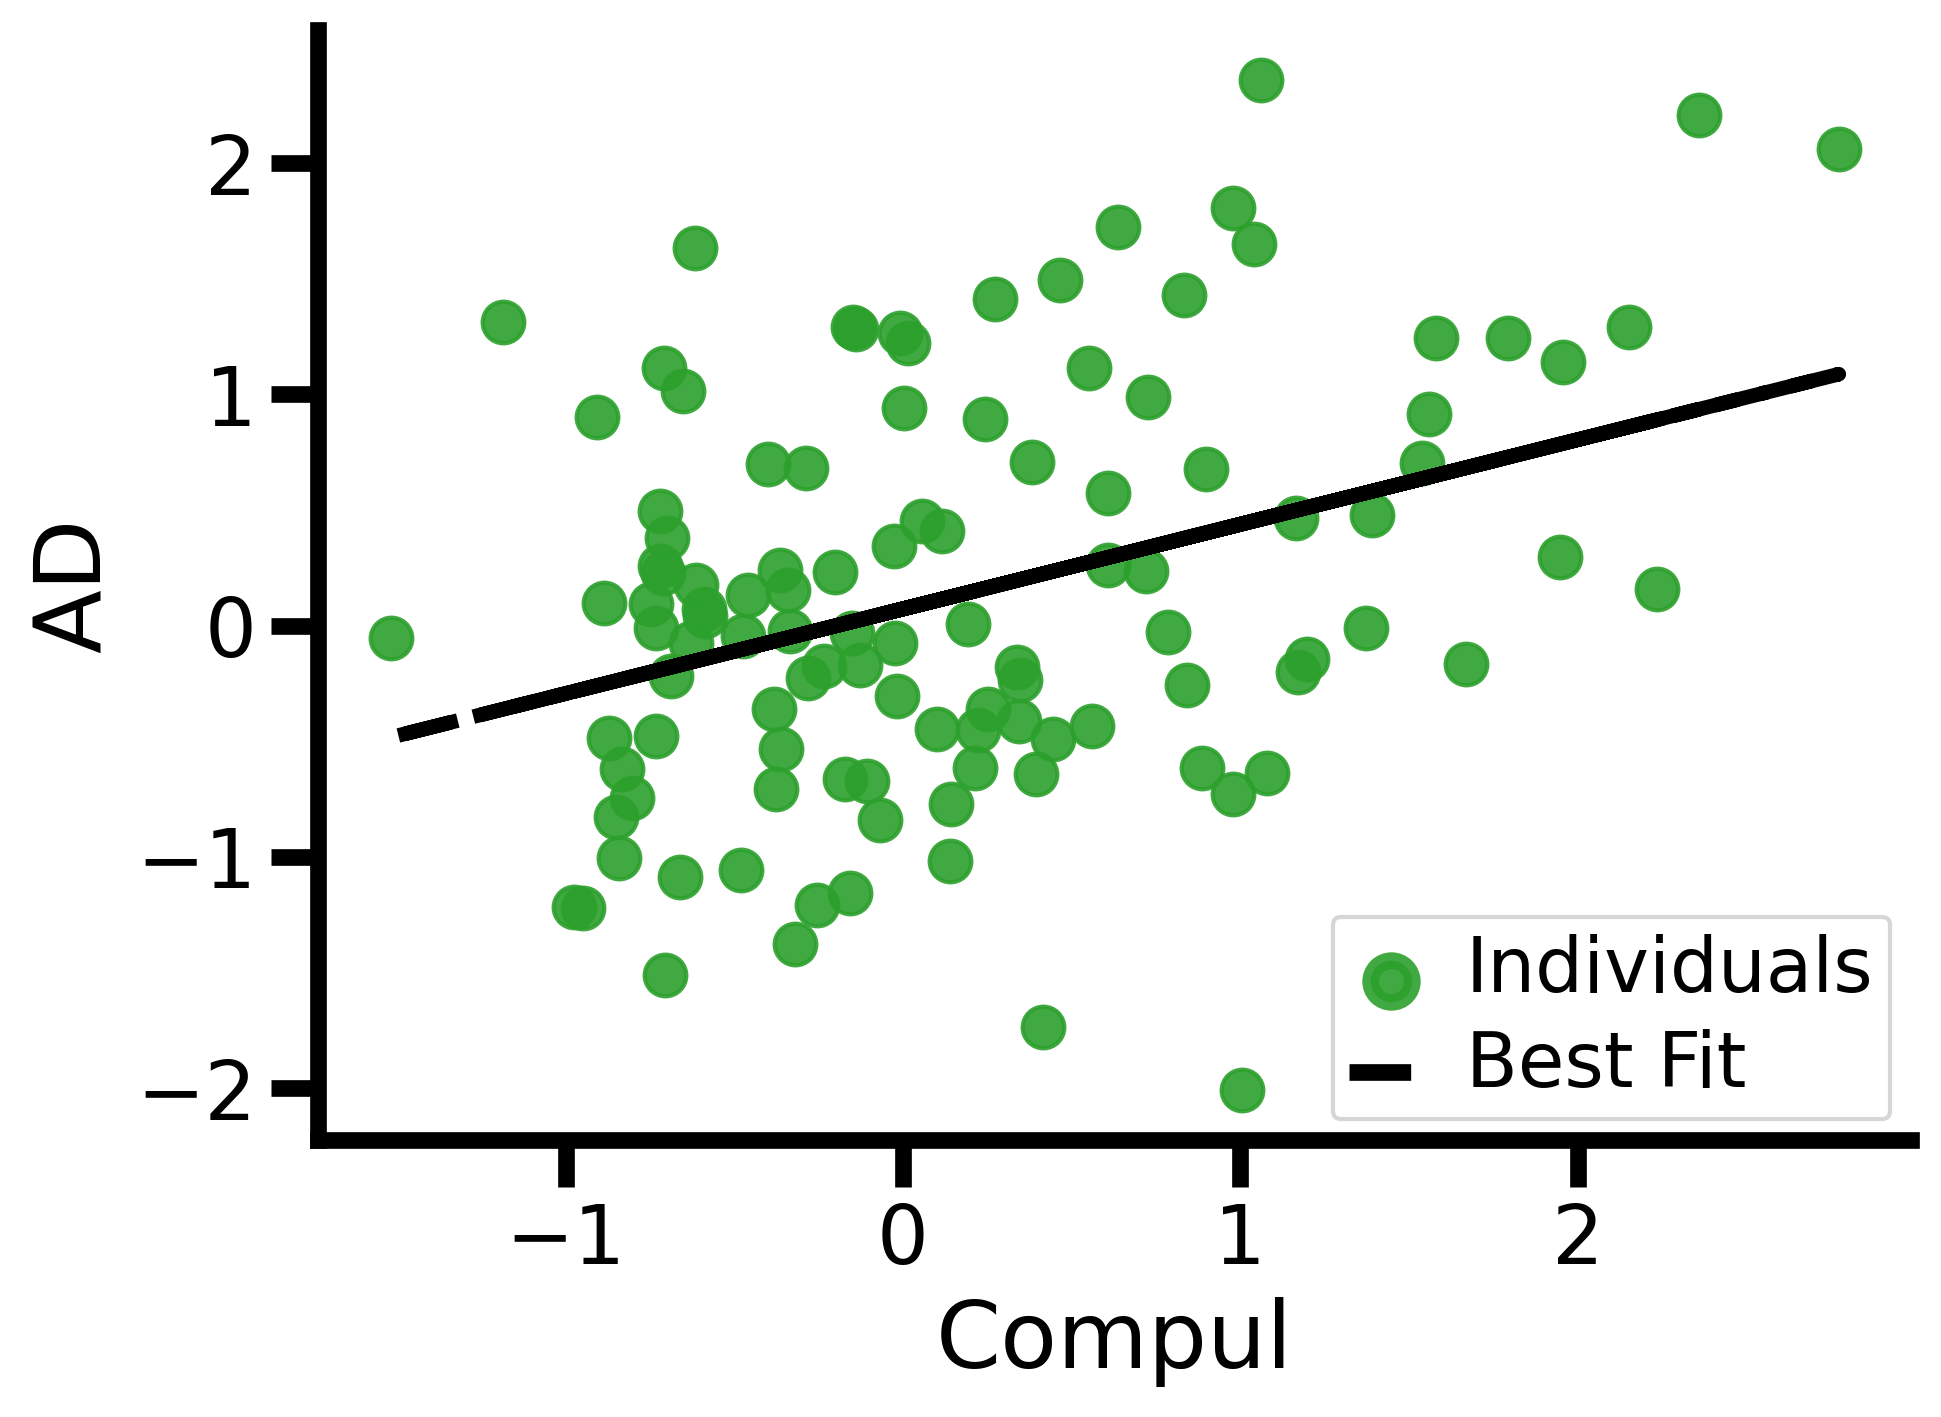

In [5]:
fig = plt.figure(dpi=300, figsize=(6.852, 4.903))
ax = fig.add_subplot(111)

# Calculate the line of best fit
m, b = np.polyfit(df['Compul'], df['AD'], 1)

# Plot the scatter plot
plt.scatter(df['Compul'], df['AD'], color='C2', alpha=0.9, label='Individuals', s=100)

# Plot the line of best fit
plt.plot(df['Compul'], m*df['Compul'] + b, color='black', linestyle='--', label='Best Fit')

plt.xlabel('Compul')
plt.ylabel('AD')

plt.legend()

format_axis(ax, font_size_multiplier=1.4)

In [6]:
len(df)

111

In [7]:
fig.savefig(os.path.join(analysis_folder, "corr_AD_Compul.png"))
fig.savefig(os.path.join(analysis_folder, "corr_AD_Compul.svg"))

In [8]:
print("line of best fit: ", m, b)

line of best fit:  0.3658338699111603 0.07217296716353114


In [9]:
print("done")

done


#### Predict AD based on Compul

In [10]:
AD_pred = df['Compul']*m + b
Compul_pred = df['AD']/m - b/m

### Compul and SW

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# Calculate the Pearson correlation coefficient
corr, _ = pearsonr(df['Compul'], df['SW'])
print(f'Pearson correlation: {corr}')

Pearson correlation: 0.37860260032559434


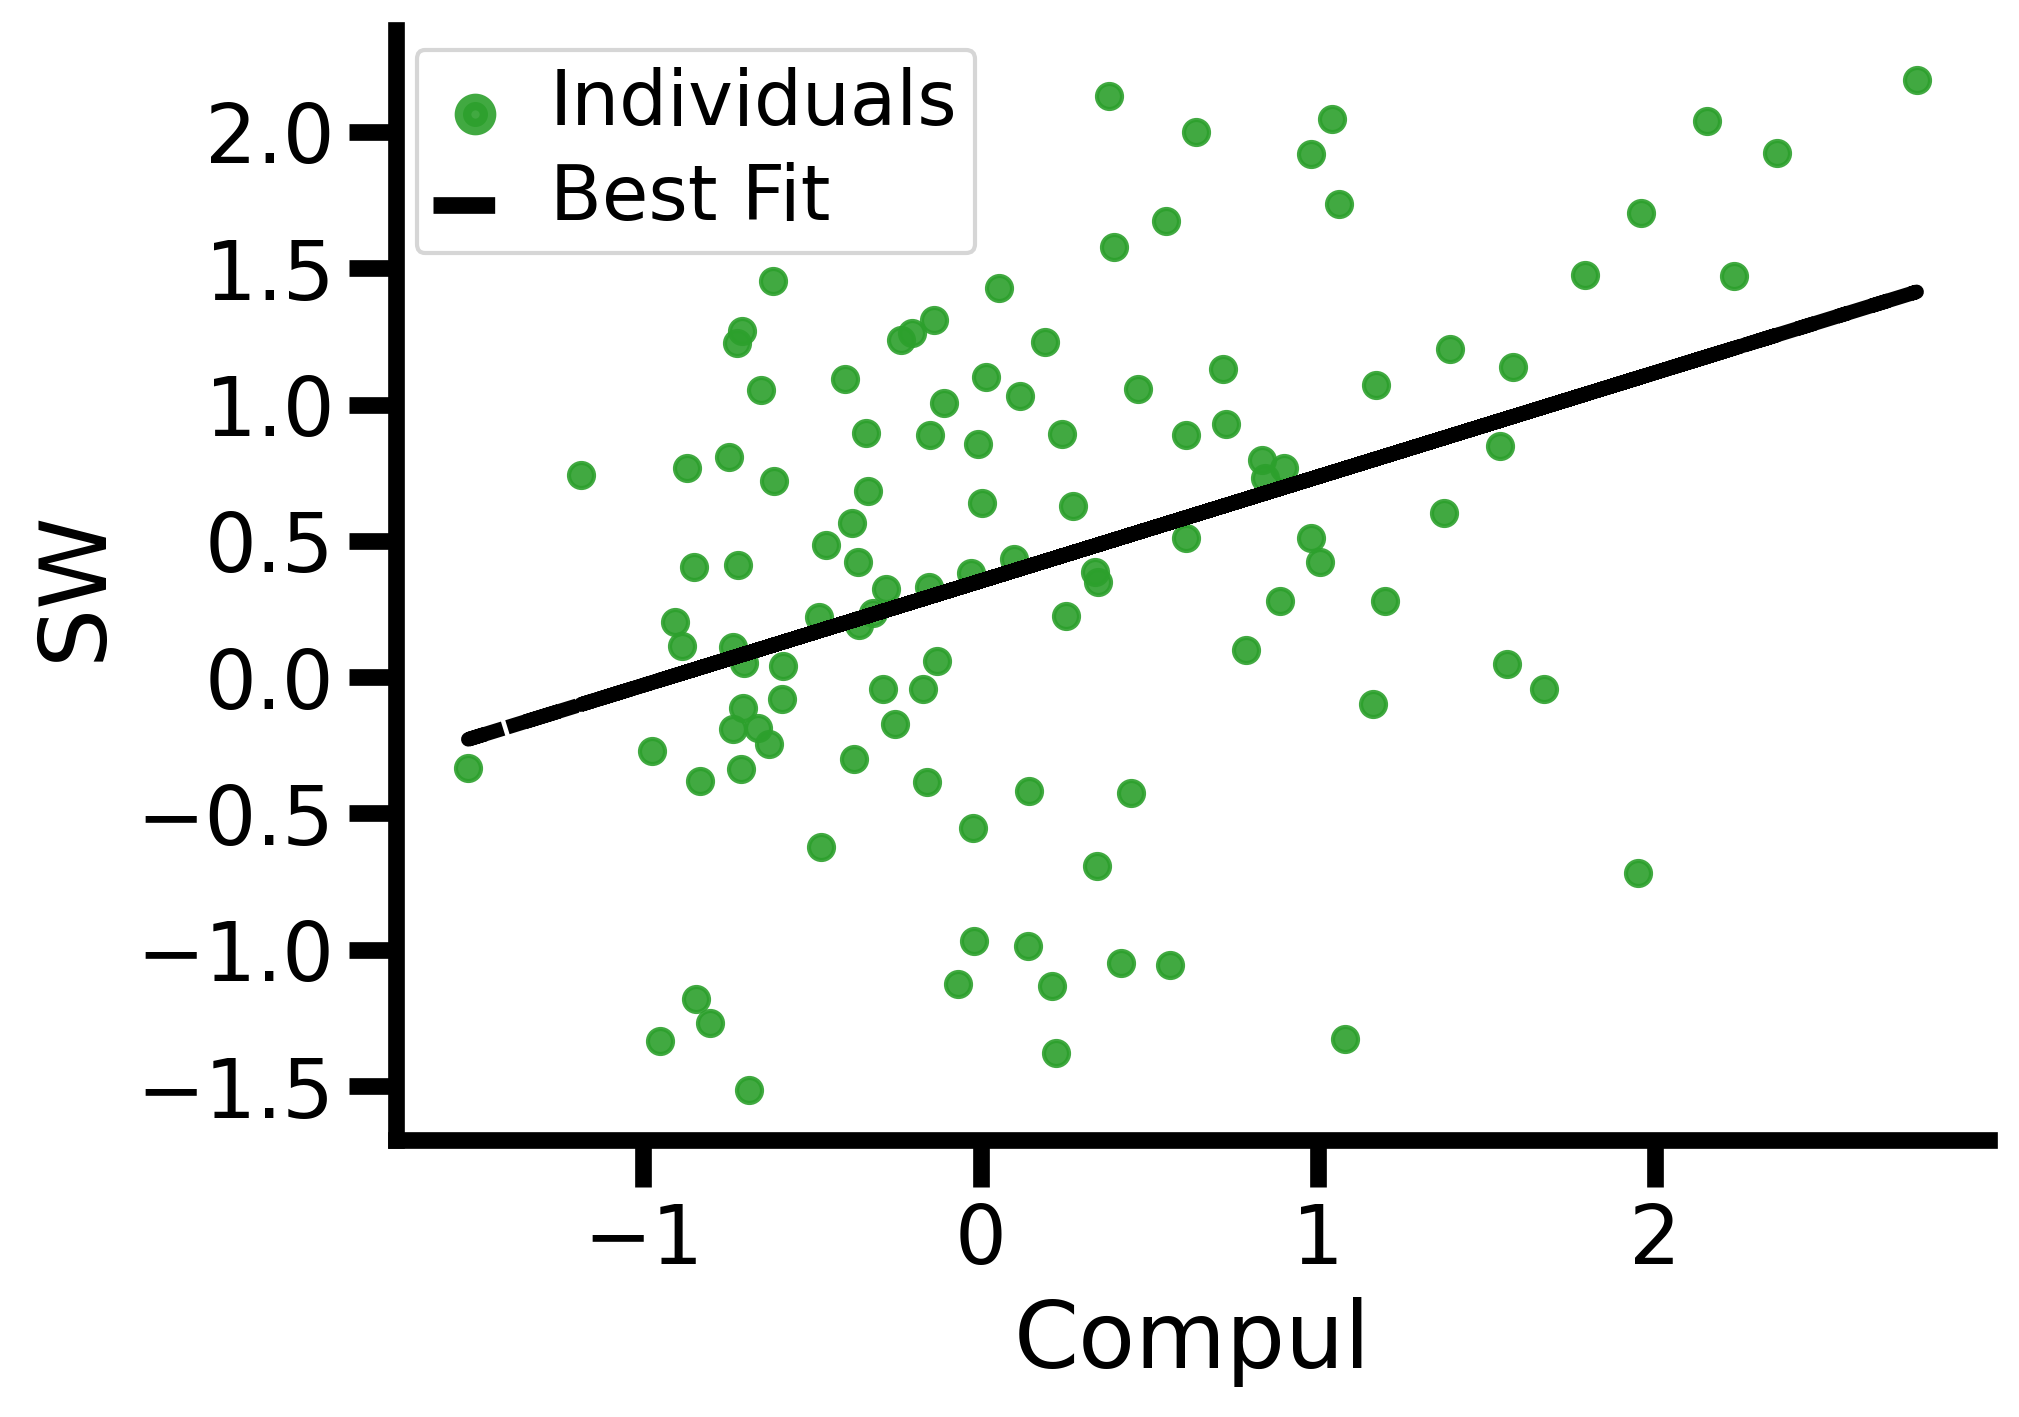

In [12]:
fig = plt.figure(dpi=300, figsize=(6.852, 4.903))
ax = fig.add_subplot(111)

# Calculate the line of best fit
m, b = np.polyfit(df['Compul'], df['SW'], 1)

# Plot the scatter plot
plt.scatter(df['Compul'], df['SW'], color='C2', alpha=0.9, label='Individuals')

# Plot the line of best fit
plt.plot(df['Compul'], m*df['Compul'] + b, color='black', linestyle='--', label='Best Fit')

plt.xlabel('Compul')
plt.ylabel('SW')

plt.legend()

format_axis(ax, font_size_multiplier=1.4)

In [13]:
fig.savefig(os.path.join(analysis_folder, "corr_SW_Compul.png"))
fig.savefig(os.path.join(analysis_folder, "corr_SW_Compul.svg"))

### AD and SW

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# Calculate the Pearson correlation coefficient
corr, _ = pearsonr(df['AD'], df['SW'])
print(f'Pearson correlation: {corr}')

Pearson correlation: 0.6842367179146633


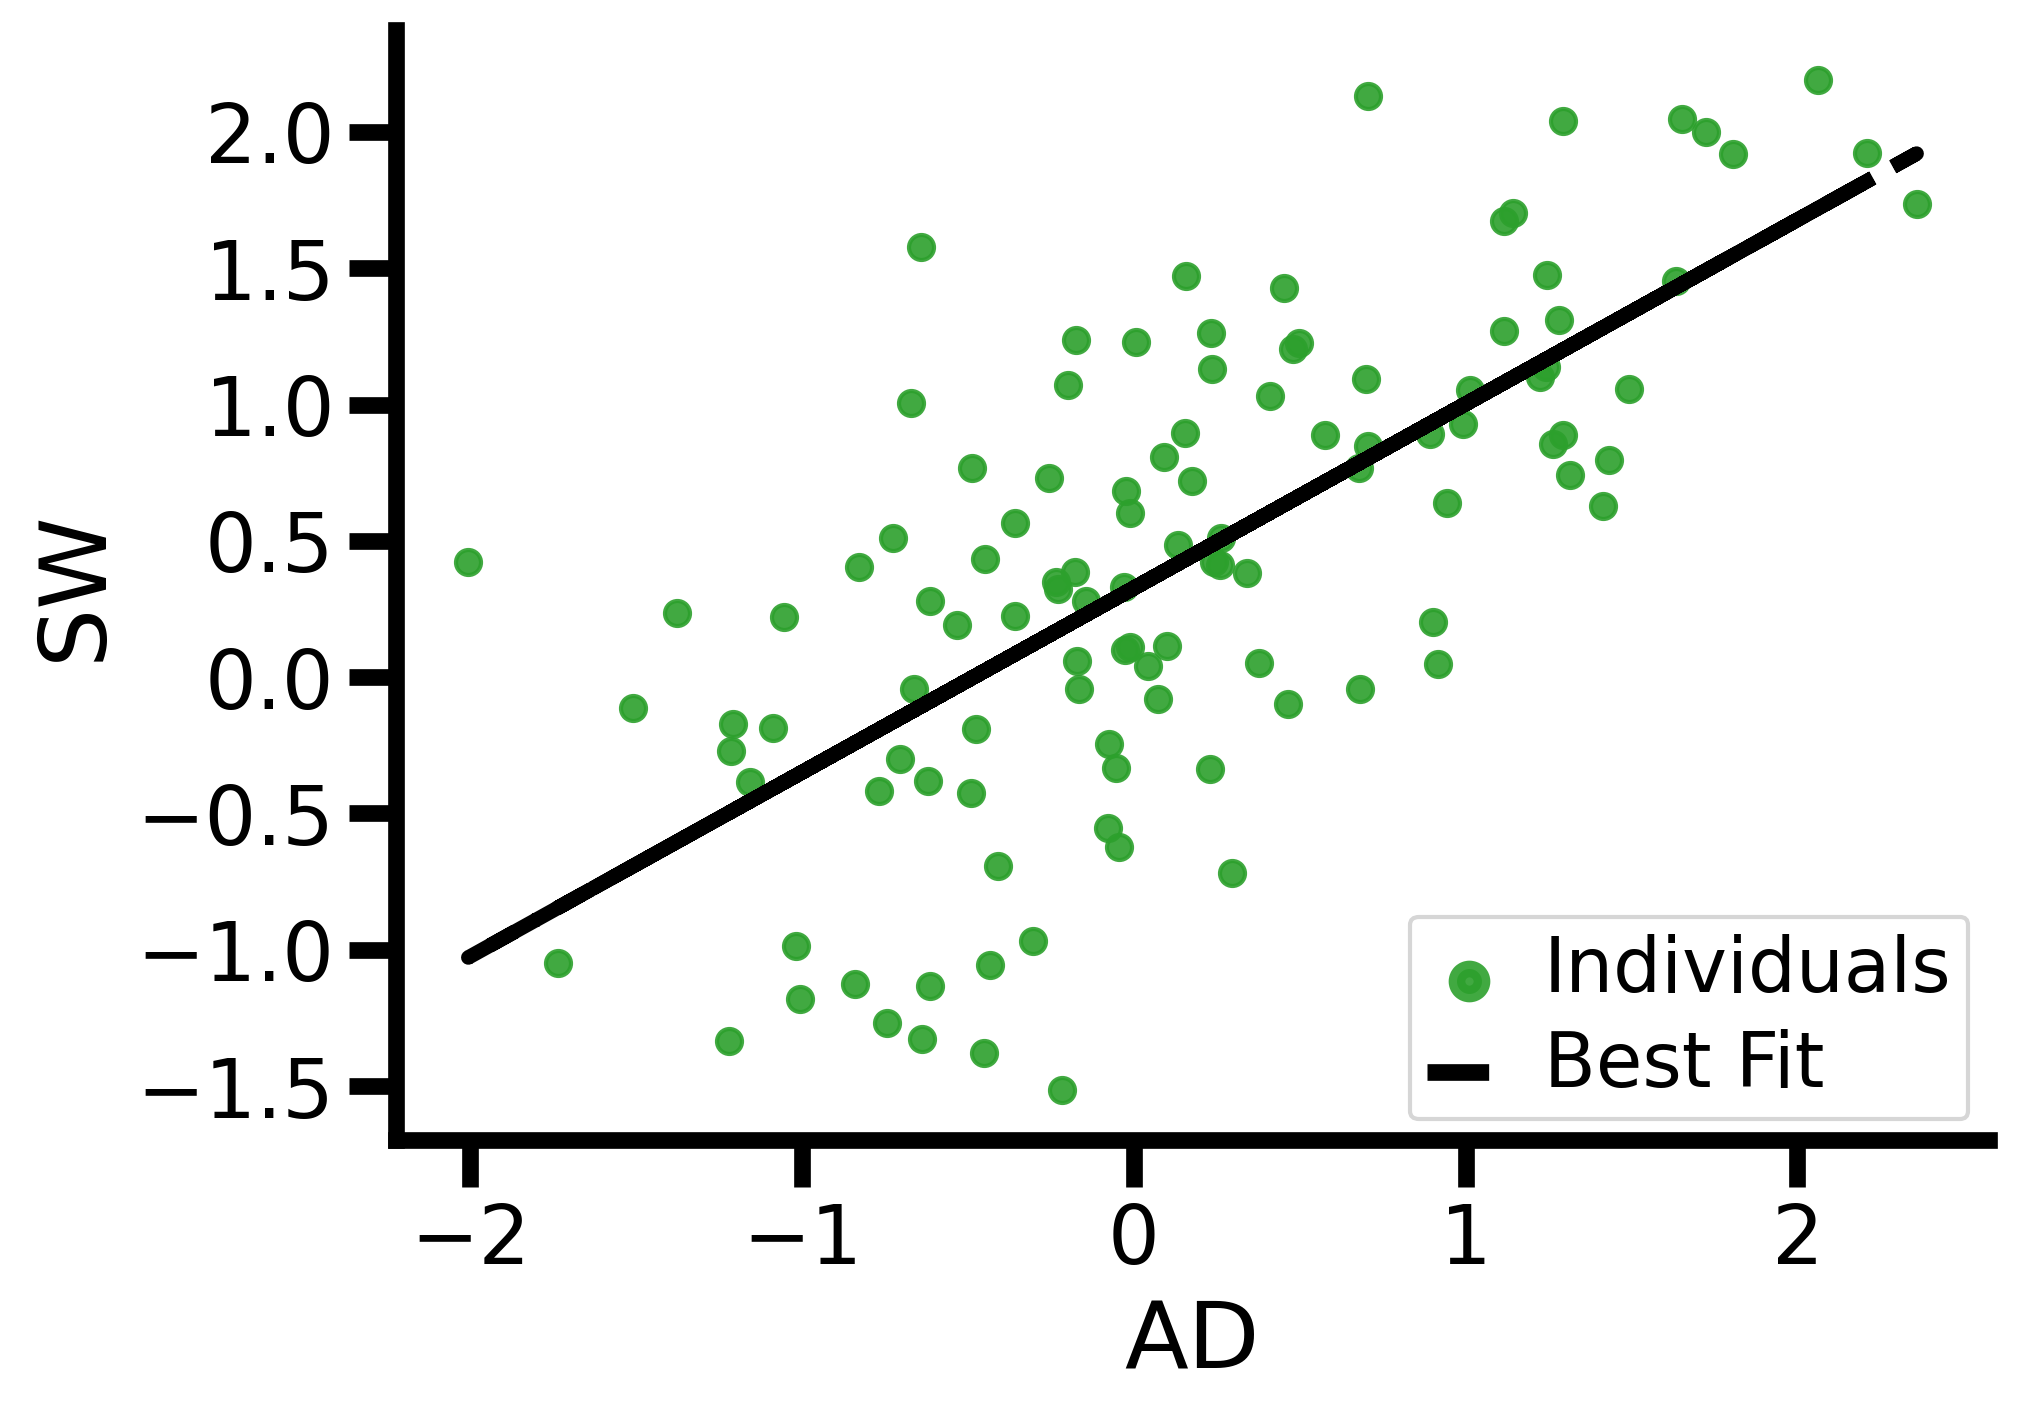

In [15]:
fig = plt.figure(dpi=300, figsize=(6.852, 4.903))
ax = fig.add_subplot(111)

# Calculate the line of best fit
m, b = np.polyfit(df['AD'], df['SW'], 1)

# Plot the scatter plot
plt.scatter(df['AD'], df['SW'], color='C2', alpha=0.9, label='Individuals')

# Plot the line of best fit
plt.plot(df['AD'], m*df['AD'] + b, color='black', linestyle='--', label='Best Fit')

plt.xlabel('AD')
plt.ylabel('SW')

plt.legend()

format_axis(ax, font_size_multiplier=1.4)

In [16]:
fig.savefig(os.path.join(analysis_folder, "corr_SW_AD.png"))
fig.savefig(os.path.join(analysis_folder, "corr_SW_AD.svg"))

### Computation of optimal linear prediction of number of observes by AD and Compul

In [17]:
### BOOTSTRAP 100x

paramss = []
n_iterations = 100

for i in range(n_iterations):

    Y_true = np.stack(df['n_observes'].values).sum(axis=1)
    X = df[['AD', 'Compul']]

    X = sm.add_constant(X)
    model = sm.OLS(Y_true, X).fit()
    print(model.summary())

    Y_pred = model.predict(X)
    #Y_res = Y_true - Y_pred

    #Y_res = - model.params['AD'] * df['Compul'] + model.params['Compul'] * df['AD']

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.385
Date:                Thu, 29 Aug 2024   Prob (F-statistic):              0.255
Time:                        13:17:36   Log-Likelihood:                -527.50
No. Observations:                 111   AIC:                             1061.
Df Residuals:                     108   BIC:                             1069.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         56.0829      2.759     20.328      0.0

## Panel A: Task 1 Observes

### AD

In [18]:
human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

mask = 'nomask'
iday = 2
day = 'day%d' %iday
exp_date = '24-01-22-29'
#exp_date = '518-525-619-706'
with_nets = False
include_sleep = False
include_estimates = False
group = None
#group = "groupA"

analysis_folder = os.path.join('panels', 'fig_transdiags')

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

[[0.27019261 0.31004015 0.44879412 0.58149479 0.57544149 0.45071033
  0.59378809 0.47721312 0.55048152]
 [0.33369178 0.27524076 0.49203049 0.35547351 0.51381222 0.30127608
  0.52178173 0.40221521 0.4186919 ]
 [0.3963725  0.35121992 0.46971109 0.58182187 0.51965493 0.583411
  0.71466294 0.58979138 0.56375606]
 [0.35439816 0.32995197 0.24918154 0.37351543 0.56639664 0.46597128
  0.43834683 0.58605157 0.52229551]
 [0.         0.15567424 0.14770473 0.15992783 0.30020073 0.45269673
  0.50105145 0.5812842  0.58553779]
 [0.45802566 0.47024876 0.62540923 0.5467656  0.56057782 0.61531293
  0.58448634 0.71148469 0.86398069]
 [0.53615552 0.67376395 0.66792124 0.69341888 0.7662198  0.80022463
  0.78428561 0.77577843 0.80394055]
 [0.44472722 0.43729539 0.70138839 0.53346715 0.63868378 0.72583459
  0.78428561 0.81616364 0.84060984]
 [0.28440211 0.38402096 0.52969299 0.53877618 0.50563212 0.54541743
  0.62041534 0.57643071 0.64923561]]


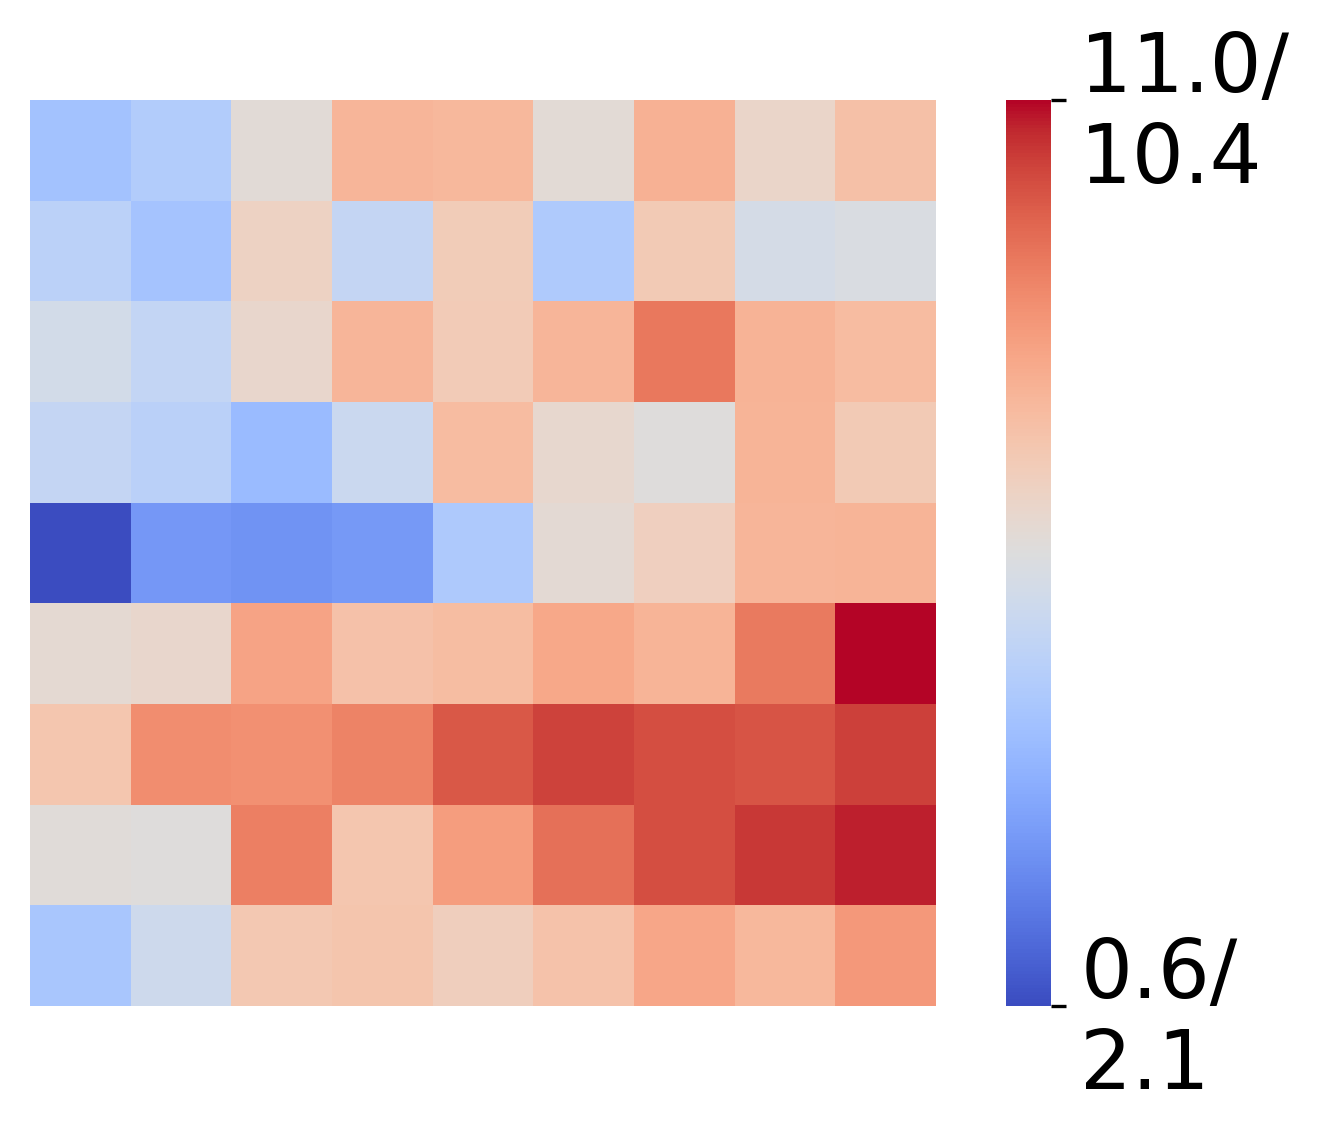

In [19]:
from human_utils_transdiagnostics import plot_td_quantile_analysis_results

#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), getPCs(df['AD'], df['Compul'])[:,1], np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), np.random.randn(len(df)), np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), np.stack(df['efficacy_estimates'].values).mean(axis=1), np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), np.stack(df['efficacy_estimates'].values).mean(axis=1), np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['AD'] - AD_pred, np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=True, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = False, annot=False, flip_leastmost=True)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Observes", col2name="AD", groups = None, num_bins=9, combine_groups = False, annot=False, flip_leastmost=True)


In [20]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_observes_AD.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_observes_AD.svg"))

### AD Residual

PC1 loadings:  [0.72901262 0.68450026]
PC2 loadings:  [-0.68450026  0.72901262]
Variance explained by PC1:  0.6791482866096403
Variance explained by PC2:  0.3208517133903596
Flipped PC2 to enforce second component to be negative.
[[0.18898444 0.29049959 0.50589681 0.42510238 0.5255733  0.57946355
  0.81244881 0.66234644 0.79694922]
 [0.12518428 0.04144144 0.1988534  0.27366912 0.3959869  0.19971335
  0.36805897 0.42993448 0.39914005]
 [0.57841933 0.57727273 0.52461097 0.64864865 0.68259623 0.59684685
  0.66130221 0.65986896 0.62878788]
 [0.39049959 0.62158067 0.76977887 0.63308763 0.78935299 0.81036036
  0.78013923 0.79914005 0.84115479]
 [0.29410319 0.24201474 0.43079443 0.39799345 0.52518428 0.5470516
  0.66130221 0.61986077 0.6523751 ]
 [0.26560197 0.3487715  0.32948403 0.50618346 0.50790336 0.57035217
  0.68632269 0.67481572 0.74963145]
 [0.3481982  0.46273546 0.53755119 0.55827191 0.63165438 0.77063882
  0.71826372 0.81179361 0.84459459]
 [0.66531532 0.72776413 0.67739558 0.915683

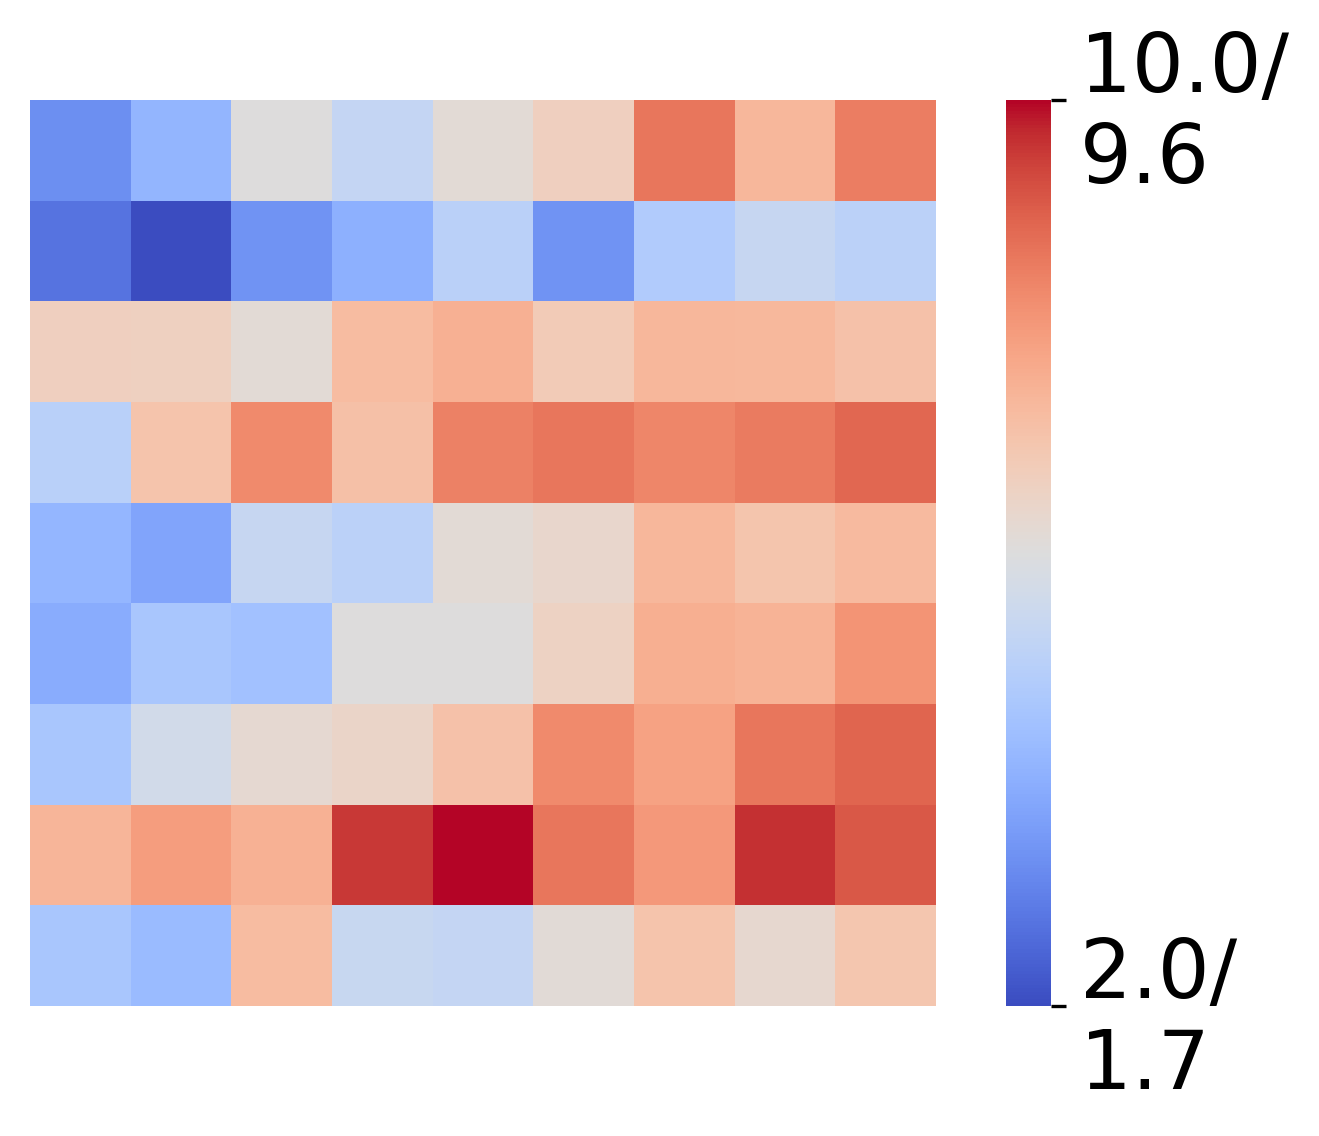

In [21]:
from human_utils_transdiagnostics import plot_td_quantile_analysis_results

quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), get_alternate_TD_representation(df['AD'], df['Compul'], method, np.stack(df['n_observes'].values).sum(axis=1))[0], np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['Compul'] - df['AD'] , np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['AD'] - AD_pred, np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)

In [22]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_observes_AD_residual.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_observes_AD_residual.svg"))

### Compul

[[0.         0.15395395 0.21786787 0.24714715 0.41951952 0.63628629
  0.72947948 0.69099099 0.82432432]
 [0.4009152  0.54151294 0.61427141 0.56382096 0.63995424 0.61232661
  0.5046761  0.67147147 0.64916345]
 [0.27444587 0.35149435 0.44164164 0.41595882 0.43243243 0.3950808
  0.51777492 0.52841413 0.51388531]
 [0.13138853 0.29183469 0.36991277 0.28314028 0.44021164 0.41893322
  0.71179751 0.73307593 0.76173316]
 [0.22102102 0.22880023 0.45525526 0.48963249 0.55993136 0.61038181
  0.71854712 0.69183469 0.76602317]
 [0.27730588 0.28845989 0.36848277 0.49157729 0.58418418 0.38781639
  0.3975404  0.30830831 0.28988989]
 [0.44267124 0.37769198 0.58767339 0.52463892 0.59299299 0.57119977
  0.67301587 0.6002574  0.6962391 ]
 [0.17548978 0.1992278  0.15512656 0.44696125 0.35486915 0.36018876
  0.43775204 0.35240955 0.4959817 ]
 [0.57634301 0.44804805 0.72065399 0.55615616 0.60779112 0.61338005
  0.61888555 0.68728729 0.60286954]]


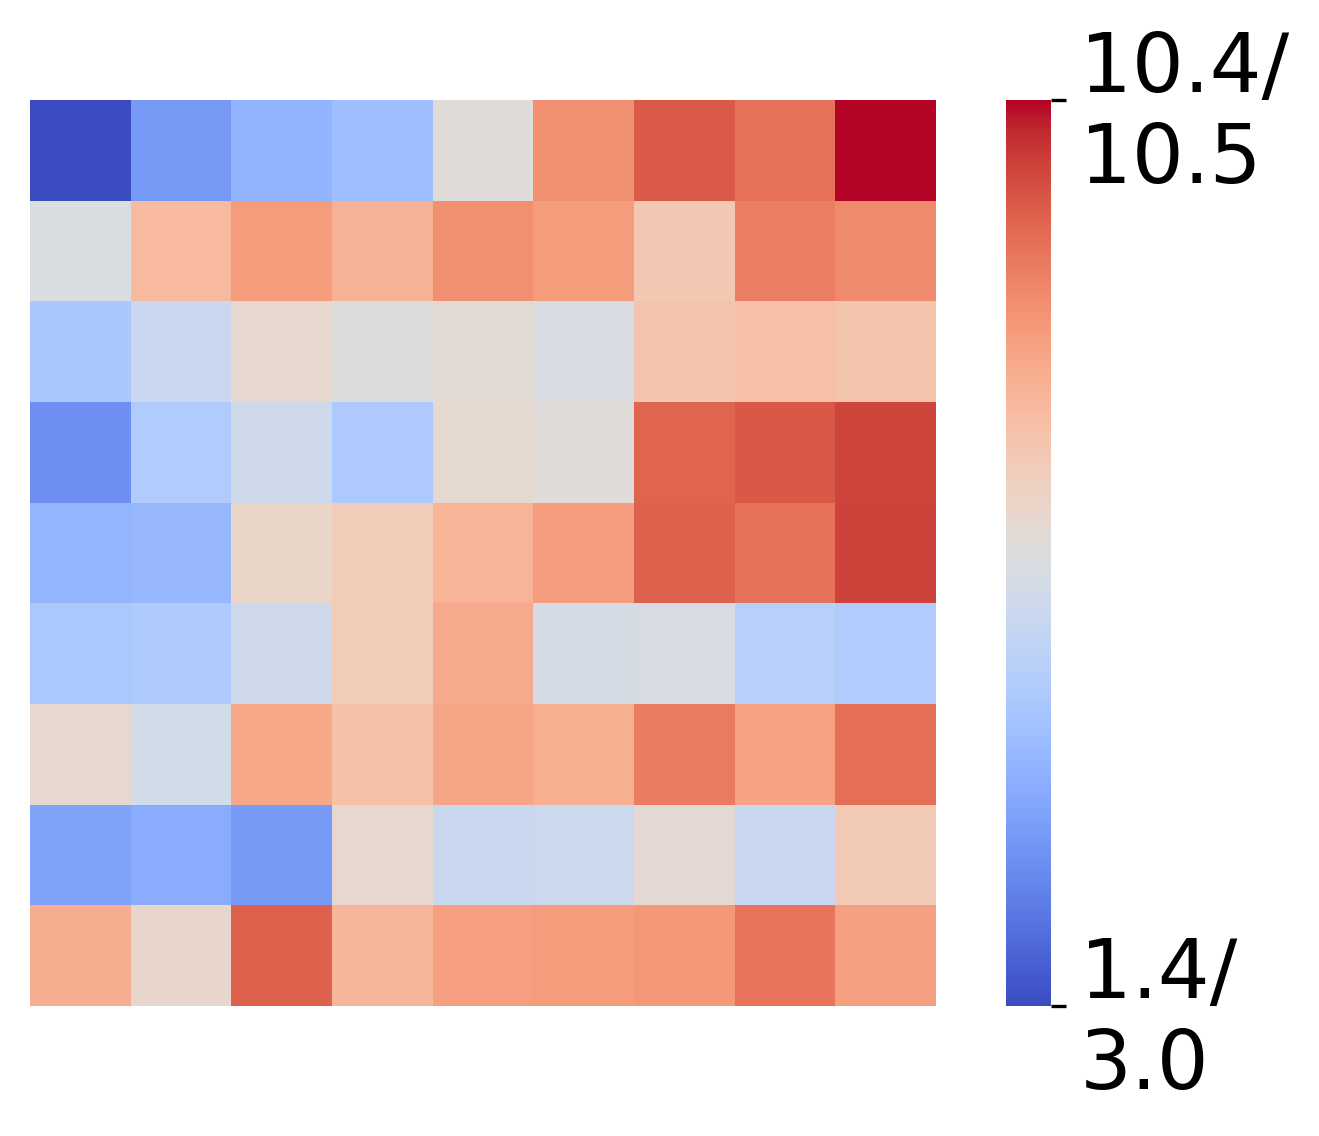

In [23]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = df["group"], num_bins =9, combine_groups = True, annot=False , square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = df["group"], num_bins =9, combine_groups = True, annot=False , square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = df["group"], num_bins =9, combine_groups = False, annot=False)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = None, num_bins =9, combine_groups = False, annot=False)

In [24]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_observes_Compul.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_observes_Compul.svg"))

### Compul Residual

PC1 loadings:  [0.72901262 0.68450026]
PC2 loadings:  [-0.68450026  0.72901262]
Variance explained by PC1:  0.6791482866096403
Variance explained by PC2:  0.3208517133903596
Flipped PC2 to enforce second component to be negative.
[[0.38415327 0.192008   0.23331926 0.47185683 0.46118209 0.40780841
  0.39064347 0.48763408 0.44587456]
 [0.48061625 0.487381   0.73548016 0.72062089 0.78367197 0.48133905
  0.75854977 0.51250319 0.53279743]
 [0.20473532 0.22647515 0.45283448 0.30776787 0.31597821 0.32745511
  0.42505271 0.28614386 0.25425692]
 [0.23396269 0.20811769 0.33156028 0.31054326 0.38917641 0.33156028
  0.44884512 0.46853236 0.42178615]
 [0.11184988 0.15388394 0.35185451 0.26235145 0.44268737 0.39183598
  0.59318893 0.57760686 0.67930963]
 [0.11184988 0.20340553 0.27660373 0.28203869 0.37287154 0.65080506
  0.682692   0.55187768 0.75794278]
 [0.20279854 0.33977062 0.43398585 0.54112357 0.53230624 0.54245336
  0.60345186 0.67060811 0.70177225]
 [0.22309277 0.38035908 0.42034055 0.43193

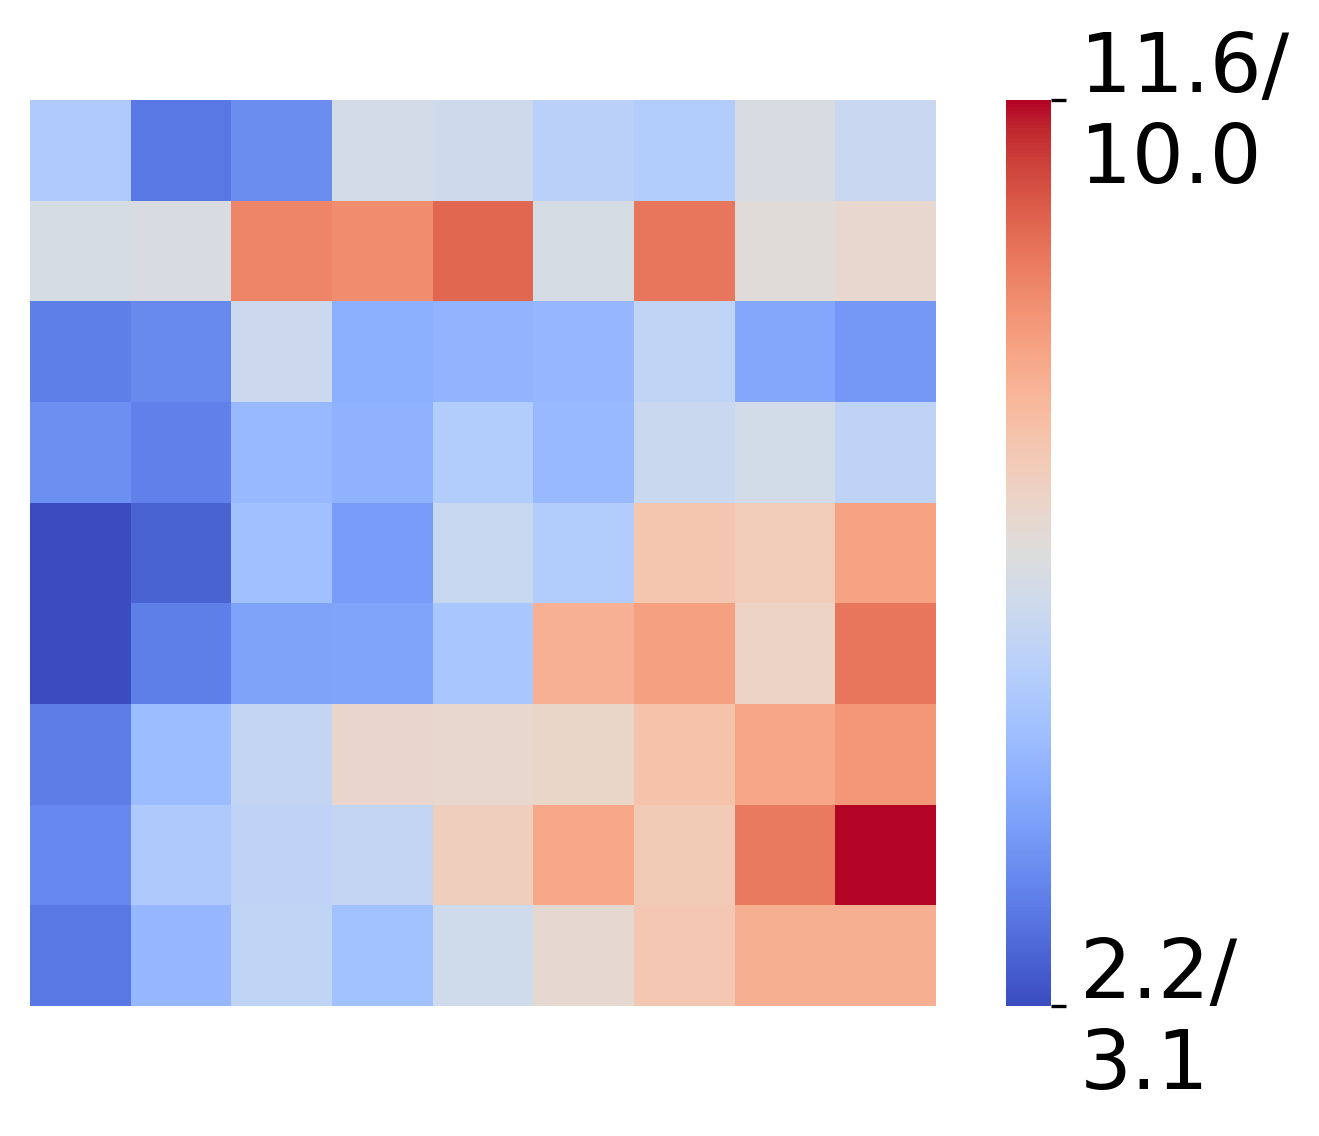

In [25]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), get_alternate_TD_representation(df['AD'], df['Compul'], method, np.stack(df['n_observes'].values).sum(axis=1))[1], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = df["group"], num_bins =9, combine_groups = True, annot=False , square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = df["group"], num_bins =9, combine_groups = True, annot=False , square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = df["group"], num_bins =9, combine_groups = False, annot=False)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = None, num_bins =9, combine_groups = False, annot=False)

In [26]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_observes_Compul_residual.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_observes_Compul_residual.svg"))

### SW

[[0.38955774 0.22596233 0.51902129 0.4278665  0.45485258 0.42063882
  0.60704341 0.48593366 0.49420557]
 [0.32805078 0.32948403 0.4451679  0.4546683  0.68488943 0.42100737
  0.59021294 0.45151515 0.46158886]
 [0.27424242 0.44086814 0.38906634 0.502457   0.52403767 0.57583948
  0.50389025 0.69123669 0.55597871]
 [0.06216216 0.11568387 0.19021294 0.41928747 0.46273546 0.60950041
  0.68603604 0.66388206 0.72919738]
 [0.2963964  0.39049959 0.4958231  0.42043407 0.56691237 0.56605242
  0.48230958 0.63972154 0.73497133]
 [0.01064701 0.31683047 0.25552826 0.41179361 0.49782965 0.61466011
  0.66846847 0.67710893 0.67710893]
 [0.33984439 0.31740377 0.4535217  0.40315315 0.50618346 0.51797707
  0.56920557 0.58042588 0.64344799]
 [0.46531532 0.4005733  0.5481982  0.55855856 0.66445536 0.59049959
  0.75970516 0.8005733  0.8022932 ]
 [0.50974611 0.55813541 0.81103604 0.66446901 0.58471881 0.59949495
  0.69855992 0.63720311 0.79489489]]


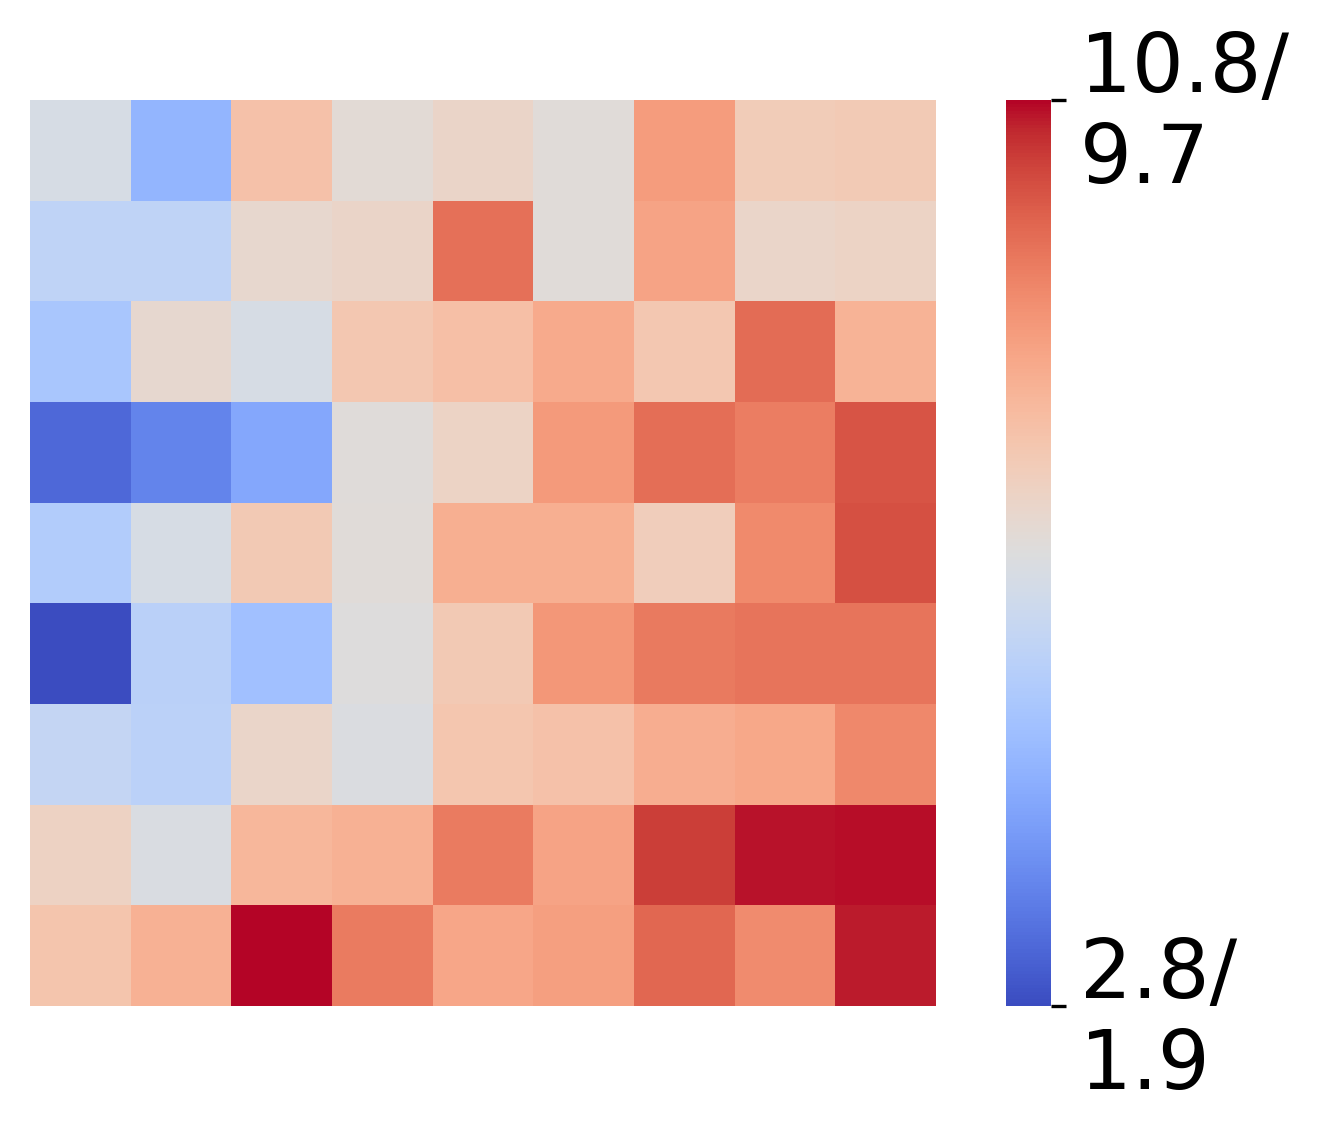

In [27]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['SW'], np.stack(df["effs"].values), "Observes", col2name = "SW", groups = df["group"], num_bins =9, combine_groups = True, annot=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['SW'], np.stack(df["effs"].values), "Observes", col2name = "SW", groups = None, num_bins =9, combine_groups = False, annot=False)

In [28]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_observes_SW.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_observes_SW.svg"))

### Trait-level simulations

In [29]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_anal import pepe_human_ape_models as ape_models
from settings_anal import trait_simulated_participants_folder_t1 as simulated_participants_folder
from settings_anal import trait_sim_timestamp_t1 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)

## flip to correct for switching from tau to efficacy
sim_obss = np.flip(sim_obss.T,axis=1)
sim_rewss = np.flip(sim_rewss.T, axis=1)

original_mag_perturbation = 1
with open(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'sim', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_sim_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

[[0.15988235 0.18052941 0.21082353 0.26347059 0.34735294 0.50529412
  0.83394118 1.49564706 2.58305882]
 [0.25341176 0.31517647 0.39735294 0.53688235 0.78470588 1.29470588
  2.28329412 3.68005882 5.17394118]
 [0.430125   0.5429375  0.721      1.050375   1.733      2.9405
  4.533375   5.9401875  6.8249375 ]
 [0.55476471 0.70852941 0.95476471 1.49817647 2.56717647 4.15505882
  5.67258824 6.66129412 7.33923529]
 [0.6714375  0.8781875  1.2669375  2.0485     3.4874375  5.1036875
  6.31225    7.08475    7.6666875 ]
 [0.83558824 1.14270588 1.77435294 2.96935294 4.60135294 5.93970588
  6.87017647 7.52617647 8.00352941]
 [1.0624375  1.56325    2.5553125  4.0714375  5.5256875  6.5920625
  7.3216875  7.8594375  8.2754375 ]
 [2.02494118 3.14505882 4.55623529 5.86211765 6.81152941 7.52217647
  8.03447059 8.44223529 8.77358824]
 [4.64182353 5.82529412 6.79641176 7.52064706 8.08888235 8.52441176
  8.91241176 9.23094118 9.55747059]]


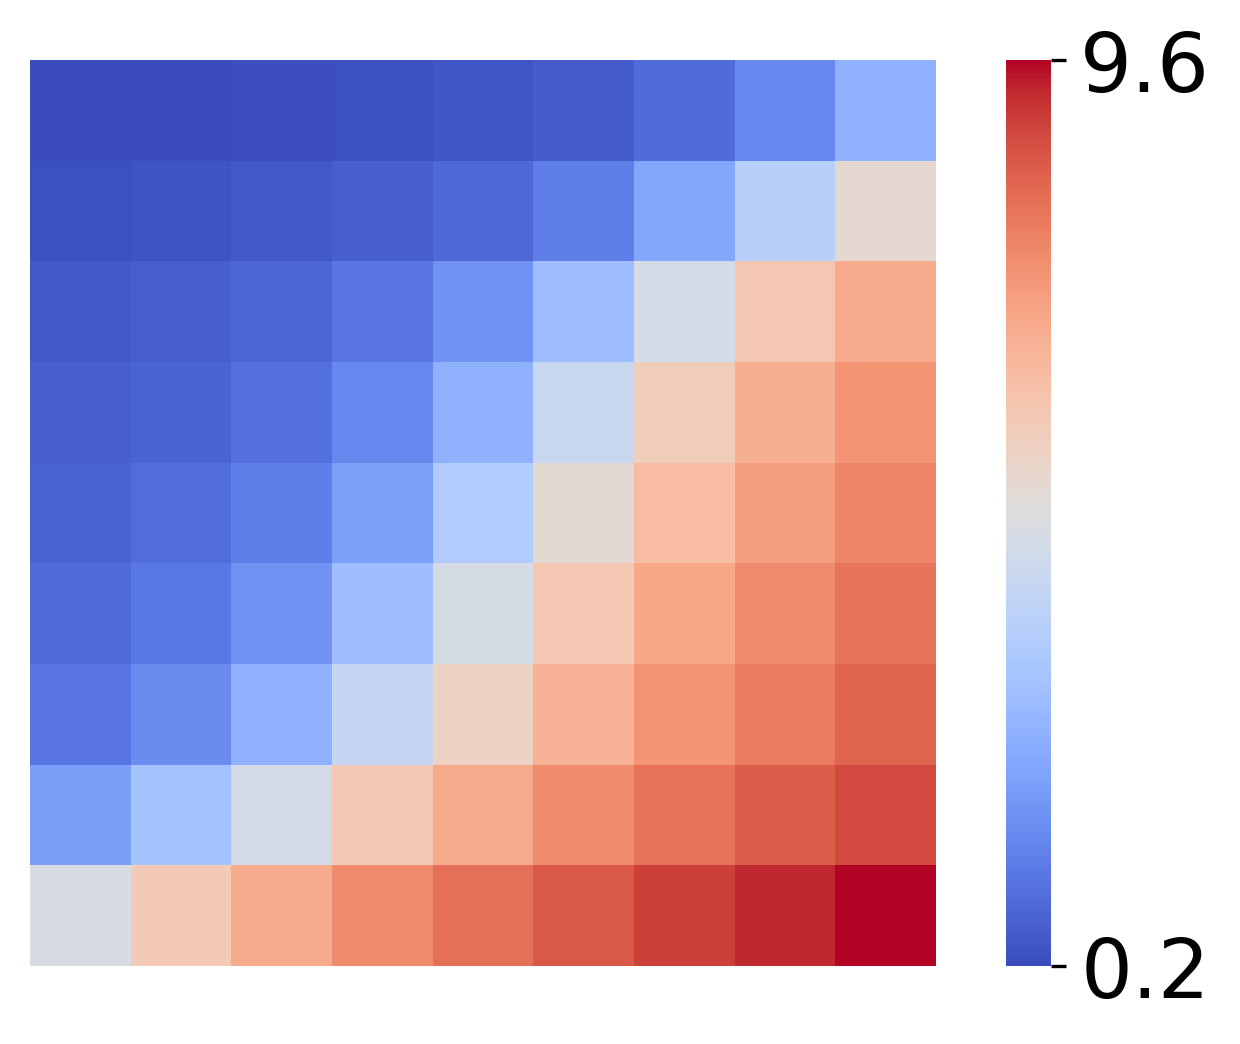

In [30]:
quantile_fig = plot_td_quantile_analysis_results(sim_obss, sim_participant_perturbations, effs, "Observes", col2name = "Belief", groups = None, num_bins =9, annot=False, square=square, axes_off=axes_off)

In [31]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_observes_NN.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_observes_NN.svg"))

### Permuted Simulations

In [32]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_anal import pepe_human_ape_models as ape_models
#from settings_anal import trait_simulated_participants_folder_t1 as simulated_participants_folder
from settings_anal import zeros_simulated_participants_folder_t1 as simulated_participants_folder
from settings_anal import zeros_sim_timestamp_t1 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)

## flip to correct for switching from tau to efficacy
sim_obss = np.flip(sim_obss.T,axis=1)
sim_rewss = np.flip(sim_rewss.T, axis=1)

original_mag_perturbation = 1
with open(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'nostruc', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_nostruc_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy


# ## save the permuted perturbations
# if not os.path.exists(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'sim', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_sim_mag_permuted.pkl' %sim_timestamp)):

#     original_mag_perturbation = 1
#     with open(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'sim', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_sim_mag.pkl' %sim_timestamp), 'rb') as f:
#         sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy
    
#     ## Permute sim_participant_perturbations
#     sim_participant_perturbations = np.random.permutation(sim_participant_perturbations)
#     pickle.dump(sim_participant_perturbations, open(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'sim', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_sim_mag_permuted.pkl' %sim_timestamp), 'wb'))

#     print('new permutation')

# else:
#     with open(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'sim', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_sim_mag_permuted.pkl' %sim_timestamp), 'rb') as f:
#         sim_participant_perturbations = pickle.load(f)
#     print('loaded')

print(sim_obss, sim_participant_perturbations, effs)

[[0.584 0.784 1.166 ... 6.014 6.951 7.485]
 [0.619 0.804 1.125 ... 6.127 6.934 7.511]
 [0.644 0.819 1.132 ... 6.054 6.918 7.543]
 ...
 [0.606 0.778 1.137 ... 6.064 6.988 7.612]
 [0.611 0.834 1.127 ... 6.089 6.957 7.508]
 [0.608 0.797 1.174 ... 6.14  6.978 7.54 ]] [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0.] [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]


[[0.61814667 0.79918    1.12219333 1.79572667 3.07134667 4.73412667
  6.06217333 6.93296    7.53557333]
 [0.61814667 0.79918    1.12219333 1.79572667 3.07134667 4.73412667
  6.06217333 6.93296    7.53557333]
 [0.61814667 0.79918    1.12219333 1.79572667 3.07134667 4.73412667
  6.06217333 6.93296    7.53557333]
 [0.61814667 0.79918    1.12219333 1.79572667 3.07134667 4.73412667
  6.06217333 6.93296    7.53557333]
 [0.61814667 0.79918    1.12219333 1.79572667 3.07134667 4.73412667
  6.06217333 6.93296    7.53557333]
 [0.61814667 0.79918    1.12219333 1.79572667 3.07134667 4.73412667
  6.06217333 6.93296    7.53557333]
 [0.61814667 0.79918    1.12219333 1.79572667 3.07134667 4.73412667
  6.06217333 6.93296    7.53557333]
 [0.61814667 0.79918    1.12219333 1.79572667 3.07134667 4.73412667
  6.06217333 6.93296    7.53557333]
 [0.61814667 0.79918    1.12219333 1.79572667 3.07134667 4.73412667
  6.06217333 6.93296    7.53557333]]


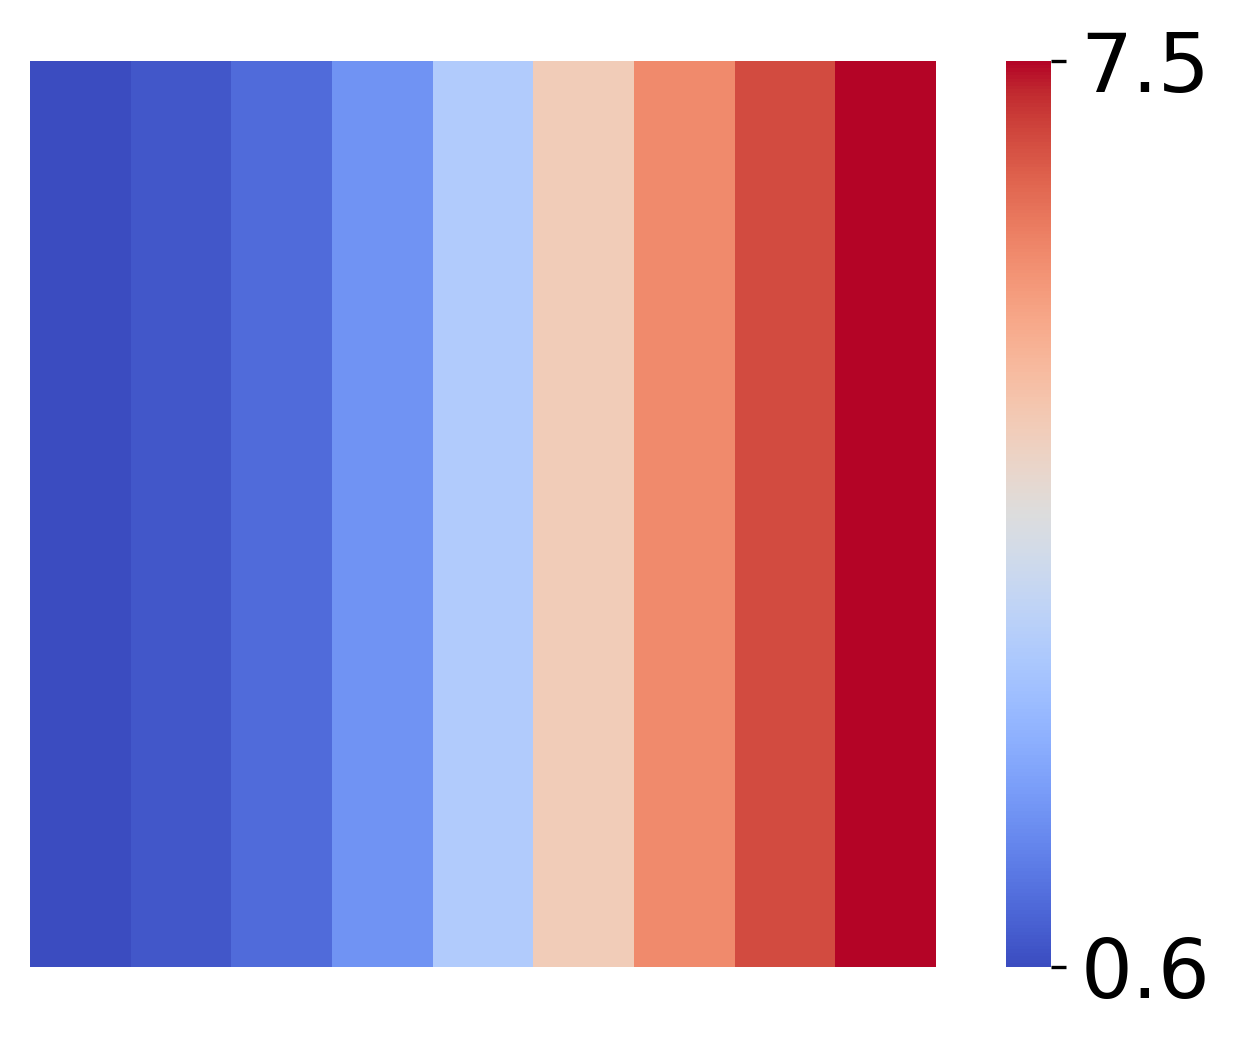

In [33]:
quantile_fig = plot_td_quantile_analysis_results(sim_obss, sim_participant_perturbations, effs, "Observes", col2name = "Belief", groups = None, num_bins =9, annot=False, square=square, axes_off=axes_off)

In [34]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_observes_NN_permuted.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_observes_NN_permuted.svg"))

## Panel B: Task 1 Rewards
### AD

In [35]:
human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

mask = 'nomask'
iday = 2
day = 'day%d' %iday
exp_date = '24-01-22-29'
with_nets = False
include_sleep = False
include_estimates = False
group = None

analysis_folder = os.path.join('panels', 'fig_transdiags')

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

[[0.1040131  0.25935026 0.35872236 0.28856129 0.31258531 0.50969151
  0.36281736 0.36936937 0.8020748 ]
 [0.27764128 0.30876331 0.28446628 0.33033033 0.35326235 0.60769861
  0.66120666 0.79060879 0.87305487]
 [0.36527437 0.29047229 0.34780235 0.26562927 0.32541633 0.48430248
  0.63008463 0.68577669 0.60660661]
 [0.25197925 0.27463827 0.43161343 0.39475839 0.3980344  0.35353535
  0.78869779 0.54054054 0.64455364]
 [0.34015834 0.46328146 0.36336336 0.35708436 0.5984166  0.53098553
  0.47229047 0.61015561 0.60606061]
 [0.23669124 0.1976522  0.28200928 0.49112749 0.52989353 0.61916462
  0.67840568 0.7998908  0.75511876]
 [0.26126126 0.11302211 0.32159432 0.38629539 0.4979525  0.3980344
  0.76167076 0.7957958  0.84438984]
 [0.11766312 0.31804532 0.3019383  0.48921649 0.25962326 0.55582856
  0.56647557 0.58640459 0.72809173]
 [0.20861771 0.3987624  0.25420875 0.37710438 0.55778506 0.67890618
  0.49494949 0.62357812 0.88279188]]


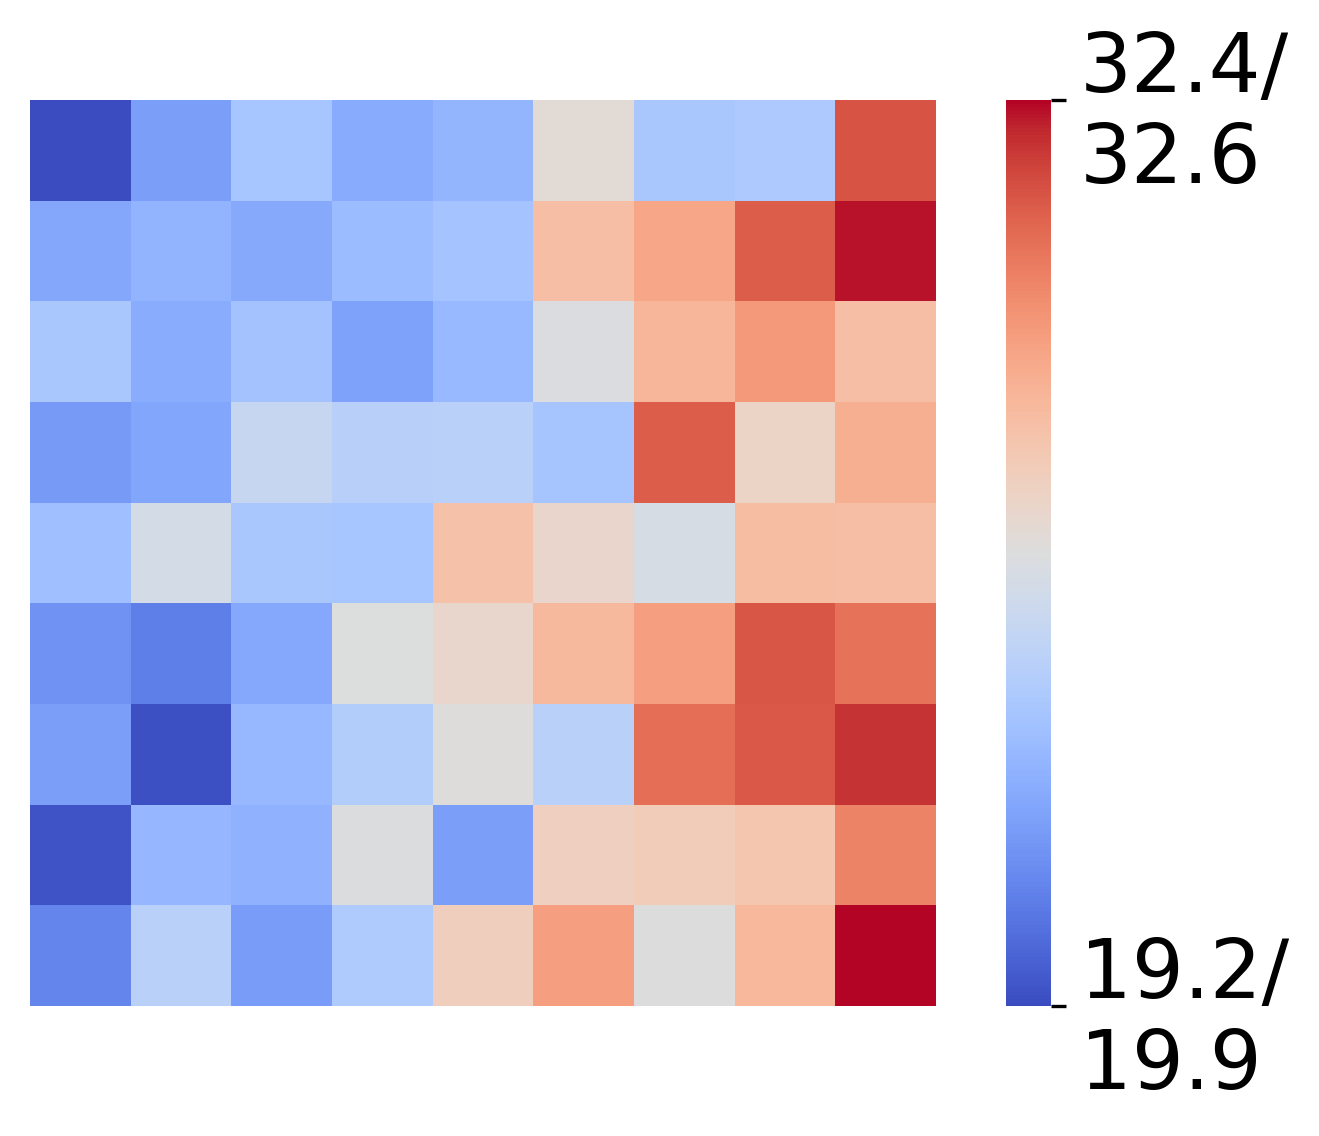

In [36]:
from human_utils_transdiagnostics import plot_td_quantile_analysis_results

#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), Y_res, np.stack(df["effs"].values), "Rewards", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), df['AD'] - AD_pred, np.stack(df["effs"].values), "Rewards", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Rewards", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Rewards", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=True, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Rewards", col2name="AD", groups = None, num_bins=9, combine_groups = False, annot=False, flip_leastmost=True)


In [37]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_rewards_AD.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_rewards_AD.svg"))

### AD Residual

PC1 loadings:  [0.72901262 0.68450026]
PC2 loadings:  [-0.68450026  0.72901262]
Variance explained by PC1:  0.6791482866096403
Variance explained by PC2:  0.3208517133903596
Flipped PC2 to enforce second component to be negative.
[[0.08185605 0.18437793 0.28350124 0.08633634 0.31173916 0.42812974
  0.3446511  0.50674061 0.80750912]
 [0.30257908 0.2190889  0.29249065 0.26800418 0.21766006 0.44073451
  0.50404783 0.53570737 0.70409926]
 [0.17016786 0.28243105 0.20039856 0.34431551 0.32990018 0.29537717
  0.44071721 0.43496146 0.50260168]
 [0.1226699  0.16297173 0.20183894 0.20616008 0.33278094 0.58896685
  0.61772256 0.69259352 0.56017654]
 [0.29680602 0.24645037 0.34141745 0.32701365 0.47525175 0.52132086
  0.72565884 0.61771103 0.69254739]
 [0.19750626 0.25795611 0.24212923 0.52563047 0.53714198 0.50694012
  0.54145736 0.6566186  0.90555071]
 [0.16729287 0.20325625 0.26371763 0.37308853 0.36157125 0.40906921
  0.55729578 0.82066629 0.51702278]
 [0.11116993 0.11259877 0.32127519 0.31551

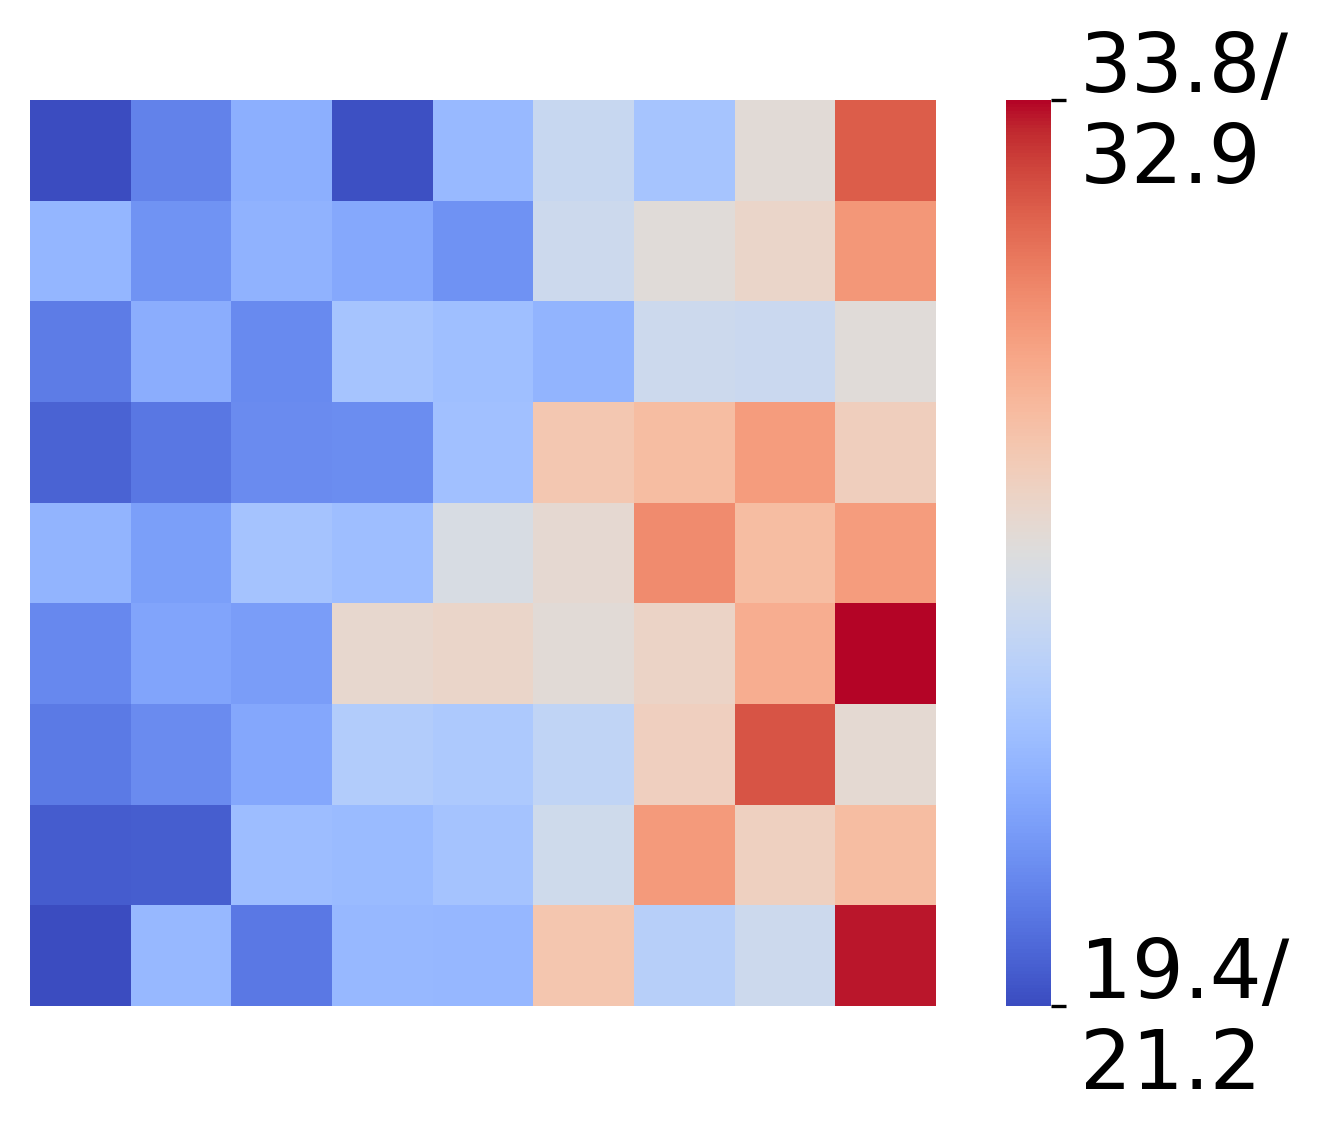

In [38]:
from human_utils_transdiagnostics import plot_td_quantile_analysis_results

quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), get_alternate_TD_representation(df['AD'], df['Compul'], method, np.stack(df['n_observes'].values).sum(axis=1))[0], np.stack(df["effs"].values), "Rewards", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), df['AD'] - AD_pred, np.stack(df["effs"].values), "Rewards", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)

In [39]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_rewards_AD_residual.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_rewards_AD_residual.svg"))

### Compul

[[0.30513766 0.3480686  0.48675905 0.13736857 0.51160383 0.42780305
  0.57954707 0.75075132 0.88658197]
 [0.21975855 0.18288082 0.24603323 0.41777608 0.40024689 0.61985995
  0.49762148 0.78976435 0.53327357]
 [0.35053824 0.31672459 0.22464197 0.38028554 0.67424776 0.44323367
  0.49680439 0.61334235 0.85780018]
 [0.18247228 0.42754293 0.31733741 0.35074251 0.33689022 0.57096838
  0.68076536 0.80239101 0.84639915]
 [0.1343978  0.23951563 0.27394208 0.41552909 0.31713314 0.43753316
  0.59235964 0.62088131 0.95069989]
 [0.32487637 0.29044991 0.35135532 0.33586886 0.47093826 0.64288538
  0.73312955 0.40594741 0.33016834]
 [0.26619885 0.18165519 0.42082106 0.58949983 0.32894271 0.6049863
  0.80402519 0.84762478 0.97860875]
 [0.20997259 0.25459355 0.38864159 0.43610325 0.54408088 0.56731059
  0.52328335 0.4996642  0.80157392]
 [0.06863027 0.31962114 0.1773596  0.34628306 0.32149045 0.58540263
  0.66510915 0.66106707 0.87896879]]


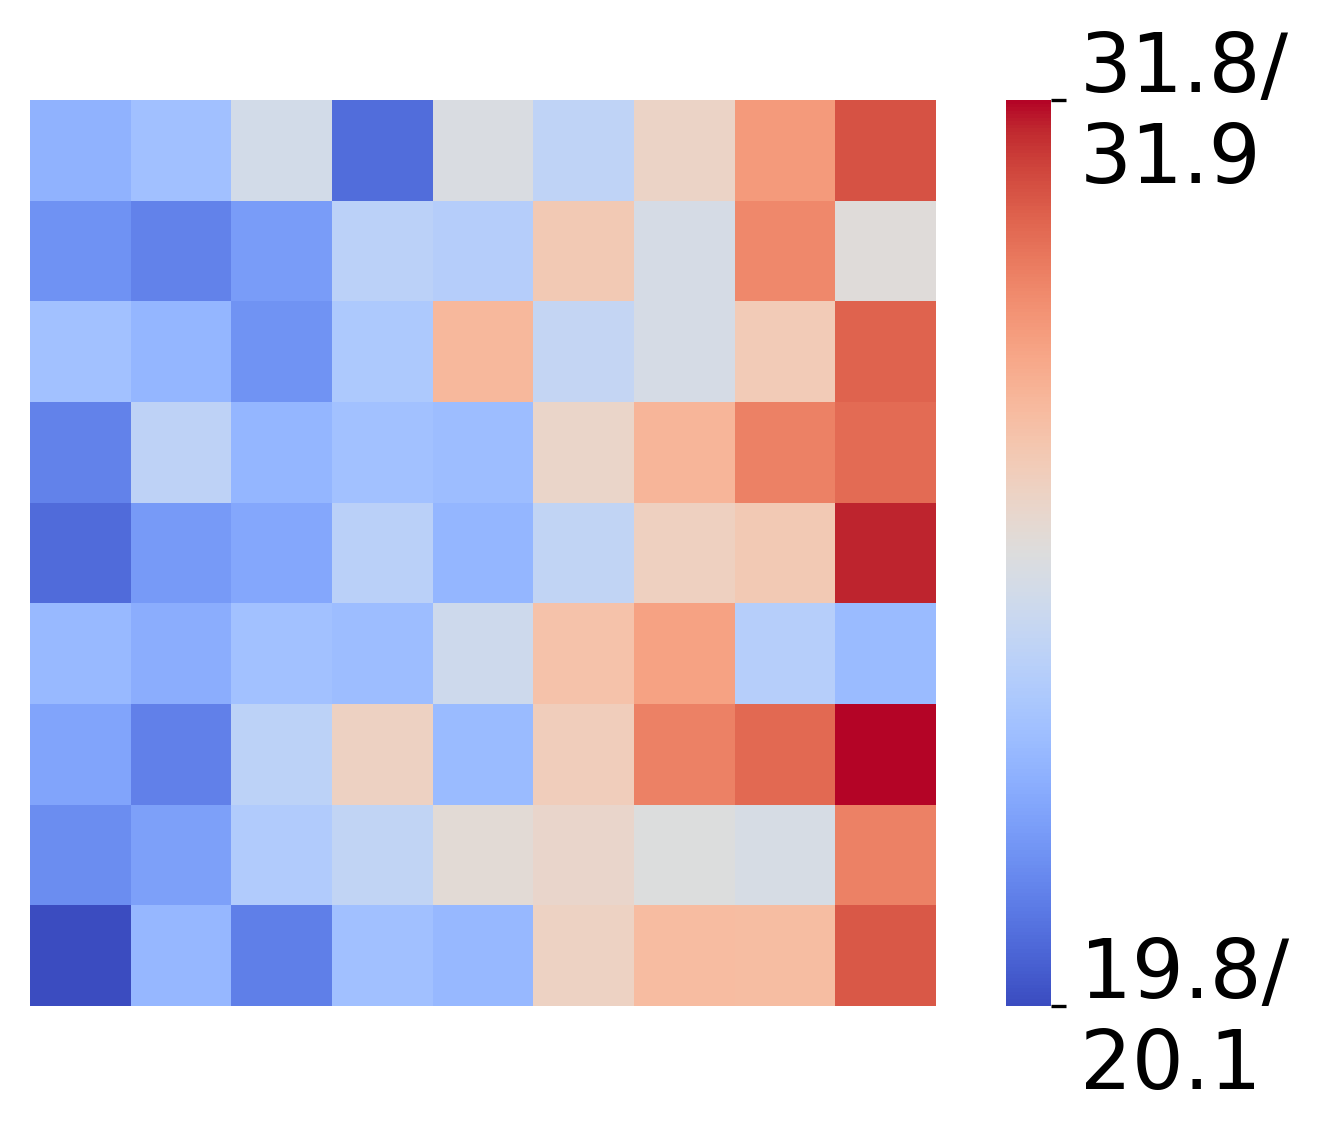

In [40]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Rewards", col2name = "Compul", groups = df["group"], num_bins =9, combine_groups = True, annot=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Rewards", col2name = "Compul", groups = None, num_bins =9, combine_groups = False, annot=False)

In [41]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_rewards_Compul.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_rewards_Compul.svg"))

### Compul Residual

PC1 loadings:  [0.72901262 0.68450026]
PC2 loadings:  [-0.68450026  0.72901262]
Variance explained by PC1:  0.6791482866096403
Variance explained by PC2:  0.3208517133903596
Flipped PC2 to enforce second component to be negative.
[[0.2190345  0.26134128 0.31027738 0.34200747 0.30811404 0.44316916
  0.5198376  0.57107634 0.61502786]
 [0.15630631 0.26050261 0.26232812 0.40085349 0.25606923 0.51292082
  0.55877193 0.40187293 0.55614035]
 [0.21666667 0.27927928 0.25727833 0.27565197 0.40064011 0.55471788
  0.61711712 0.53150782 0.74234234]
 [0.17285443 0.2592935  0.21688004 0.39722617 0.40670934 0.47939782
  0.62439545 0.63570413 0.91820768]
 [0.17972973 0.23971076 0.47112376 0.35016596 0.32897108 0.53290659
  0.50384068 0.57330488 0.76899004]
 [0.28191086 0.29201043 0.35844002 0.15267899 0.45275012 0.39196302
  0.6718587  0.78978189 0.76998578]
 [0.30734945 0.16154576 0.21183025 0.3281413  0.43477952 0.3963964
  0.55229967 0.41315789 0.45758653]
 [0.24091987 0.3194642  0.25303461 0.363892

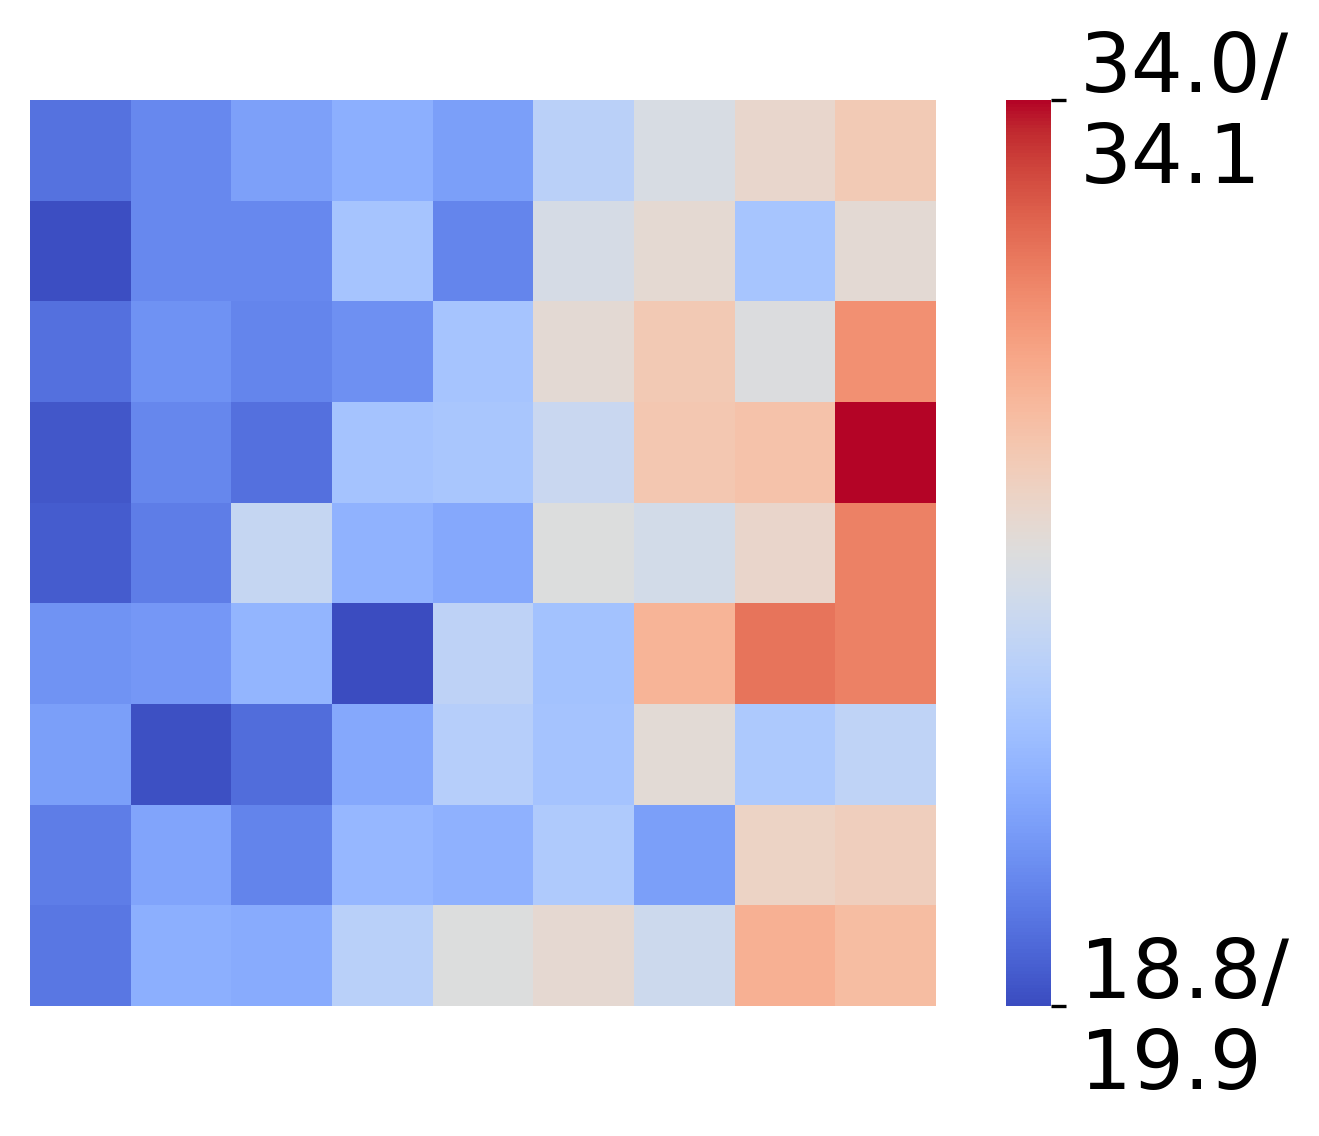

In [42]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), get_alternate_TD_representation(df['AD'], df['Compul'], method, np.stack(df['n_observes'].values).sum(axis=1))[1], np.stack(df["effs"].values), "Rewards", col2name = "Compul", groups = df["group"], num_bins =9, combine_groups = True, annot=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Rewards", col2name = "Compul", groups = None, num_bins =9, combine_groups = False, annot=False)

In [43]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_rewards_Compul_residual.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_rewards_Compul_residual.svg"))

### SW

[[0.16306306 0.25619369 0.29842342 0.32370495 0.26728604 0.44667793
  0.58384009 0.50495495 0.67083333]
 [0.27760618 0.27069659 0.27456564 0.28729891 0.38142696 0.48268179
  0.49754665 0.64803732 0.62061615]
 [0.11311937 0.20894466 0.31732625 0.39224582 0.42092986 0.45634653
  0.43431467 0.71839607 0.7224823 ]
 [0.20355534 0.10468951 0.21241956 0.13597973 0.24370978 0.29272844
  0.39029118 0.52974582 0.66272523]
 [0.15023327 0.22428411 0.12715573 0.12476673 0.36717342 0.47620656
  0.68967181 0.32701898 0.48524775]
 [0.16361808 0.31428571 0.34818211 0.30715894 0.39889801 0.45999839
  0.6482545  0.60184202 0.64934041]
 [0.28256113 0.25666023 0.32810489 0.40949968 0.32401866 0.46951416
  0.5208816  0.73156371 0.66550837]
 [0.15153636 0.29486004 0.30372426 0.46086712 0.5016731  0.54830277
  0.60549389 0.82699485 0.8962677 ]
 [0.1109985  0.19034347 0.20640953 0.40722598 0.43684309 0.63146584
  0.53443131 0.46612237 0.9492774 ]]


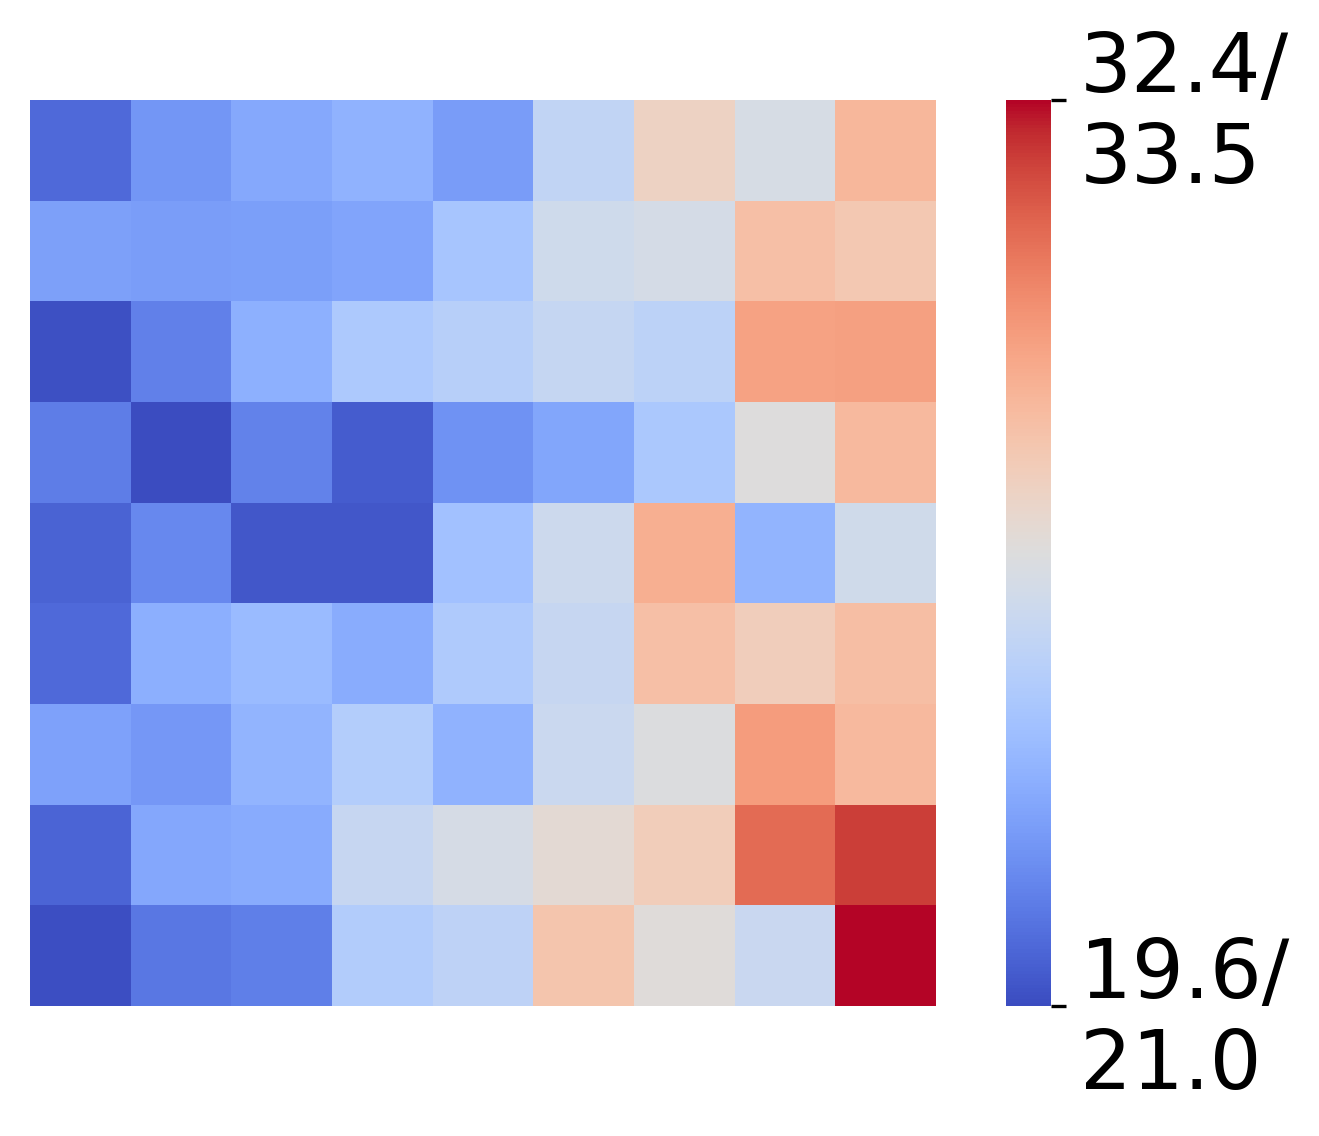

In [44]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), df['SW'], np.stack(df["effs"].values), "Observes", col2name = "SW", groups = df["group"], num_bins =9, combine_groups = True, annot=False, square=square, axes_off=axes_off)

In [45]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_rewards_SW.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_rewards_SW.svg"))

### Trait-level Simulations

In [46]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_anal import pepe_human_ape_models as ape_models
from settings_anal import trait_simulated_participants_folder_t1 as simulated_participants_folder
from settings_anal import trait_sim_timestamp_t1 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)

## flip to correct for switching from tau to efficacy
sim_obss = np.flip(sim_obss.T,axis=1)
sim_rewss = np.flip(sim_rewss.T, axis=1)

original_mag_perturbation = 1
with open(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'sim', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_sim_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

[[24.94582353 24.93676471 25.03235294 25.02276471 25.18758824 25.26894118
  25.64905882 26.38364706 27.67235294]
 [24.85358824 24.89117647 24.95611765 25.05394118 25.27911765 25.64552941
  26.55111765 28.09782353 29.88888235]
 [24.78425    24.788375   24.9821875  25.1943125  25.5800625  26.4461875
  27.862375   29.4446875  30.861125  ]
 [24.68141176 24.71435294 24.91452941 25.17629412 25.79476471 26.86847059
  28.41070588 29.72129412 30.94988235]
 [24.659      24.7496875  24.935125   25.2566875  26.0315     27.1594375
  28.501      29.76675    30.969625  ]
 [24.55694118 24.67247059 24.83658824 25.34711765 26.21482353 27.37564706
  28.51035294 29.75129412 31.02635294]
 [24.489875   24.536375   24.778875   25.275125   26.2945     27.372125
  28.5709375  29.6965     30.947     ]
 [23.99611765 24.05635294 24.49594118 25.18070588 26.18347059 27.29494118
  28.42776471 29.60917647 30.80223529]
 [22.64935294 23.12429412 23.834      24.83817647 25.89464706 26.93047059
  28.04082353 29.16711765 

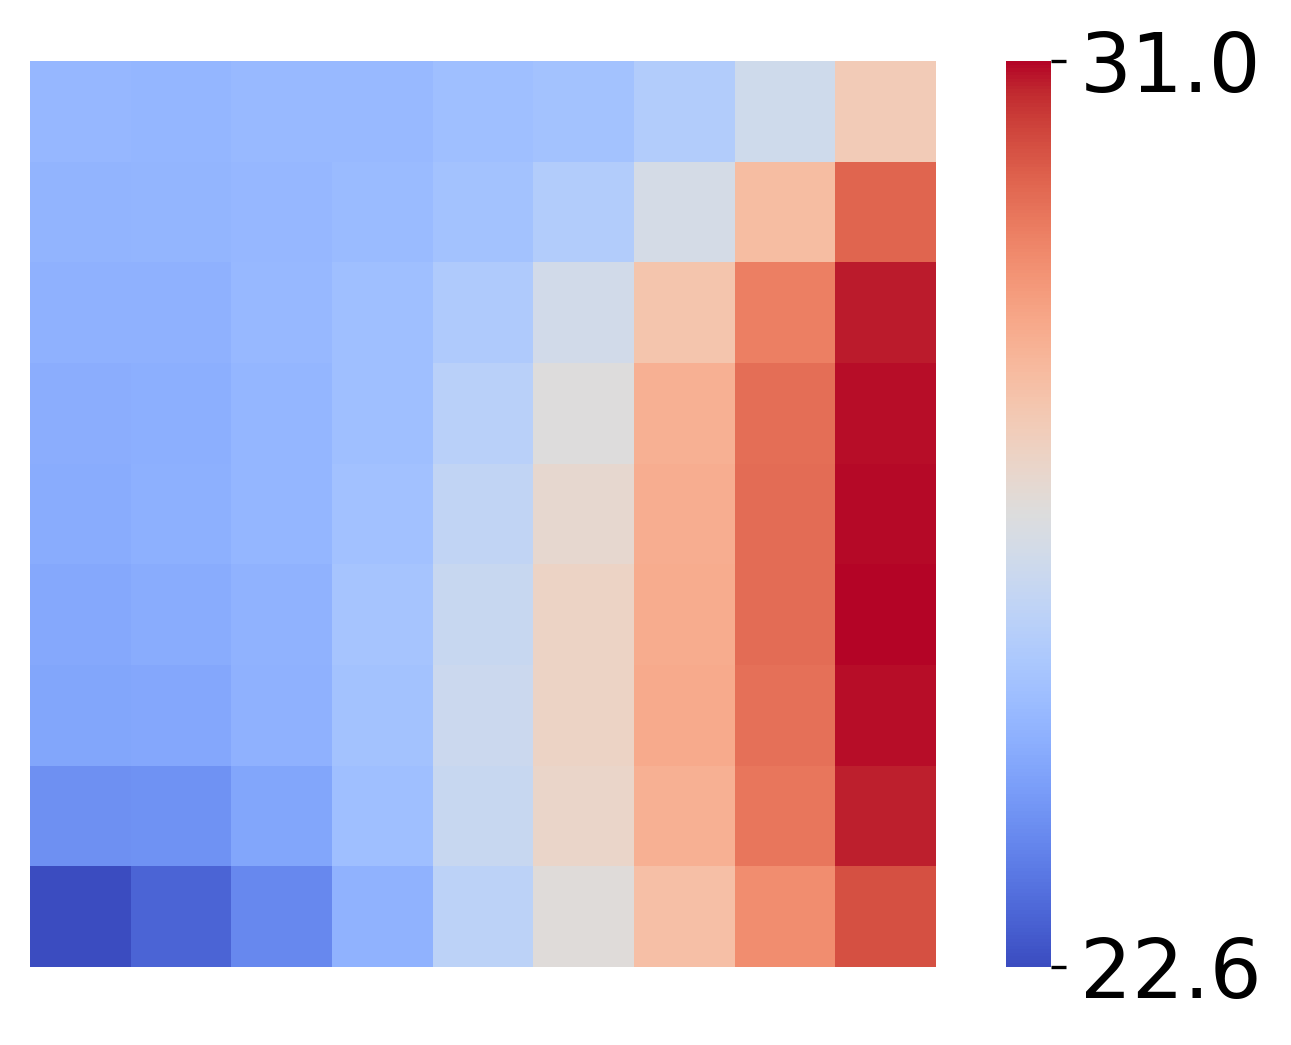

In [47]:
quantile_fig = plot_td_quantile_analysis_results(sim_rewss, sim_participant_perturbations, effs, "Rewards", col2name = "Belief", groups = None, num_bins =9, annot=False, square=square, axes_off=axes_off)

In [48]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_rewards_NN.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_rewards_NN.svg"))

### Permuted Simulations

In [49]:
from human_utils_behavioral_analysis import load_simulated_participants_across_models
from settings_anal import pepe_human_ape_models as ape_models
#from settings_anal import trait_simulated_participants_folder_t1 as simulated_participants_folder
from settings_anal import zeros_simulated_participants_folder_t1 as simulated_participants_folder
from settings_anal import zeros_sim_timestamp_t1 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)

## flip to correct for switching from tau to efficacy
sim_obss = np.flip(sim_obss.T,axis=1)
sim_rewss = np.flip(sim_rewss.T, axis=1)

original_mag_perturbation = 1
with open(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'nostruc', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_nostruc_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy


[[24.69637333 24.77618    24.9282     25.22768    25.89856    27.07694
  28.43838    29.73052    30.98757333]
 [24.69637333 24.77618    24.9282     25.22768    25.89856    27.07694
  28.43838    29.73052    30.98757333]
 [24.69637333 24.77618    24.9282     25.22768    25.89856    27.07694
  28.43838    29.73052    30.98757333]
 [24.69637333 24.77618    24.9282     25.22768    25.89856    27.07694
  28.43838    29.73052    30.98757333]
 [24.69637333 24.77618    24.9282     25.22768    25.89856    27.07694
  28.43838    29.73052    30.98757333]
 [24.69637333 24.77618    24.9282     25.22768    25.89856    27.07694
  28.43838    29.73052    30.98757333]
 [24.69637333 24.77618    24.9282     25.22768    25.89856    27.07694
  28.43838    29.73052    30.98757333]
 [24.69637333 24.77618    24.9282     25.22768    25.89856    27.07694
  28.43838    29.73052    30.98757333]
 [24.69637333 24.77618    24.9282     25.22768    25.89856    27.07694
  28.43838    29.73052    30.98757333]]


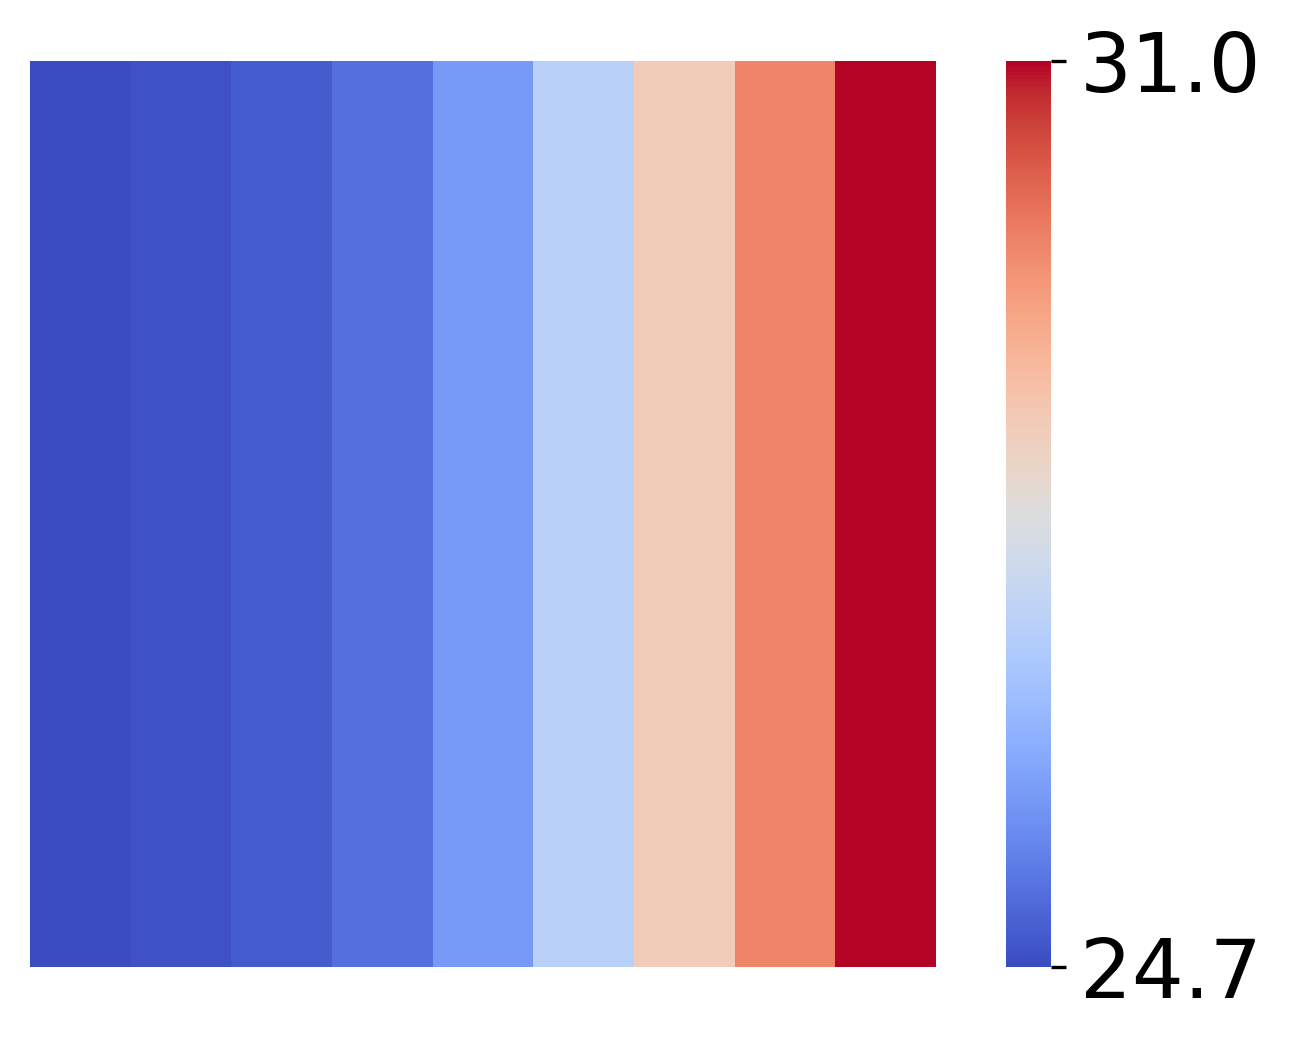

In [50]:
quantile_fig = plot_td_quantile_analysis_results(sim_rewss, sim_participant_perturbations, effs, "Reserves", col2name = "Belief", groups = None, num_bins =9, annot=False, square=square, axes_off=axes_off)

In [51]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_rewards_NN_permuted.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_rewards_NN_permuted.svg"))

## Panel B.2: Task 1 Estimates
### AD

In [52]:
human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

mask = 'nomask'
iday = 2
day = 'day%d' %iday
exp_date = '24-01-22-29'
#exp_date = '518-525-619-706'
with_nets = False
include_sleep = False
include_estimates = False
group = None
#group = "groupA"

analysis_folder = os.path.join('panels', 'fig_transdiags')

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)


[[0.11156881 0.27913547 0.27988505 0.4458185  0.45324093 0.52217383
  0.58856172 0.63343188 0.7207894 ]
 [0.19200333 0.15695036 0.19923966 0.36845233 0.37111003 0.38152484
  0.57264454 0.65880341 0.83840869]
 [0.12484451 0.22960046 0.19570943 0.35031371 0.38982065 0.47739076
  0.57357939 0.61717747 0.76074371]
 [0.16993835 0.41551831 0.31740875 0.39371372 0.58360916 0.61241188
  0.60212172 0.81697804 0.84200124]
 [0.0071851  0.1772592  0.23305726 0.31420124 0.5509868  0.61780071
  0.66054846 0.79580778 0.88035734]
 [0.13996259 0.2629818  0.31623571 0.49733675 0.44828752 0.53450871
  0.6763299  0.83141056 0.9784447 ]
 [0.14363966 0.23820789 0.37012396 0.42468665 0.4676726  0.57400456
  0.63544074 0.71143409 0.78110377]
 [0.11023612 0.22476144 0.26458    0.43910808 0.39346443 0.47707914
  0.61580636 0.76210372 0.76508414]
 [0.09207402 0.18843127 0.27713301 0.41866436 0.41661153 0.5231582
  0.55804042 0.76500133 0.90247739]]


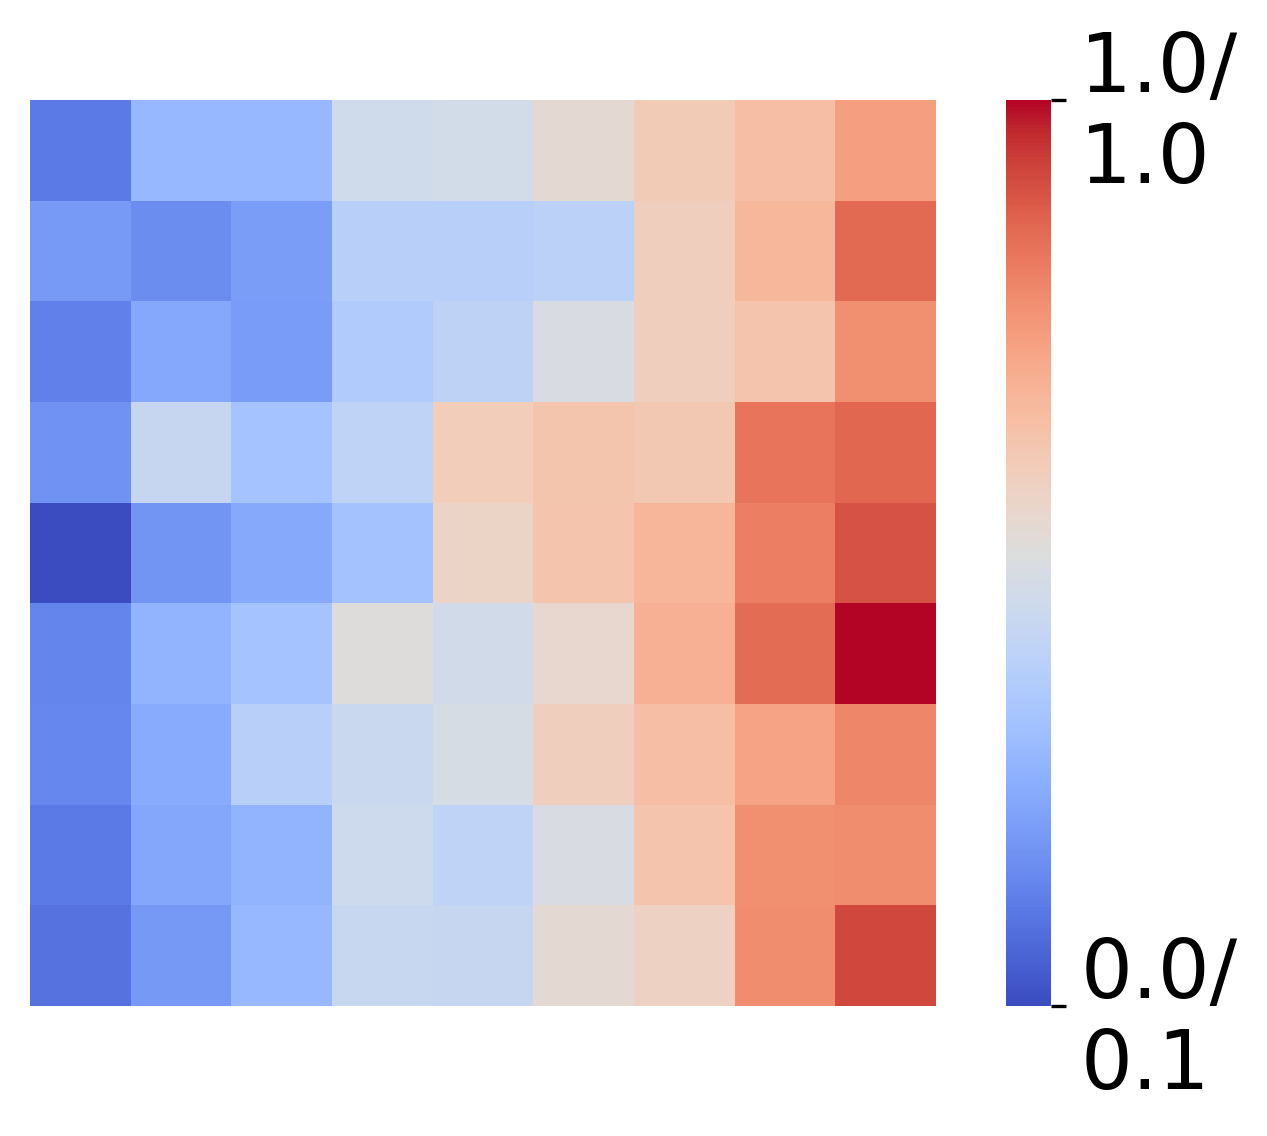

In [53]:
from human_utils_transdiagnostics import plot_td_quantile_analysis_results

#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['efficacy_estimates'].values).squeeze(), df['AD'] - AD_pred, np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['efficacy_estimates'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_resultstack(df['efficacy_estimates'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=True, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = False, annot=False, flip_leastmost=True)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Observes", col2name="AD", groups = None, num_bins=9, combine_groups = False, annot=False, flip_leastmost=True)

In [54]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_estimates_AD.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_estimates_AD.svg"))

### AD Residual

PC1 loadings:  [0.72901262 0.68450026]
PC2 loadings:  [-0.68450026  0.72901262]
Variance explained by PC1:  0.6791482866096403
Variance explained by PC2:  0.3208517133903596
Flipped PC2 to enforce second component to be negative.
[[0.10356015 0.2620231  0.31715421 0.34799394 0.43087683 0.50898238
  0.70129893 0.71442992 0.85572188]
 [0.20096555 0.18673838 0.25691867 0.51703416 0.44856088 0.49596379
  0.53030576 0.70233919 0.83958762]
 [0.13339139 0.3311319  0.23229314 0.33713897 0.47067804 0.5537086
  0.64651205 0.77509083 0.93262997]
 [0.04937704 0.21289502 0.27356953 0.39111796 0.41317866 0.50284175
  0.54286068 0.70661756 0.72413277]
 [0.1517145  0.23249727 0.27323942 0.36442708 0.55466417 0.59375576
  0.72670413 0.77640474 0.94004217]
 [0.17140797 0.16698192 0.19869608 0.28776194 0.51075343 0.59940449
  0.67959657 0.75650061 0.91574675]
 [0.1003351  0.30470814 0.25727701 0.4933642  0.51069697 0.59567343
  0.64630139 0.76322436 0.788749  ]
 [0.09833274 0.3067105  0.37258419 0.548418

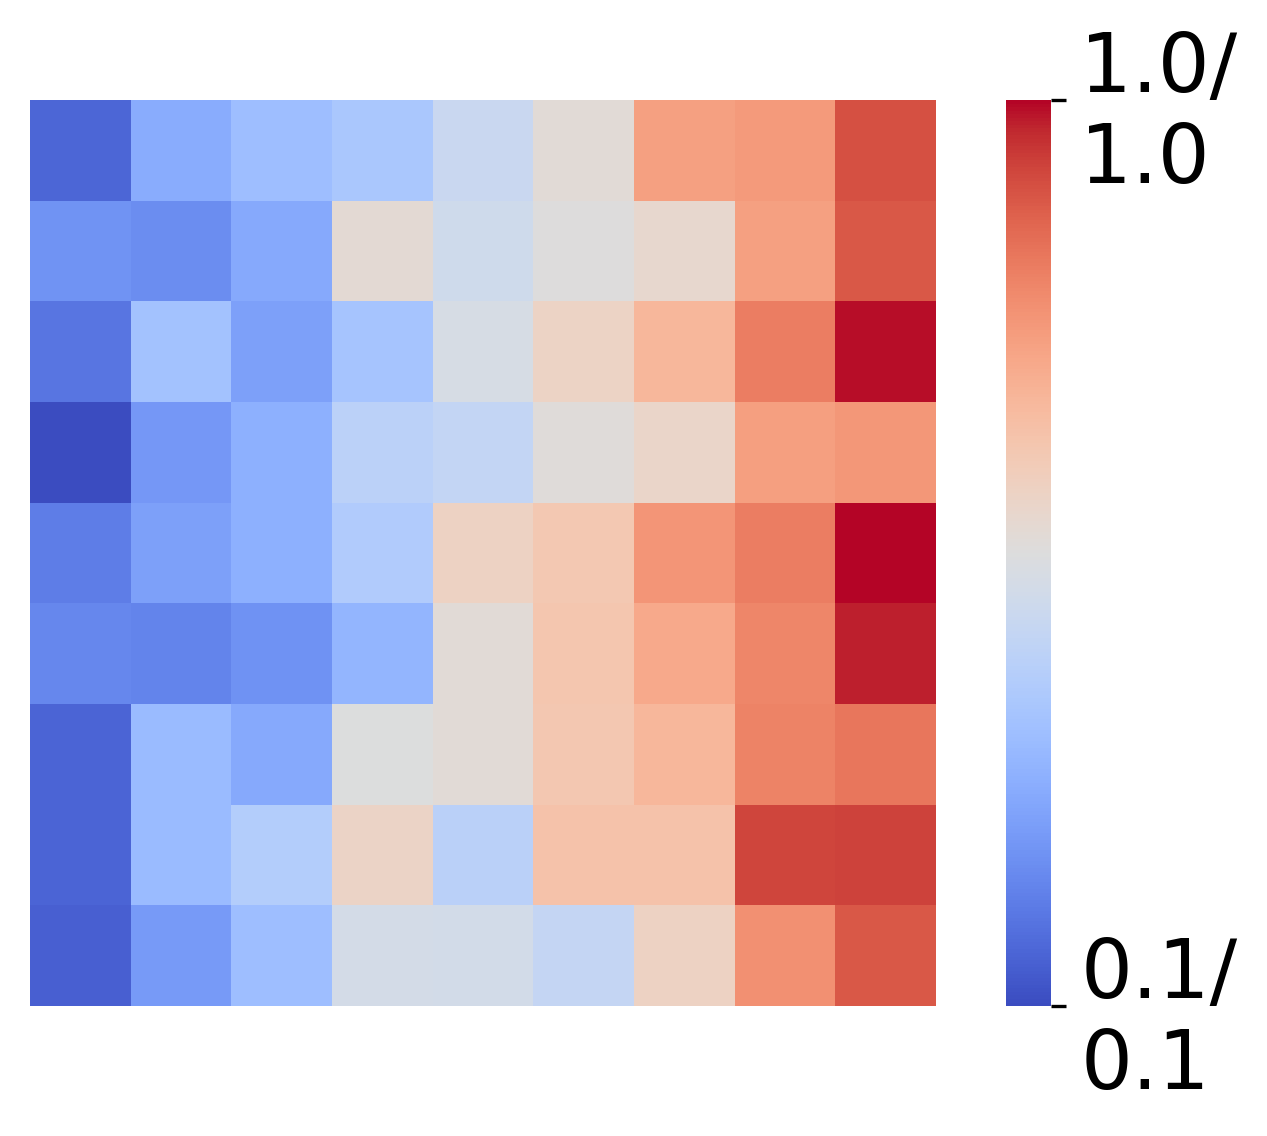

In [55]:
from human_utils_transdiagnostics import plot_td_quantile_analysis_results

quantile_fig = plot_td_quantile_analysis_results(np.stack(df['efficacy_estimates'].values).squeeze(), get_alternate_TD_representation(df['AD'], df['Compul'], method, np.stack(df['n_observes'].values).sum(axis=1))[0], np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['efficacy_estimates'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_resultstack(df['efficacy_estimates'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=True, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = False, annot=False, flip_leastmost=True)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Observes", col2name="AD", groups = None, num_bins=9, combine_groups = False, annot=False, flip_leastmost=True)

In [56]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_estimates_AD_residual.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_estimates_AD_residual.svg"))

### Compul

[[0.05574067 0.17365199 0.2724758  0.26775112 0.40997865 0.52685849
  0.69755986 0.82332199 0.98946404]
 [0.16128242 0.40209078 0.40240124 0.51471163 0.57177745 0.63987755
  0.66722201 0.75821528 0.95286158]
 [0.26243594 0.31523041 0.28314006 0.52894744 0.54475138 0.60069004
  0.62771612 0.83320883 0.90964792]
 [0.0849086  0.09212043 0.1632342  0.32476974 0.3978847  0.55377654
  0.62545389 0.63561413 0.76222558]
 [0.         0.28155608 0.20988666 0.46360789 0.4486859  0.54776504
  0.71456857 0.81778061 0.86744674]
 [0.14210494 0.29967959 0.21133219 0.36841645 0.42201971 0.52668521
  0.6121653  0.66722201 0.80536606]
 [0.09399902 0.12378565 0.2991892  0.27993061 0.43006407 0.54789556
  0.61693496 0.81014364 0.80819979]
 [0.14800175 0.19589605 0.30293846 0.50567855 0.56292431 0.52254438
  0.69330879 0.79902826 0.92670954]
 [0.10617233 0.31386894 0.32992747 0.49260353 0.41172155 0.42825518
  0.43525814 0.69610049 0.75092731]]


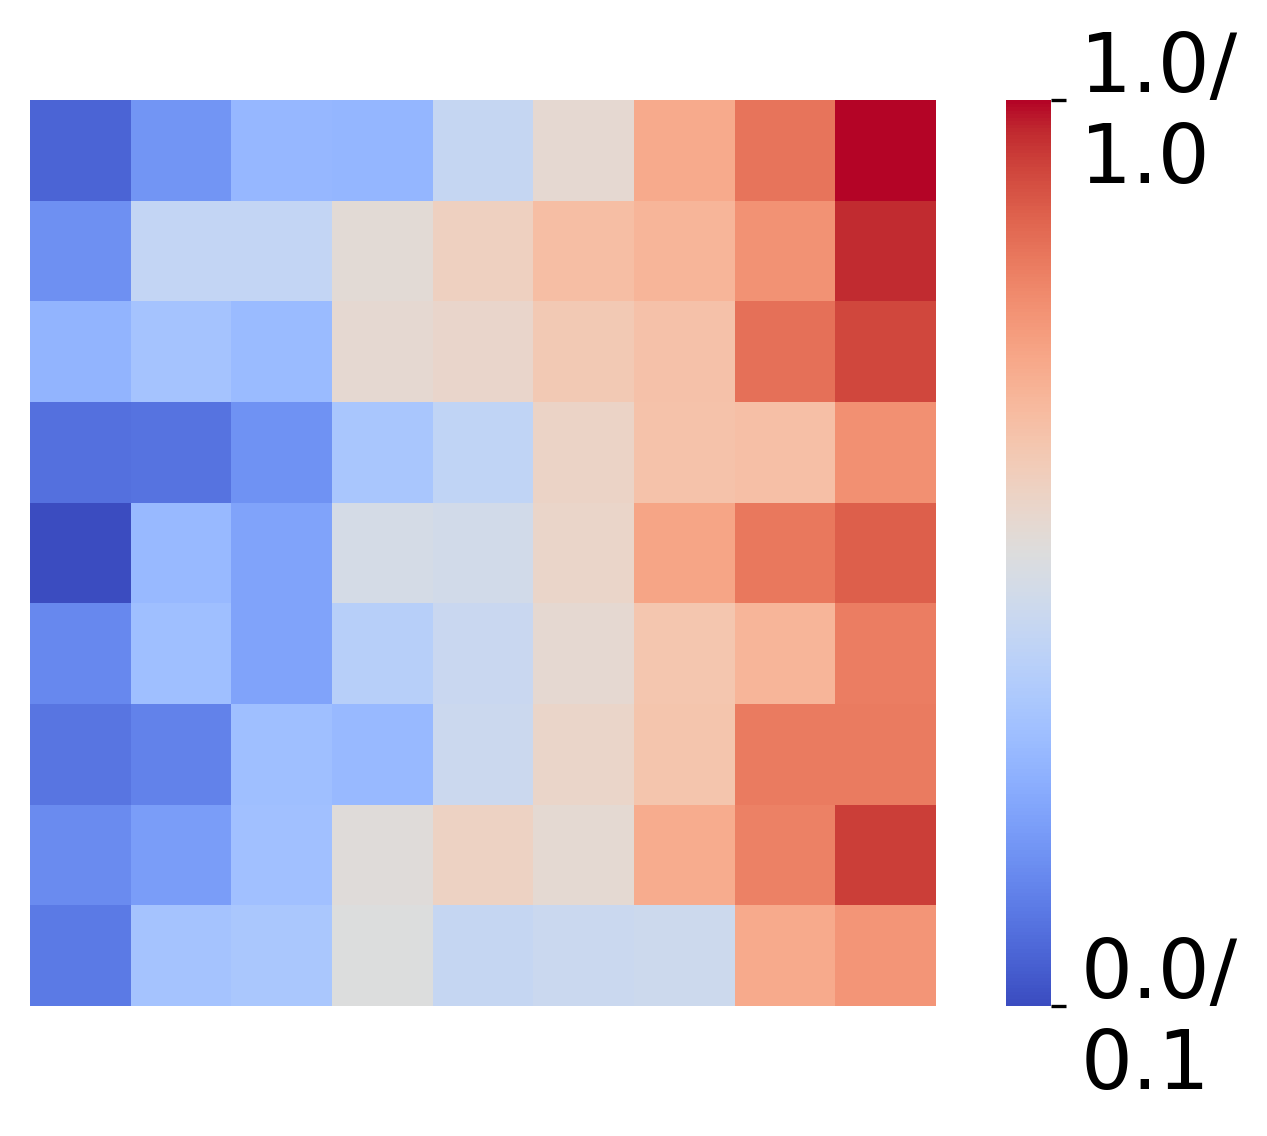

In [57]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['efficacy_estimates'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = df["group"], num_bins =9, combine_groups = True, annot=False , square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = df["group"], num_bins =9, combine_groups = False, annot=False)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = None, num_bins =9, combine_groups = False, annot=False)

In [58]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_estimates_Compul.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_estimates_Compul.svg"))

### Compul Residual

PC1 loadings:  [0.72901262 0.68450026]
PC2 loadings:  [-0.68450026  0.72901262]
Variance explained by PC1:  0.6791482866096403
Variance explained by PC2:  0.3208517133903596
Flipped PC2 to enforce second component to be negative.
[[0.14319979 0.2698936  0.22652539 0.4197108  0.45425443 0.51023539
  0.49240723 0.68577163 0.75981784]
 [0.16016644 0.13009701 0.24921508 0.28224579 0.31229174 0.39832041
  0.47087131 0.58939783 0.64225377]
 [0.05534305 0.31789388 0.25533835 0.47164127 0.4589933  0.48470472
  0.51984342 0.61783344 0.79331334]
 [0.22700955 0.31917323 0.35645514 0.55275559 0.51476241 0.44062465
  0.62913163 0.74834477 0.84602726]
 [0.05968932 0.29456276 0.2899794  0.39711266 0.52054179 0.54033181
  0.7341921  0.78232267 0.84802845]
 [0.16605262 0.21757053 0.25011532 0.34532245 0.43843332 0.57524516
  0.68905804 0.71346663 0.84722328]
 [0.04772798 0.23605772 0.21863626 0.30911801 0.43867041 0.68498407
  0.64026432 0.82621377 0.88403218]
 [0.07947934 0.1705057  0.26726448 0.46253

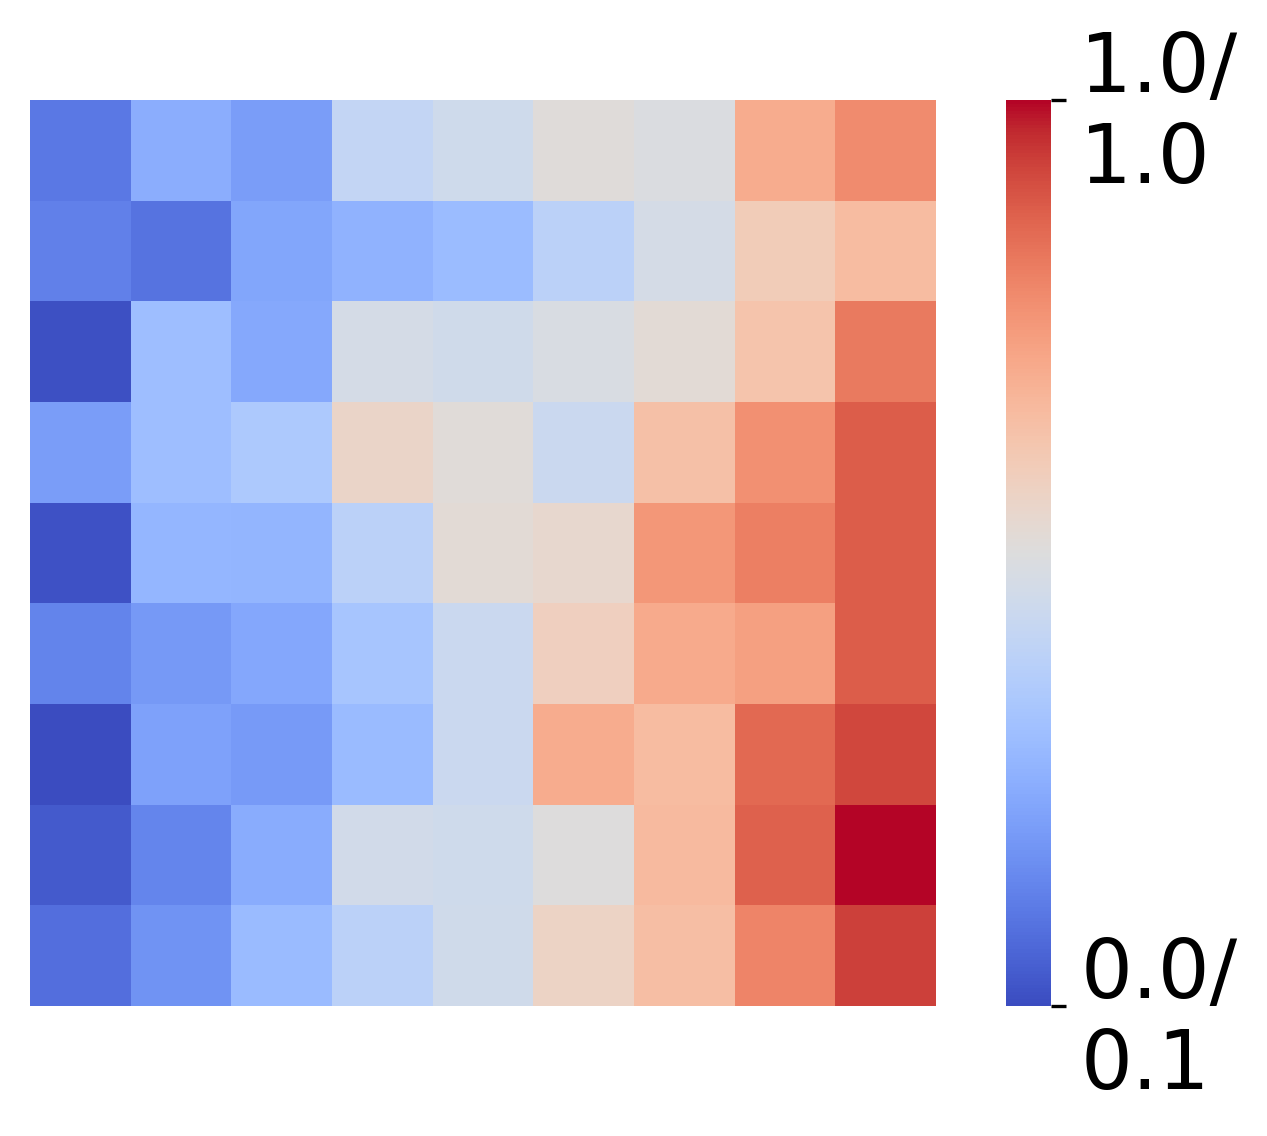

In [59]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['efficacy_estimates'].values).squeeze(), get_alternate_TD_representation(df['AD'], df['Compul'], method, np.stack(df['n_observes'].values).sum(axis=1))[1], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = df["group"], num_bins =9, combine_groups = True, annot=False , square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = df["group"], num_bins =9, combine_groups = False, annot=False)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = None, num_bins =9, combine_groups = False, annot=False)

In [60]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_estimates_Compul_residual.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_estimates_Compul_residual.svg"))

### SW

[[0.10600393 0.26897677 0.28641175 0.43629377 0.50968218 0.56927203
  0.66001659 0.7314     0.81067834]
 [0.1540492  0.29003473 0.27402845 0.317507   0.34586401 0.52395225
  0.62483275 0.74454958 0.95800526]
 [0.16228515 0.31083734 0.32485183 0.44827069 0.59599738 0.6335598
  0.69571798 0.91281008 0.91281008]
 [0.07973074 0.16407374 0.22059095 0.42223349 0.44091948 0.46028065
  0.57848404 0.71769324 0.87984081]
 [0.07967151 0.19017655 0.2057637  0.32409831 0.50726442 0.59262975
  0.66192956 0.72813692 0.83884515]
 [0.11194011 0.18282534 0.2368724  0.42058885 0.38948015 0.56131786
  0.62937941 0.81151046 0.93602999]
 [0.11084581 0.32369193 0.32286005 0.5253937  0.5384451  0.61522734
  0.63871603 0.75155364 0.9191982 ]
 [0.11311277 0.25857888 0.26241849 0.40671194 0.52484336 0.533708
  0.70724957 0.81013461 0.85017355]
 [0.07710554 0.19083744 0.33692823 0.47558048 0.39911259 0.46735137
  0.58417361 0.78533355 0.85484847]]


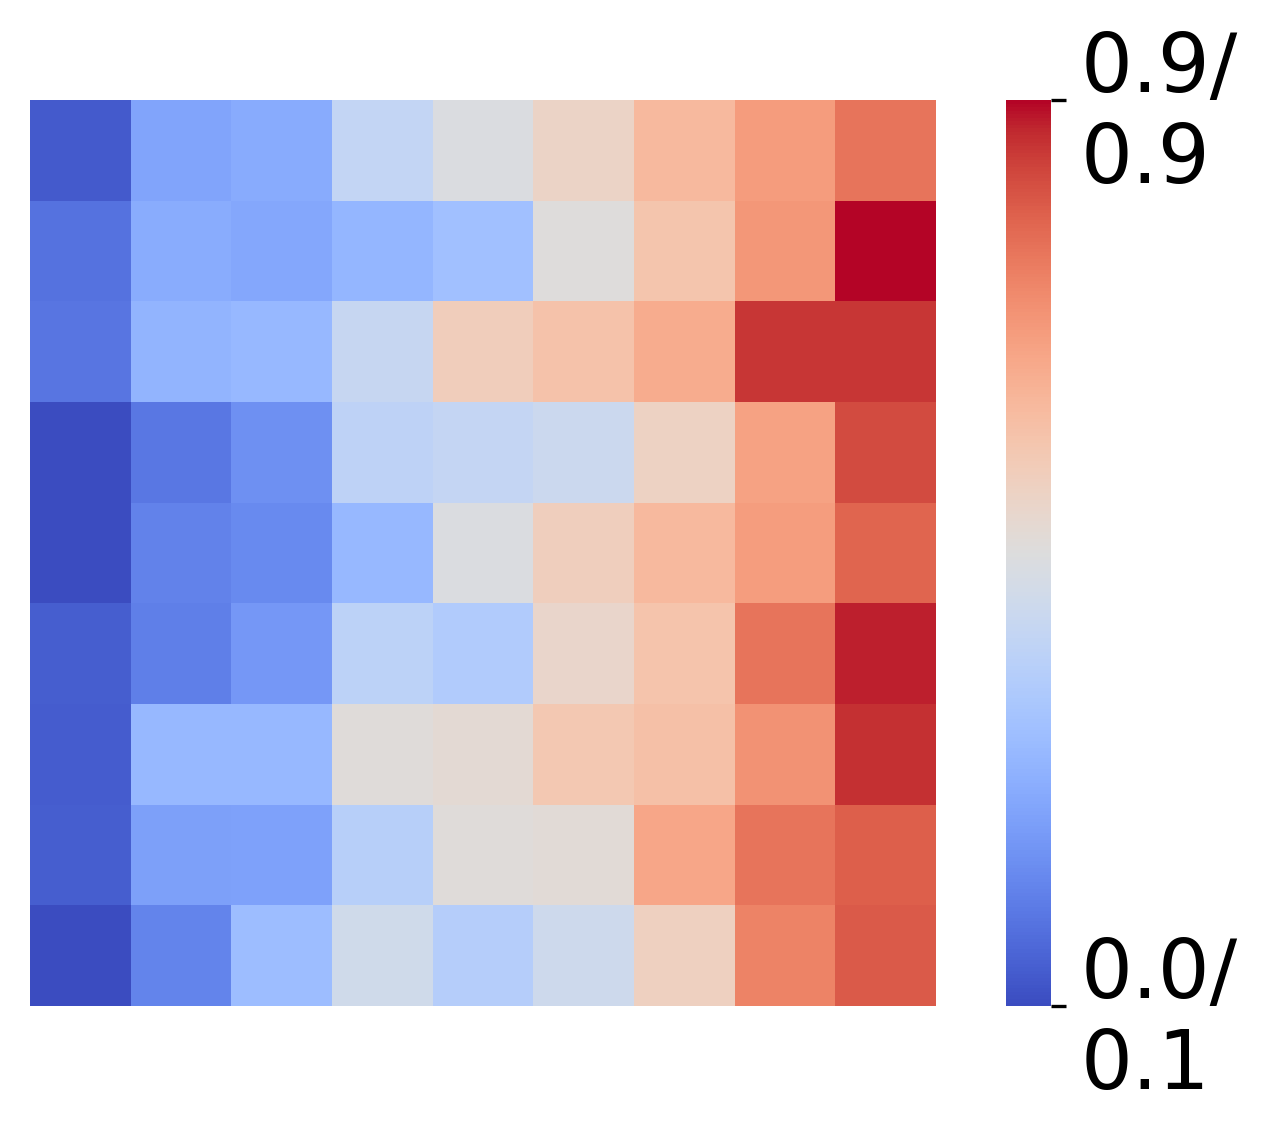

In [61]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['efficacy_estimates'].values).squeeze(), df['SW'], np.stack(df["effs"].values), "Observes", col2name = "SW", groups = df["group"], num_bins =9, combine_groups = True, annot=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['SW'], np.stack(df["effs"].values), "Observes", col2name = "SW", groups = None, num_bins =9, combine_groups = False, annot=False)

In [62]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_estimates_SW.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_estimates_SW.svg"))

### Trait-level Simulations

In [63]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_anal import pepe_human_ape_models as ape_models
from settings_anal import trait_simulated_participants_folder_t1 as simulated_participants_folder
from settings_anal import trait_sim_timestamp_t1 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)

## flip to correct for switching from tau to efficacy
sim_obss = np.flip(sim_obss.T,axis=1)
sim_rewss = np.flip(sim_rewss.T, axis=1)

original_mag_perturbation = 1
with open(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'sim', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_sim_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

### CONSTRUCT SIM_ESTS
sim_estss = (np.tile(np.arange(0, 1.01, 0.125), (len(sim_participant_perturbations),1)).T + sim_participant_perturbations).T

In [64]:
print(sim_estss.shape)

(150, 9)


[[-1.49811700e+00 -1.37311700e+00 -1.24811700e+00 -1.12311700e+00
  -9.98116997e-01 -8.73116997e-01 -7.48116997e-01 -6.23116997e-01
  -4.98116997e-01]
 [-8.75884021e-01 -7.50884021e-01 -6.25884021e-01 -5.00884021e-01
  -3.75884021e-01 -2.50884021e-01 -1.25884021e-01 -8.84021437e-04
   1.24115979e-01]
 [-3.68295907e-01 -2.43295907e-01 -1.18295907e-01  6.70409255e-03
   1.31704093e-01  2.56704093e-01  3.81704093e-01  5.06704093e-01
   6.31704093e-01]
 [-1.16213872e-01  8.78612833e-03  1.33786128e-01  2.58786128e-01
   3.83786128e-01  5.08786128e-01  6.33786128e-01  7.58786128e-01
   8.83786128e-01]
 [ 8.28346463e-02  2.07834646e-01  3.32834646e-01  4.57834646e-01
   5.82834646e-01  7.07834646e-01  8.32834646e-01  9.57834646e-01
   1.08283465e+00]
 [ 3.10472949e-01  4.35472949e-01  5.60472949e-01  6.85472949e-01
   8.10472949e-01  9.35472949e-01  1.06047295e+00  1.18547295e+00
   1.31047295e+00]
 [ 5.36506848e-01  6.61506848e-01  7.86506848e-01  9.11506848e-01
   1.03650685e+00  1.1615068

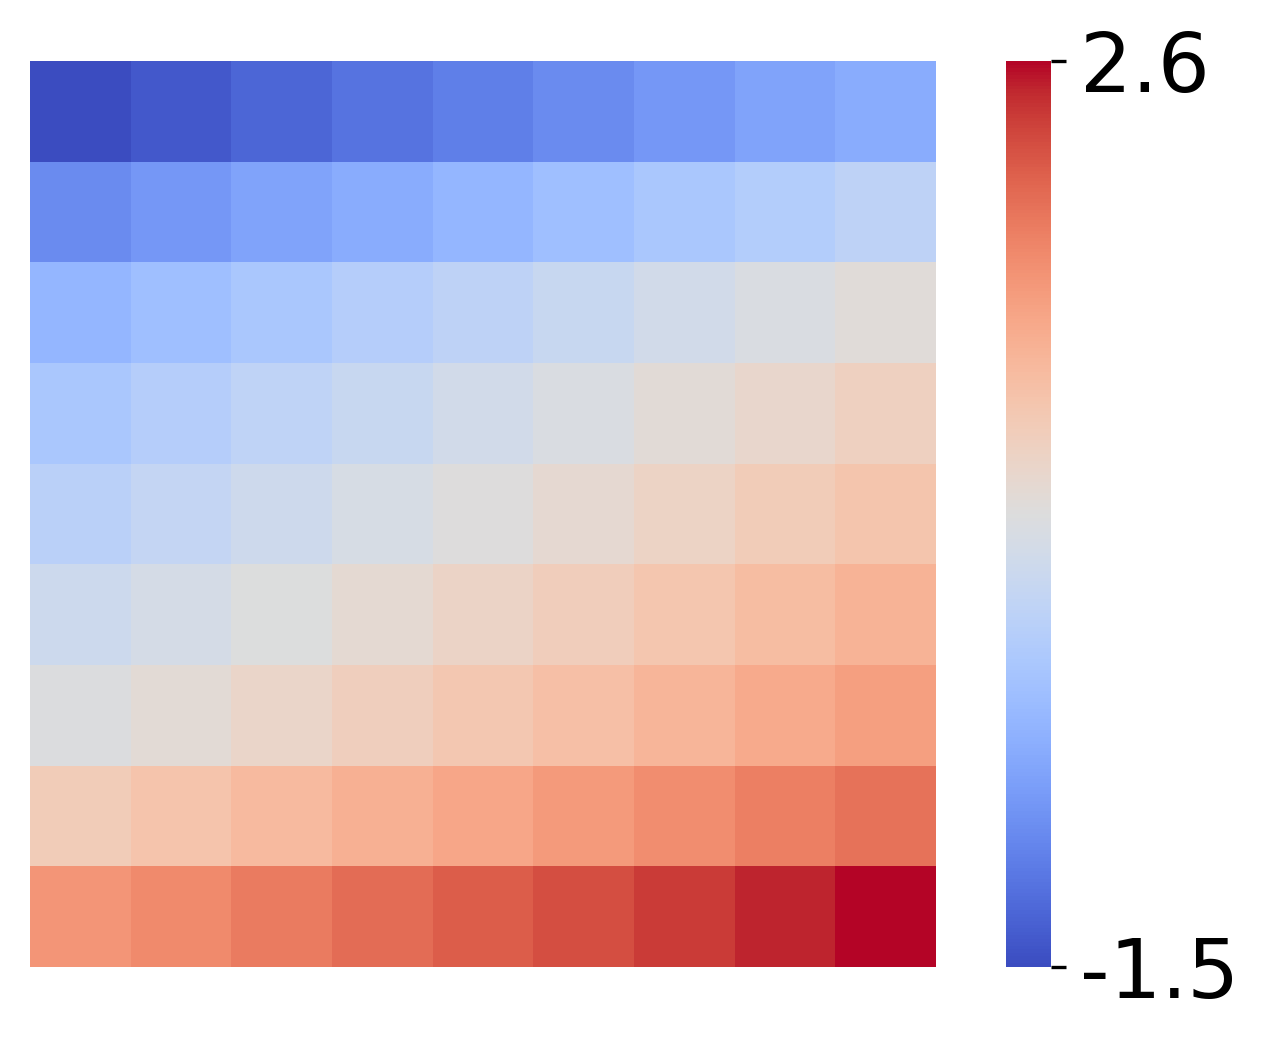

In [65]:
quantile_fig = plot_td_quantile_analysis_results(sim_estss, sim_participant_perturbations, effs, "Rewards", col2name = "Belief", groups = None, num_bins =9, annot=False, square=square, axes_off=axes_off)

In [66]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_estimates_NN.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_estimates_NN.svg"))

### Permuted Simulations

In [67]:
from human_utils_behavioral_analysis import load_simulated_participants_across_models
from settings_anal import pepe_human_ape_models as ape_models
#from settings_anal import trait_simulated_participants_folder_t1 as simulated_participants_folder
from settings_anal import zeros_simulated_participants_folder_t1 as simulated_participants_folder
from settings_anal import zeros_sim_timestamp_t1 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)

## flip to correct for switching from tau to efficacy
sim_obss = np.flip(sim_obss.T,axis=1)
sim_rewss = np.flip(sim_rewss.T, axis=1)

original_mag_perturbation = 1
with open(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'nostruc', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_nostruc_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

sim_estss = np.tile(np.arange(0, 1.01, 0.125), (len(sim_participant_perturbations),1)).T + sim_participant_perturbations
sim_estss = sim_estss.T

[[0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
 [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
 [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
 [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
 [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
 [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
 [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
 [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
 [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]]


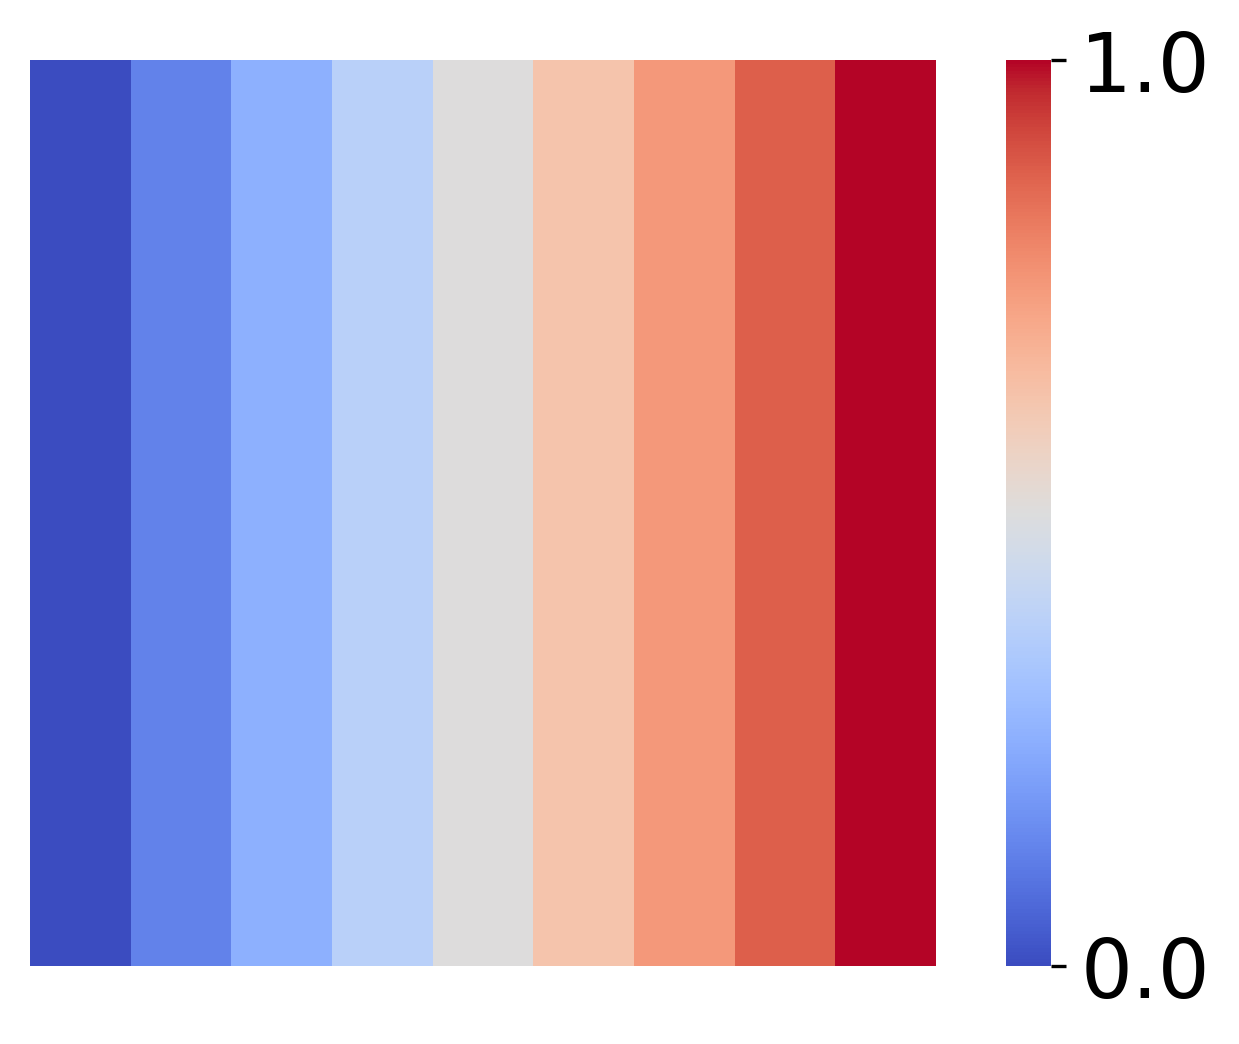

In [68]:
quantile_fig = plot_td_quantile_analysis_results(sim_estss, sim_participant_perturbations, effs, "Reserves", col2name = "Belief", groups = None, num_bins =9, annot=False, square=square, axes_off=axes_off)

In [69]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_estimates_NN_permuted.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_estimates_NN_permuted.svg"))

## Panel C: Task 2 Sleeps
### AD

In [70]:
human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

mask = 'nomask'
iday = 3
day = 'day%d' %iday
exp_date = '24-01-22-29'
#exp_date = '518-525-619-706'
with_nets = False
include_sleep = False
include_estimates = False
group = None
#group = "groupA"

analysis_folder = os.path.join('panels', 'fig_transdiags')

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)


[[0.55082877 0.57354503 0.35095954 0.44336848 0.25102493 0.23531971
  0.1365536  0.04648168 0.07555511]
 [0.69785915 0.5444915  0.46600518 0.44976543 0.36898189 0.2725329
  0.17665823 0.10694566 0.06741534]
 [0.46485656 0.62699797 0.53399482 0.54736303 0.4933159  0.29984362
  0.28992126 0.27425582 0.29049556]
 [0.77044325 0.52177523 0.50955564 0.42417763 0.28647542 0.20396895
  0.21906007 0.20396895 0.12088817]
 [0.56360277 0.59911294 0.52120092 0.49274159 0.3829244  0.31436044
  0.20396895 0.23070536 0.09415176]
 [0.73968669 0.71237597 0.47879908 0.47937338 0.42532625 0.3317488
  0.31550906 0.2079891  0.1231854 ]
 [0.8128451  0.47765046 0.57811959 0.43524861 0.27368152 0.20626617
  0.15221904 0.02788503 0.09587468]
 [0.89075712 0.93028743 0.75592643 0.6298695  0.53456913 0.54908595
  0.24637079 0.27540444 0.24579649]
 [0.83452173 0.6456837  0.6456837  0.39902575 0.44464597 0.23458712
  0.37674541 0.098786   0.19904755]]


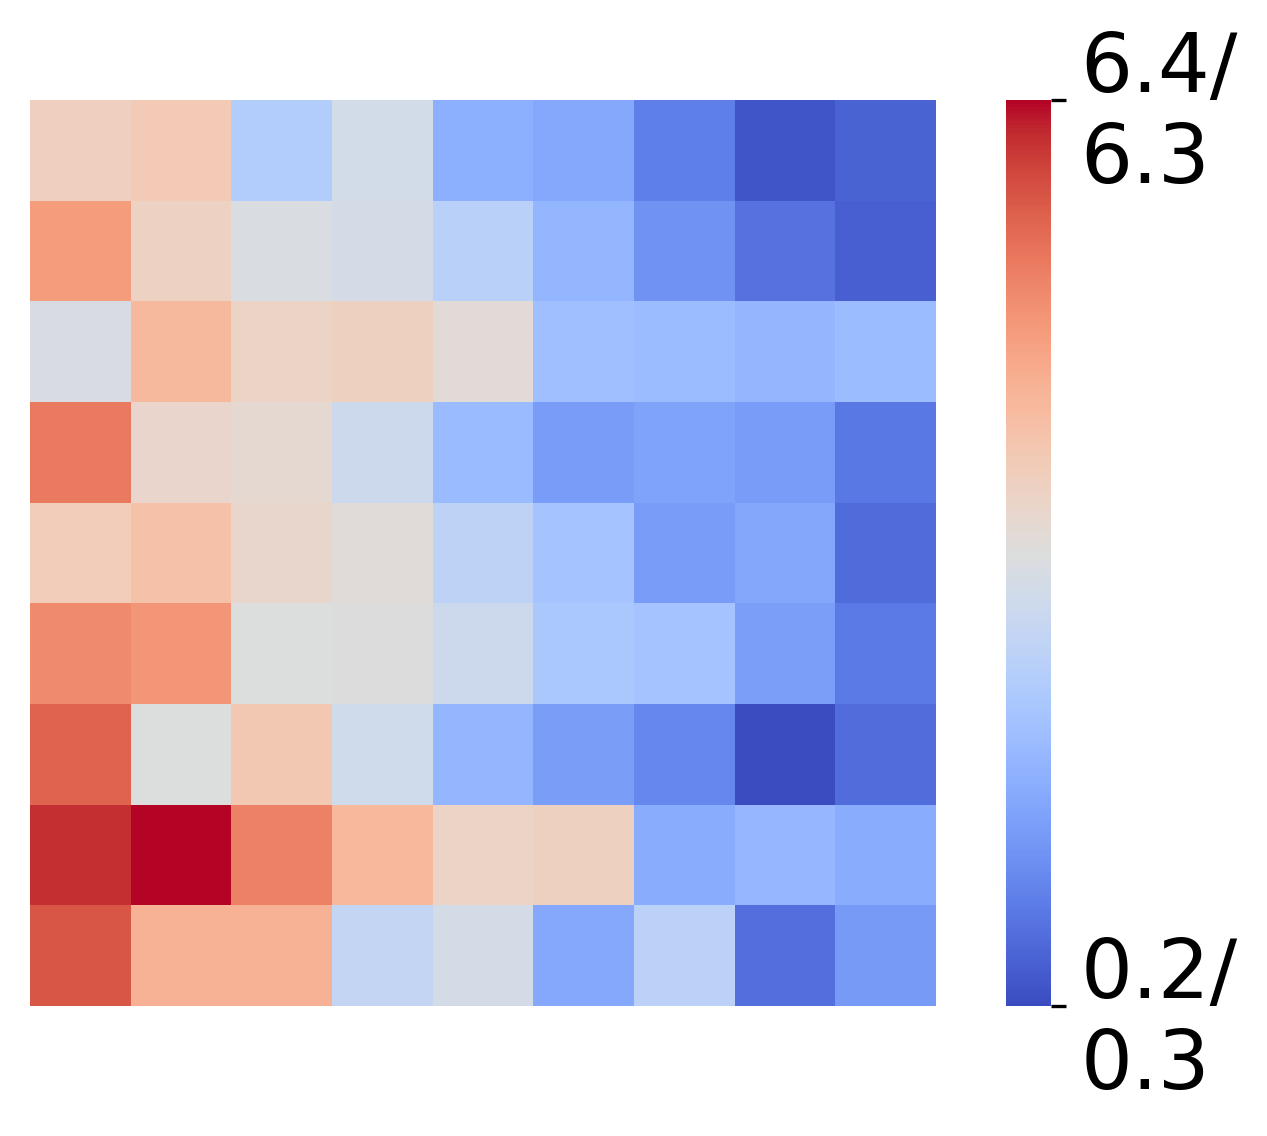

In [71]:
from human_utils_transdiagnostics import plot_td_quantile_analysis_results

#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_sleeps'].values).squeeze(), getPCs(df['Compul'], df['AD'])[:,0], np.stack(df["effs"].values), "Sleeps", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_sleeps'].values).squeeze(), df['AD'] - AD_pred, np.stack(df["effs"].values), "Sleeps", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_sleeps'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Sleeps", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_sleeps'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Sleeps", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=True, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_sleeps'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Sleeps", col2name="AD", groups = None, num_bins=9, combine_groups = True, annot=False, flip_leastmost=True)

In [72]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_sleeps_AD.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_sleeps_AD.svg"))

### AD Residual

PC1 loadings:  [0.72901262 0.68450026]
PC2 loadings:  [-0.68450026  0.72901262]
Variance explained by PC1:  0.6791482866096403
Variance explained by PC2:  0.3208517133903596
Flipped PC2 to enforce second component to be negative.
[[0.5638054  0.53533576 0.39827643 0.39683801 0.30163672 0.29852752
  0.15620137 0.15165375 0.08587369]
 [0.42507213 0.56834986 0.27580522 0.44994574 0.25618896 0.19375678
  0.10668652 0.12151647 0.09687839]
 [0.7865092  0.62408627 0.66499272 0.57792246 0.52697235 0.34637158
  0.38105332 0.27245733 0.22006881]
 [0.49587403 0.57313616 0.36454942 0.44683339 0.33177716 0.21193462
  0.17414053 0.11673018 0.16265846]
 [0.72598649 0.67671032 0.67001455 0.591314   0.39588328 0.31048696
  0.33991134 0.19375678 0.12797672]
 [0.65183671 0.56165409 0.45975387 0.45161969 0.32842927 0.24949319
  0.07391425 0.09353051 0.03946804]
 [0.52697235 0.42195977 0.3217335  0.2791531  0.22341669 0.2069128
  0.09687839 0.08037449 0.1478285 ]
 [0.88817389 0.67312691 0.72886332 0.535342

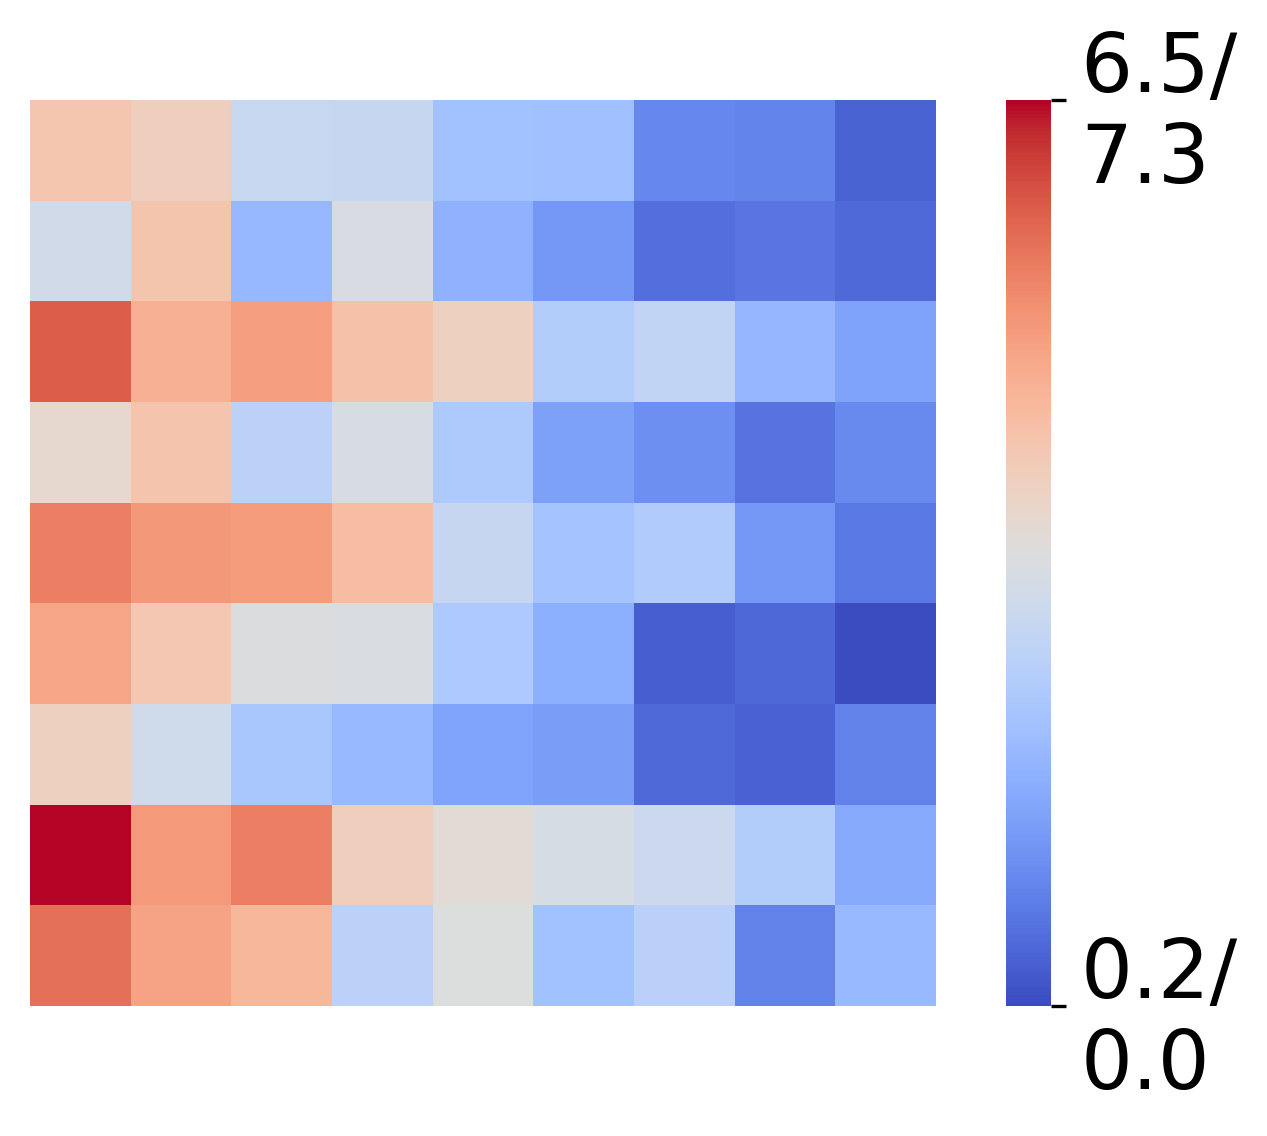

In [73]:
from human_utils_transdiagnostics import plot_td_quantile_analysis_results

#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_sleeps'].values).squeeze(), df['AD'] - AD_pred, np.stack(df["effs"].values), "Sleeps", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_sleeps'].values).squeeze(), get_alternate_TD_representation(df['AD'], df['Compul'], method, -(np.stack(df['n_sleeps'].values).sum(axis=1)))[0], np.stack(df["effs"].values), "Sleeps", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)

In [74]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_sleeps_AD_residual.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_sleeps_AD_residual.svg"))

### Compul

[[0.51091091 0.62522523 0.37217217 0.42912913 0.28998999 0.31321321
  0.15105105 0.14964965 0.01171171]
 [0.80772201 0.62782783 0.54751895 0.53413413 0.41901902 0.34807665
  0.26803947 0.26964107 0.22975833]
 [0.62568283 0.54939225 0.54697555 0.58552839 0.41901902 0.27151437
  0.31354211 0.26964107 0.17005577]
 [0.57214357 0.4995996  0.42491062 0.38100958 0.36173316 0.22012012
  0.14543115 0.06110396 0.11678822]
 [0.63532104 0.72366652 0.51083941 0.55341055 0.37511798 0.2985557
  0.17032747 0.17782068 0.12053482]
 [0.55099385 0.56250536 0.54912055 0.4974546  0.36360646 0.25063635
  0.32907193 0.10687831 0.27365937]
 [0.86126126 0.62220792 0.61631632 0.37511798 0.41339911 0.36735307
  0.202717   0.20646361 0.11276991]
 [0.68351208 0.53413413 0.52262262 0.31006721 0.31006721 0.14543115
  0.26402116 0.06110396 0.10500501]
 [0.83500167 0.63378378 0.61348015 0.49100767 0.45587254 0.42921255
  0.34611278 0.26736737 0.27907908]]


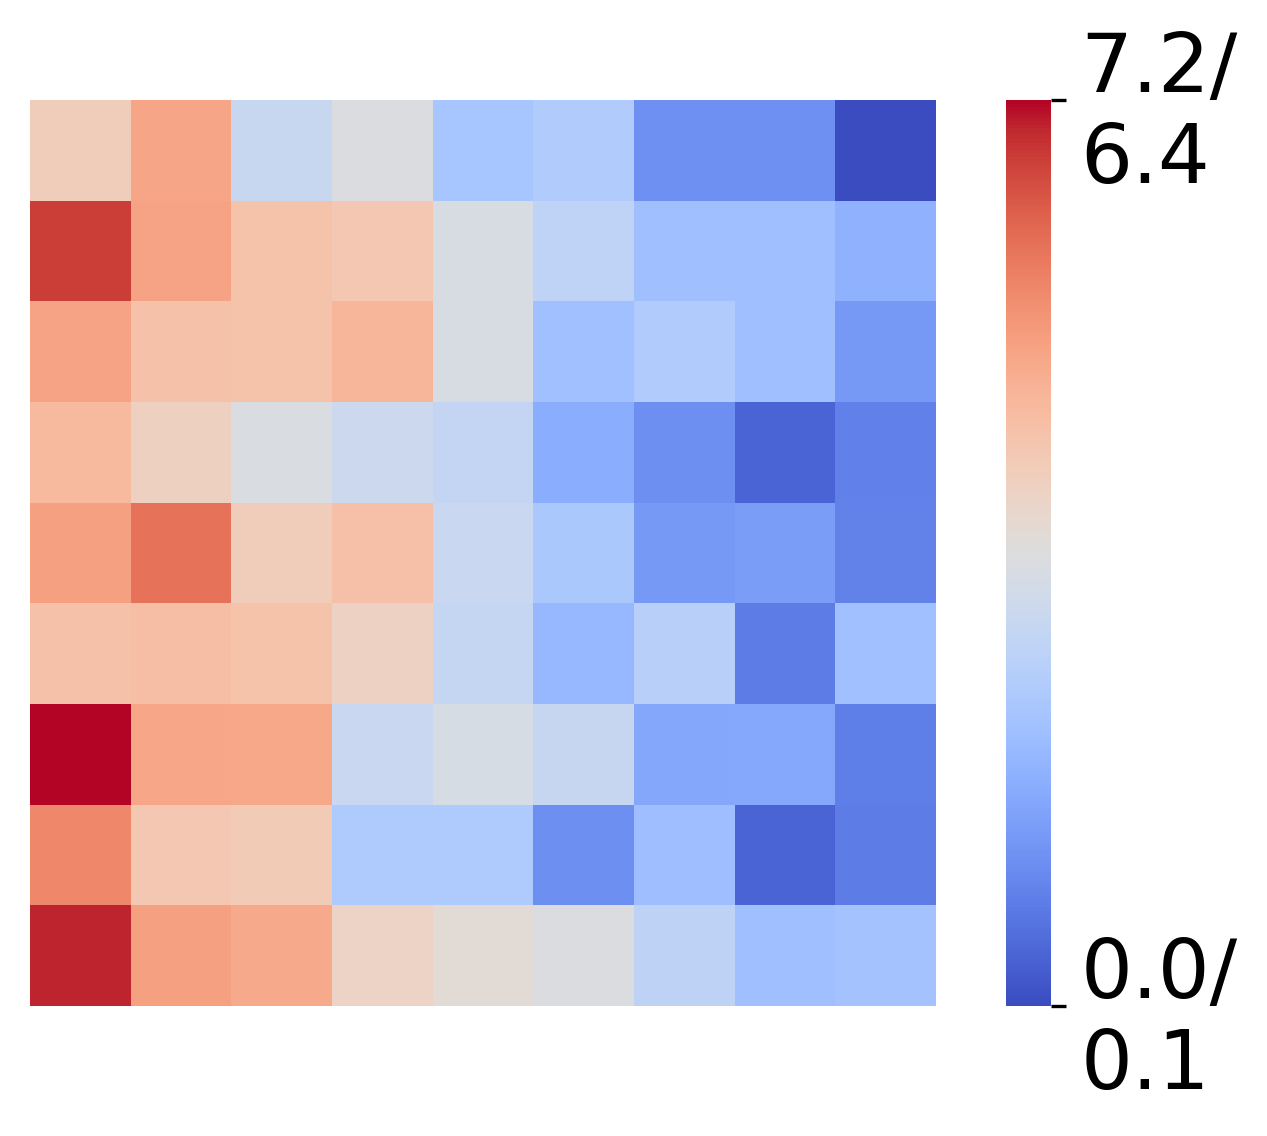

In [75]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_sleeps'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Sleeps", col2name = "Compul", groups = df["group"], num_bins =9, combine_groups = True, annot=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_sleeps'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Sleeps", col2name = "Compul", groups = None, num_bins =9, combine_groups = False, annot=False)

In [76]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_sleeps_Compul.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_sleeps_Compul.svg"))

### Compul Residual

PC1 loadings:  [0.72901262 0.68450026]
PC2 loadings:  [-0.68450026  0.72901262]
Variance explained by PC1:  0.6791482866096403
Variance explained by PC2:  0.3208517133903596
Flipped PC2 to enforce second component to be negative.
[[0.49830207 0.3955208  0.38808321 0.32809639 0.25299135 0.24787093
  0.19532171 0.19044432 0.1278973 ]
 [0.77395577 0.60935658 0.52258245 0.53627241 0.41635205 0.33184182
  0.17764328 0.09766085 0.16621721]
 [0.71671894 0.68810052 0.5750784  0.4665841  0.33976549 0.17074502
  0.33636963 0.15818701 0.2438292 ]
 [0.59906248 0.60925005 0.57394645 0.41624551 0.36601346 0.30661926
  0.23013923 0.16045092 0.11361472]
 [0.56591625 0.44939174 0.27584347 0.37404367 0.28613758 0.24269724
  0.12051297 0.12277688 0.04856076]
 [0.45742195 0.5018877  0.38320582 0.41624551 0.3545874  0.26894522
  0.15015681 0.12617274 0.13873075]
 [0.79206701 0.70179048 0.507654   0.37743952 0.49283208 0.3523235
  0.30435535 0.31351751 0.13307099]
 [0.76005274 0.54306413 0.60698614 0.458553

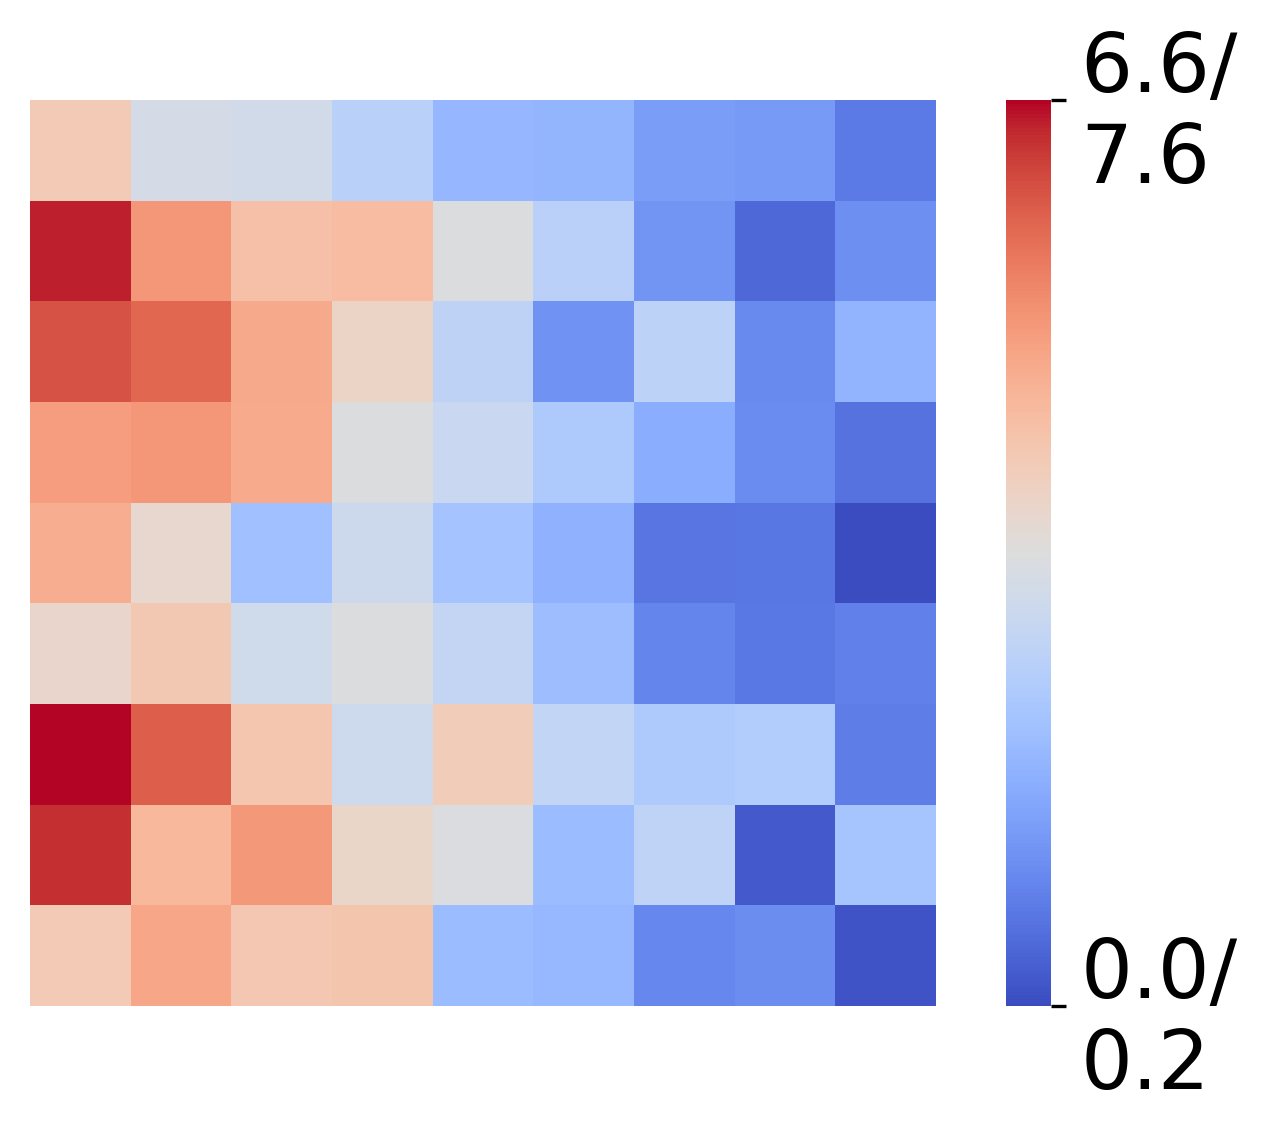

In [77]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_sleeps'].values).squeeze(), get_alternate_TD_representation(df['AD'], df['Compul'], method, -np.stack(df['n_sleeps'].values).sum(axis=1))[1], np.stack(df["effs"].values), "Sleeps", col2name = "Compul", groups = df["group"], num_bins =9, combine_groups = True, annot=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_sleeps'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Sleeps", col2name = "Compul", groups = None, num_bins =9, combine_groups = False, annot=False)

In [78]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_sleeps_Compul_residual.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_sleeps_Compul_residual.svg"))

### SW

[[0.68330759 0.60813385 0.5341184  0.44790862 0.45243887 0.33543758
  0.22354569 0.25433719 0.14837194]
 [0.6520831  0.6220114  0.58182386 0.53594778 0.37625299 0.32700496
  0.24286817 0.18166942 0.15873138]
 [0.53450267 0.49103512 0.39061224 0.47667586 0.31746277 0.22041184
  0.24383159 0.22233867 0.13579334]
 [0.57420849 0.51541828 0.4522927  0.36671079 0.35524177 0.20797941
  0.20894282 0.04972973 0.19843721]
 [0.68128332 0.7917301  0.52447876 0.69516088 0.42839125 0.37866152
  0.35379665 0.26869645 0.24431329]
 [0.58182386 0.51918    0.49672366 0.36526567 0.36430226 0.30310351
  0.25578231 0.14437213 0.18455966]
 [0.73477477 0.6047619  0.60379849 0.42261077 0.3872403  0.39774591
  0.19458356 0.27631182 0.15873138]
 [0.63251701 0.59859165 0.48573635 0.55030704 0.26821475 0.23236257
  0.19410186 0.10996507 0.09801434]
 [0.83268983 0.59276062 0.53098456 0.31235521 0.43716216 0.2706242
  0.29173102 0.11444659 0.17776705]]


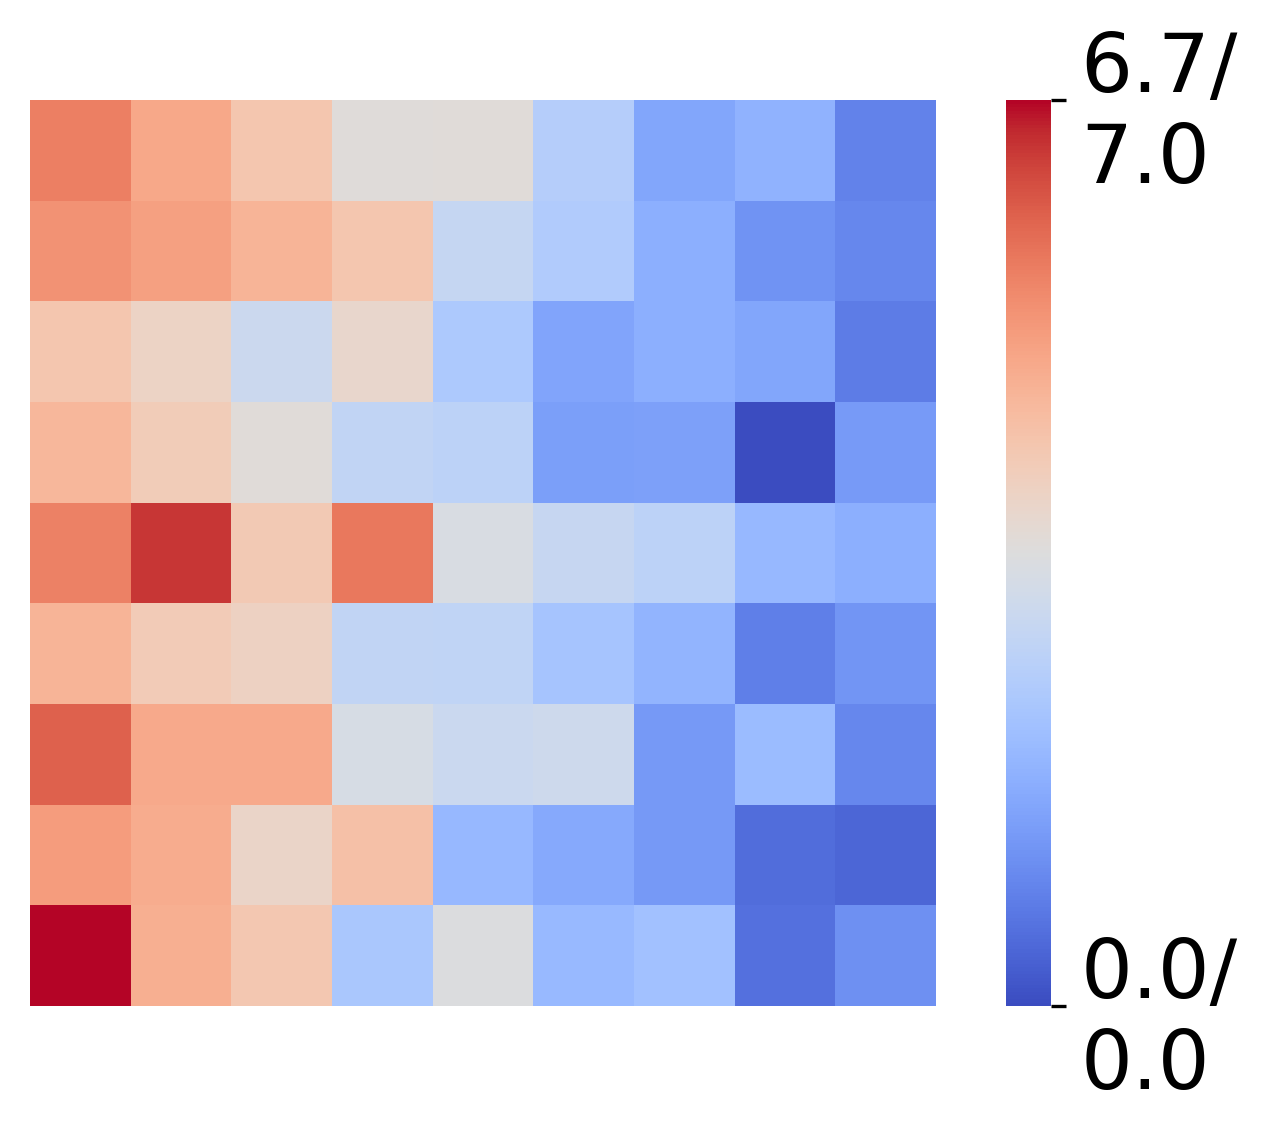

In [79]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_sleeps'].values).squeeze(), df['SW'], np.stack(df["effs"].values), "Sleeps", col2name = "SW", groups = df["group"], num_bins =9, combine_groups = True, annot=False, square=square, axes_off=axes_off)

In [80]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_sleeps_SW.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_sleeps_SW.svg"))

### Trait-level Perturbations

In [81]:
from settings_anal import levc_human_ape_models as ape_models
from settings_anal import trait_simulated_participants_folder_t2 as simulated_participants_folder
from settings_anal import trait_sim_timestamp_t2 as sim_timestamp
from settings_anal import trait_sim_mag_perturbation as mag_perturbation
from settings_anal import trait_sim_bias_perturbation as bias_perturbation
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models

effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, sim_sleepss = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)
sim_sleepss = sim_sleepss.mean(axis=0)

## flip to correct for switching from tau to efficacy
sim_obss = np.flip(sim_obss.T,axis=1)
sim_sleepss = np.flip(sim_sleepss.T, axis=1)
sim_rewss = np.flip(sim_rewss.T, axis=1)

with open(os.path.join('data', 'sim_perturbed_participants', 'levc', 'sim', 'mag%dbias%d'%(mag_perturbation*100, bias_perturbation*100), '%s_simulated_participant_perturbations_sim_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

[[10.39294118  9.036       7.76076471  6.54358824  5.53394118  4.91135294
   4.54470588  4.31023529  4.11682353]
 [ 8.52635294  7.39129412  6.352       5.43017647  4.66188235  4.24058824
   4.04        3.88811765  3.72641176]
 [ 7.47425     6.510625    5.6511875   4.88425     4.260375    3.9218125
   3.739125    3.5769375   3.4194375 ]
 [ 7.03676471  6.16111765  5.36223529  4.66652941  4.09017647  3.77917647
   3.587       3.41394118  3.24994118]
 [ 6.74575     5.87        5.1261875   4.4863125   3.97        3.653625
   3.4634375   3.29275     3.1393125 ]
 [ 6.38982353  5.55841176  4.89517647  4.30105882  3.82052941  3.51188235
   3.31552941  3.158       3.01952941]
 [ 6.0613125   5.31625     4.661       4.105875    3.659375    3.359875
   3.1734375   3.044125    2.9076875 ]
 [ 5.48505882  4.81976471  4.22776471  3.73158824  3.35805882  3.10935294
   2.96347059  2.82194118  2.70464706]
 [ 4.64552941  4.08423529  3.61064706  3.24435294  2.96970588  2.78394118
   2.63511765  2.50635294  

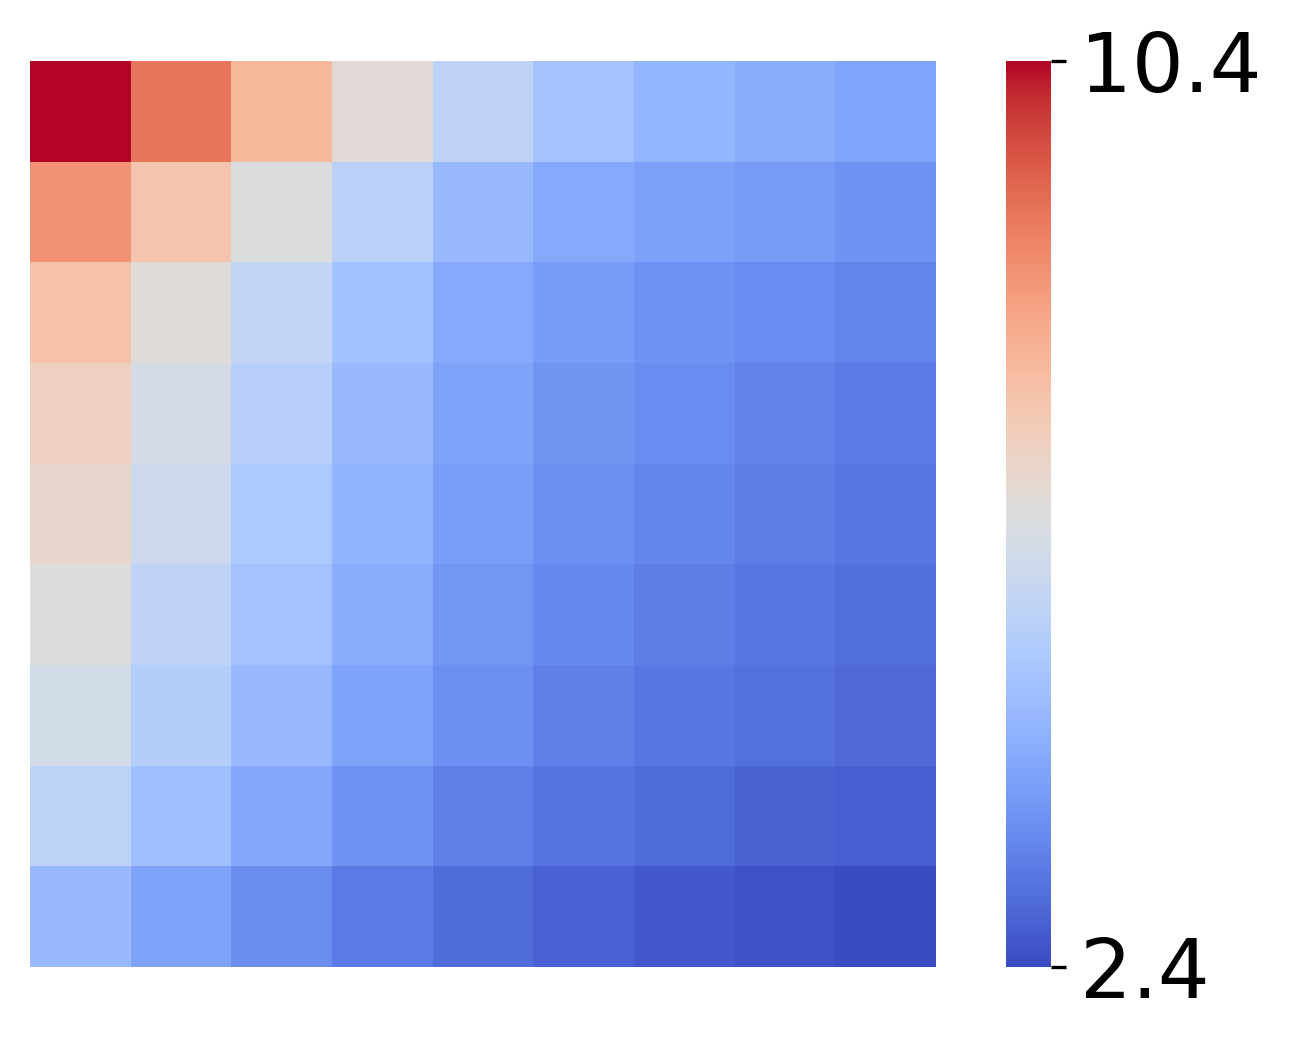

In [82]:
quantile_fig = plot_td_quantile_analysis_results(sim_sleepss, sim_participant_perturbations, effs, "Sleeps", col2name = "Belief", groups = None, num_bins =9, annot=False, square=square, axes_off=axes_off)

In [83]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_sleeps_NN.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_sleeps_NN.svg"))

### Permuted Simulations

In [84]:
from human_utils_behavioral_analysis import load_simulated_participants_across_models
from settings_anal import levc_human_ape_models as ape_models
from settings_anal import zeros_simulated_participants_folder_t2 as simulated_participants_folder
from settings_anal import zeros_sim_timestamp_t2 as sim_timestamp
from settings_anal import trait_sim_mag_perturbation as mag_perturbation
from settings_anal import trait_sim_bias_perturbation as bias_perturbation


effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, sim_sleepss = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)
sim_sleepss = sim_sleepss.mean(axis=0)

## flip to correct for switching from tau to efficacy
sim_obss = np.flip(sim_obss.T,axis=1)
sim_sleepss = np.flip(sim_sleepss.T, axis=1)
sim_rewss = np.flip(sim_rewss.T, axis=1)

with open(os.path.join('data', 'sim_perturbed_participants', 'levc', 'nostruc', 'mag%dbias%d'%(mag_perturbation*100, bias_perturbation*100), '%s_simulated_participant_perturbations_nostruc_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

[[6.86580667 5.9831     5.21751333 4.55474667 4.01993333 3.71337333
  3.51579333 3.34385333 3.18756667]
 [6.86580667 5.9831     5.21751333 4.55474667 4.01993333 3.71337333
  3.51579333 3.34385333 3.18756667]
 [6.86580667 5.9831     5.21751333 4.55474667 4.01993333 3.71337333
  3.51579333 3.34385333 3.18756667]
 [6.86580667 5.9831     5.21751333 4.55474667 4.01993333 3.71337333
  3.51579333 3.34385333 3.18756667]
 [6.86580667 5.9831     5.21751333 4.55474667 4.01993333 3.71337333
  3.51579333 3.34385333 3.18756667]
 [6.86580667 5.9831     5.21751333 4.55474667 4.01993333 3.71337333
  3.51579333 3.34385333 3.18756667]
 [6.86580667 5.9831     5.21751333 4.55474667 4.01993333 3.71337333
  3.51579333 3.34385333 3.18756667]
 [6.86580667 5.9831     5.21751333 4.55474667 4.01993333 3.71337333
  3.51579333 3.34385333 3.18756667]
 [6.86580667 5.9831     5.21751333 4.55474667 4.01993333 3.71337333
  3.51579333 3.34385333 3.18756667]]


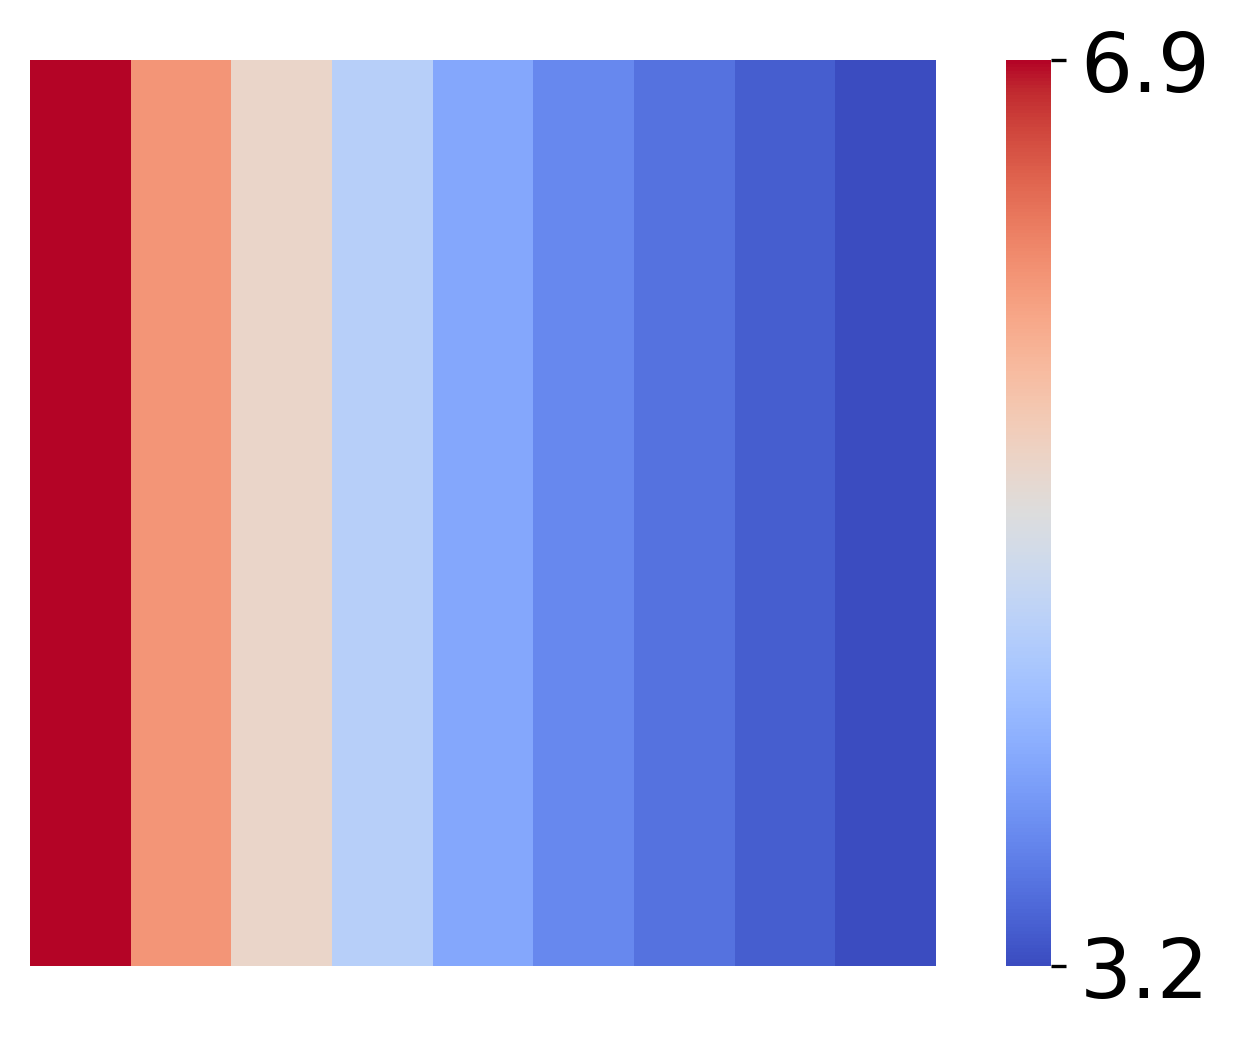

In [85]:
quantile_fig = plot_td_quantile_analysis_results(sim_sleepss, sim_participant_perturbations, effs, "Sleeps", col2name = "Belief", groups = None, num_bins =9, annot=False, square=square, axes_off=axes_off)

In [86]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_sleeps_NN_permuted.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_sleeps_NN_permuted.svg"))

## Panel D: Task 2 Observes

### AD

In [87]:
human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

mask = 'nomask'
iday = 3
day = 'day%d' %iday
exp_date = '24-01-22-29'
with_nets = False
include_sleep = False
include_estimates = False
group = None

analysis_folder = os.path.join('panels', 'fig_transdiags')

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

[[0.46090378 0.3012603  0.28991087 0.35621717 0.31216216 0.24630343
  0.26198486 0.32918631 0.26332758]
 [0.12036803 0.11213341 0.14528656 0.15341384 0.12448534 0.18266437
  0.12860265 0.05395438 0.16587311]
 [0.57226759 0.35687943 0.30704236 0.66793176 0.61809469 0.51018593
  0.61387004 0.46879816 0.54745639]
 [0.53900709 0.34821545 0.3524401  0.51007859 0.33163887 0.31516964
  0.33998083 0.46425149 0.35233276]
 [0.03315315 0.3693387  0.20736822 0.47291547 0.41906843 0.38169063
  0.35677209 0.42730305 0.38580794]
 [0.47724746 0.28656316 0.49382404 0.51462526 0.46901284 0.48558942
  0.49393138 0.61830937 0.56435499]
 [0.59772283 0.66413648 0.7097489  0.76370328 0.59349818 0.62264136
  0.6475599  0.6764884  0.60184014]
 [0.50617596 0.72632547 0.58515622 0.69728963 0.81765766 0.66846847
  0.8093157  0.76782059 0.82166763]
 [0.54826784 0.51847422 0.56208166 0.50174845 0.57514951 0.60061114
  0.50174845 0.66094435 0.44865919]]


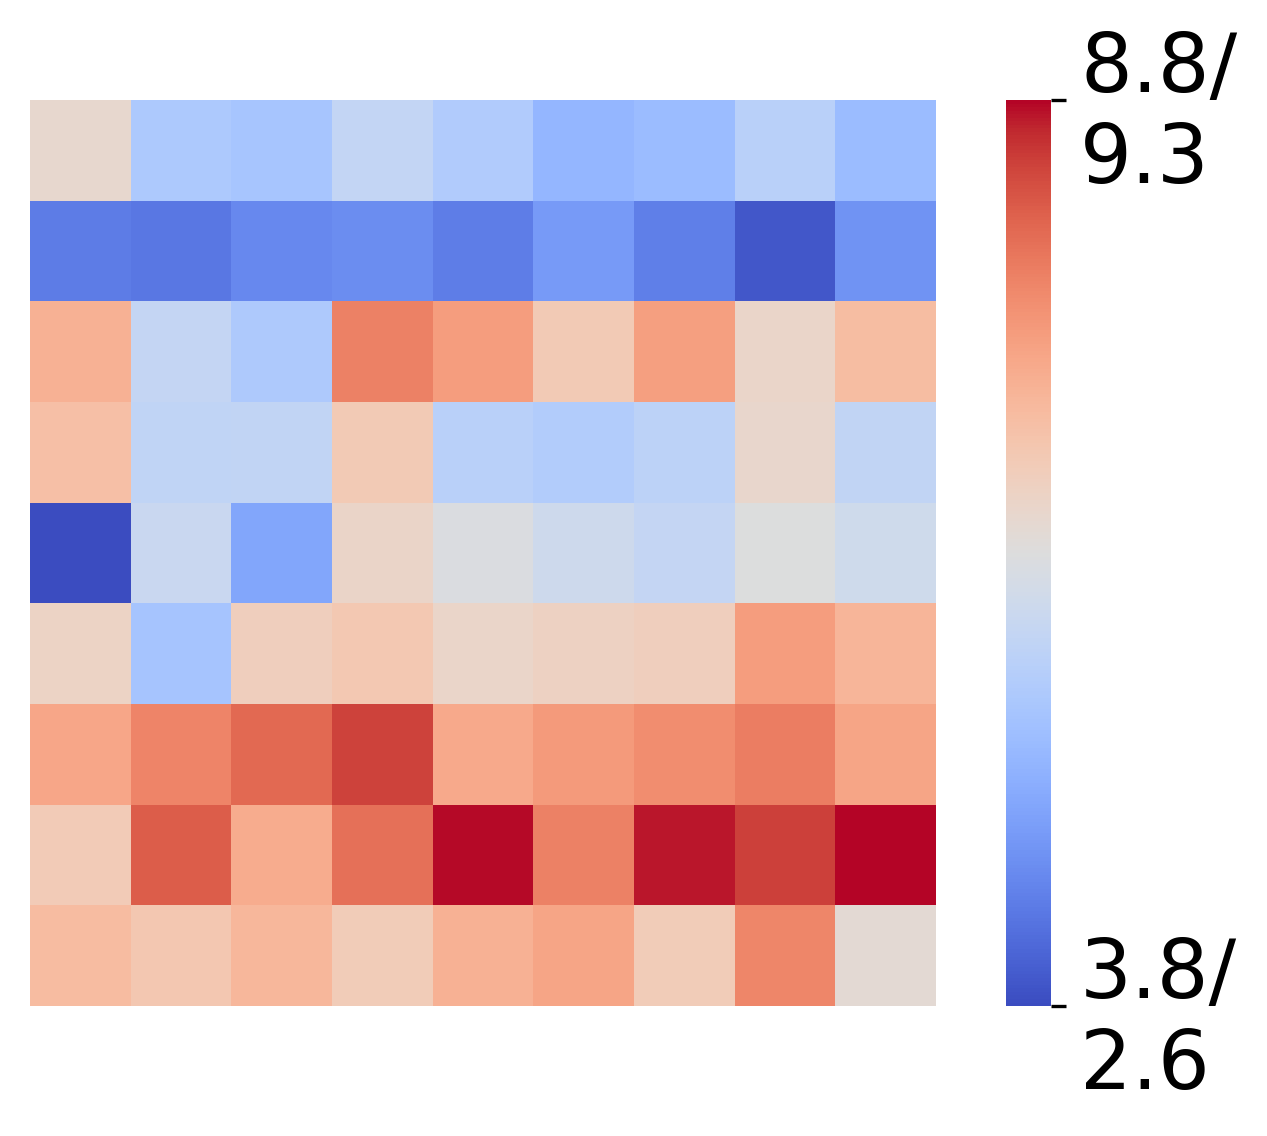

In [88]:
from human_utils_transdiagnostics import plot_td_quantile_analysis_results

#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['AD'] - AD_pred, np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=True, square=square, axes_off=axes_off)


In [89]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_observes_AD.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_observes_AD.svg"))

### AD Residual

PC1 loadings:  [0.72901262 0.68450026]
PC2 loadings:  [-0.68450026  0.72901262]
Variance explained by PC1:  0.6791482866096403
Variance explained by PC2:  0.3208517133903596
Flipped PC2 to enforce second component to be negative.
[[0.40990991 0.47466216 0.53941441 0.53941441 0.50056306 0.48761261
  0.59177928 0.56221847 0.5419482 ]
 [0.19707207 0.23873874 0.         0.3338964  0.35641892 0.25957207
  0.2240991  0.25506757 0.28716216]
 [0.53265766 0.47072072 0.53547297 0.68130631 0.57263514 0.55630631
  0.45495495 0.56024775 0.49718468]
 [0.82094595 0.72240991 0.72072072 0.8704955  0.82713964 0.75
  0.8079955  0.75957207 0.7972973 ]
 [0.45101351 0.36317568 0.41328829 0.5213964  0.42173423 0.38907658
  0.43918919 0.40033784 0.44707207]
 [0.51745495 0.40259009 0.57713964 0.57882883 0.49324324 0.6661036
  0.59797297 0.58051802 0.59966216]
 [0.58727477 0.63344595 0.75281532 0.65934685 0.53997748 0.63344595
  0.68524775 0.72578829 0.50900901]
 [0.70157658 0.79673423 0.55461712 0.74155405 0.7

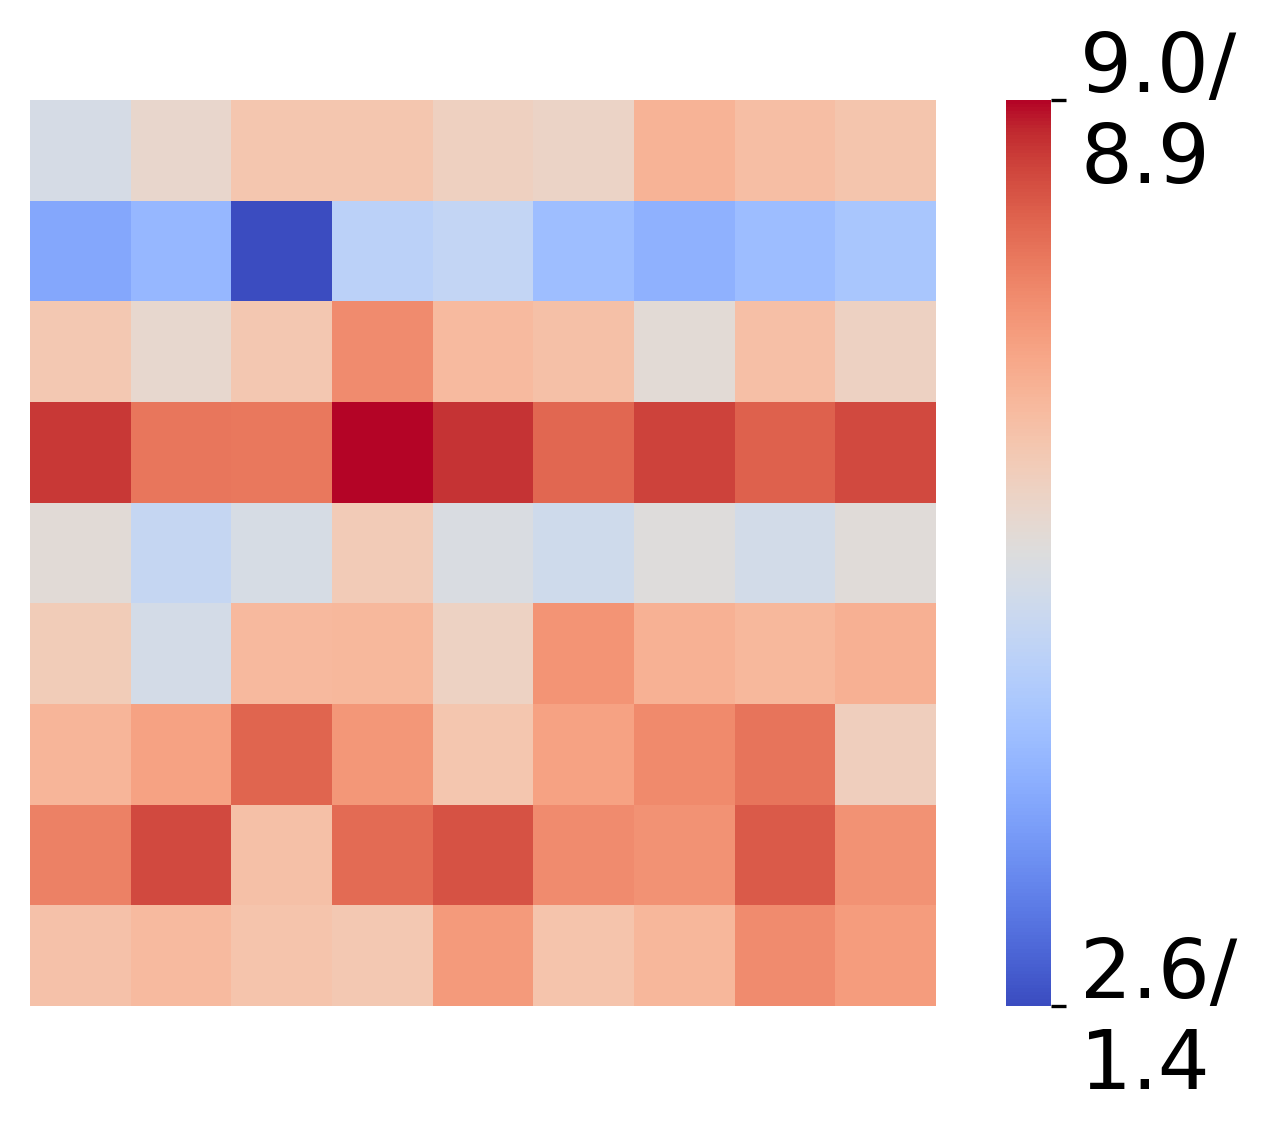

In [90]:
from human_utils_transdiagnostics import plot_td_quantile_analysis_results

quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), get_alternate_TD_representation(df['AD'], df['Compul'], method, -np.stack(df['n_sleeps'].values).sum(axis=1))[0], np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=True, square=square, axes_off=axes_off)


In [91]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_observes_AD_residual.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_observes_AD_residual.svg"))

### Compul

[[0.1742278  0.49487773 0.36189189 0.67799228 0.6353668  0.55761905
  0.73402831 0.66003218 0.73482625]
 [0.67799228 0.61730465 0.63828645 0.77134032 0.72645707 0.65767237
  0.70999081 0.75421217 0.66152602]
 [0.511344   0.41640007 0.44189741 0.5181173  0.55171171 0.47323405
  0.38280566 0.46805663 0.43220445]
 [0.34987314 0.33340688 0.31176319 0.38346755 0.30498989 0.44773672
  0.304328   0.41640007 0.37217871]
 [0.5801287  0.52555249 0.58304835 0.60469204 0.58079059 0.66829932
  0.66604155 0.64439787 0.76098548]
 [0.49129619 0.3185365  0.3453576  0.46805663 0.32982534 0.23262364
  0.1735319  0.20872219 0.08761905]
 [0.49553962 0.49394374 0.6554146  0.5866299  0.48876632 0.52687626
  0.59114543 0.49328185 0.42223938]
 [0.38798309 0.29981247 0.31694061 0.40670712 0.35438867 0.4971355
  0.41414231 0.42383526 0.4283508 ]
 [0.66692407 0.70045045 0.54498069 0.62725225 0.73182111 0.48101673
  0.63494208 0.798713   0.65646718]]


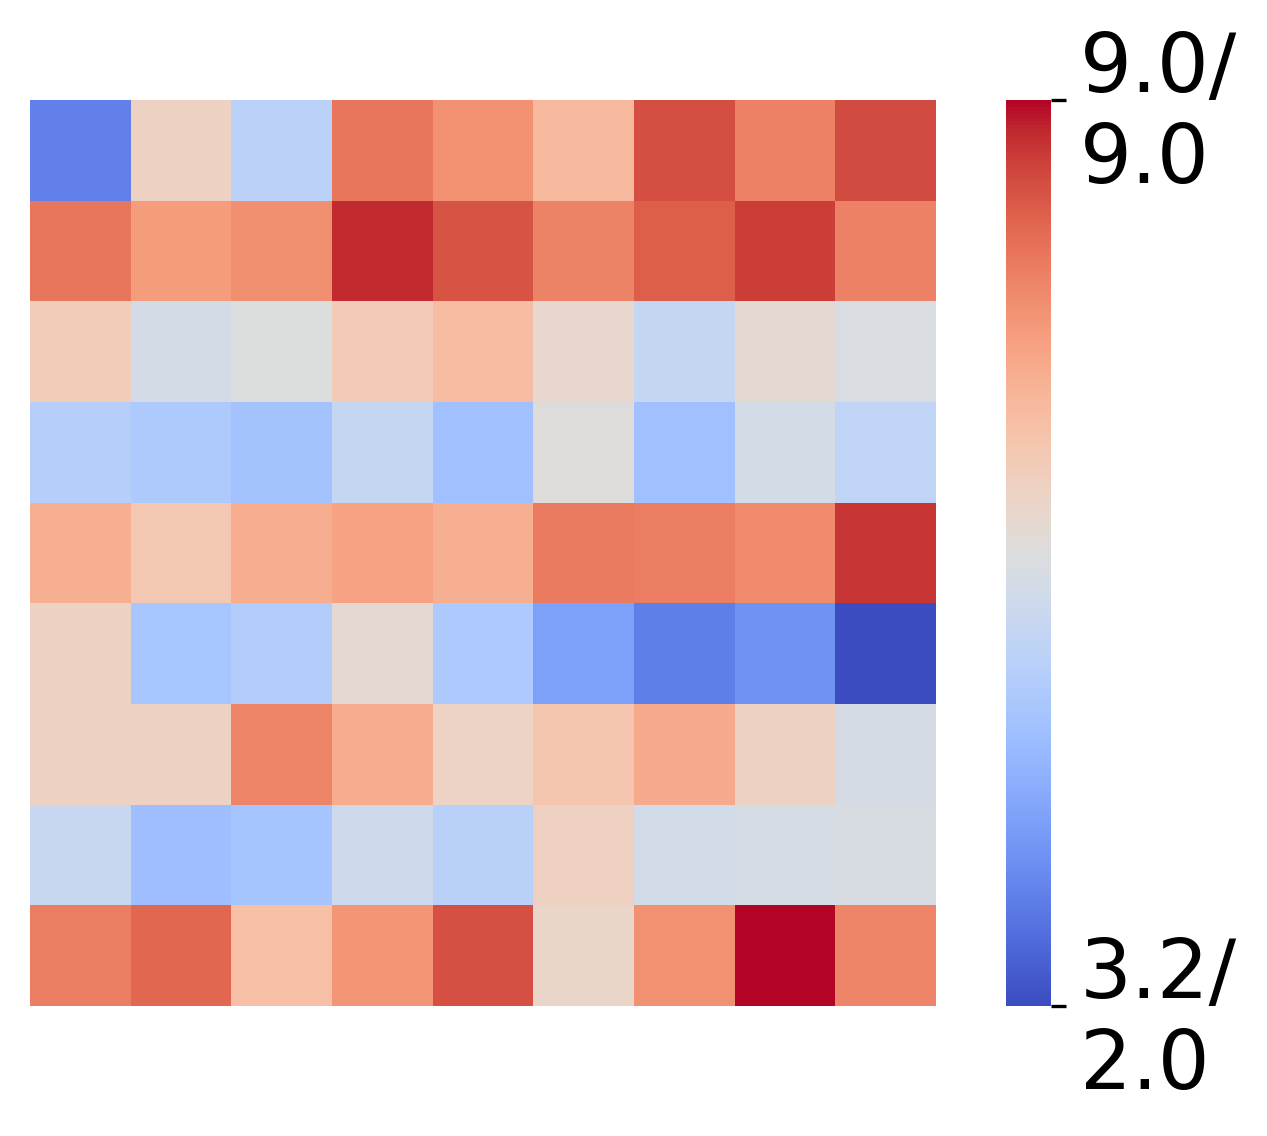

In [92]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = df["group"], num_bins =9, combine_groups = True, annot=False, square=square, axes_off=axes_off)

In [93]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_observes_Compul.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_observes_Compul.svg"))

### Compul Residual

PC1 loadings:  [0.72901262 0.68450026]
PC2 loadings:  [-0.68450026  0.72901262]
Variance explained by PC1:  0.6791482866096403
Variance explained by PC2:  0.3208517133903596
Flipped PC2 to enforce second component to be negative.
[[0.36320249 0.24479837 0.19707207 0.34175247 0.2743994  0.23981124
  0.30882668 0.36802874 0.23166023]
 [0.73080223 0.56949807 0.47876448 0.64199914 0.71750322 0.53903904
  0.49420849 0.50922351 0.28464178]
 [0.31274131 0.17932218 0.23852424 0.25396825 0.10510511 0.05941656
  0.14929215 0.17846418 0.25160875]
 [0.32711283 0.31338481 0.4017589  0.38738739 0.34212784 0.35714286
  0.44594595 0.35628486 0.55040755]
 [0.4036894  0.38803089 0.38781639 0.4028314  0.4030459  0.4034749
  0.43264693 0.41784642 0.53667954]
 [0.28335478 0.46289146 0.37387387 0.58236808 0.47747748 0.58193908
  0.53710854 0.55255255 0.49249249]
 [0.50536251 0.35692836 0.41591592 0.59459459 0.50536251 0.46117546
  0.43114543 0.49056199 0.4009009 ]
 [0.53582154 0.7018447  0.62676963 0.821750

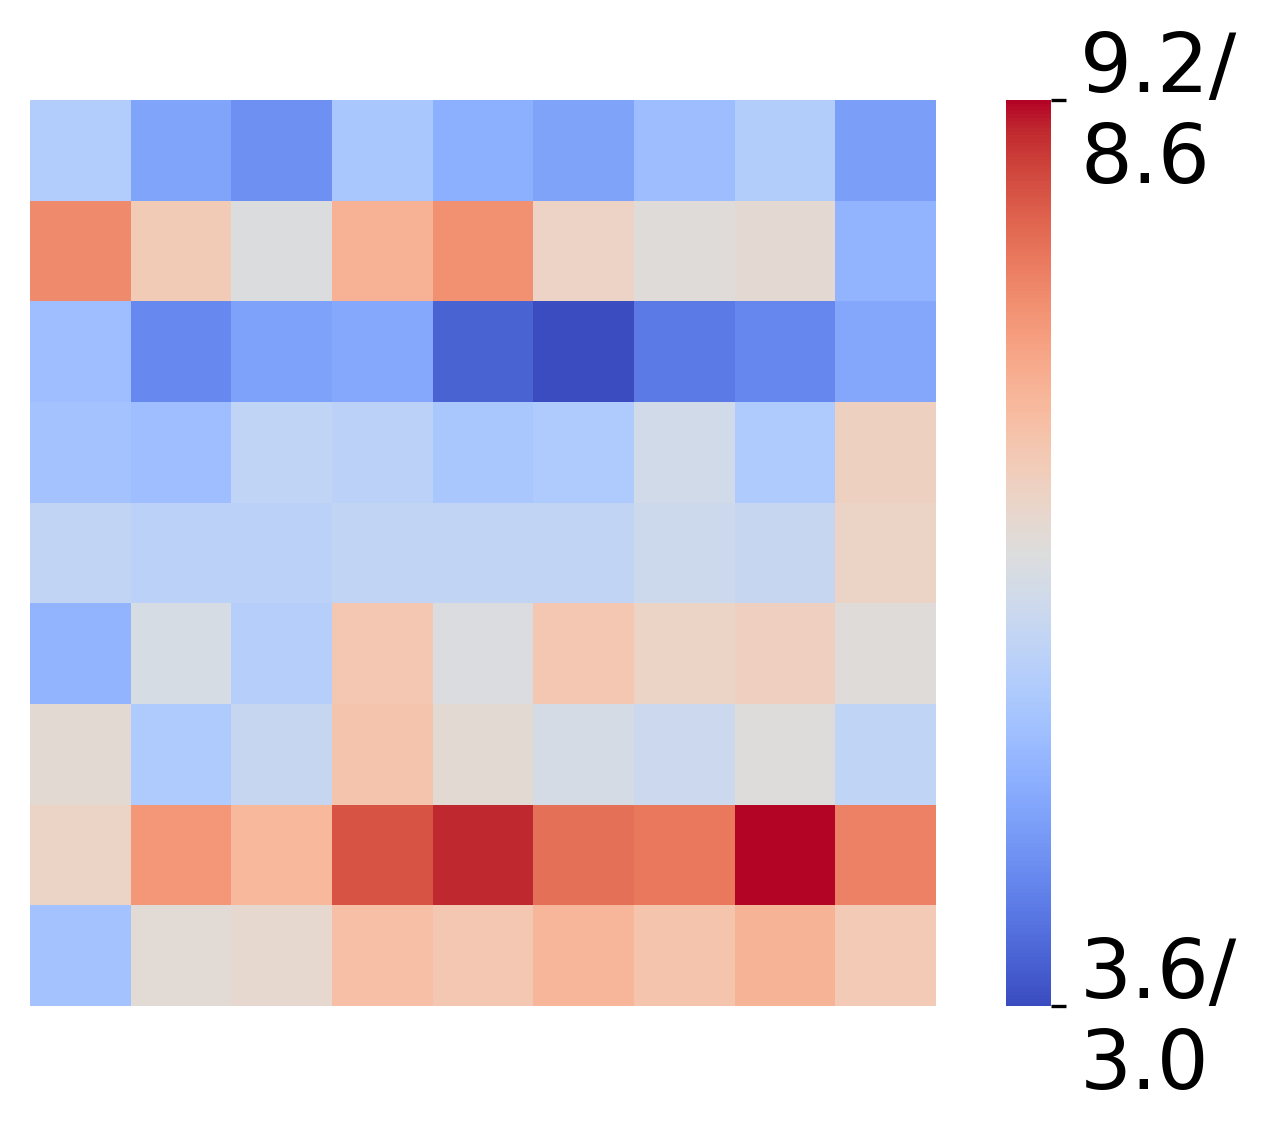

In [94]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), get_alternate_TD_representation(df['AD'], df['Compul'], method, -np.stack(df['n_sleeps'].values).sum(axis=1))[1], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = df["group"], num_bins =9, combine_groups = True, annot=False, square=square, axes_off=axes_off)

In [95]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_observes_Compul_residual.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_observes_Compul_residual.svg"))

### SW

[[0.41435775 0.46256162 0.46256162 0.67624228 0.47443198 0.44889229
  0.55357244 0.55896935 0.47335543]
 [0.52376905 0.47237804 0.34945323 0.46950252 0.50568021 0.36754207
  0.27874101 0.32931044 0.18993994]
 [0.46868095 0.43373562 0.2951867  0.5381608  0.43332483 0.41728993
  0.39920109 0.41523599 0.3987903 ]
 [0.43373562 0.24584962 0.22652842 0.45428919 0.33259675 0.36795286
  0.45511077 0.36630971 0.61174854]
 [0.46827016 0.25900901 0.46991331 0.45305683 0.38152303 0.39837951
  0.43291405 0.34739929 0.41523599]
 [0.27750864 0.38768485 0.41975466 0.59858916 0.52828772 0.61462406
  0.57885716 0.71740609 0.59899994]
 [0.28202731 0.44112981 0.33506148 0.45880786 0.37123916 0.45880786
  0.51143124 0.47566434 0.45839708]
 [0.57967874 0.63065896 0.63106975 0.73590572 0.80497479 0.63189133
  0.68369313 0.85759816 0.68163919]
 [0.75322492 0.81833484 0.85934519 0.84064017 0.96546547 0.86258192
  0.78416152 0.9222973  0.75322492]]


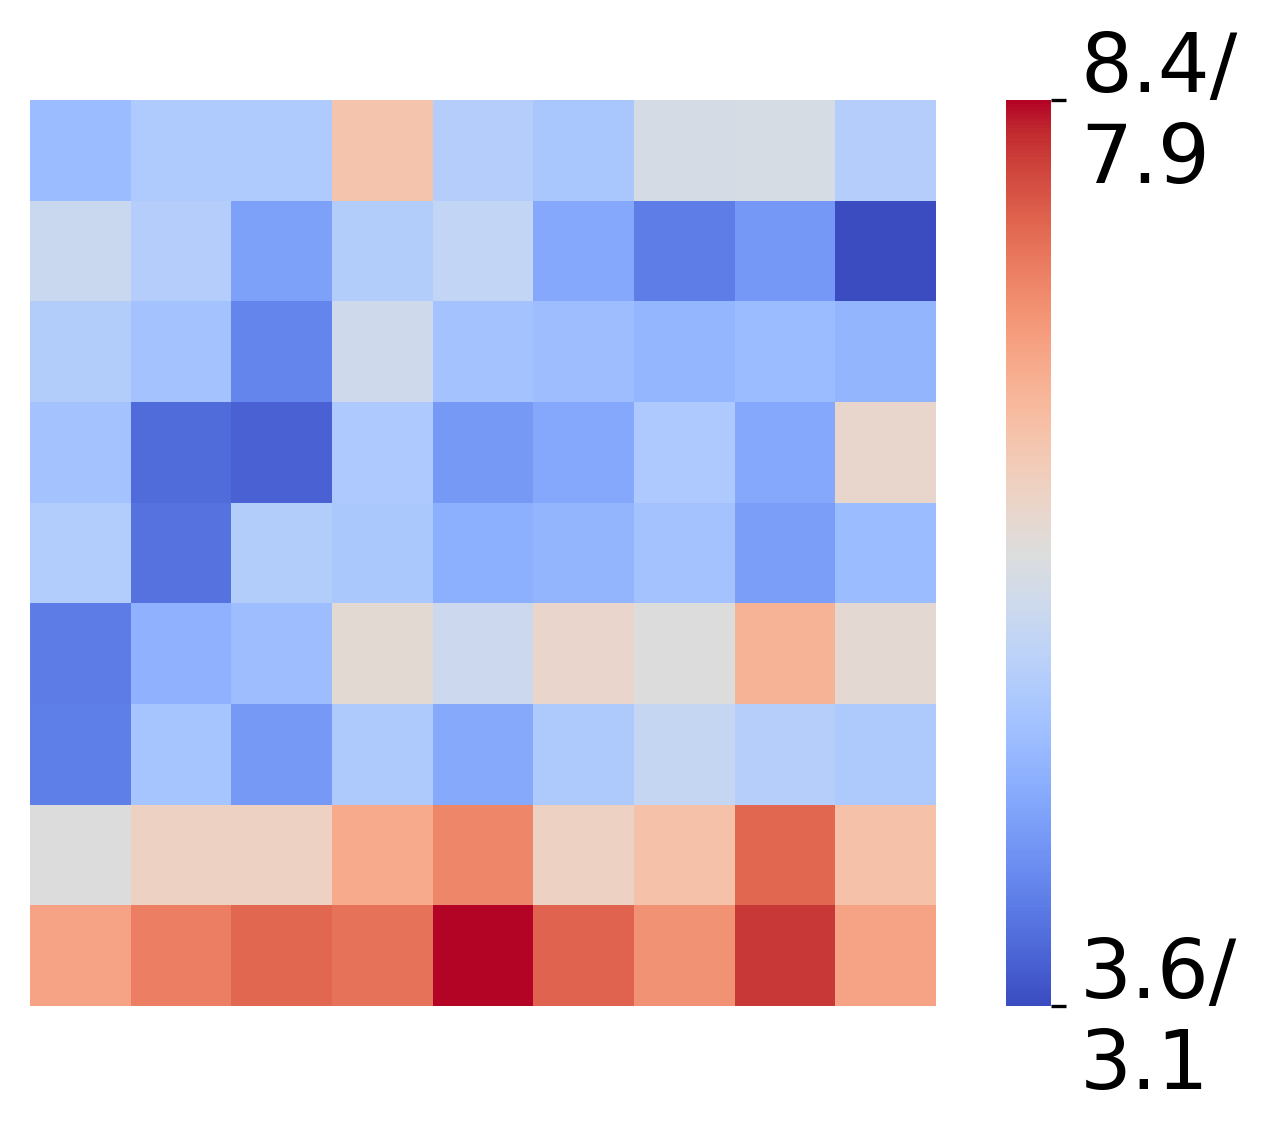

In [96]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['SW'], np.stack(df["effs"].values), "Observes", col2name = "SW", groups = df["group"], num_bins =9, combine_groups = True, annot=False, square=square, axes_off=axes_off)

In [97]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_observes_SW.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_observes_SW.svg"))

### Trait-level Perturbations

In [98]:
from settings_anal import levc_human_ape_models as ape_models
from settings_anal import trait_simulated_participants_folder_t2 as simulated_participants_folder
from settings_anal import trait_sim_timestamp_t2 as sim_timestamp
from settings_anal import trait_sim_mag_perturbation as mag_perturbation
from settings_anal import trait_sim_bias_perturbation as bias_perturbation

effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, sim_sleepss = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)
sim_sleepss = sim_sleepss.mean(axis=0)

## flip to correct for switching from tau to efficacy
sim_obss = np.flip(sim_obss.T,axis=1)
sim_sleepss = np.flip(sim_sleepss.T, axis=1)
sim_rewss = np.flip(sim_rewss.T, axis=1)

with open(os.path.join('data', 'sim_perturbed_participants', 'levc', 'sim', 'mag%dbias%d'%(mag_perturbation*100, bias_perturbation*100), '%s_simulated_participant_perturbations_sim_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

[[4.89876471 5.021      5.144      5.26023529 5.40617647 5.57311765
  5.70723529 5.81358824 5.90388235]
 [5.10076471 5.21717647 5.34441176 5.47070588 5.62864706 5.82688235
  5.92794118 5.99852941 6.05135294]
 [5.2565     5.3819375  5.491375   5.5985625  5.75825    5.95025
  6.047625   6.1078125  6.1693125 ]
 [5.321      5.44658824 5.55794118 5.67594118 5.84635294 6.00982353
  6.10964706 6.17488235 6.24152941]
 [5.365375   5.4914375  5.6074375  5.740375   5.89625    6.052375
  6.1535     6.2283125  6.29275   ]
 [5.44635294 5.56376471 5.68882353 5.79576471 5.95741176 6.12335294
  6.21823529 6.28235294 6.35070588]
 [5.515125   5.619      5.7244375  5.846375   6.0121875  6.162125
  6.26725    6.36675    6.4165    ]
 [5.61017647 5.733      5.83717647 5.97458824 6.12264706 6.26011765
  6.38882353 6.46258824 6.53394118]
 [5.79282353 5.88629412 6.00829412 6.16352941 6.29594118 6.44082353
  6.53870588 6.62952941 6.70217647]]


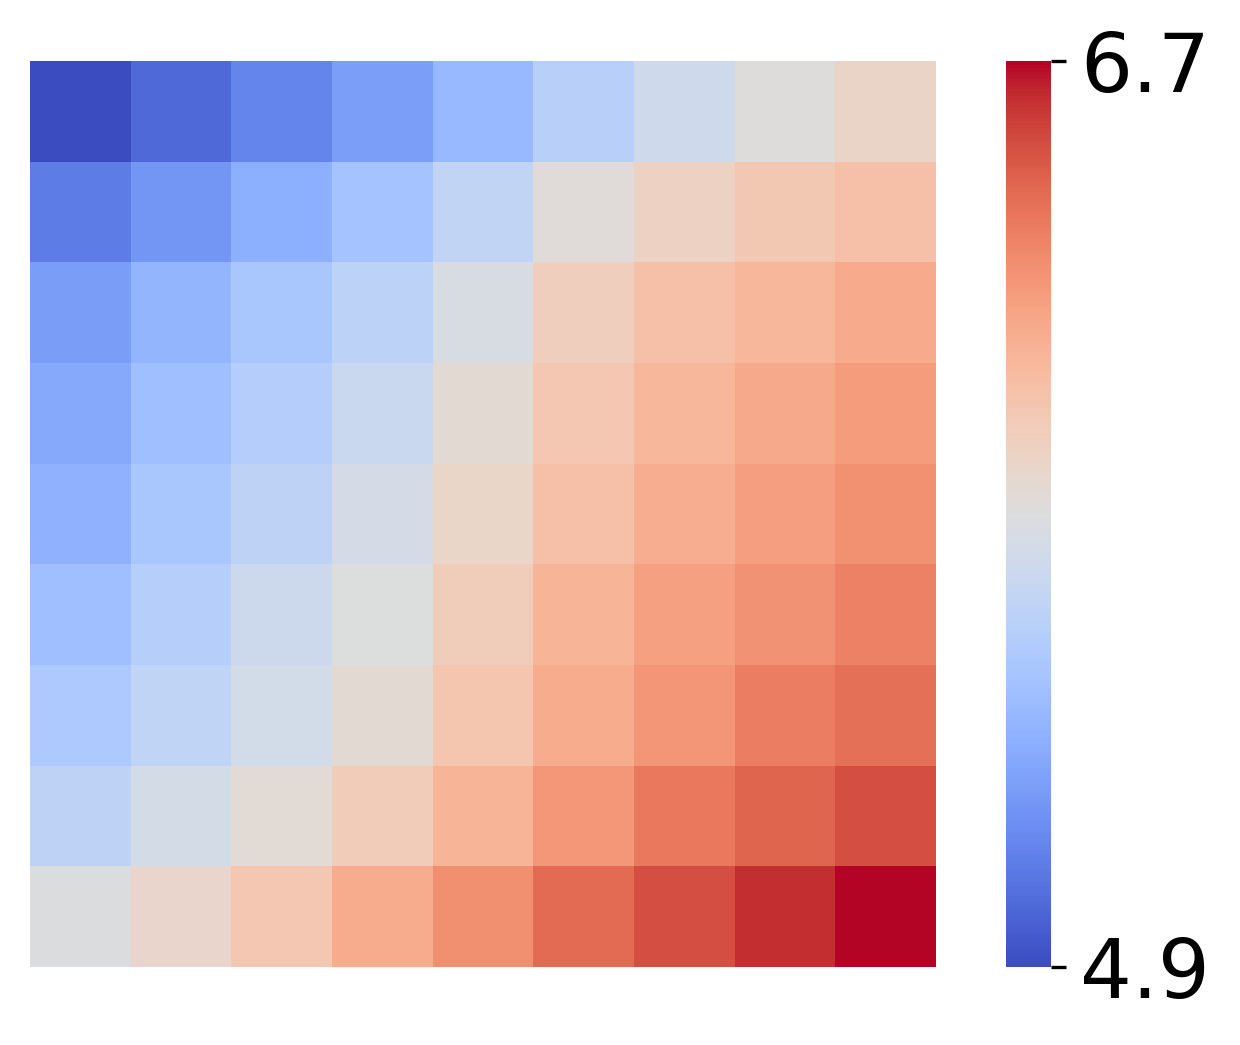

In [99]:
quantile_fig = plot_td_quantile_analysis_results(sim_obss, sim_participant_perturbations, effs, "Observes", col2name = "Belief", groups = None, num_bins =9, annot=False, square=square, axes_off=axes_off)

In [100]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_observes_NN.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_observes_NN.svg"))

### Permuted

In [101]:
from human_utils_behavioral_analysis import load_simulated_participants_across_models
from settings_anal import levc_human_ape_models as ape_models
from settings_anal import zeros_simulated_participants_folder_t2 as simulated_participants_folder
from settings_anal import zeros_sim_timestamp_t2 as sim_timestamp
from settings_anal import trait_sim_mag_perturbation as mag_perturbation
from settings_anal import trait_sim_bias_perturbation as bias_perturbation

effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, sim_sleepss = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)
sim_sleepss = sim_sleepss.mean(axis=0)

## flip to correct for switching from tau to efficacy
sim_obss = np.flip(sim_obss.T,axis=1)
sim_sleepss = np.flip(sim_sleepss.T, axis=1)
sim_rewss = np.flip(sim_rewss.T, axis=1)

with open(os.path.join('data', 'sim_perturbed_participants', 'levc', 'nostruc', 'mag%dbias%d'%(mag_perturbation*100, bias_perturbation*100), '%s_simulated_participant_perturbations_nostruc_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

[[5.35536    5.47317333 5.58918667 5.7094     5.87556    6.03971333
  6.14371333 6.21030667 6.27811333]
 [5.35536    5.47317333 5.58918667 5.7094     5.87556    6.03971333
  6.14371333 6.21030667 6.27811333]
 [5.35536    5.47317333 5.58918667 5.7094     5.87556    6.03971333
  6.14371333 6.21030667 6.27811333]
 [5.35536    5.47317333 5.58918667 5.7094     5.87556    6.03971333
  6.14371333 6.21030667 6.27811333]
 [5.35536    5.47317333 5.58918667 5.7094     5.87556    6.03971333
  6.14371333 6.21030667 6.27811333]
 [5.35536    5.47317333 5.58918667 5.7094     5.87556    6.03971333
  6.14371333 6.21030667 6.27811333]
 [5.35536    5.47317333 5.58918667 5.7094     5.87556    6.03971333
  6.14371333 6.21030667 6.27811333]
 [5.35536    5.47317333 5.58918667 5.7094     5.87556    6.03971333
  6.14371333 6.21030667 6.27811333]
 [5.35536    5.47317333 5.58918667 5.7094     5.87556    6.03971333
  6.14371333 6.21030667 6.27811333]]


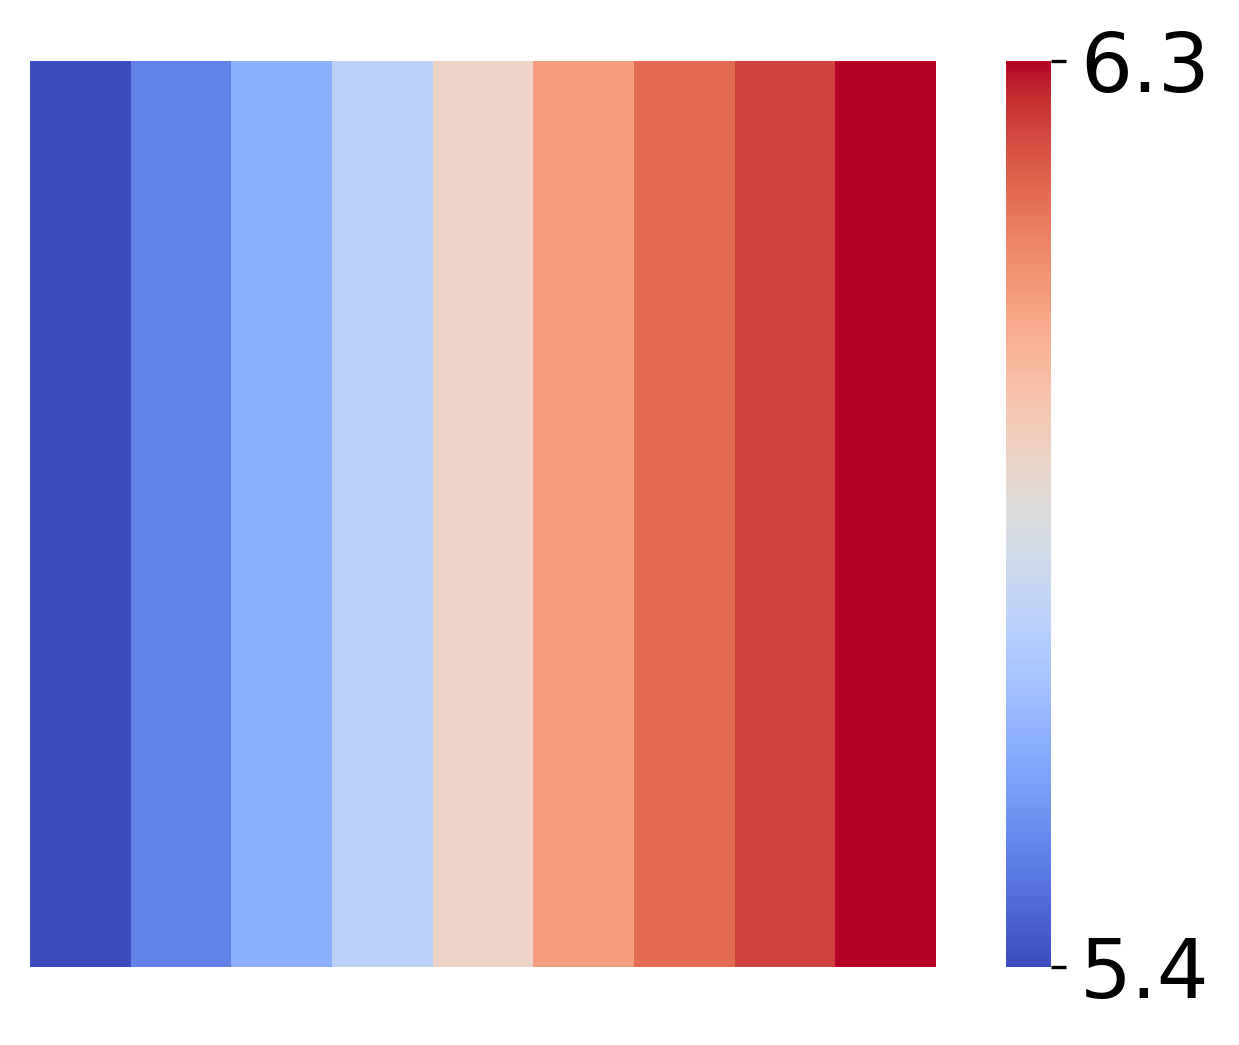

In [102]:
quantile_fig = plot_td_quantile_analysis_results(sim_obss, sim_participant_perturbations, effs, "Observes", col2name = "Belief", groups = None, num_bins =9, annot=False, square=square, axes_off=axes_off)

In [103]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_observes_NN_permuted.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_observes_NN_permuted.svg"))

## Panel E: Task 2 Rewards
### AD

In [104]:
human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

mask = 'nomask'
iday = 3
day = 'day%d' %iday
exp_date = '24-01-22-29'
with_nets = False
include_sleep = False
include_estimates = False
group = None

analysis_folder = os.path.join('panels', 'fig_transdiags')

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

[[0.17902524 0.27159847 0.26665656 0.378692   0.3401751  0.37639928
  0.4243925  0.65860236 0.70944889]
 [0.16665946 0.32579301 0.23478463 0.395505   0.50970205 0.44384762
  0.32276535 0.59268982 0.55823389]
 [0.06218608 0.2660669  0.24862809 0.55804466 0.41963981 0.6139132
  0.64481701 0.66403187 0.66770022]
 [0.16987635 0.07988712 0.14668768 0.35094696 0.45996183 0.55217858
  0.4732376  0.53909203 0.81344176]
 [0.33634658 0.305632   0.27763962 0.43980082 0.40586935 0.64122167
  0.64500624 0.88440536 0.83852271]
 [0.15856586 0.2660669  0.24166986 0.44422608 0.4108623  0.68823968
  0.56057764 0.70473235 0.87082412]
 [0.2593709  0.15799817 0.34152876 0.36687194 0.2634177  0.63539881
  0.87517638 0.86291975 0.93357789]
 [0.1937057  0.17607767 0.16968712 0.34746784 0.27257367 0.41275458
  0.65291061 0.73431156 0.8431372 ]
 [0.27737255 0.28345243 0.33226104 0.45058012 0.63387529 0.44567211
  0.70194235 0.74018769 0.49971131]]


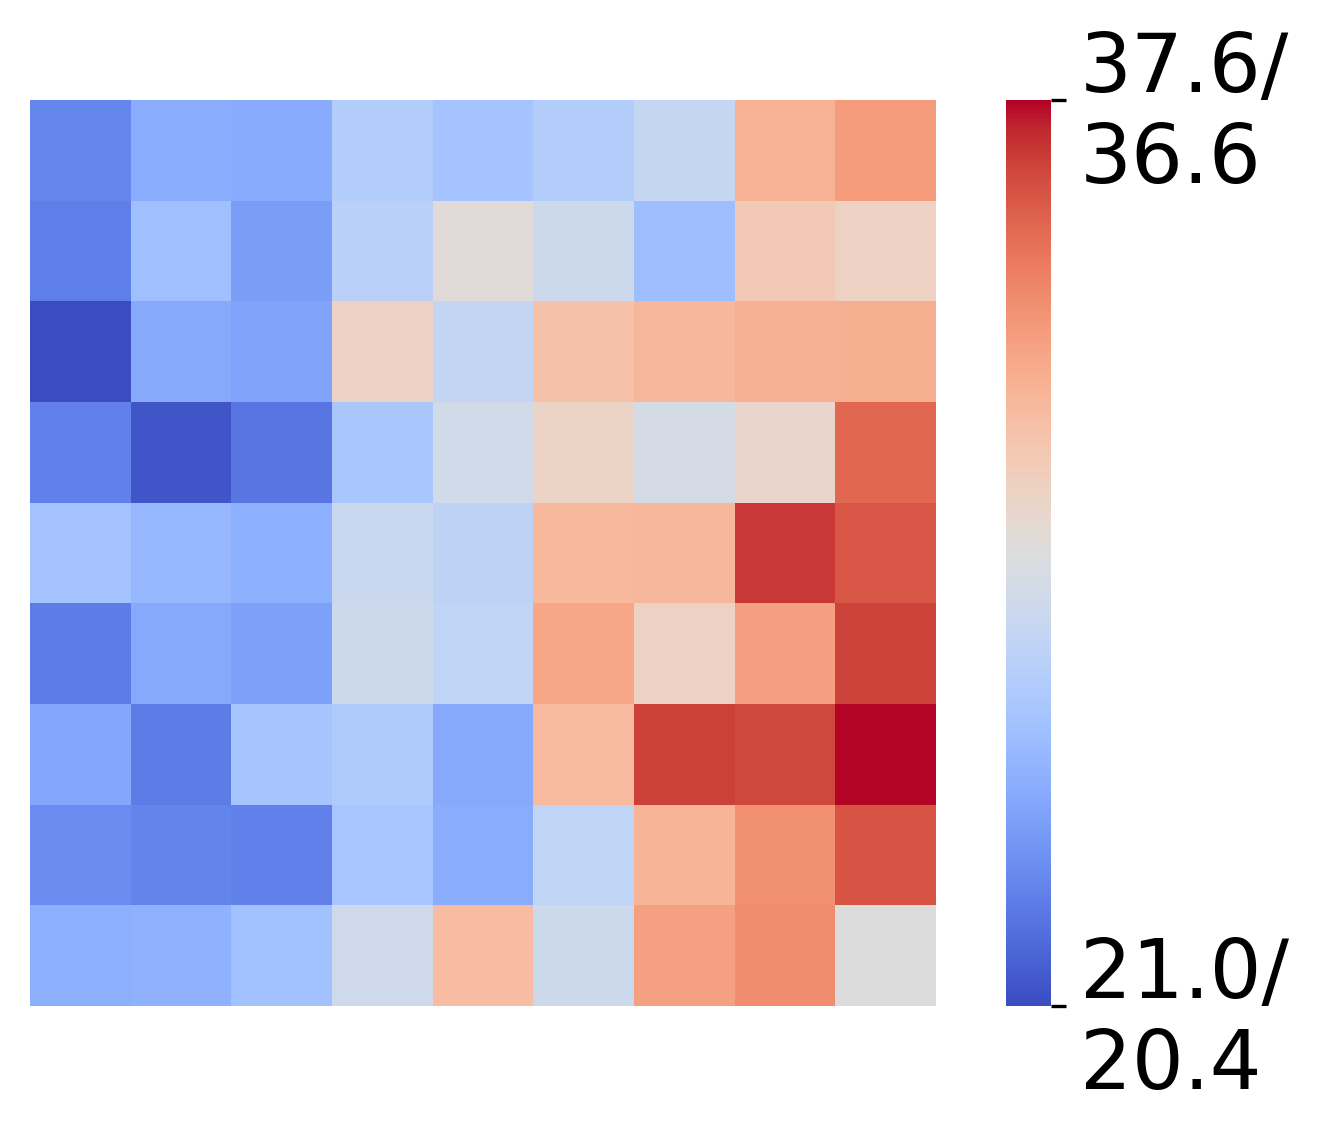

In [105]:
from human_utils_transdiagnostics import plot_td_quantile_analysis_results

quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Rewards", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Rewards", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=True, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Rewards", col2name="AD", groups = None, num_bins=9, combine_groups = False, annot=False, flip_leastmost=True)


In [106]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_rewards_AD.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_rewards_AD.svg"))

### AD Residual

PC1 loadings:  [0.72901262 0.68450026]
PC2 loadings:  [-0.68450026  0.72901262]
Variance explained by PC1:  0.6791482866096403
Variance explained by PC2:  0.3208517133903596
Flipped PC2 to enforce second component to be negative.
[[0.31223046 0.34953657 0.28944828 0.4063001  0.44773533 0.56688738
  0.27215279 0.84216453 0.77897164]
 [0.0896498  0.34719682 0.2420014  0.55169455 0.39212897 0.34825803
  0.49885976 0.44268328 0.59784597]
 [0.24062408 0.33658471 0.20099799 0.37164985 0.5520671  0.50469643
  0.71428571 0.6862765  0.52108876]
 [0.19341146 0.27144438 0.43138251 0.38310867 0.43297433 0.70054641
  0.64240556 0.71746935 0.80271625]
 [0.24656235 0.14307164 0.17760618 0.50363521 0.40533767 0.55026079
  0.55190905 0.74266748 0.85433178]
 [0.33748786 0.24746551 0.44740229 0.34189076 0.39085326 0.60627921
  0.63110479 0.87666238 1.        ]
 [0.1881054  0.37096119 0.36496647 0.63131929 0.49074262 0.59466233
  0.87581567 0.67853192 0.77290072]
 [0.33027388 0.25330217 0.28040823 0.44353

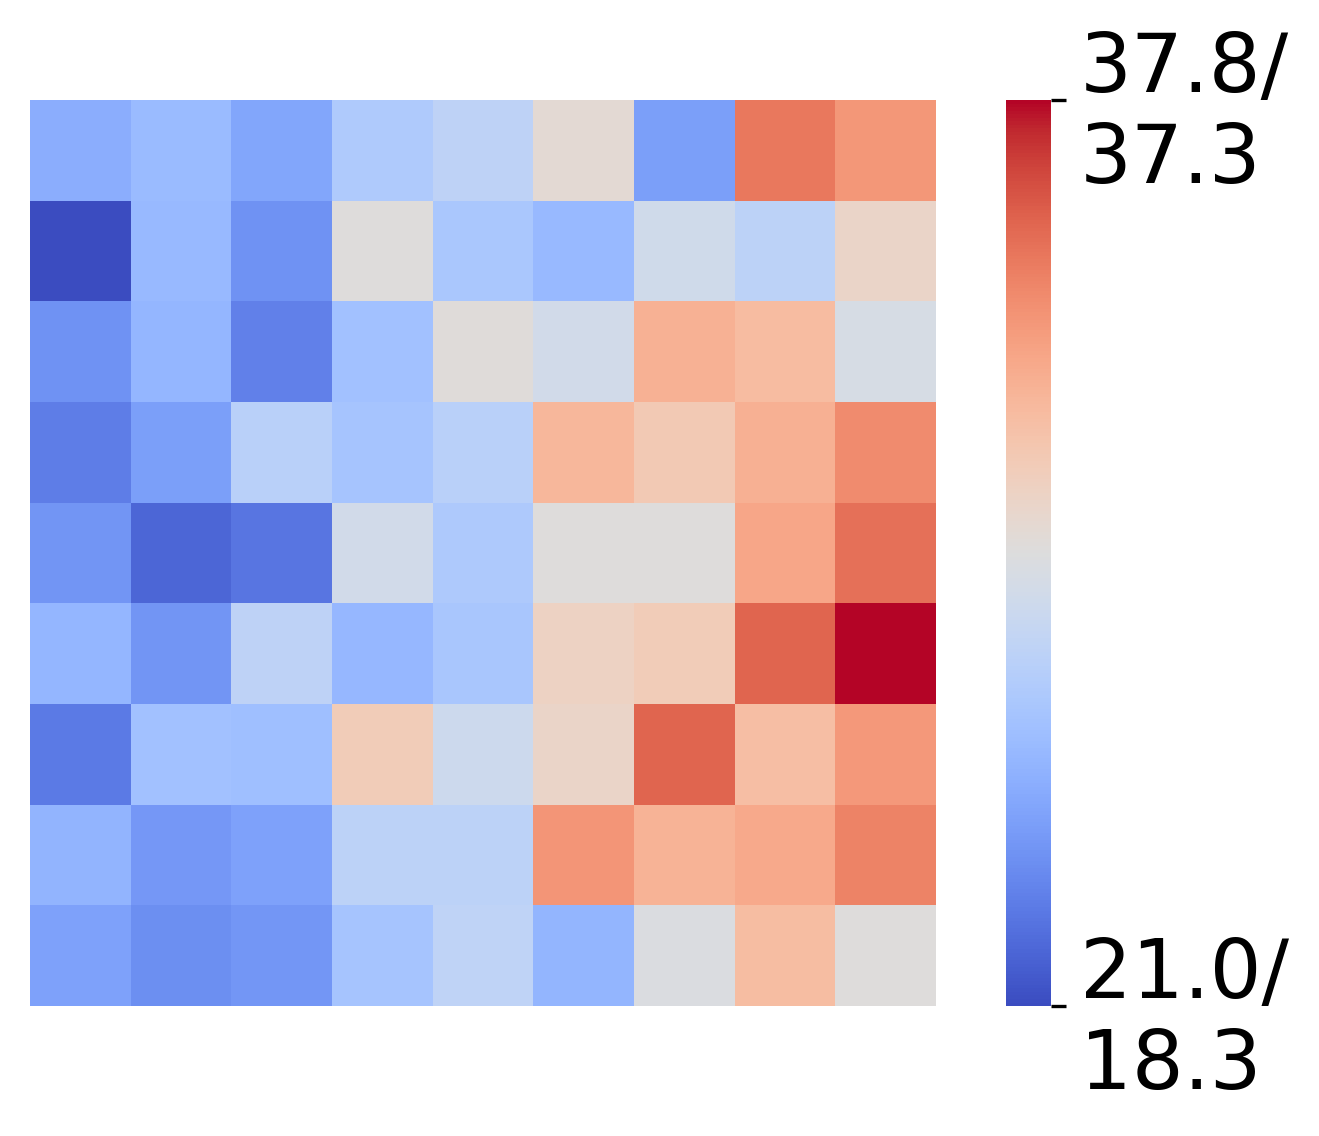

In [107]:
from human_utils_transdiagnostics import plot_td_quantile_analysis_results

quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), get_alternate_TD_representation(df['AD'], df['Compul'], method,-np.stack(df['n_sleeps'].values).sum(axis=1))[0], np.stack(df["effs"].values), "Rewards", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Rewards", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=True, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Rewards", col2name="AD", groups = None, num_bins=9, combine_groups = False, annot=False, flip_leastmost=True)


In [108]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_rewards_AD_residual.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_rewards_AD_residual.svg"))

### Compul

[[0.22119907 0.33740796 0.28661671 0.44315621 0.53622216 0.60234952
  0.37338777 0.87676443 0.77385502]
 [0.18727795 0.22398956 0.13525233 0.37862913 0.39881862 0.51083968
  0.5959621  0.67792814 0.7510601 ]
 [0.14838885 0.32126962 0.29385052 0.31754021 0.47217978 0.47172136
  0.70546185 0.74492398 0.66163524]
 [0.13330404 0.26901478 0.4498128  0.55810445 0.26494156 0.65229017
  0.56888682 0.8265462  0.75135135]
 [0.2100508  0.33738588 0.22398956 0.29712151 0.3891823  0.57680406
  0.59527447 0.619881   0.77824999]
 [0.22909423 0.10100947 0.15113937 0.42262291 0.47103373 0.48904572
  0.47998242 0.51990297 0.56613629]
 [0.33044752 0.24417904 0.31719639 0.44097871 0.4852017  0.54175898
  0.83503647 0.63926825 0.93810884]
 [0.19307026 0.10554112 0.21698916 0.56240688 0.35109543 0.32625969
  0.55185372 0.64700885 0.67419873]
 [0.21865847 0.24689295 0.24406444 0.29271621 0.3356081  0.51000362
  0.49560364 0.63101613 0.58977008]]


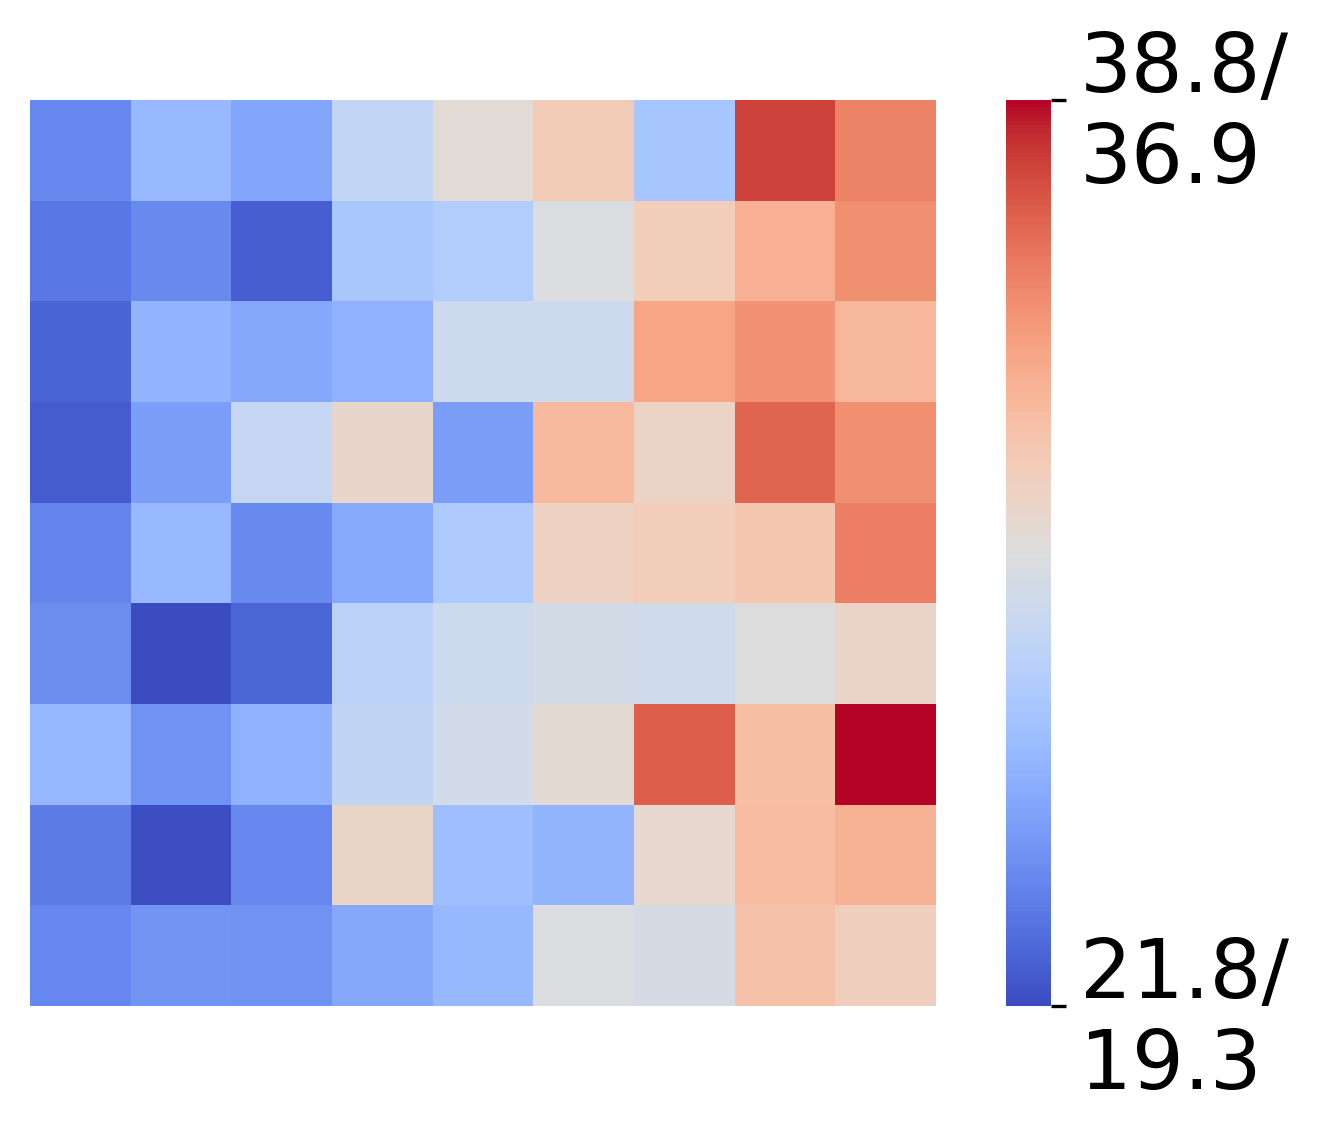

In [109]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Rewards", col2name = "Compul", groups = df["group"], num_bins =9, combine_groups = True, annot=False, square=square, axes_off=axes_off)

In [110]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_rewards_Compul.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_rewards_Compul.svg"))

### Compul Residual

PC1 loadings:  [0.72901262 0.68450026]
PC2 loadings:  [-0.68450026  0.72901262]
Variance explained by PC1:  0.6791482866096403
Variance explained by PC2:  0.3208517133903596
Flipped PC2 to enforce second component to be negative.
[[0.2636689  0.28431384 0.36620701 0.50234016 0.42105687 0.55543707
  0.61143001 0.5932977  0.80225966]
 [0.15880287 0.26719571 0.41424376 0.42887015 0.45829718 0.29627424
  0.61213746 0.56590589 0.56068192]
 [0.30689643 0.28974338 0.08775835 0.43017704 0.4100653  0.72114018
  0.75587831 0.72026892 0.71574196]
 [0.35060135 0.32639828 0.22296803 0.39404489 0.49347094 0.55693909
  0.41964197 0.84859925 0.79409789]
 [0.21765694 0.34494175 0.4293929  0.59690119 0.49259968 0.69563023
  0.47449184 0.78434696 0.98049815]
 [0.331448   0.36514061 0.40457995 0.55606783 0.47762478 0.75857562
  0.66951039 0.96526187 0.87262806]
 [0.30097545 0.27590113 0.35425705 0.47919305 0.4926868  0.65967233
  0.74865045 0.79357513 0.77294064]
 [0.25666065 0.30741918 0.25666065 0.47362

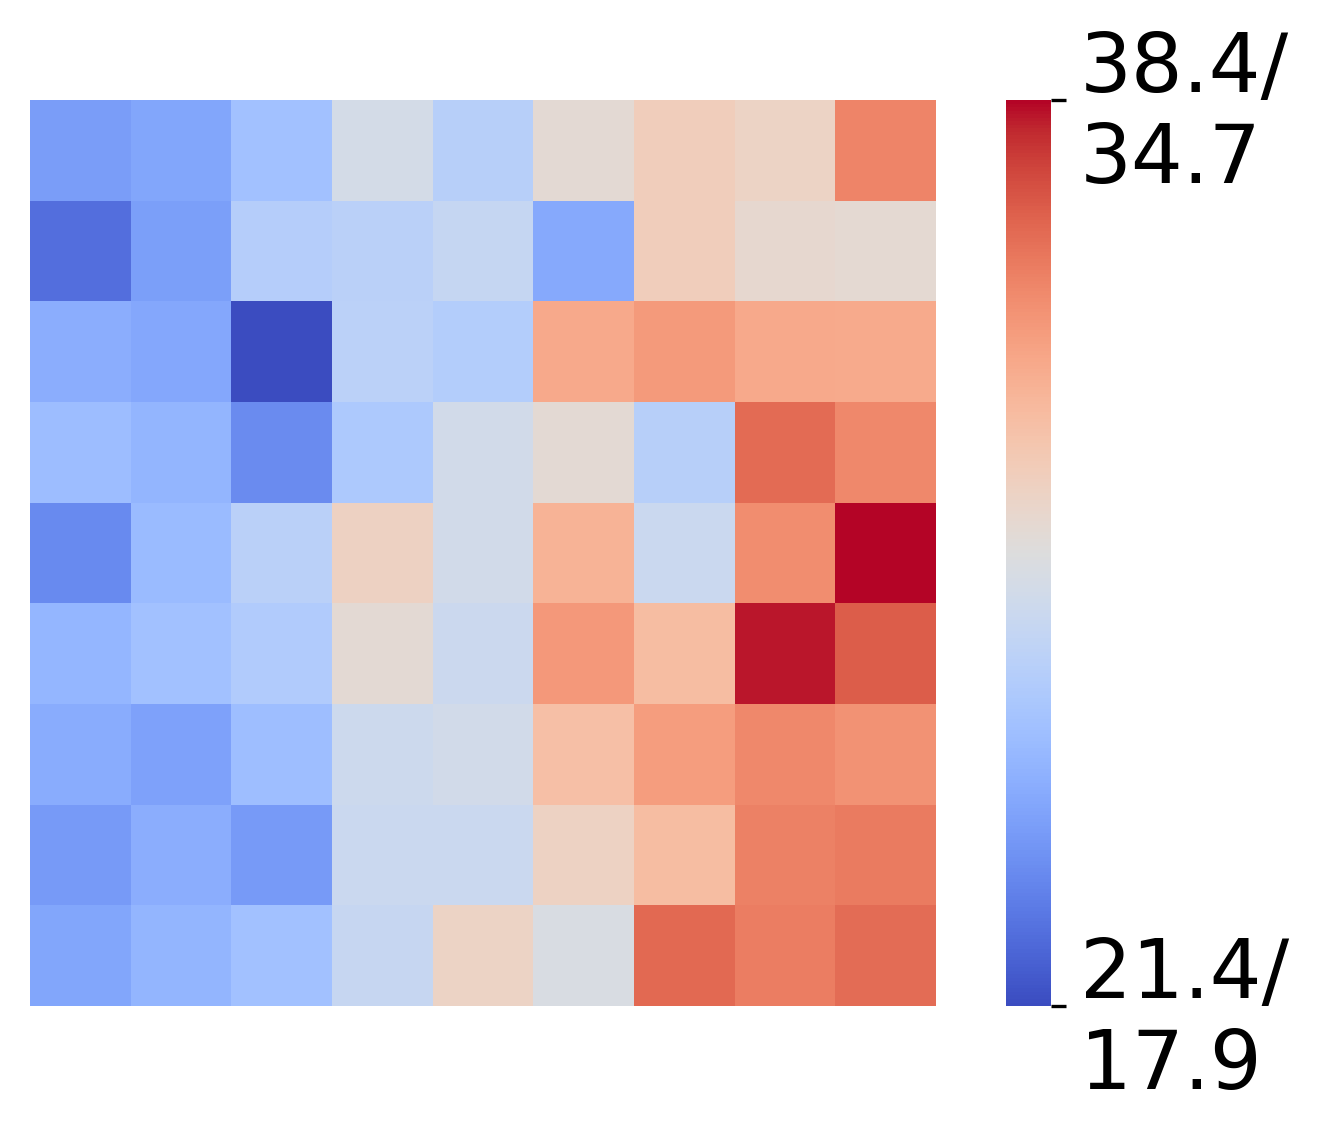

In [111]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), get_alternate_TD_representation(df['AD'], df['Compul'], method, -np.stack(df['n_sleeps'].values).sum(axis=1))[1], np.stack(df["effs"].values), "Rewards", col2name = "Compul", groups = df["group"], num_bins =9, combine_groups = True, annot=False, square=square, axes_off=axes_off)

In [112]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_rewards_Compul_residual.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_rewards_Compul_residual.svg"))

### SW

[[0.19668409 0.28312421 0.23605316 0.50647983 0.48869364 0.67335019
  0.61641826 0.73154768 0.79262838]
 [0.03795462 0.30060487 0.12046931 0.40300572 0.43072724 0.39397925
  0.40481567 0.41384214 0.53311257]
 [0.19457636 0.13795773 0.26445244 0.43553049 0.32407989 0.65661398
  0.73194318 0.87108426 0.88071405]
 [0.09939203 0.30180374 0.22288568 0.41927974 0.35482576 0.4789072
  0.53492252 0.77771764 0.78133754]
 [0.31325124 0.19395752 0.25841927 0.31685562 0.2536005  0.3813096
  0.48190826 0.6421499  0.61565053]
 [0.29217396 0.34217163 0.40542674 0.45301115 0.36807544 0.659035
  0.74580394 0.7054283  0.76385688]
 [0.29035625 0.25903035 0.29457946 0.46325201 0.57951362 0.60061418
  0.57771143 0.84638708 0.88916824]
 [0.27408998 0.19217085 0.32832639 0.3096391  0.48132047 0.56566838
  0.71567692 0.8060192  0.88734277]
 [0.18090353 0.1849507  0.20064105 0.47145571 0.50393732 0.44337773
  0.60358396 0.67842382 0.64228303]]


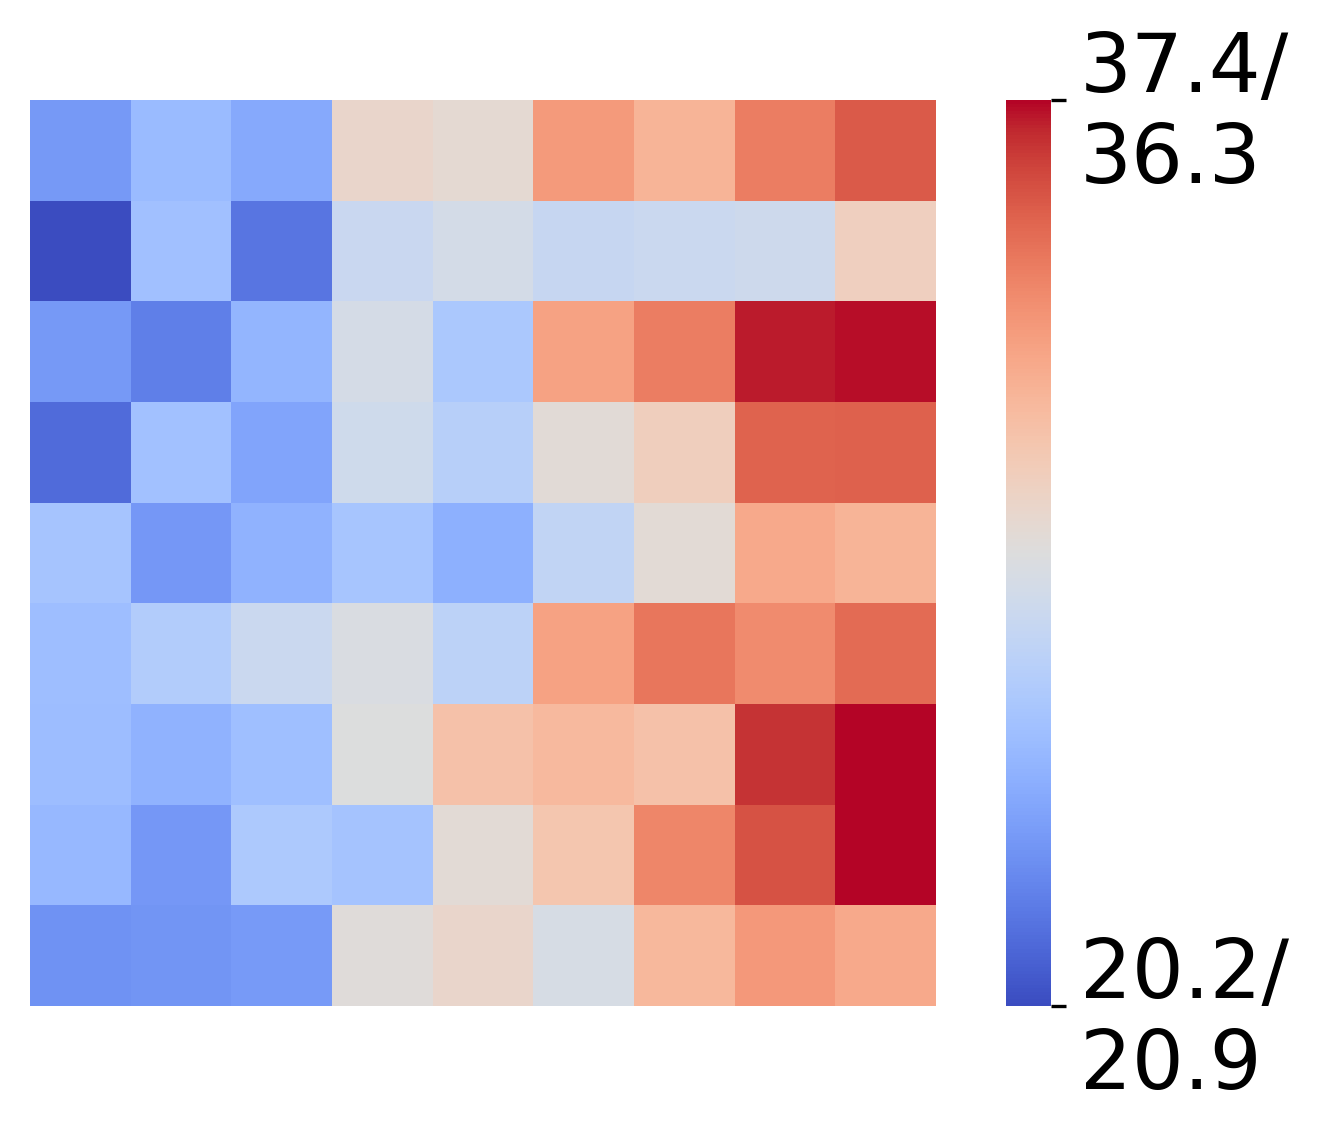

In [113]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), df['SW'], np.stack(df["effs"].values), "Observes", col2name = "SW", groups = df["group"], num_bins =9, combine_groups = True, annot=False, square=square, axes_off=axes_off)

In [114]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_rewards_SW.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_rewards_SW.svg"))

### Trait-level Simulations

In [115]:
from settings_anal import levc_human_ape_models as ape_models
from settings_anal import trait_simulated_participants_folder_t2 as simulated_participants_folder
from settings_anal import trait_sim_timestamp_t2 as sim_timestamp
from settings_anal import trait_sim_mag_perturbation as mag_perturbation
from settings_anal import trait_sim_bias_perturbation as bias_perturbation
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models

effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, sim_sleepss = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)
sim_sleepss = sim_sleepss.mean(axis=0)

## flip to correct for switching from tau to efficacy
sim_obss = np.flip(sim_obss.T,axis=1)
sim_sleepss = np.flip(sim_sleepss.T, axis=1)
sim_rewss = np.flip(sim_rewss.T, axis=1)

with open(os.path.join('data', 'sim_perturbed_participants', 'levc', 'sim', 'mag%dbias%d'%(mag_perturbation*100, bias_perturbation*100), '%s_simulated_participant_perturbations_sim_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

current mag perturbation 0.5 bias -0.8
[[25.42488235 26.73547059 28.22176471 29.546      30.93005882 31.80241176
  32.26264706 32.39994118 32.56141176]
 [26.08258824 27.37358824 28.66247059 29.97488235 31.30735294 32.20405882
  32.59570588 32.778      32.82847059]
 [26.08775    27.36475    28.6005     29.921625   31.286      32.4170625
  32.7979375  32.9330625  33.066625  ]
 [26.06276471 27.31317647 28.54764706 29.89929412 31.23070588 32.33170588
  32.88982353 33.00264706 33.15111765]
 [25.9579375  27.253125   28.477375   29.8355625  31.2093125  32.308625
  32.83575    33.0209375  33.2095625 ]
 [25.89917647 27.17405882 28.51882353 29.80005882 31.12882353 32.38064706
  32.98117647 33.14558824 33.26547059]
 [25.799875   27.089125   28.4604375  29.6679375  31.092875   32.384
  33.05525    33.32325    33.3794375 ]
 [25.64211765 26.86311765 28.09917647 29.40617647 30.831      32.23258824
  33.04770588 33.32552941 33.44335294]
 [25.16676471 26.42335294 27.68988235 29.10582353 30.57870588 32.

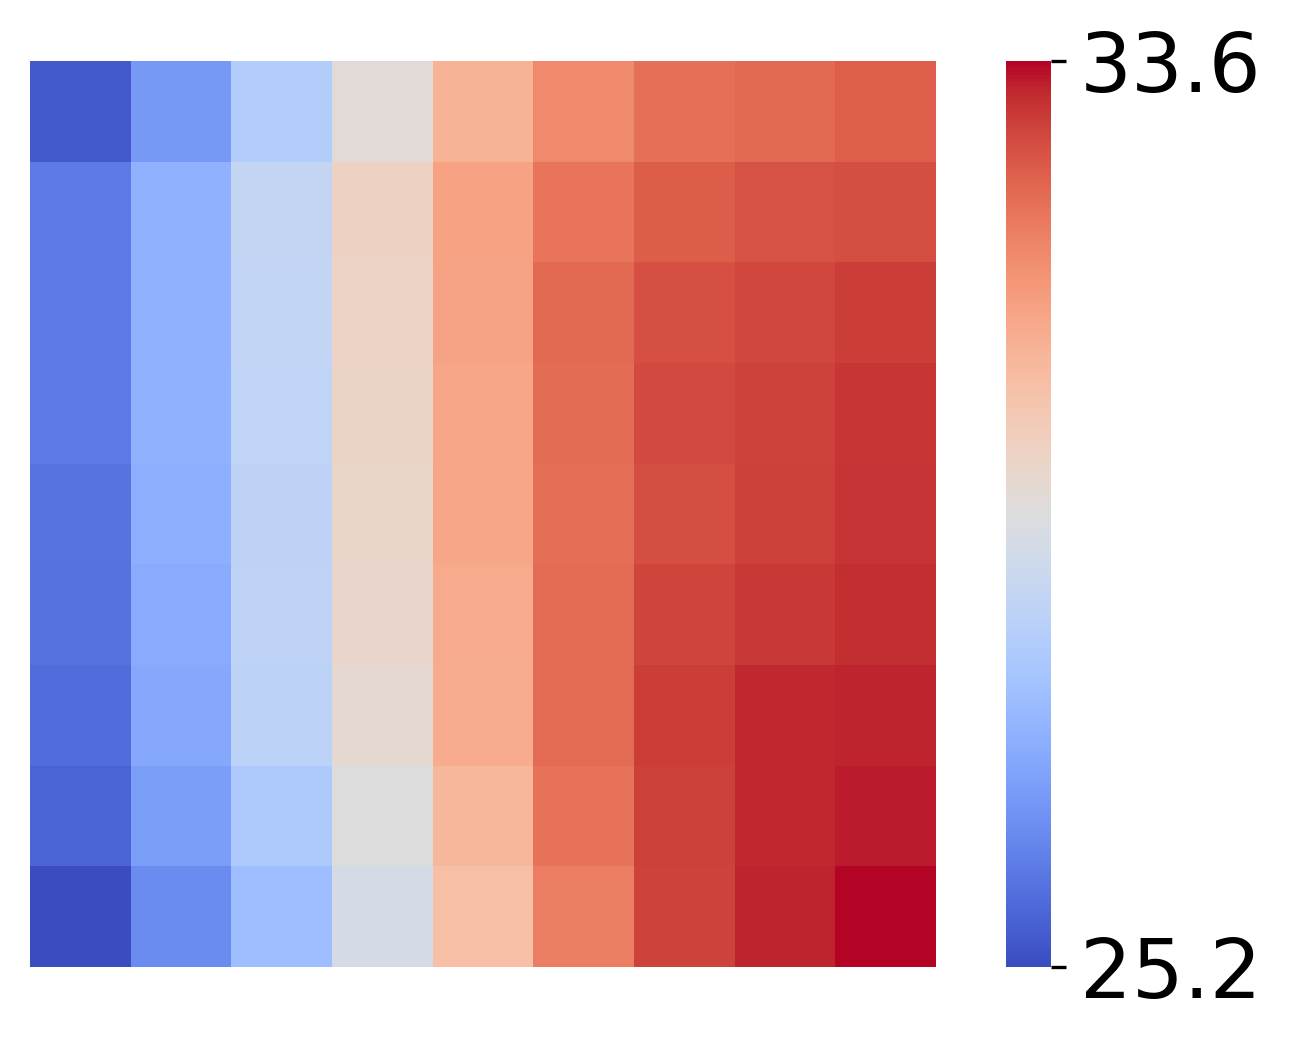

In [116]:
print("current mag perturbation", mag_perturbation, "bias", bias_perturbation)
quantile_fig = plot_td_quantile_analysis_results(sim_rewss, sim_participant_perturbations, effs, "Observes", col2name = "Belief", groups = None, num_bins =9, annot=False, square=square, axes_off=axes_off)

In [117]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_rewards_NN.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_rewards_NN.svg"))

### Permuted

In [118]:
from human_utils_behavioral_analysis import load_simulated_participants_across_models
from settings_anal import levc_human_ape_models as ape_models
from settings_anal import zeros_simulated_participants_folder_t2 as simulated_participants_folder
from settings_anal import zeros_sim_timestamp_t2 as sim_timestamp
from settings_anal import trait_sim_mag_perturbation as mag_perturbation
from settings_anal import trait_sim_bias_perturbation as bias_perturbation

effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, sim_sleepss = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)
sim_sleepss = sim_sleepss.mean(axis=0)

## flip to correct for switching from tau to efficacy
sim_obss = np.flip(sim_obss.T,axis=1)
sim_sleepss = np.flip(sim_sleepss.T, axis=1)
sim_rewss = np.flip(sim_rewss.T, axis=1)

with open(os.path.join('data', 'sim_perturbed_participants', 'levc', 'nostruc', 'mag%dbias%d'%(mag_perturbation*100, bias_perturbation*100), '%s_simulated_participant_perturbations_nostruc_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

[[26.00169333 27.29667333 28.58760667 29.87141333 31.22623333 32.35754
  32.90988667 33.0869     33.18137333]
 [26.00169333 27.29667333 28.58760667 29.87141333 31.22623333 32.35754
  32.90988667 33.0869     33.18137333]
 [26.00169333 27.29667333 28.58760667 29.87141333 31.22623333 32.35754
  32.90988667 33.0869     33.18137333]
 [26.00169333 27.29667333 28.58760667 29.87141333 31.22623333 32.35754
  32.90988667 33.0869     33.18137333]
 [26.00169333 27.29667333 28.58760667 29.87141333 31.22623333 32.35754
  32.90988667 33.0869     33.18137333]
 [26.00169333 27.29667333 28.58760667 29.87141333 31.22623333 32.35754
  32.90988667 33.0869     33.18137333]
 [26.00169333 27.29667333 28.58760667 29.87141333 31.22623333 32.35754
  32.90988667 33.0869     33.18137333]
 [26.00169333 27.29667333 28.58760667 29.87141333 31.22623333 32.35754
  32.90988667 33.0869     33.18137333]
 [26.00169333 27.29667333 28.58760667 29.87141333 31.22623333 32.35754
  32.90988667 33.0869     33.18137333]]


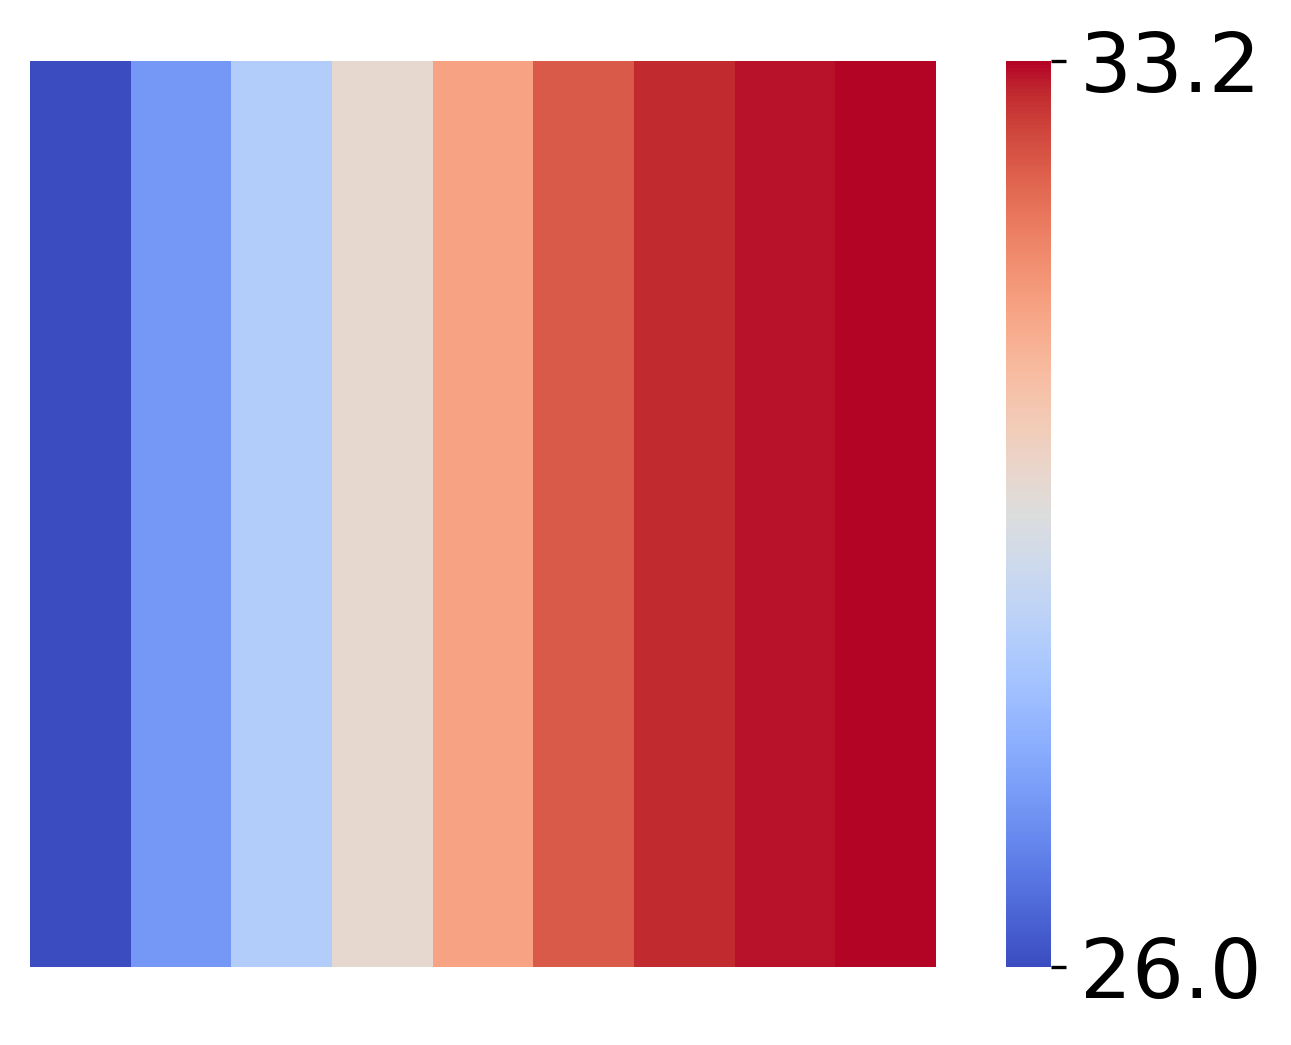

In [119]:
quantile_fig = plot_td_quantile_analysis_results(sim_rewss, sim_participant_perturbations, effs, "Observes", col2name = "Belief", groups = None, num_bins =9, annot=False, square=True, axes_off=True)

In [120]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_rewards_NN_permuted.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_rewards_NN_permuted.svg"))

## Panel F: Aggregated Similarities including unpermuted

In [121]:
from human_utils_behavioral_analysis import upper_tri_masking
from human_utils_transdiagnostics import compute_quantile_analysis
from sklearn.utils import resample

def combine_group_td_quantile_matrices(values, effs, tds, groups, num_bins=9, flip_leastmost = False, groupmins = None, groupmaxes = None, data_bins = None):

    if data_bins is None:
        data_bins = (None, None)
    
    quantile_matrix_g1, bins_g1 = compute_quantile_analysis(np.stack(values[~groups].values), tds[~groups], np.stack(effs[~groups].values),
                    num_bins=num_bins, flip_leastmost=flip_leastmost, bins=data_bins[0], take_quantile_on_col1=False)
    quantile_matrix_g2, bins_g2 = compute_quantile_analysis(np.stack(values[groups].values), tds[groups], np.stack(effs[groups].values), 
                    num_bins=num_bins, flip_leastmost = flip_leastmost, bins=data_bins[1], take_quantile_on_col1=False)
    
    if groupmins is None:
        groupmins = [np.nanmin(quantile_matrix_g1), np.nanmin(quantile_matrix_g2)]
    if groupmaxes is None:
        groupmaxes = [np.nanmax(quantile_matrix_g1), np.nanmax(quantile_matrix_g2)] 
    quantile_matrix_g1 = (quantile_matrix_g1 - groupmins[0])/(groupmaxes[0] - groupmins[0])
    quantile_matrix_g2 = (quantile_matrix_g2 - groupmins[1])/(groupmaxes[1] - groupmins[1])

    quantile_matrix = (~groups).sum() / len(df) * quantile_matrix_g1 + (groups).sum() / len(df) * quantile_matrix_g2

    return quantile_matrix, (bins_g1, bins_g2)

def compute_cosine_similarity(a, b, upper_tri = True, simmetric = simmetric):
    from sklearn.metrics.pairwise import cosine_similarity
    if upper_tri:
        a = upper_tri_masking(a)
        b = upper_tri_masking(b)
    if simmetric == 'cossim':
        sim = cosine_similarity(a.reshape((1,-1)), b.reshape((1,-1)))[0][0]
    elif simmetric == 'corr':
        sim = pearsonr(a.reshape((-1,)), b.reshape((-1,)))[0]
    return sim

def compute_resampled_td_cosine_similarity(item, groups,  item_effs, td, comparison, sim_participant_perturbations, effs = np.arange(0, 1.01, 0.125), n_iterations = 100, flip_leastmost=False, datamean = None, data_bins=None, meancenter = meancenter):

    #print(np.where(groups == False)[0].shape, np.where(groups == True)[0].shape)
    #print(item[np.where(groups == False)[0]], item[np.where(groups == True)[0]])

    #groupmins = [np.stack(item[np.where(groups == group)[0]].values).min() for group in [False, True]]
    #groupmaxes = [np.stack(item[np.where(groups == group)[0]].values).max() for group in [True, False]]

    data_bins=None
    #datamean=None

    bootstrapped_cos_sims = []
    for _ in range(n_iterations):
        indicesA = item.index[np.where(groups == False)[0]]
        indicesB = item.index[np.where(groups == True)[0]]

        bootstrapped_indicesA = resample(indicesA, replace=True, n_samples=len(indicesA))
        bootstrapped_indicesB = resample(indicesB, replace=False, n_samples=len(indicesB))
        bootstrapped_indices = np.sort(np.concatenate((bootstrapped_indicesA, bootstrapped_indicesB)))

        ## find corresponding integer indices
        bootstrapped_integer_indices = np.array([np.where(item.index == index)[0][0] for index in bootstrapped_indices])
        #print("check",bootstrapped_integer_indices)

        # print("td", td)
        # print("td shape", td.shape)
        #print("item bootstrap shape", item.loc[bootstrapped_indices].shape)

        #bootstrapped_indices_comparison = resample(np.arange(len(comparison)), replace=True, n_samples=len(comparison))

        #bootstrapped_data_corr, bootstrapped_data_pvs = combine_group_correlation_matrices(item.loc[bootstrapped_indices], df.loc[bootstrapped_indices, 'effs_day2'], df.loc[bootstrapped_indices, 'group_day2'].values)
        #bootstrapped_data_corr, bootstrapped_data_pvs = combine_group_correlation_matrices(item.loc[bootstrapped_indices], item_effs.loc[bootstrapped_indices], groups.loc[bootstrapped_indices], covar=covar_subindexed, effs_covar=effs_covar_subindexed, values2=item2_subindexed, effs2 = item2_effs_subindexed)
        bootstrapped_data_tds, _ = combine_group_td_quantile_matrices(item.loc[bootstrapped_indices], item_effs.loc[bootstrapped_indices], td[bootstrapped_integer_indices], groups.loc[bootstrapped_indices].values, num_bins=9, flip_leastmost=flip_leastmost, data_bins=data_bins)
        #bootstrapped_comp_corr, bootstrapped_comp_pvs = compute_2D_correlation_matrices(comparison, comparison2, effs, effs)
        bootstrapped_sim_tds, _ = compute_quantile_analysis(comparison, sim_participant_perturbations, effs, num_bins=9, take_quantile_on_col1=False)

        ## min-max norm of sim_tds
        # bootstrapped_data_tds = (bootstrapped_data_tds - bootstrapped_data_tds.min())/(bootstrapped_data_tds.max() - bootstrapped_data_tds.min())
        # ## min-max norm of sim_tds
        bootstrapped_sim_tds = (bootstrapped_sim_tds - bootstrapped_sim_tds.min())/(bootstrapped_sim_tds.max() - bootstrapped_sim_tds.min())

        ## MEAN CENTERED
        if (datamean is None and "center" in meancenter) or meancenter == "thiscenter":
            bootstrapped_data_tds = bootstrapped_data_tds - bootstrapped_data_tds.mean()
        elif meancenter == "datacenter":
            bootstrapped_data_tds = bootstrapped_data_tds - datamean
        # bootstrapped_sim_tds = bootstrapped_sim_tds - bootstrapped_sim_tds.mean()

        bootstrapped_cos_sim = compute_cosine_similarity(bootstrapped_data_tds, bootstrapped_sim_tds, upper_tri = False)
        bootstrapped_cos_sims.append(bootstrapped_cos_sim)
    return bootstrapped_cos_sims

def compute_resampled_td_cosine_similarity_difference(item, groups,  item_effs, td, comparison, sim_participant_perturbations, comparison2, sim_participant_perturbations2, effs = np.arange(0, 1.01, 0.125), n_iterations = 100, flip_leastmost=False, datamean=None, data_bins=None, td_name=None, item_name=None, difftype=difftype):

    data_bins=None
    datamean=None

    bootstrapped_cos_sims = []
    for i in range(n_iterations):
        indicesA = item.index[np.where(groups == False)[0]]
        indicesB = item.index[np.where(groups == True)[0]]

        bootstrapped_indicesA = resample(indicesA, replace=True, n_samples=len(indicesA))
        bootstrapped_indicesB = resample(indicesB, replace=False, n_samples=len(indicesB))
        bootstrapped_indices = np.sort(np.concatenate((bootstrapped_indicesA, bootstrapped_indicesB)))

        ## find corresponding integer indices
        bootstrapped_integer_indices = np.array([np.where(item.index == index)[0][0] for index in bootstrapped_indices])
        #print("check",bootstrapped_integer_indices)

        #bootstrapped_indices_comparison = resample(np.arange(len(comparison)), replace=True, n_samples=len(comparison))

        #bootstrapped_data_corr, bootstrapped_data_pvs = combine_group_correlation_matrices(item.loc[bootstrapped_indices], df.loc[bootstrapped_indices, 'effs_day2'], df.loc[bootstrapped_indices, 'group_day2'].values)
        #bootstrapped_data_corr, bootstrapped_data_pvs = combine_group_correlation_matrices(item.loc[bootstrapped_indices], item_effs.loc[bootstrapped_indices], groups.loc[bootstrapped_indices], covar=covar_subindexed, effs_covar=effs_covar_subindexed, values2=item2_subindexed, effs2 = item2_effs_subindexed)
        bootstrapped_data_tds, _ = combine_group_td_quantile_matrices(item.loc[bootstrapped_indices], item_effs.loc[bootstrapped_indices], td[bootstrapped_integer_indices], groups.loc[bootstrapped_indices].values, num_bins=9, flip_leastmost=flip_leastmost, data_bins=data_bins)
        #bootstrapped_comp_corr, bootstrapped_comp_pvs = compute_2D_correlation_matrices(comparison, comparison2, effs, effs)
        bootstrapped_sim_tds, _ = compute_quantile_analysis(comparison, sim_participant_perturbations, effs, num_bins=9, take_quantile_on_col1=False)
        bootstrapped_sim_tds2, _ = compute_quantile_analysis(comparison2, sim_participant_perturbations2, effs, num_bins=9, take_quantile_on_col1=False)

        ## min-max norm of sim_tds
        # bootstrapped_data_tds = (bootstrapped_data_tds - bootstrapped_data_tds.min())/(bootstrapped_data_tds.max() - bootstrapped_data_tds.min())
        # ## min-max norm of sim_tds
        bootstrapped_sim_tds = (bootstrapped_sim_tds - bootstrapped_sim_tds.min())/(bootstrapped_sim_tds.max() - bootstrapped_sim_tds.min())
        bootstrapped_sim_tds2 = (bootstrapped_sim_tds2 - bootstrapped_sim_tds2.min())/(bootstrapped_sim_tds2.max() - bootstrapped_sim_tds2.min())

        # fig = plot_td_quantile_analysis_results(np.stack(item.loc[bootstrapped_indices].values).squeeze(), td[bootstrapped_integer_indices], np.stack(item_effs.loc[bootstrapped_indices].values), item_name, col2name=td_name, groups =  groups.loc[bootstrapped_indices].values, num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=False)
        # os.makedirs(os.path.join(analysis_folder, 'bootstraps', td_name, item_name), exist_ok=True)
        # fig.savefig(os.path.join(analysis_folder, 'bootstraps', td_name, item_name, "td_quantile_%s_%s_BOOTSTRAP%d.png" %(td_name, item_name, i)))

        ## MEAN CENTER
        if (datamean is None and "center" in meancenter) or meancenter == "thiscenter":
            bootstrapped_data_tds = bootstrapped_data_tds - bootstrapped_data_tds.mean()
        elif meancenter == "datacenter":
            bootstrapped_data_tds = bootstrapped_data_tds - datamean
        # bootstrapped_sim_tds = bootstrapped_sim_tds - bootstrapped_sim_tds.mean()
        # bootstrapped_sim_tds2 = bootstrapped_sim_tds2 - bootstrapped_sim_tds2.mean()

        bootstrapped_cos_sim = compute_cosine_similarity(bootstrapped_data_tds, bootstrapped_sim_tds, upper_tri = False)
        bootstrapped_cos_sim2 = compute_cosine_similarity(bootstrapped_data_tds, bootstrapped_sim_tds2, upper_tri = False)
        if difftype == "diff":
            bootstrapped_cos_sims.append(bootstrapped_cos_sim - bootstrapped_cos_sim2)
        elif difftype == "logdiff":
            bootstrapped_cos_sims.append(np.log(bootstrapped_cos_sim) - np.log(bootstrapped_cos_sim2))
        elif difftype == "ratio":
            bootstrapped_cos_sims.append(bootstrapped_cos_sim / bootstrapped_cos_sim2)
        elif difftype == "frac_rem":
            bootstrapped_cos_sims.append((bootstrapped_cos_sim - bootstrapped_cos_sim2) / (1 - bootstrapped_cos_sim2))
        else:
            assert False, "invalid difftype"
    return bootstrapped_cos_sims

In [122]:
%%capture

rows = []

n_iterations=100

### TASK 1
human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

mask = 'nomask'
iday = 2
day = 'day%d' %iday
exp_date = '24-01-22-29'
with_nets = False
include_sleep = False
include_estimates = False
group = None

analysis_folder = os.path.join('panels', 'fig_transdiags')

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_anal import pepe_human_ape_models as ape_models
from settings_anal import trait_simulated_participants_folder_t1 as simulated_participants_folder
from settings_anal import trait_sim_timestamp_t1 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)

## flip to correct for switching from tau to efficacy
sim_obss = np.flip(sim_obss.T,axis=1)
sim_rewss = np.flip(sim_rewss.T, axis=1)

original_mag_perturbation = 1
with open(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'sim', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_sim_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

## ESTIMATES
sim_estss = (np.tile(np.arange(0, 1.01, 0.125), (len(sim_participant_perturbations),1)).T + sim_participant_perturbations).T

## LOAD UNPERTURBED
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_anal import pepe_human_ape_models as ape_models
#from settings_anal import trait_simulated_participants_folder_t1 as simulated_participants_folder
from settings_anal import zeros_simulated_participants_folder_t1 as simulated_participants_folder
from settings_anal import zeros_sim_timestamp_t1 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

zeros_rewss, zeros_obss, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)
zeros_rewss = zeros_rewss.mean(axis=0)
zeros_obss = zeros_obss.mean(axis=0)

## flip to correct for switching from tau to efficacy
zeros_obss = np.flip(zeros_obss.T,axis=1)
zeros_rewss = np.flip(zeros_rewss.T, axis=1)

original_mag_perturbation = 1
with open(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'nostruc', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_nostruc_mag.pkl' %sim_timestamp), 'rb') as f:
    zeros_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

## ESTIMATES
zeros_estss = (np.tile(np.arange(0, 1.01, 0.125), (len(zeros_participant_perturbations),1)).T + zeros_participant_perturbations).T

comparisons_names = ["Trait", "Zeros"]
comparisons_perturbations = [sim_participant_perturbations, zeros_participant_perturbations]

# for item_name, item, comparisons, in zip(['Observes', 'Rewards'], 
#             [df['n_observes'], df['rewards_tallies']], 
#             [[sim_obss, zeros_obss] ,[sim_rewss, zeros_rewss]],
#             ):
for item_name, item, comparisons, in zip(['Rews', 'Obs', 'Ests'], 
            [df['rewards_tallies'], df['n_observes'], df['efficacy_estimates']], 
            [[sim_rewss, zeros_rewss], [sim_obss, zeros_obss] , [sim_estss, zeros_estss]],
            ):
    for td_name in ['PC1', 'PC2', 'Compul', 'AD', 'SW']:
        print(item_name, td_name)
        for comparison_name, comparison, comparison_perturbations in zip(comparisons_names, comparisons, comparisons_perturbations):
            if td_name == 'PC1':
                td = get_alternate_TD_representation(df['AD'], df['Compul'], method, np.stack(df['n_observes'].values).sum(axis=1))[0]
            elif td_name == 'PC2':
                td = get_alternate_TD_representation(df['AD'], df['Compul'], method, np.stack(df['n_observes'].values).sum(axis=1))[1]
            else:
                td = df[td_name]
            if td_name == 'AD':
                #flip_leastmost = True
                flip_leastmost = False
            else:
                flip_leastmost = False
            data_tds, data_bins = combine_group_td_quantile_matrices(item, df['effs'], td, df['group'].values, flip_leastmost=flip_leastmost)
            
            #print(comparison, comparison_perturbations)
            sim_tds, _ = compute_quantile_analysis(comparison, comparison_perturbations, effs, num_bins=9, take_quantile_on_col1=False, )

            # # ## min-max norm of sim_tds
            # data_tds = (data_tds - data_tds.min())/(data_tds.max() - data_tds.min())
            # # min-max norm of sim_tds
            sim_tds = (sim_tds - sim_tds.min())/(sim_tds.max() - sim_tds.min())

            ## MEAN CENTER
            datamean = data_tds.mean()
            if "center" in meancenter:
                data_tds = data_tds - datamean
                sim_tds = sim_tds - sim_tds.mean()

            print(data_tds, sim_tds)
            cos_sim = compute_cosine_similarity(data_tds, sim_tds, upper_tri=False)
            #print(comparison_name)

            #bootstrapped_cos_sims = compute_resampled_td_cosine_similarity(item, df['group'], df['effs'], td, comparison, sim_participant_perturbations, n_iterations=n_iterations, flip_leastmost=flip_leastmost)
            bootstrapped_cos_sims = compute_resampled_td_cosine_similarity(item, df['group'], df['effs'], td, comparison, comparison_perturbations, n_iterations=n_iterations, flip_leastmost=flip_leastmost, datamean = datamean, data_bins=data_bins)
            ci = pd.Series(bootstrapped_cos_sims).quantile([0.025, 0.975])
            rows.append({"task": "T1", "Transdiagnostic": td_name, "item": item_name, "Comparison": comparison_name, "Cosine Similarity": cos_sim, "Lower": ci.iloc[0], "Upper": ci.iloc[1]})

for item_name, item, comparisons, in zip(['Rews', 'Obs', 'Ests'], 
            [df['rewards_tallies'], df['n_observes'], df['efficacy_estimates']], 
            [[sim_rewss, zeros_rewss], [sim_obss, zeros_obss] , [sim_estss, zeros_estss],],
            ):
    for td_name in ['PC1', 'PC2', 'Compul', 'AD', 'SW']:
        print(item_name, td_name)
        for comparison_name, comparison, comparison_perturbations in zip(comparisons_names, comparisons, comparisons_perturbations):
            if td_name == 'PC1':
                td = get_alternate_TD_representation(df['AD'], df['Compul'], method, np.stack(df['n_observes'].values).sum(axis=1))[0]
            elif td_name == 'PC2':
                td = get_alternate_TD_representation(df['AD'], df['Compul'], method, np.stack(df['n_observes'].values).sum(axis=1))[1]
            else:
                td = df[td_name]
        if td_name == 'AD':
            #flip_leastmost = True
            flip_leastmost = False
        else:
            flip_leastmost = False
        data_tds, data_bins = combine_group_td_quantile_matrices(item, df['effs'], td, df['group'].values, flip_leastmost=flip_leastmost)
        
        #print(comparison, comparison_perturbations)
        sim_tds, _ = compute_quantile_analysis(comparisons[0], comparisons_perturbations[0], effs, num_bins=9, take_quantile_on_col1=False, )
        print(sim_tds)
        sim_tds2, _ = compute_quantile_analysis(comparisons[1], comparisons_perturbations[1], effs, num_bins=9, take_quantile_on_col1=False, )

        ## min-max norm of sim_tds
        # data_tds = (data_tds - data_tds.min())/(data_tds.max() - data_tds.min())
        # ## min-max norm of sim_tds
        sim_tds = (sim_tds - sim_tds.min())/(sim_tds.max() - sim_tds.min())
        sim_tds2 = (sim_tds2 - sim_tds2.min())/(sim_tds2.max() - sim_tds2.min())
    
        ## MEAN CENTER
        datamean = data_tds.mean()
        if "center" in meancenter:
            data_tds = data_tds - datamean
            sim_tds = sim_tds - sim_tds.mean()
            sim_tds2 = sim_tds2 - sim_tds2.mean()

        #print(sim_tds)
        cos_sim = compute_cosine_similarity(data_tds, sim_tds, upper_tri=False)
        cos_sim2 = compute_cosine_similarity(data_tds, sim_tds2, upper_tri=False)
        if difftype == "diff":
            diff = cos_sim - cos_sim2
        elif difftype == "logdiff":
            diff = np.log(cos_sim) - np.log(cos_sim2)
        elif difftype == "ratio":
            diff = cos_sim / cos_sim2
        elif difftype == "frac_rem":
            diff = (cos_sim - cos_sim2) / (1 - cos_sim2)

        #print(comparison_name)
        
        #bootstrapped_cos_sims = compute_resampled_td_cosine_similarity(item, df['group'], df['effs'], td, comparison, sim_participant_perturbations, n_iterations=n_iterations, flip_leastmost=flip_leastmost)
        bootstrapped_cos_sims = compute_resampled_td_cosine_similarity_difference(item, df['group'], df['effs'], td, comparisons[0], 
            comparisons_perturbations[0], comparisons[1], comparisons_perturbations[1], n_iterations=n_iterations, 
            flip_leastmost=flip_leastmost, datamean=datamean, data_bins = data_bins, td_name= "T1 " + td_name, item_name=item_name)
        ci = pd.Series(bootstrapped_cos_sims).quantile([0.025, 0.975])
        rows.append({"task": "T1", "Transdiagnostic": td_name, "item": item_name, "Comparison": "Similarity Difference", "Cosine Similarity": diff, "Lower": ci.iloc[0], "Upper": ci.iloc[1], "N Positive Difference": (np.array(bootstrapped_cos_sims) > 0).sum()})


### TASK 2
human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

mask = 'nomask'
iday = 3
day = 'day%d' %iday
exp_date = '24-01-22-29'
with_nets = False
include_sleep = False
include_estimates = False
group = None

analysis_folder = os.path.join('panels', 'fig_transdiags')

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

from settings_anal import levc_human_ape_models as ape_models
from settings_anal import trait_simulated_participants_folder_t2 as simulated_participants_folder
from settings_anal import trait_sim_timestamp_t2 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, sim_sleepss = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)
sim_sleepss = sim_sleepss.mean(axis=0)

## flip to correct for switching from tau to efficacy
sim_obss = np.flip(sim_obss.T,axis=1)
sim_sleepss = np.flip(sim_sleepss.T, axis=1)
sim_rewss = np.flip(sim_rewss.T, axis=1)

from settings_anal import trait_sim_mag_perturbation as mag_perturbation
from settings_anal import trait_sim_bias_perturbation as bias_perturbation
with open(os.path.join('data', 'sim_perturbed_participants', 'levc', 'sim', 'mag%dbias%d'%(mag_perturbation*100, bias_perturbation*100), '%s_simulated_participant_perturbations_sim_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

## LOAD UNPERTURBED
from human_utils_behavioral_analysis import load_simulated_participants_across_models
from settings_anal import levc_human_ape_models as ape_models
from settings_anal import zeros_simulated_participants_folder_t2 as simulated_participants_folder
from settings_anal import zeros_sim_timestamp_t2 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

zeros_rewss, zeros_obss, zeros_sleepss = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)
zeros_rewss = zeros_rewss.mean(axis=0)
zeros_obss = zeros_obss.mean(axis=0)
zeros_sleepss = zeros_sleepss.mean(axis=0)

## flip to correct for switching from tau to efficacy
zeros_obss = np.flip(zeros_obss.T,axis=1)
zeros_rewss = np.flip(zeros_rewss.T, axis=1)
zeros_sleepss = np.flip(zeros_sleepss.T, axis=1)

# for item_name, item, comparisons in zip(['Sleeps', 'Obs', 'Rews'],
#                                          [df['n_sleeps'], df['n_observes'], df['rewards_tallies']], 
#                                          [[sim_sleepss, zeros_sleepss], [sim_obss, zeros_sleepss], [sim_rewss, zeros_sleepss]]):
for item_name, item, comparisons in zip([ 'Rews', 'Sleeps', 'Obs',],
                                         [ df['rewards_tallies'], df['n_sleeps'], df['n_observes'],], 
                                         [[sim_rewss, zeros_rewss], [sim_sleepss, zeros_sleepss], [sim_obss, zeros_obss], ]):

    for td_name in ['PC1', 'PC2', 'Compul', 'AD', 'SW']:
        print(item_name, td_name)
        for comparison_name, comparison, comparison_perturbations in zip(comparisons_names, comparisons, comparisons_perturbations):
            print(comparison_name, comparison, comparison_perturbations)
            if td_name == 'PC1':
                td = get_alternate_TD_representation(df['AD'], df['Compul'], method, np.stack(df['n_sleeps'].values).sum(axis=1))[0]
            elif td_name == 'PC2':
                td = get_alternate_TD_representation(df['AD'], df['Compul'], method, np.stack(df['n_sleeps'].values).sum(axis=1))[1]
            else:
                td = df[td_name]
            if td_name == 'AD':
                #flip_leastmost = True
                flip_leastmost = False
            else:
                flip_leastmost = False
            data_tds, data_bins = combine_group_td_quantile_matrices(item, df['effs'], td, df['group'].values, flip_leastmost=flip_leastmost)
            sim_tds, _ = compute_quantile_analysis(comparison, comparison_perturbations, effs, num_bins=9, take_quantile_on_col1=False, )
            
            ## min-max norm of sim_tds
            # data_tds = (data_tds - data_tds.min())/(data_tds.max() - data_tds.min())
            # ## min-max norm of sim_tds
            sim_tds = (sim_tds - sim_tds.min())/(sim_tds.max() - sim_tds.min())

            ## MEAN CENTER
            datamean = data_tds.mean()
            if "center" in meancenter:
                data_tds = data_tds - datamean
                sim_tds = sim_tds - sim_tds.mean()

            #print(data_tds, sim_tds)

            cos_sim = compute_cosine_similarity(data_tds, sim_tds, upper_tri=False)

            bootstrapped_cos_sims = compute_resampled_td_cosine_similarity(item, df['group'], df['effs'], td, comparison, comparison_perturbations, n_iterations=n_iterations, flip_leastmost=flip_leastmost, datamean=datamean, data_bins= data_bins)
            ci = pd.Series(bootstrapped_cos_sims).quantile([0.025, 0.975])
            rows.append({"task": "T2", "Transdiagnostic": td_name, "item": item_name, "Comparison": comparison_name, "Cosine Similarity": cos_sim, "Lower": ci.iloc[0], "Upper": ci.iloc[1]})

for item_name, item, comparisons in zip([ 'Rews', 'Sleeps', 'Obs',],
                                         [ df['rewards_tallies'], df['n_sleeps'], df['n_observes'],], 
                                         [[sim_rewss, zeros_rewss], [sim_sleepss, zeros_sleepss], [sim_obss, zeros_obss], ]):
    for td_name in ['PC1', 'PC2', 'Compul', 'AD', 'SW']:
        print(item_name, td_name)
        for comparison_name, comparison, comparison_perturbations in zip(comparisons_names, comparisons, comparisons_perturbations):
            if td_name == 'PC1':
                td = get_alternate_TD_representation(df['AD'], df['Compul'], method, np.stack(df['n_sleeps'].values).sum(axis=1))[0]
            elif td_name == 'PC2':
                td = get_alternate_TD_representation(df['AD'], df['Compul'], method, np.stack(df['n_sleeps'].values).sum(axis=1))[1]
            else:
                td = df[td_name]
            if td_name == 'AD':
                #flip_leastmost = True
                flip_leastmost = False
            else:
                flip_leastmost = False
            data_tds, data_bins = combine_group_td_quantile_matrices(item, df['effs'], td, df['group'].values, flip_leastmost=flip_leastmost)
            sim_tds, _ = compute_quantile_analysis(comparisons[0], comparisons_perturbations[0], effs, num_bins=9, take_quantile_on_col1=False, )
            sim_tds2, _ = compute_quantile_analysis(comparisons[1], comparisons_perturbations[1], effs, num_bins=9, take_quantile_on_col1=False, )
            
            ## min-max norm of sim_tds
            #data_tds = (data_tds - data_tds.min())/(data_tds.max() - data_tds.min())
            # ## min-max norm of sim_tds
            sim_tds = (sim_tds - sim_tds.min())/(sim_tds.max() - sim_tds.min())
            sim_tds2 = (sim_tds2 - sim_tds2.min())/(sim_tds2.max() - sim_tds2.min())

            ## MEAN CENTER
            datamean = data_tds.mean()
            if "center" in meancenter:
                data_tds = data_tds - data_tds.mean()
                sim_tds = sim_tds - sim_tds.mean()
                sim_tds2 = sim_tds2 - sim_tds2.mean()

            print(data_tds, sim_tds, sim_tds2)

            cos_sim = compute_cosine_similarity(data_tds, sim_tds, upper_tri=False)
            cos_sim2 = compute_cosine_similarity(data_tds, sim_tds2, upper_tri=False)
            if difftype == "diff":
                diff = cos_sim - cos_sim2
            elif difftype == "logidff":
                diff = np.log(cos_sim) - np.log(cos_sim2)
            elif difftype == "ratio":
                diff = cos_sim/cos_sim2
            elif difftype == "frac_rem":
                diff = (cos_sim - cos_sim2)/(1 - cos_sim2)

            bootstrapped_cos_sims = compute_resampled_td_cosine_similarity_difference(item, df['group'], df['effs'], td, comparisons[0],
                comparisons_perturbations[0], comparisons[1], comparisons_perturbations[1], n_iterations=n_iterations,
                flip_leastmost=flip_leastmost,  td_name="T2 " + td_name, item_name=item_name)
            ci = pd.Series(bootstrapped_cos_sims).quantile([0.025, 0.975])
            rows.append({"task": "T2", "Transdiagnostic": td_name, "item": item_name, "Comparison": "Similarity Difference", "Cosine Similarity": diff, "Lower": ci.iloc[0], "Upper": ci.iloc[1],"N Positive Difference": (np.array(bootstrapped_cos_sims) > 0).sum()})
        
### COMBINATION
df_cosim = pd.DataFrame(rows)

df_cosim['Name'] = df_cosim['task'] + ' ' + df_cosim['item'] #+ ' ' + df_cosim['Transdiagnostic']

print(df_cosim.head())

In [123]:
df_cosim.to_pickle(os.path.join(analysis_folder, 'df_cosim.pkl'))

In [124]:
df_cosim = pd.read_pickle(os.path.join(analysis_folder, 'df_cosim.pkl'))
#df_cosim.drop(label="N Positive Difference", inplace=True)
#df_cosim.drop(labels=df_cosim.columns[-2], inplace=True)
df_cosim = df_cosim.drop(columns=['N Positive Difference'])

#df_cosim = df_cosim[((df_cosim['Transdiagnostic'] == 'PC1') | (df_cosim['Transdiagnostic'] == 'PC2')) & (df_cosim['Comparison'] == 'Similarity Difference') & (df_cosim['item'] != 'Ests')]
df_cosim.round(3)[((df_cosim['Transdiagnostic'] == 'PC1') | (df_cosim['Transdiagnostic'] == 'PC2') )& (df_cosim['Comparison'] != 'Similarity Difference') ]
#df_cosim.columns

task Transdiagnostic    item Comparison  Cosine Similarity  Lower  Upper  \
0    T1             PC1    Rews      Trait              0.963  0.948  0.966   
1    T1             PC1    Rews      Zeros              0.893  0.856  0.895   
2    T1             PC2    Rews      Trait              0.957  0.936  0.958   
3    T1             PC2    Rews      Zeros              0.874  0.833  0.880   
10   T1             PC1     Obs      Trait              0.853  0.831  0.872   
11   T1             PC1     Obs      Zeros              0.831  0.811  0.845   
12   T1             PC2     Obs      Trait              0.853  0.808  0.865   
13   T1             PC2     Obs      Zeros              0.850  0.816  0.854   
20   T1             PC1    Ests      Trait              0.880  0.872  0.892   
21   T1             PC1    Ests      Zeros              0.984  0.975  0.984   
22   T1             PC2    Ests      Trait              0.892  0.880  0.900   
23   T1             PC2    Ests      Zeros              0.981  0.971  0.981   
45   T2             PC1    Rews      Trait              0.963  0.952  0.966   
46   T2             PC1    Rews      Zeros              0.955  0.940  0.958   
47   T2             PC2    Rews      Trait              0.970  0.956  0.970   
48   T2             PC2    Rews      Zeros              0.961  0.944  0.960   
55   T2             PC1  Sleeps      Trait              0.859  0.817  0.886   
56   T2             PC1  Sleeps      Zeros              0.908  0.885  0.917   
57   T2             PC2  Sleeps      Trait              0.889  0.859  0.914   
58   T2             PC2  Sleeps      Zeros              0.920  0.898  0.929   
65   T2             PC1     Obs      Trait              0.921  0.906  0.937   
66   T2             PC1     Obs      Zeros              0.822  0.801  0.844   
67   T2             PC2     Obs      Trait              0.916  0.881  0.930   
68   T2             PC2     Obs      Zeros              0.805  0.784  0.825   

         Name  
0     T1 Rews  
1     T1 Rews  
2     T1 Rews  
3     T1 Rews  
10     T1 Obs  
11     T1 Obs  
12     T1 Obs  
13     T1 Obs  
20    T1 Ests  
21    T1 Ests  
22    T1 Ests  
23    T1 Ests  
45    T2 Rews  
46    T2 Rews  
47    T2 Rews  
48    T2 Rews  
55  T2 Sleeps  
56  T2 Sleeps  
57  T2 Sleeps  
58  T2 Sleeps  
65     T2 Obs  
66     T2 Obs  
67     T2 Obs  
68     T2 Obs

In [125]:
df_cosim.round(3)[((df_cosim['Transdiagnostic'] != 'PC1') & (df_cosim['Transdiagnostic'] != 'PC2') )& (df_cosim['Comparison'] != 'Similarity Difference') ]

task Transdiagnostic    item Comparison  Cosine Similarity  Lower  Upper  \
4    T1          Compul    Rews      Trait              0.953  0.935  0.956   
5    T1          Compul    Rews      Zeros              0.878  0.839  0.877   
6    T1              AD    Rews      Trait              0.960  0.943  0.963   
7    T1              AD    Rews      Zeros              0.874  0.837  0.882   
8    T1              SW    Rews      Trait              0.960  0.941  0.965   
9    T1              SW    Rews      Zeros              0.892  0.848  0.898   
14   T1          Compul     Obs      Trait              0.826  0.788  0.846   
15   T1          Compul     Obs      Zeros              0.844  0.810  0.850   
16   T1              AD     Obs      Trait              0.864  0.832  0.885   
17   T1              AD     Obs      Zeros              0.829  0.808  0.840   
18   T1              SW     Obs      Trait              0.890  0.853  0.890   
19   T1              SW     Obs      Zeros              0.855  0.823  0.855   
24   T1          Compul    Ests      Trait              0.860  0.850  0.870   
25   T1          Compul    Ests      Zeros              0.981  0.972  0.983   
26   T1              AD    Ests      Trait              0.884  0.873  0.897   
27   T1              AD    Ests      Zeros              0.983  0.972  0.983   
28   T1              SW    Ests      Trait              0.872  0.857  0.880   
29   T1              SW    Ests      Zeros              0.987  0.979  0.987   
49   T2          Compul    Rews      Trait              0.968  0.957  0.969   
50   T2          Compul    Rews      Zeros              0.963  0.948  0.963   
51   T2              AD    Rews      Trait              0.968  0.955  0.969   
52   T2              AD    Rews      Zeros              0.961  0.947  0.961   
53   T2              SW    Rews      Trait              0.969  0.954  0.968   
54   T2              SW    Rews      Zeros              0.963  0.947  0.962   
59   T2          Compul  Sleeps      Trait              0.887  0.846  0.899   
60   T2          Compul  Sleeps      Zeros              0.923  0.896  0.926   
61   T2              AD  Sleeps      Trait              0.860  0.826  0.885   
62   T2              AD  Sleeps      Zeros              0.923  0.902  0.928   
63   T2              SW  Sleeps      Trait              0.908  0.869  0.924   
64   T2              SW  Sleeps      Zeros              0.921  0.901  0.927   
69   T2          Compul     Obs      Trait              0.883  0.866  0.914   
70   T2          Compul     Obs      Zeros              0.820  0.793  0.835   
71   T2              AD     Obs      Trait              0.921  0.902  0.937   
72   T2              AD     Obs      Zeros              0.798  0.777  0.825   
73   T2              SW     Obs      Trait              0.930  0.899  0.937   
74   T2              SW     Obs      Zeros              0.820  0.787  0.831   

         Name  
4     T1 Rews  
5     T1 Rews  
6     T1 Rews  
7     T1 Rews  
8     T1 Rews  
9     T1 Rews  
14     T1 Obs  
15     T1 Obs  
16     T1 Obs  
17     T1 Obs  
18     T1 Obs  
19     T1 Obs  
24    T1 Ests  
25    T1 Ests  
26    T1 Ests  
27    T1 Ests  
28    T1 Ests  
29    T1 Ests  
49    T2 Rews  
50    T2 Rews  
51    T2 Rews  
52    T2 Rews  
53    T2 Rews  
54    T2 Rews  
59  T2 Sleeps  
60  T2 Sleeps  
61  T2 Sleeps  
62  T2 Sleeps  
63  T2 Sleeps  
64  T2 Sleeps  
69     T2 Obs  
70     T2 Obs  
71     T2 Obs  
72     T2 Obs  
73     T2 Obs  
74     T2 Obs

In [126]:
#diff_df = df_cosim[df_cosim['Comparison'] == 'Similarity Difference']
df_cosim = df_cosim[((df_cosim['Transdiagnostic'] == 'PC1') | (df_cosim['Transdiagnostic'] == 'PC2')) & (df_cosim['Comparison'] == 'Similarity Difference') & (df_cosim['item'] != 'Ests')]

## change the column name from "Cosime Similarity" "Similarity Difference"
diff_df = df_cosim.rename(columns={'Cosine Similarity': 'Fraction Remaining'})

diff_df

task Transdiagnostic    item             Comparison  Fraction Remaining  \
30   T1             PC1    Rews  Similarity Difference            0.654449   
31   T1             PC2    Rews  Similarity Difference            0.662225   
35   T1             PC1     Obs  Similarity Difference            0.127936   
36   T1             PC2     Obs  Similarity Difference            0.014884   
75   T2             PC1    Rews  Similarity Difference            0.188413   
76   T2             PC1    Rews  Similarity Difference            0.188413   
77   T2             PC2    Rews  Similarity Difference            0.232416   
78   T2             PC2    Rews  Similarity Difference            0.232416   
85   T2             PC1  Sleeps  Similarity Difference           -0.528860   
86   T2             PC1  Sleeps  Similarity Difference           -0.528860   
87   T2             PC2  Sleeps  Similarity Difference           -0.399386   
88   T2             PC2  Sleeps  Similarity Difference           -0.399386   
95   T2             PC1     Obs  Similarity Difference            0.557145   
96   T2             PC1     Obs  Similarity Difference            0.557145   
97   T2             PC2     Obs  Similarity Difference            0.566145   
98   T2             PC2     Obs  Similarity Difference            0.566145   

       Lower     Upper       Name  
30  0.567547  0.697045    T1 Rews  
31  0.556542  0.698686    T1 Rews  
35  0.018463  0.289064     T1 Obs  
36 -0.209258  0.179842     T1 Obs  
75  0.162344  0.220143    T2 Rews  
76  0.161564  0.226980    T2 Rews  
77  0.200685  0.245074    T2 Rews  
78  0.190478  0.248199    T2 Rews  
85 -0.686965 -0.252455  T2 Sleeps  
86 -0.720951 -0.241331  T2 Sleeps  
87 -0.664978 -0.063940  T2 Sleeps  
88 -0.605092 -0.007769  T2 Sleeps  
95  0.500871  0.638006     T2 Obs  
96  0.494733  0.656393     T2 Obs  
97  0.437597  0.624569     T2 Obs  
98  0.401372  0.609895     T2 Obs

/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

0 0.5675470045222671 0.6970454434427564 0.6544489557614945
2 0.018463303503589996 0.2890639981796936 0.12793604514612378
4 0.16234422549916572 0.22014293864820814 0.18841334763866513
8 -0.6869653242746013 -0.25245464953275165 -0.5288598415947613
12 0.5008708442592993 0.6380056959438963 0.5571447601971904
1 0.5565421211444719 0.6986862785743501 0.662225179770374
3 -0.20925839051921824 0.17984178571903414 0.014883699243695214
6 0.2006851666743035 0.24507354441711104 0.232416082642498
10 -0.6649782356358324 -0.06394001678964045 -0.39938589218779663
14 0.4375971148143378 0.6245686815938839 0.5661448539485385


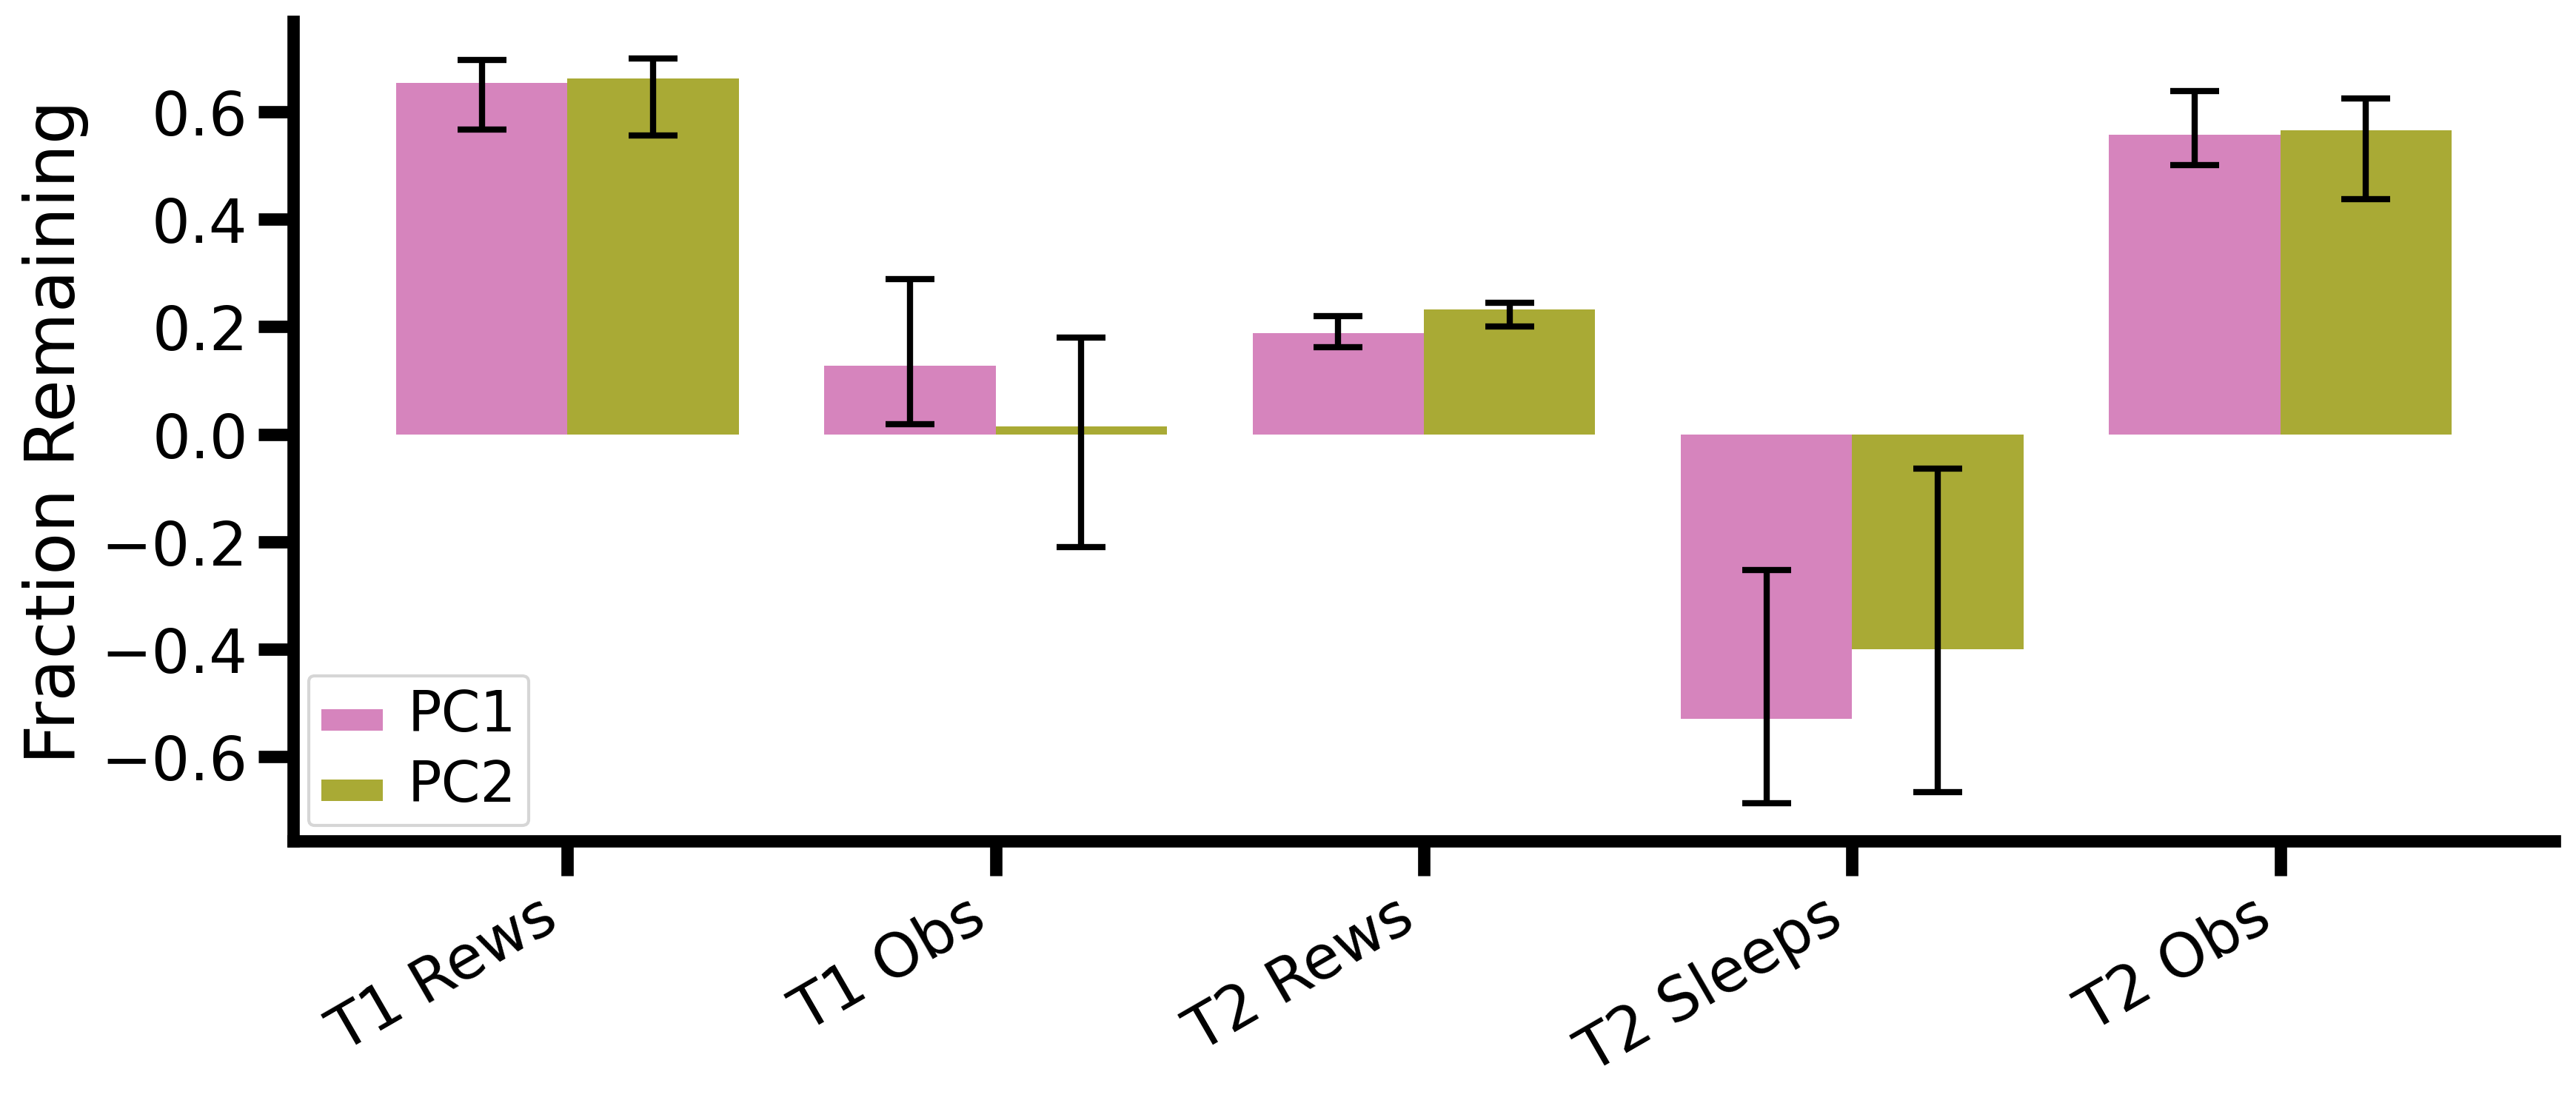

In [127]:
import seaborn as sns

fig = plt.figure(figsize=(13.135, 4.886), dpi=300)
ax = fig.add_subplot(111)

#y_name = 'Similarity Difference'
y_name = 'Fraction Remaining'

### Create a Seaborn
s = sns.barplot(x='Name', y=y_name, data=diff_df, ax=ax, hue='Transdiagnostic', palette=['C6', 'C8'])

# Remove the legend title
legend = ax.legend()
legend.set_title('')

ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xlabel(None)

for bar in ax.patches:
    # Get the height of the bar
    height = bar.get_height()
    # Find the index where 'Cosine Similarity' is close to the height of the bar
    index = np.where(np.isclose(diff_df[y_name], height))[0][0]
    lower = diff_df.loc[diff_df.index[index], 'Lower']
    upper = diff_df.loc[diff_df.index[index], 'Upper']
    mean = diff_df.loc[diff_df.index[index], y_name]
    print(index, lower, upper, mean)
    plt.errorbar(x=bar.get_x() + bar.get_width() / 2, y=mean, 
                 yerr=[[mean-lower], [upper-mean]], fmt='none', ecolor='black', capsize=8, elinewidth=2, markeredgewidth=2)
    
# new_value = 0.3
# for patch in ax.patches :
#     current_width = patch.get_width()
#     diff = current_width - new_value

#     # we change the bar width
#     patch.set_width(new_value)

#     # we recenter the bar
#     patch.set_x(patch.get_x() + diff * .5)

format_axis(ax, font_size_multiplier=1.4)

In [128]:
fig.savefig(os.path.join(analysis_folder, 'similarity_barplot_pcs.png'))
fig.savefig(os.path.join(analysis_folder, 'similarity_barplot_pcs.svg'))

/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

0 0.5675470045222671 0.6970454434427564 0.6544489557614945
2 0.018463303503589996 0.2890639981796936 0.12793604514612378
4 0.16234422549916572 0.22014293864820814 0.18841334763866513
8 -0.6869653242746013 -0.25245464953275165 -0.5288598415947613
12 0.5008708442592993 0.6380056959438963 0.5571447601971904


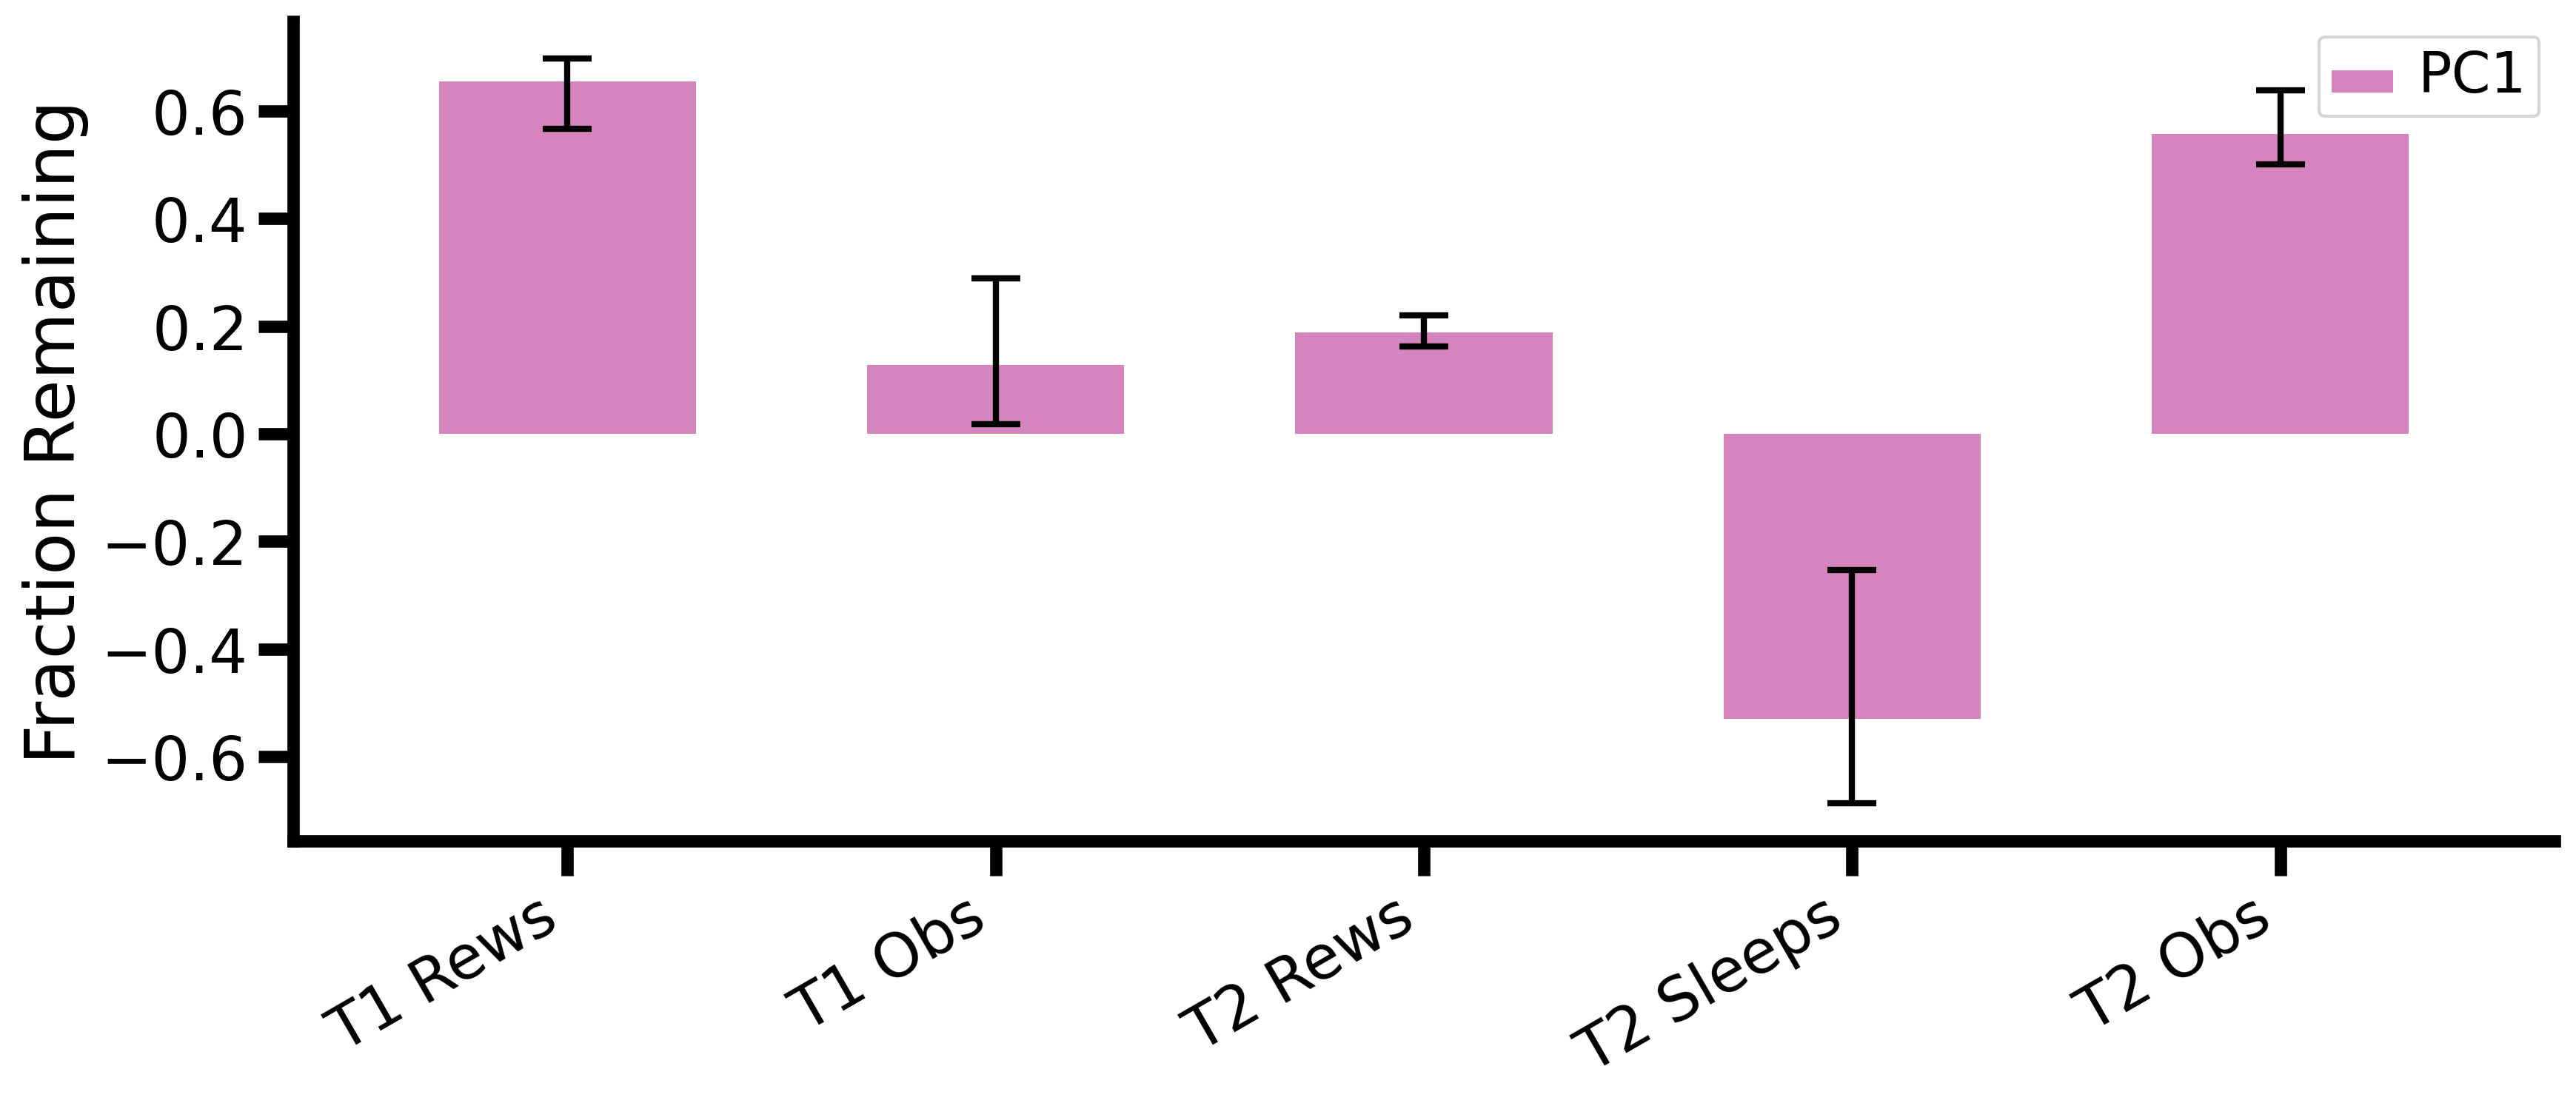

In [129]:
import seaborn as sns

fig = plt.figure(figsize=(13.135, 4.886), dpi=300)
ax = fig.add_subplot(111)

y_name = 'N Positive Difference'
y_name = 'Fraction Remaining'


### Create a Seaborn
s = sns.barplot(x='Name', y=y_name, data=diff_df[diff_df['Transdiagnostic'] == "PC1"], ax=ax, hue='Transdiagnostic', palette=['C6', 'C8'])

# Remove the legend title
legend = ax.legend()
legend.set_title('')

ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xlabel(None)

for bar in ax.patches:
    # Get the height of the bar
    height = bar.get_height()
    # Find the index where 'Cosine Similarity' is close to the height of the bar
    index = np.where(np.isclose(diff_df[y_name], height))[0][0]
    lower = diff_df.loc[diff_df.index[index], 'Lower']
    upper = diff_df.loc[diff_df.index[index], 'Upper']
    mean = diff_df.loc[diff_df.index[index], y_name]
    print(index, lower, upper, mean)
    plt.errorbar(x=bar.get_x() + bar.get_width() / 2, y=mean, 
                 yerr=[[mean-lower], [upper-mean]], fmt='none', ecolor='black', capsize=8, elinewidth=2, markeredgewidth=2)
    
new_value = 0.6
for patch in ax.patches :
    current_width = patch.get_width()
    diff = current_width - new_value

    # we change the bar width
    patch.set_width(new_value)

    # we recenter the bar
    patch.set_x(patch.get_x() + diff * .5)

    
format_axis(ax, font_size_multiplier=1.4)

In [130]:
fig.savefig(os.path.join(analysis_folder, 'similarity_barplot_pc1.png'))
fig.savefig(os.path.join(analysis_folder, 'similarity_barplot_pc1.svg'))

/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

1 0.5565421211444719 0.6986862785743501 0.662225179770374
3 -0.20925839051921824 0.17984178571903414 0.014883699243695214
6 0.2006851666743035 0.24507354441711104 0.232416082642498
10 -0.6649782356358324 -0.06394001678964045 -0.39938589218779663
14 0.4375971148143378 0.6245686815938839 0.5661448539485385


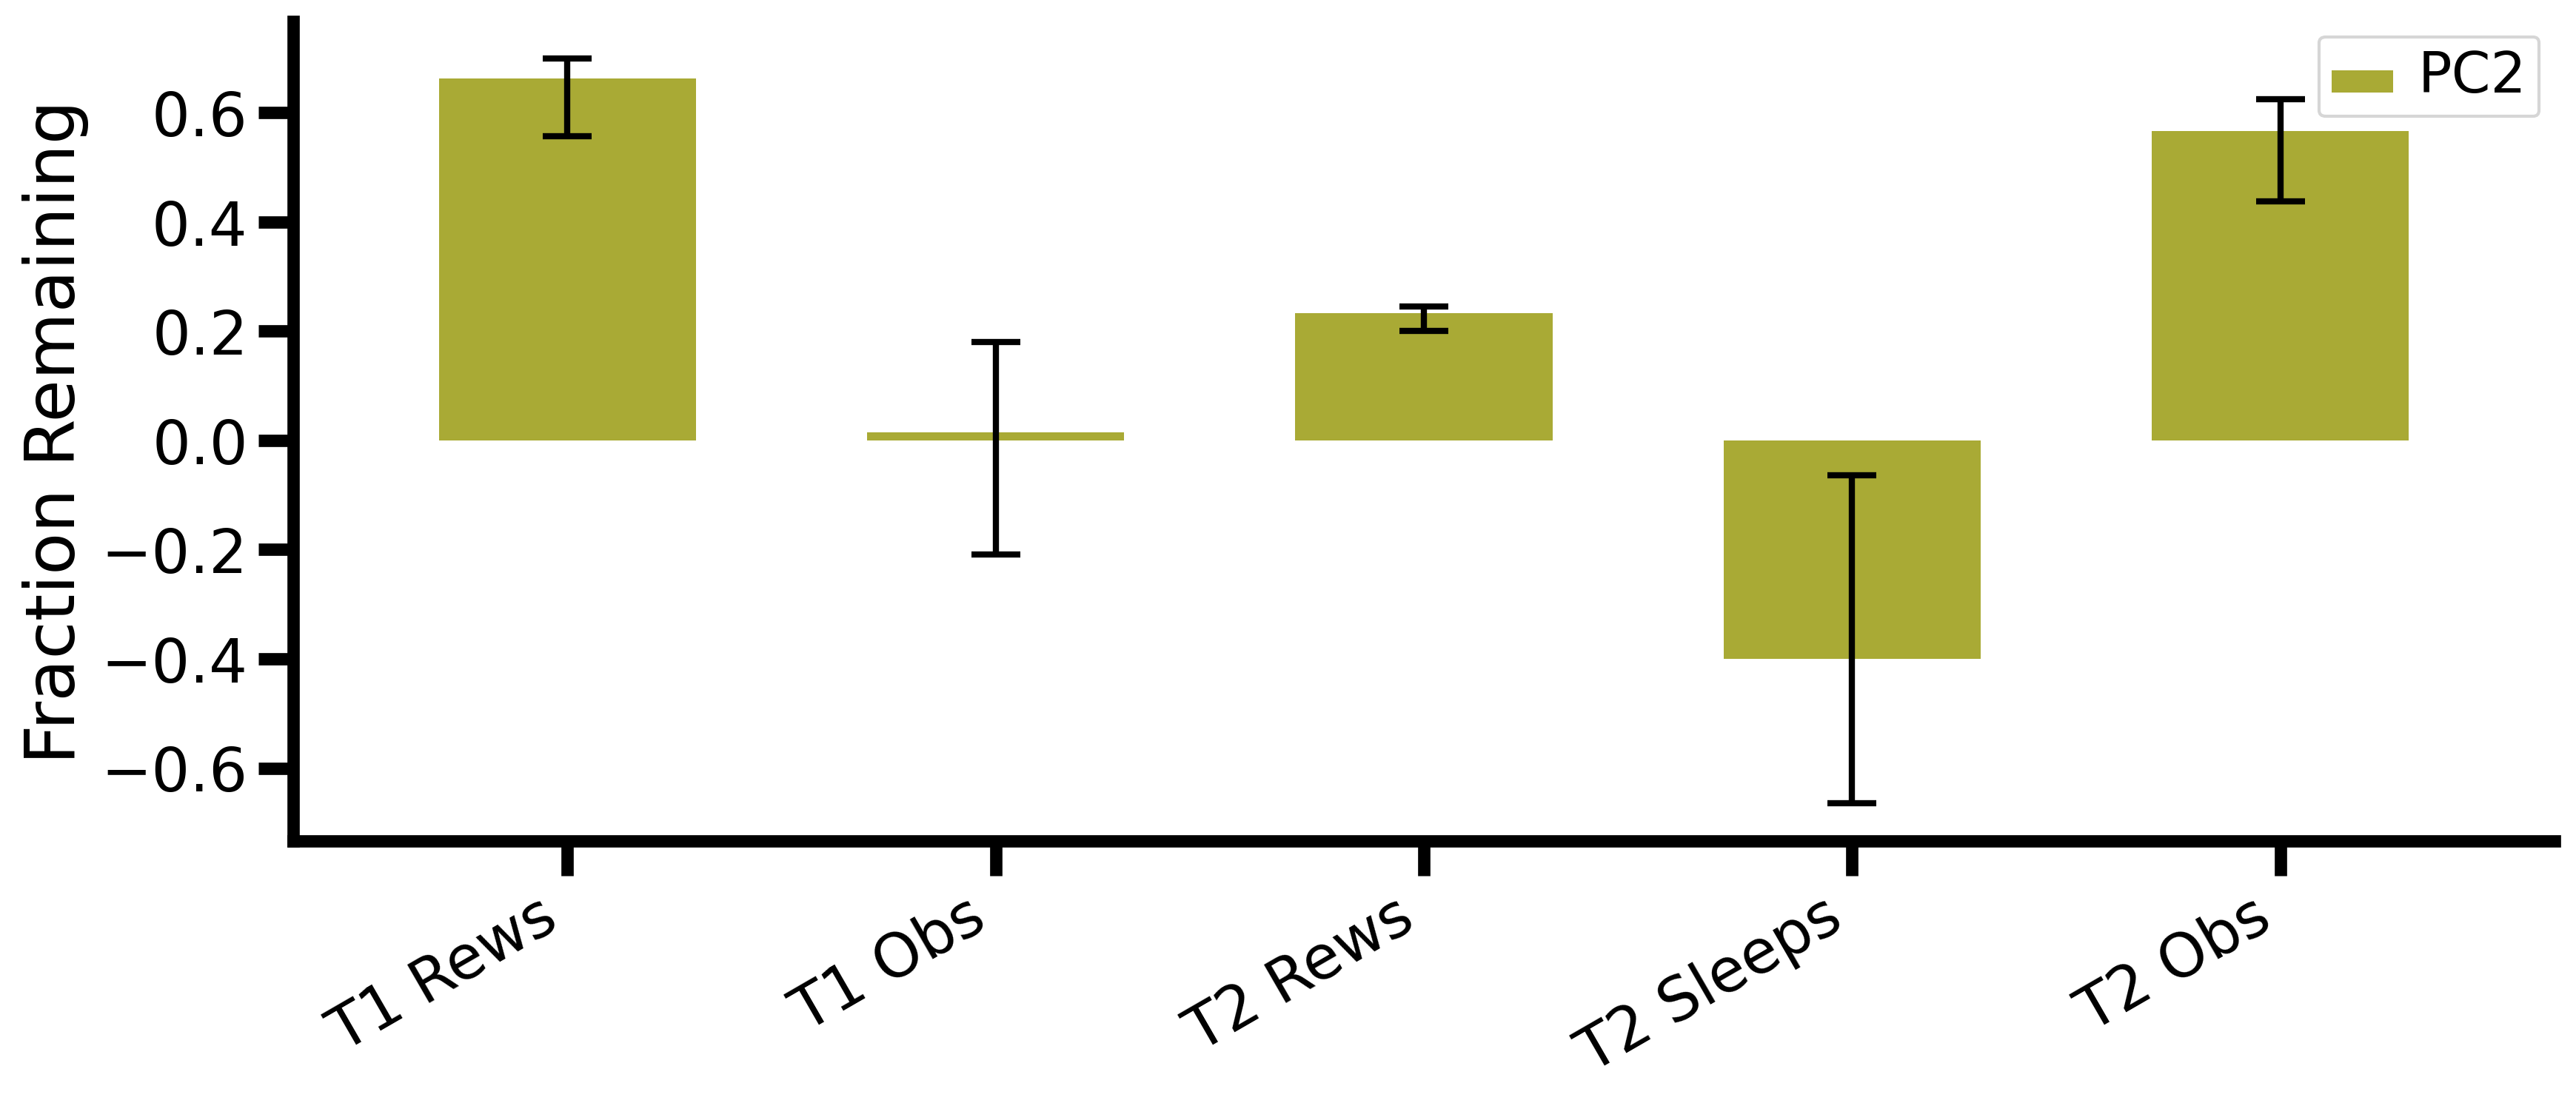

In [131]:
import seaborn as sns

fig = plt.figure(figsize=(13.135, 4.886), dpi=300)
ax = fig.add_subplot(111)

y_name = 'N Positive Difference'
y_name = 'Fraction Remaining'


### Create a Seaborn
s = sns.barplot(x='Name', y=y_name, data=diff_df[diff_df['Transdiagnostic'] == "PC2"], ax=ax, hue='Transdiagnostic', palette=['C8'])

# Remove the legend title
legend = ax.legend()
legend.set_title('')

ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xlabel(None)

for bar in ax.patches:
    # Get the height of the bar
    height = bar.get_height()
    # Find the index where 'Cosine Similarity' is close to the height of the bar
    index = np.where(np.isclose(diff_df[y_name], height))[0][0]
    lower = diff_df.loc[diff_df.index[index], 'Lower']
    upper = diff_df.loc[diff_df.index[index], 'Upper']
    mean = diff_df.loc[diff_df.index[index], y_name]
    print(index, lower, upper, mean)
    plt.errorbar(x=bar.get_x() + bar.get_width() / 2, y=mean, 
                 yerr=[[mean-lower], [upper-mean]], fmt='none', ecolor='black', capsize=8, elinewidth=2, markeredgewidth=2)
    
new_value = 0.6
for patch in ax.patches :
    current_width = patch.get_width()
    diff = current_width - new_value

    # we change the bar width
    patch.set_width(new_value)

    # we recenter the bar
    patch.set_x(patch.get_x() + diff * .5)

    
format_axis(ax, font_size_multiplier=1.4)

In [132]:
fig.savefig(os.path.join(analysis_folder, 'similarity_barplot_pc2.png'))
fig.savefig(os.path.join(analysis_folder, 'similarity_barplot_pc2.svg'))

## Panel G: Optimal Linear Projection
### Task 1 Observes

In [133]:
def plot_optimal_combination_model(y_loweff, y_pred_loweff, y_higheff, y_pred_higheff, ylabel = None):
    fig = plt.figure(dpi=300, figsize=(10.639, 4.754))
    ax = fig.add_subplot(111)
    #ax.scatter(y_pred_loweff, y_loweff, s=10, color='cyan', label='Low Efficacy Data', alpha=0.5)
    #ax.scatter(y_pred_loweff, y_loweff, s=10, color='lime', label='Low Efficacy Data', alpha=0.9, marker='D')
    #ax.scatter(y_pred_loweff, y_loweff, color='lime', label='Low Efficacy Data', alpha=0.75, marker='D', s=80)
    ax.scatter(y_pred_loweff, y_loweff, color='lime', label=r'$\xi \in \{0, 0.125, 0.25, 0.375\}$', alpha=0.75, marker='D', s=80)

    ## plot diagonal line across whole plot
    # min_value = y_pred_loweff.min()
    # max_value = y_pred_loweff.max()
    # ax.plot([min_value, max_value], [min_value, max_value], color='cyan', linestyle='--', label='Prediction')
    # ax.legend()

    #ax.scatter(y_pred_higheff, y_higheff, s=10, color='darkslategrey', label='High Efficacy Data', alpha=0.5)
    #ax.scatter(y_pred_higheff, y_higheff, color='darkgreen', label='High Efficacy Data', alpha=0.85, s=80)
    ax.scatter(y_pred_higheff, y_higheff, color='darkgreen', label=r'$\xi \in \{0.625, 0.75, 0.875, 1\}$', alpha=0.85, s=80)

    ## plot diagonal line across whole plot
    min_value = min(y_pred_loweff.min(), y_pred_higheff.min())
    max_value = max(y_pred_higheff.max(), y_pred_loweff.max())
    
    ax.plot([min_value, max_value], [min_value, max_value], color='black', linestyle='--', label='Prediction')
    ax.legend()

    format_axis(ax, font_size_multiplier=1.4)
    ax.set_xlabel('Linear AD/Compul Prediction')
    ax.set_ylabel(ylabel)
    return fig

In [134]:
human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

mask = 'nomask'
iday = 2
day = 'day%d' %iday
exp_date = '24-01-22-29'
with_nets = False
include_sleep = False
include_estimates = False
group = None

analysis_folder = os.path.join('panels', 'fig_transdiags')

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

df['n_observes_higheff'] = df['n_observes'].apply(lambda x : np.mean(x[:4]))
df['n_observes_loweff'] = df['n_observes'].apply(lambda x : np.mean(x[5:]))

In [135]:
X = df[['AD', 'Compul']]
y_loweff = df['n_observes_loweff']
X = sm.add_constant(X)
model_loweff = sm.OLS(y_loweff,X)
results_loweff = model_loweff.fit()
results_loweff.params
results_loweff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      n_observes_loweff   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.278
Date:                Thu, 29 Aug 2024   Prob (F-statistic):              0.283
Time:                        13:19:25   Log-Likelihood:                -288.82
No. Observations:                 111   AIC:                             583.6
Df Residuals:                     108   BIC:                             591.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.9803      0.321     18.614      0.000       5.343       6.617
AD             0.5921      0.379      1.563      0.121      -0.159       1.343
Compul        -0.3385      0.387     -0.874      0.384      -1.106       0.430
==============================================================================
Omnibus:                        3.177   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.204   Jarque-Bera (JB):                2.569
Skew:                           0.333   Prob(JB):                        0.277
Kurtosis:                       3.334   Cond. No.                         1.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [136]:
X = df[['AD', 'Compul']]
y_higheff = df['n_observes_higheff']
X = sm.add_constant(X)
model_higheff = sm.OLS(y_higheff,X)
results_higheff = model_higheff.fit()
results_higheff.params 
results_higheff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     n_observes_higheff   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.692
Date:                Thu, 29 Aug 2024   Prob (F-statistic):              0.189
Time:                        13:19:25   Log-Likelihood:                -287.90
No. Observations:                 111   AIC:                             581.8
Df Residuals:                     108   BIC:                             589.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4829      0.319     20.345      0.000       5.851       7.114
AD             0.6232      0.376      1.659      0.100      -0.121       1.368
Compul         0.0575      0.384      0.150      0.881      -0.704       0.819
==============================================================================
Omnibus:                        3.490   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.175   Jarque-Bera (JB):                3.258
Skew:                           0.420   Prob(JB):                        0.196
Kurtosis:                       2.987   Cond. No.                         1.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

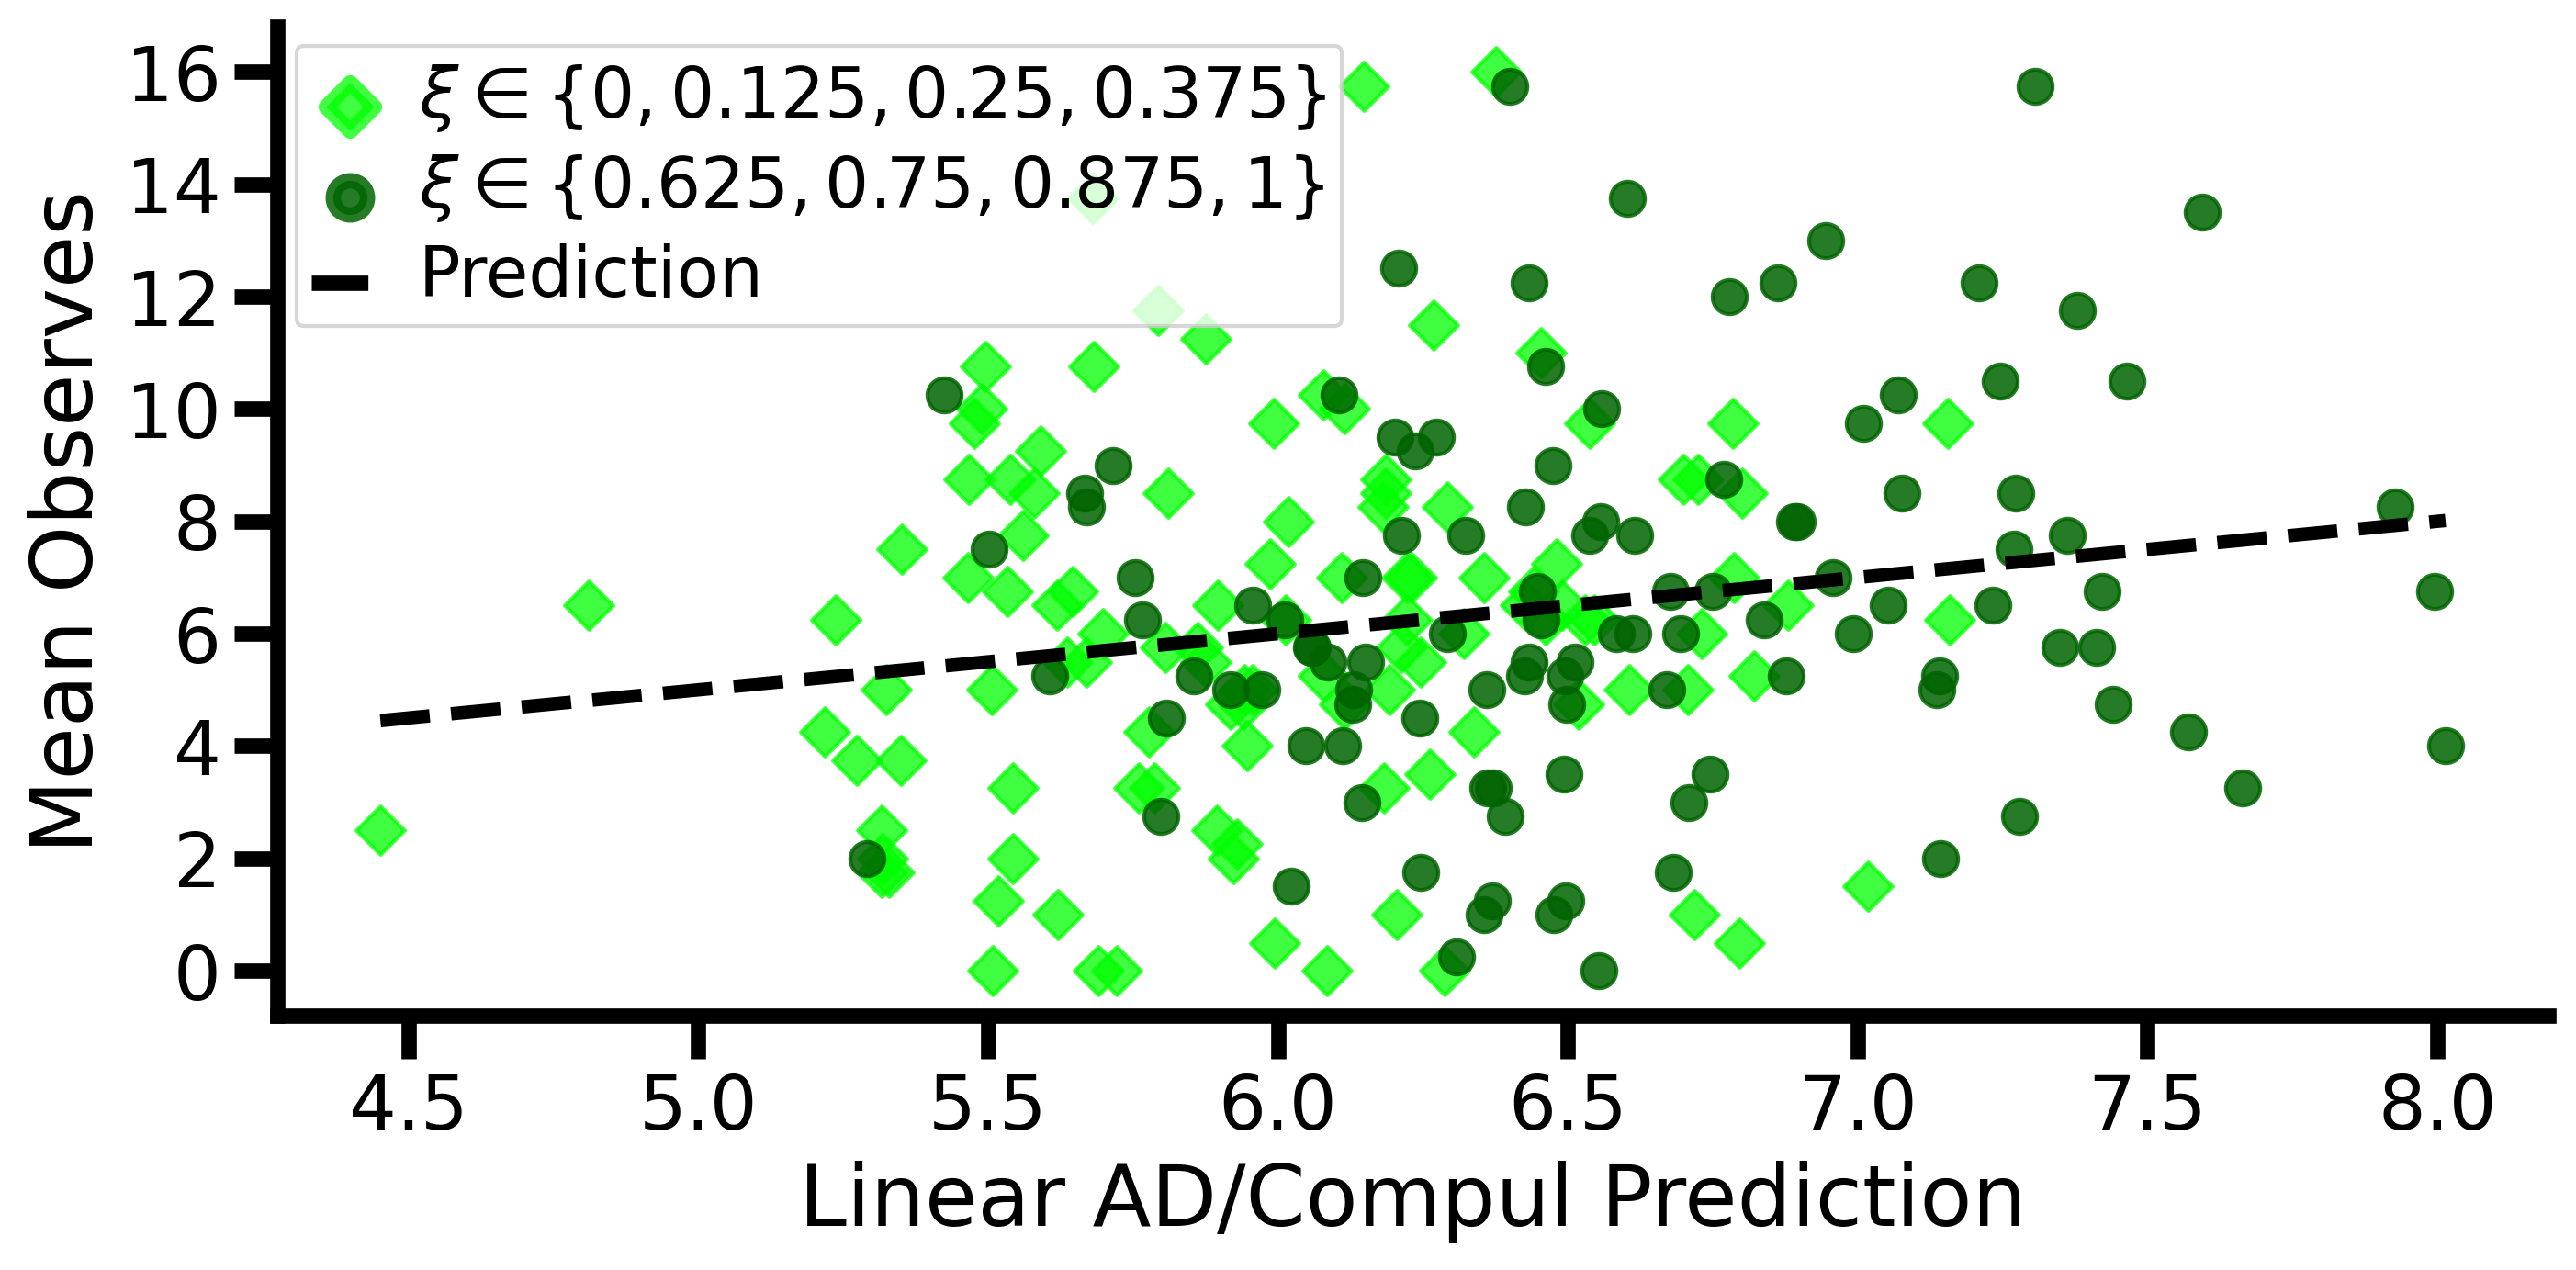

In [137]:
fig = plot_optimal_combination_model(y_loweff, results_loweff.predict(X), y_higheff, results_higheff.predict(X), ylabel='Mean Observes')

In [138]:
fig.savefig(os.path.join(analysis_folder, 'lm_task1_observes.png'))
fig.savefig(os.path.join(analysis_folder, 'lm_task1_observes.svg'))

### Task 1 Rewards

In [139]:
human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

mask = 'nomask'
iday = 2
day = 'day%d' %iday
exp_date = '24-01-22-29'
with_nets = False
include_sleep = False
include_estimates = False
group = None

analysis_folder = os.path.join('panels', 'fig_transdiags')

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

df['rewards_tallies_higheff'] = df['rewards_tallies'].apply(lambda x : np.mean(x[:4]))
df['rewards_tallies_loweff'] = df['rewards_tallies'].apply(lambda x : np.mean(x[5:]))

In [140]:
X = df[['AD', 'Compul']]
y_loweff = df['rewards_tallies_loweff']
X = sm.add_constant(X)
model_loweff = sm.OLS(y_loweff,X)
results_loweff = model_loweff.fit()
results_loweff.params
results_loweff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     rewards_tallies_loweff   R-squared:                       0.019
Model:                                OLS   Adj. R-squared:                  0.001
Method:                     Least Squares   F-statistic:                     1.038
Date:                    Thu, 29 Aug 2024   Prob (F-statistic):              0.358
Time:                            13:19:26   Log-Likelihood:                -265.78
No. Observations:                     111   AIC:                             537.6
Df Residuals:                         108   BIC:                             545.7
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.5492      0.261     97.868      0.000      25.032      26.067
AD             0.4279      0.308      1.390      0.167      -0.182       1.038
Compul        -0.0453      0.315     -0.144      0.886      -0.669       0.579
==============================================================================
Omnibus:                        1.722   Durbin-Watson:                   2.618
Prob(Omnibus):                  0.423   Jarque-Bera (JB):                1.756
Skew:                           0.250   Prob(JB):                        0.416
Kurtosis:                       2.641   Cond. No.                         1.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [141]:
X = df[['AD', 'Compul']]
y_higheff = df['rewards_tallies_higheff']
X = sm.add_constant(X)
model_higheff = sm.OLS(y_higheff,X)
results_higheff = model_higheff.fit()
results_higheff.params
results_higheff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     rewards_tallies_higheff   R-squared:                       0.002
Model:                                 OLS   Adj. R-squared:                 -0.016
Method:                      Least Squares   F-statistic:                    0.1228
Date:                     Thu, 29 Aug 2024   Prob (F-statistic):              0.885
Time:                             13:19:26   Log-Likelihood:                -260.41
No. Observations:                      111   AIC:                             526.8
Df Residuals:                          108   BIC:                             535.0
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.5029      0.249    102.529      0.000      25.010      25.996
AD             0.1029      0.293      0.351      0.726      -0.478       0.684
Compul         0.0603      0.300      0.201      0.841      -0.534       0.655
==============================================================================
Omnibus:                        7.144   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                6.949
Skew:                          -0.483   Prob(JB):                       0.0310
Kurtosis:                       3.754   Cond. No.                         1.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

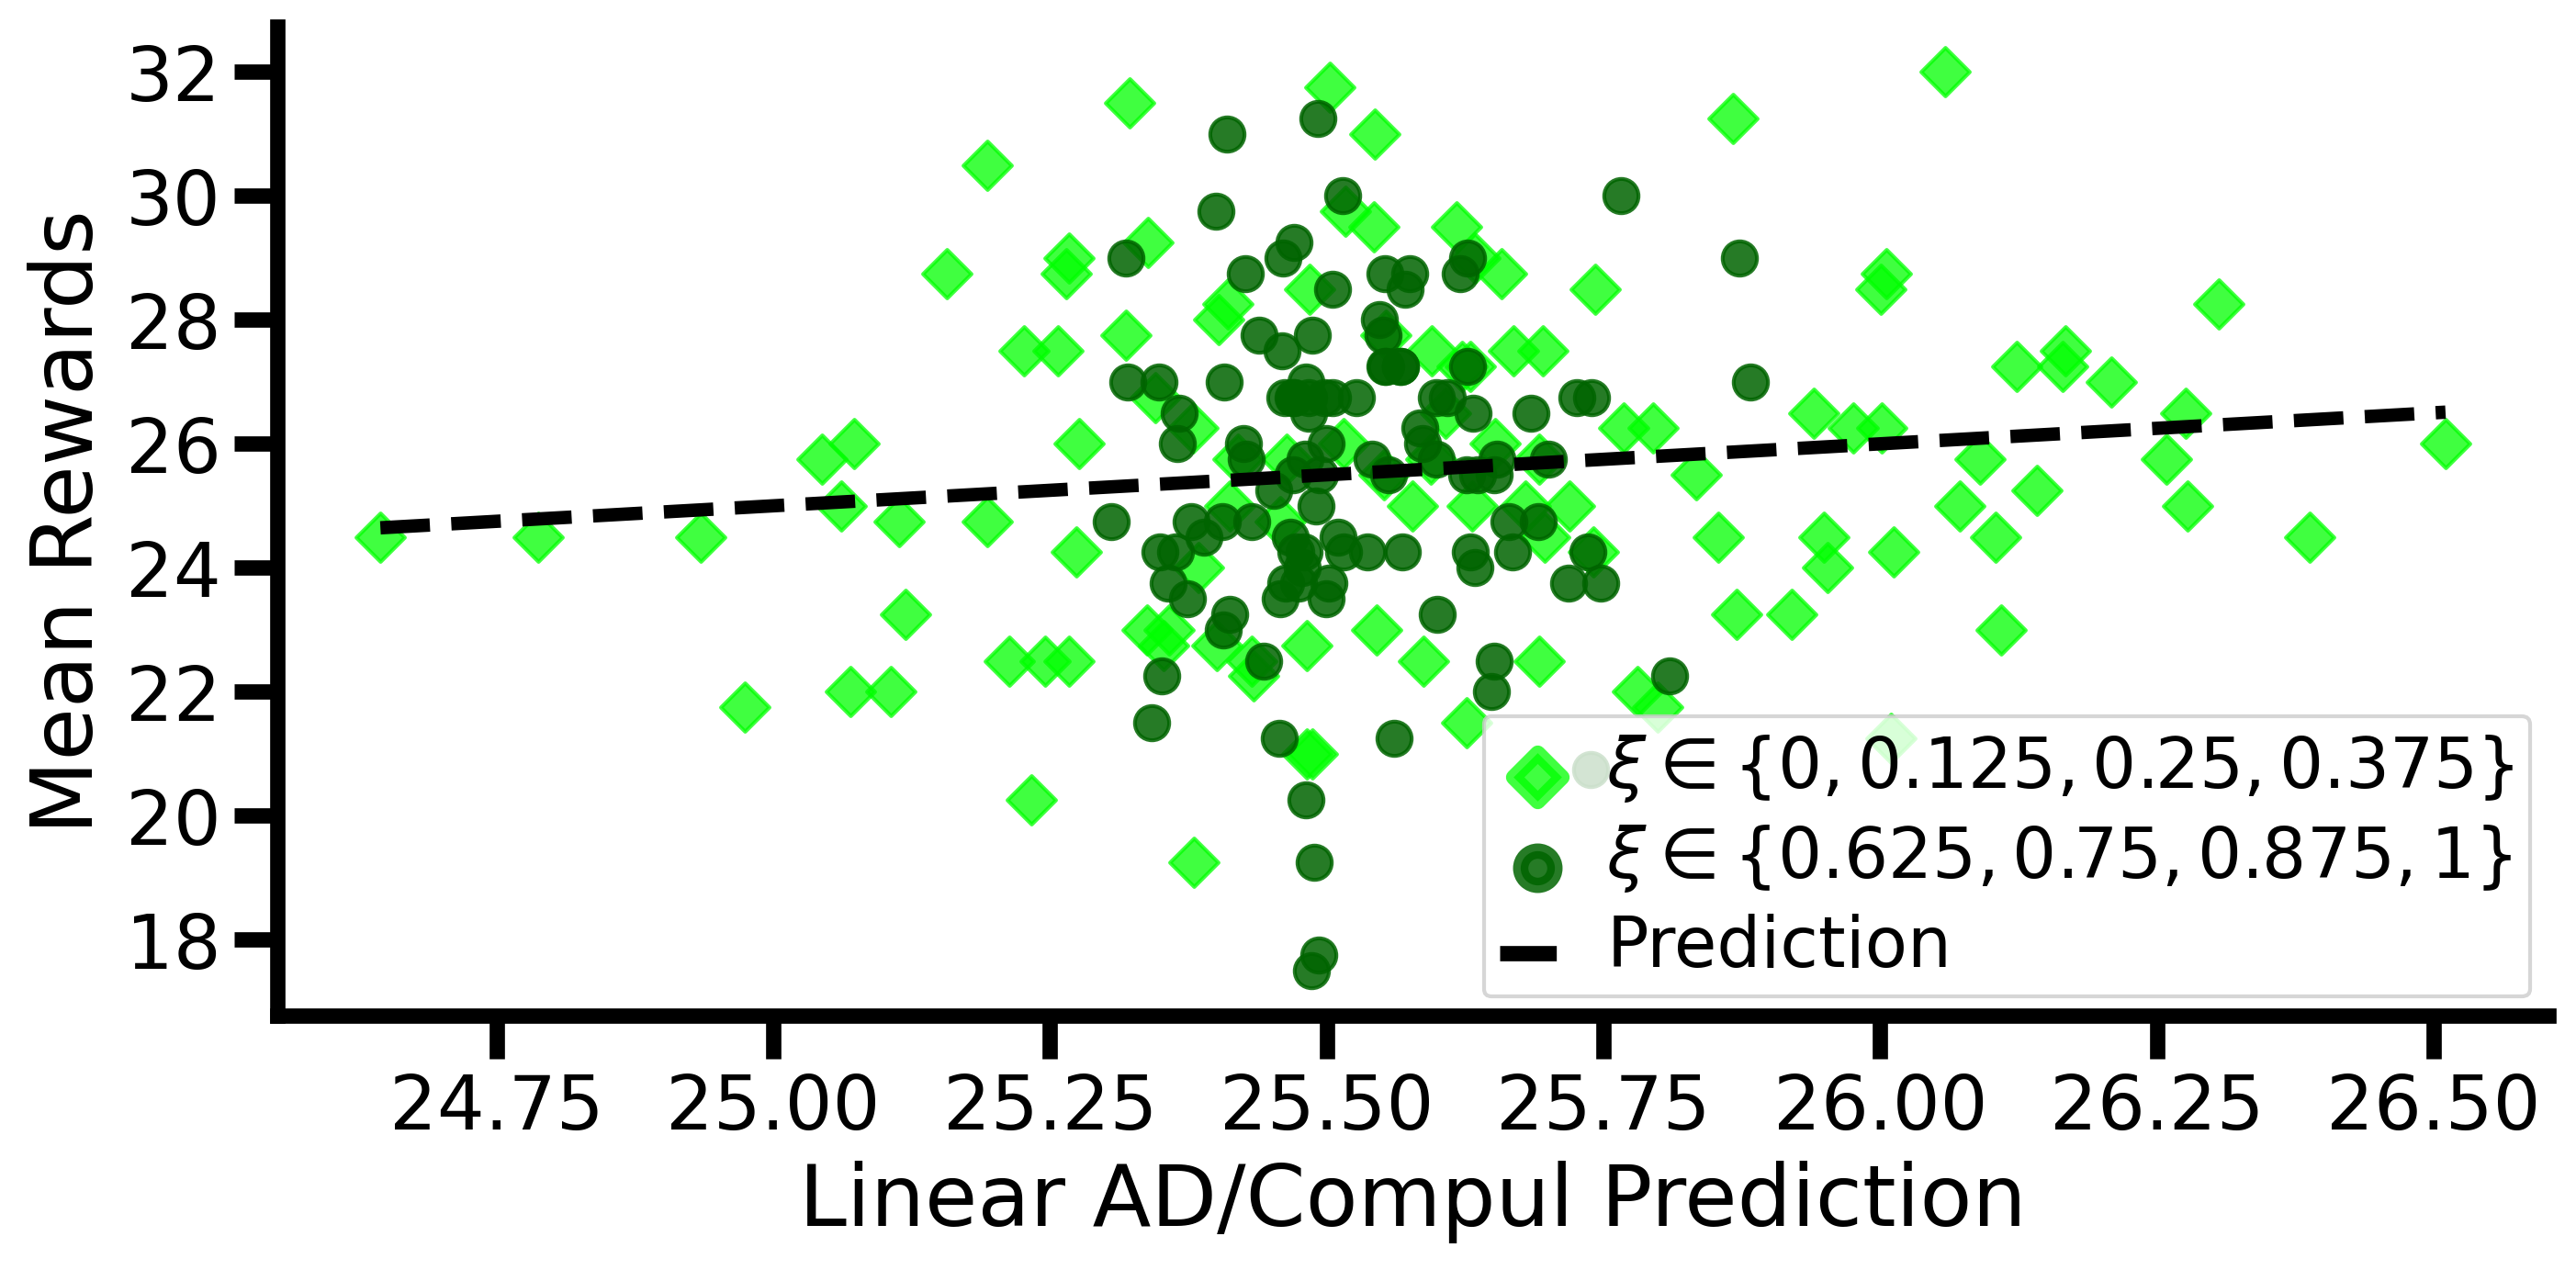

In [142]:
fig = plot_optimal_combination_model(y_loweff, results_loweff.predict(X), y_higheff, results_higheff.predict(X), ylabel='Mean Rewards')

In [143]:
fig.savefig(os.path.join(analysis_folder, 'lm_task1_rewards.png'))
fig.savefig(os.path.join(analysis_folder, 'lm_task1_rewards.svg'))

### Task 2 Sleeps

In [144]:
human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

mask = 'nomask'
iday = 3
day = 'day%d' %iday
exp_date = '24-01-22-29'
with_nets = False
include_sleep = False
include_estimates = False
group = None

analysis_folder = os.path.join('panels', 'fig_transdiags')

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

df['n_sleeps_higheff'] = df['n_sleeps'].apply(lambda x : np.mean(x[:4]))
df['n_sleeps_loweff'] = df['n_sleeps'].apply(lambda x : np.mean(x[5:]))

In [145]:
X = df[['AD', 'Compul']]
y_loweff = df['n_sleeps_loweff']
X = sm.add_constant(X)
model_loweff = sm.OLS(y_loweff,X)
results_loweff = model_loweff.fit()
results_loweff.params
results_loweff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        n_sleeps_loweff   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.7052
Date:                Thu, 29 Aug 2024   Prob (F-statistic):              0.496
Time:                        13:19:27   Log-Likelihood:                -232.94
No. Observations:                 111   AIC:                             471.9
Df Residuals:                     108   BIC:                             480.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5016      0.194     12.882      0.000       2.117       2.887
AD             0.2094      0.229      0.914      0.363      -0.244       0.663
Compul         0.0891      0.234      0.381      0.704      -0.375       0.553
==============================================================================
Omnibus:                       11.513   Durbin-Watson:                   1.766
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.080
Skew:                           0.791   Prob(JB):                      0.00238
Kurtosis:                       3.326   Cond. No.                         1.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [146]:
X = df[['AD', 'Compul']]
y_higheff = df['n_sleeps_higheff']
X = sm.add_constant(X)
model_higheff = sm.OLS(y_higheff,X)
results_higheff = model_higheff.fit()
results_higheff.params
results_higheff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       n_sleeps_higheff   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.051
Date:                Thu, 29 Aug 2024   Prob (F-statistic):              0.353
Time:                        13:19:27   Log-Likelihood:                -220.46
No. Observations:                 111   AIC:                             446.9
Df Residuals:                     108   BIC:                             455.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7354      0.174     15.761      0.000       2.391       3.079
AD             0.1943      0.205      0.949      0.345      -0.211       0.600
Compul         0.1432      0.209      0.684      0.495      -0.272       0.558
==============================================================================
Omnibus:                        9.378   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.460
Skew:                           0.703   Prob(JB):                      0.00883
Kurtosis:                       3.260   Cond. No.                         1.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

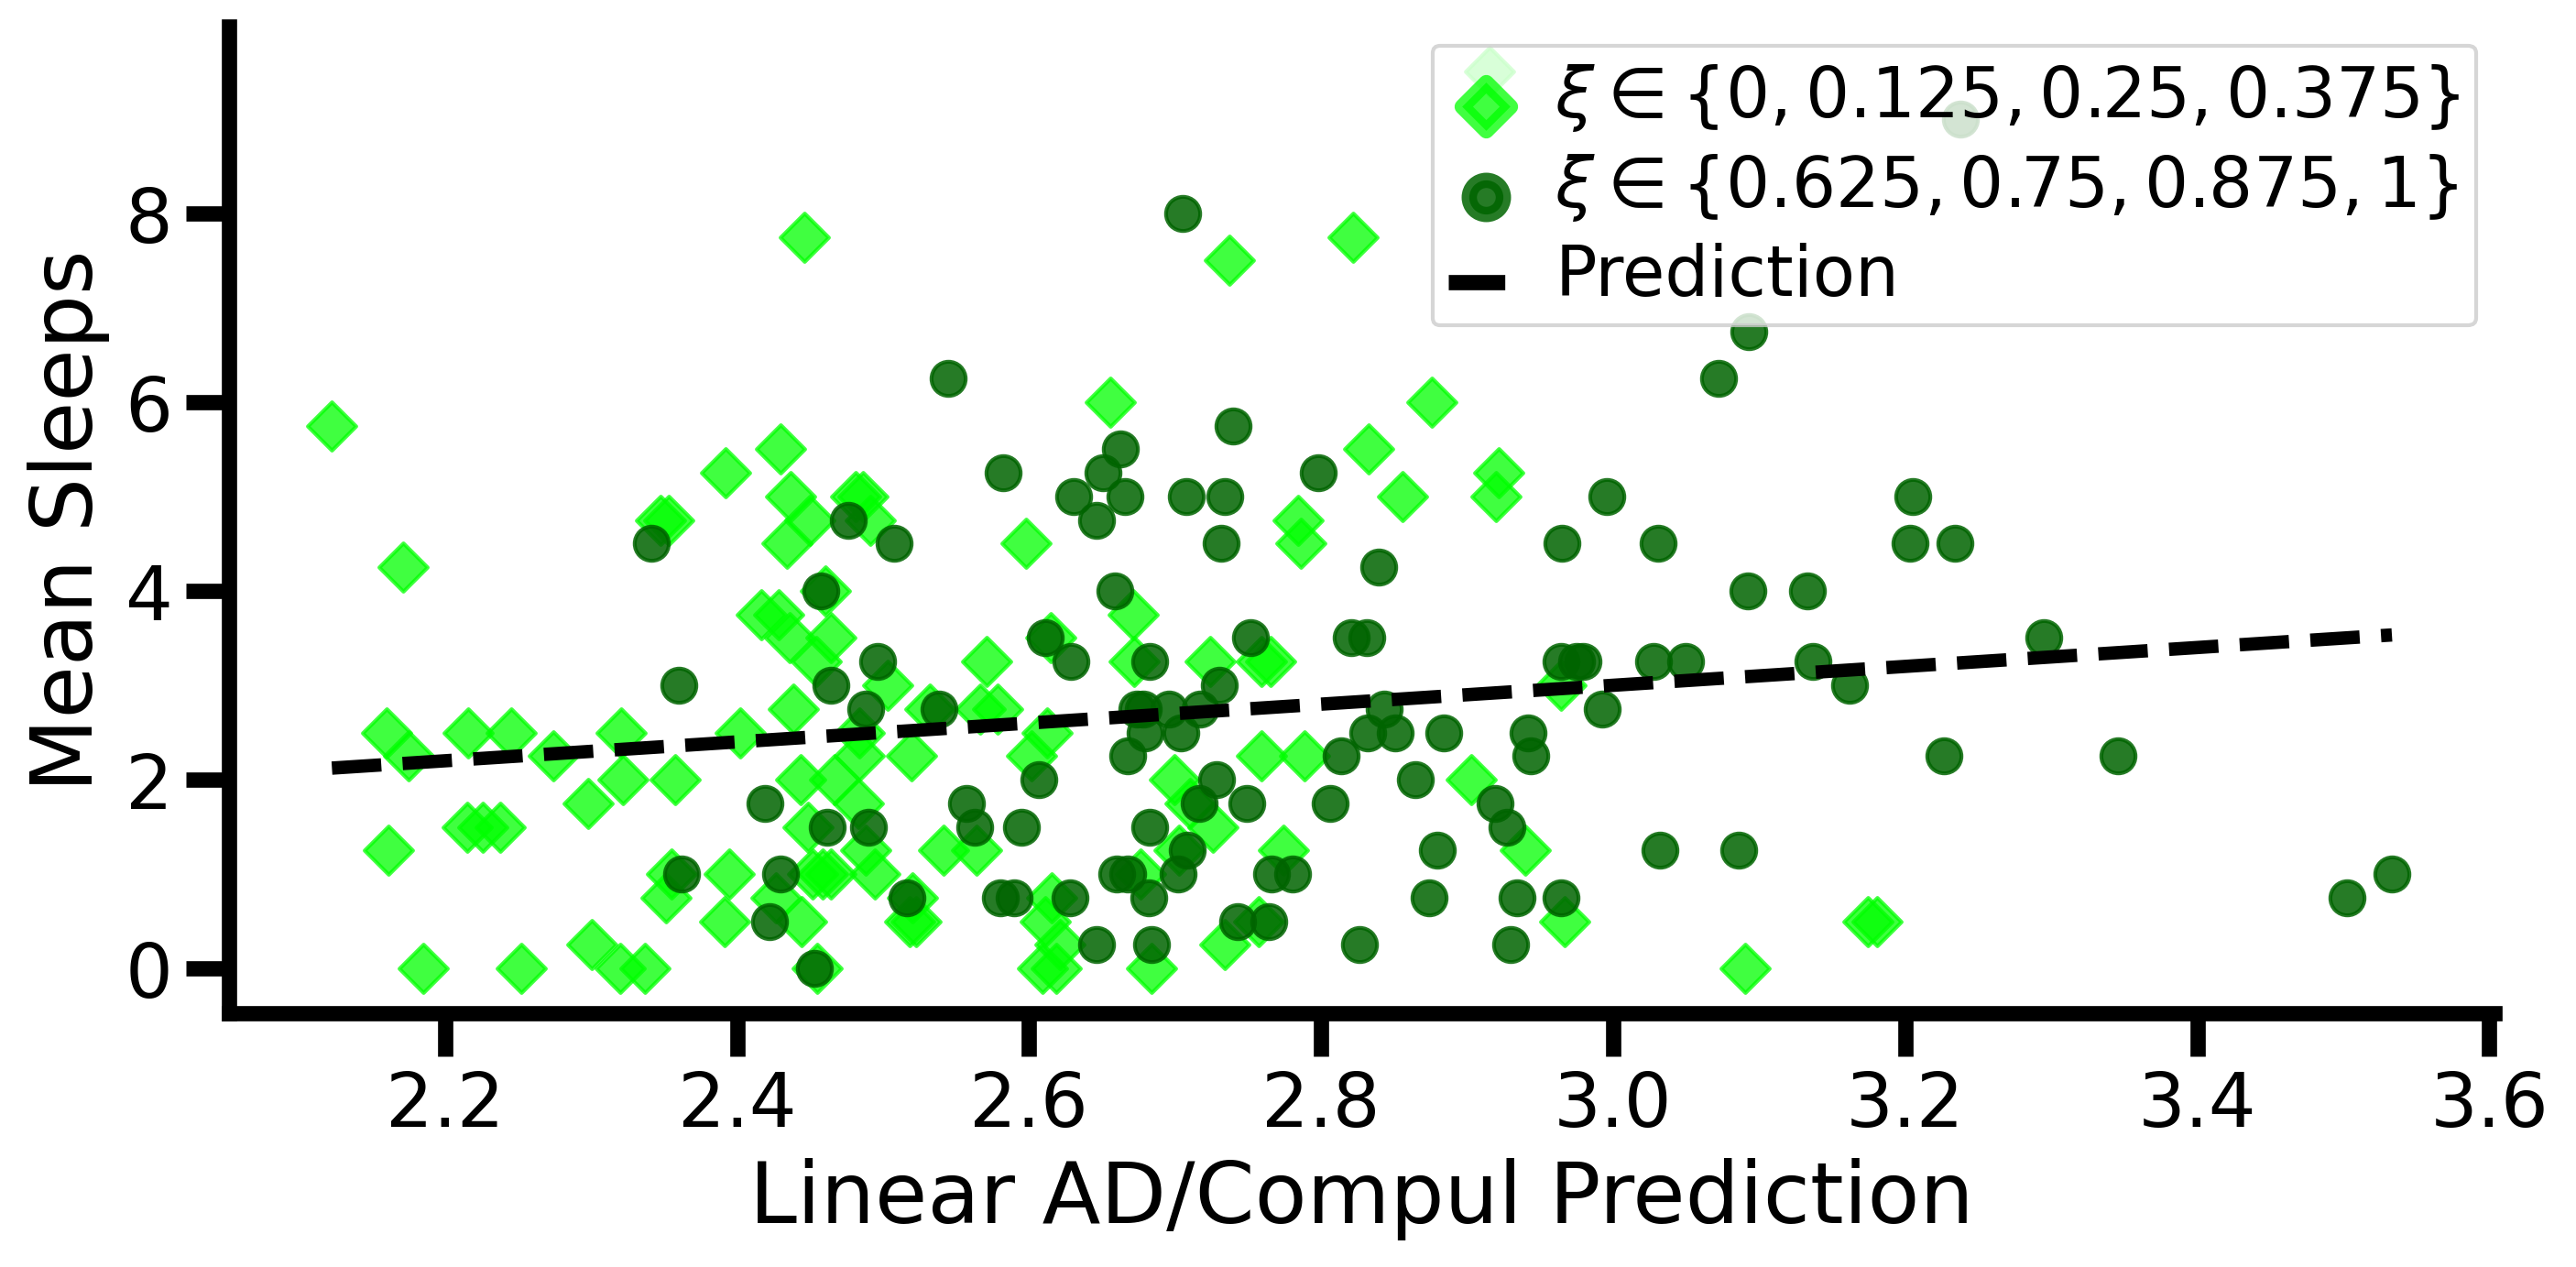

In [147]:
fig = plot_optimal_combination_model(y_loweff, results_loweff.predict(X), y_higheff, results_higheff.predict(X), ylabel='Mean Sleeps')

In [148]:
fig.savefig(os.path.join(analysis_folder, 'lm_task2_sleep.png'))
fig.savefig(os.path.join(analysis_folder, 'lm_task2_sleep.svg'))

In [149]:
X = df[['AD', 'Compul']]
y = np.stack(df['n_sleeps'].values).sum(axis=1)
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.055
Date:                Thu, 29 Aug 2024   Prob (F-statistic):              0.352
Time:                        13:19:28   Log-Likelihood:                -460.88
No. Observations:                 111   AIC:                             927.8
Df Residuals:                     108   BIC:                             935.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.5639      1.514     15.565      0.000      20.563      26.565
AD             2.0327      1.785      1.139      0.257      -1.506       5.571
Compul         0.7938      1.826      0.435      0.665      -2.825       4.413
==============================================================================
Omnibus:                        6.141   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                5.970
Skew:                           0.567   Prob(JB):                       0.0505
Kurtosis:                       3.065   Cond. No.                         1.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Task 2 Observes

In [150]:
human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

mask = 'nomask'
iday = 3
day = 'day%d' %iday
exp_date = '24-01-22-29'
with_nets = False
include_sleep = False
include_estimates = False
group = None

analysis_folder = os.path.join('panels', 'fig_transdiags')

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

df['n_observes_higheff'] = df['n_observes'].apply(lambda x : np.mean(x[:4]))
df['n_observes_loweff'] = df['n_observes'].apply(lambda x : np.mean(x[5:]))

In [151]:
X = df[['AD', 'Compul']]
y_loweff = df['n_observes_loweff']
X = sm.add_constant(X)
model_loweff = sm.OLS(y_loweff,X)
results_loweff = model_loweff.fit()
results_loweff.params
results_loweff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      n_observes_loweff   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     3.720
Date:                Thu, 29 Aug 2024   Prob (F-statistic):             0.0274
Time:                        13:19:28   Log-Likelihood:                -284.31
No. Observations:                 111   AIC:                             574.6
Df Residuals:                     108   BIC:                             582.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8166      0.308     18.855      0.000       5.205       6.428
AD             0.9900      0.364      2.722      0.008       0.269       1.711
Compul        -0.3002      0.372     -0.807      0.422      -1.038       0.437
==============================================================================
Omnibus:                        6.432   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.040   Jarque-Bera (JB):                5.941
Skew:                           0.542   Prob(JB):                       0.0513
Kurtosis:                       3.332   Cond. No.                         1.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [152]:
X = df[['AD', 'Compul']]
y_higheff = df['n_observes_higheff']
X = sm.add_constant(X)
model_higheff = sm.OLS(y_higheff,X)
results_higheff = model_higheff.fit()
results_higheff.params
results_higheff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     n_observes_higheff   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     4.320
Date:                Thu, 29 Aug 2024   Prob (F-statistic):             0.0157
Time:                        13:19:28   Log-Likelihood:                -274.81
No. Observations:                 111   AIC:                             555.6
Df Residuals:                     108   BIC:                             563.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6386      0.283     19.910      0.000       5.077       6.200
AD             0.9756      0.334      2.922      0.004       0.314       1.638
Compul        -0.4597      0.342     -1.346      0.181      -1.137       0.217
==============================================================================
Omnibus:                        1.872   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.392   Jarque-Bera (JB):                1.902
Skew:                           0.299   Prob(JB):                        0.386
Kurtosis:                       2.771   Cond. No.                         1.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

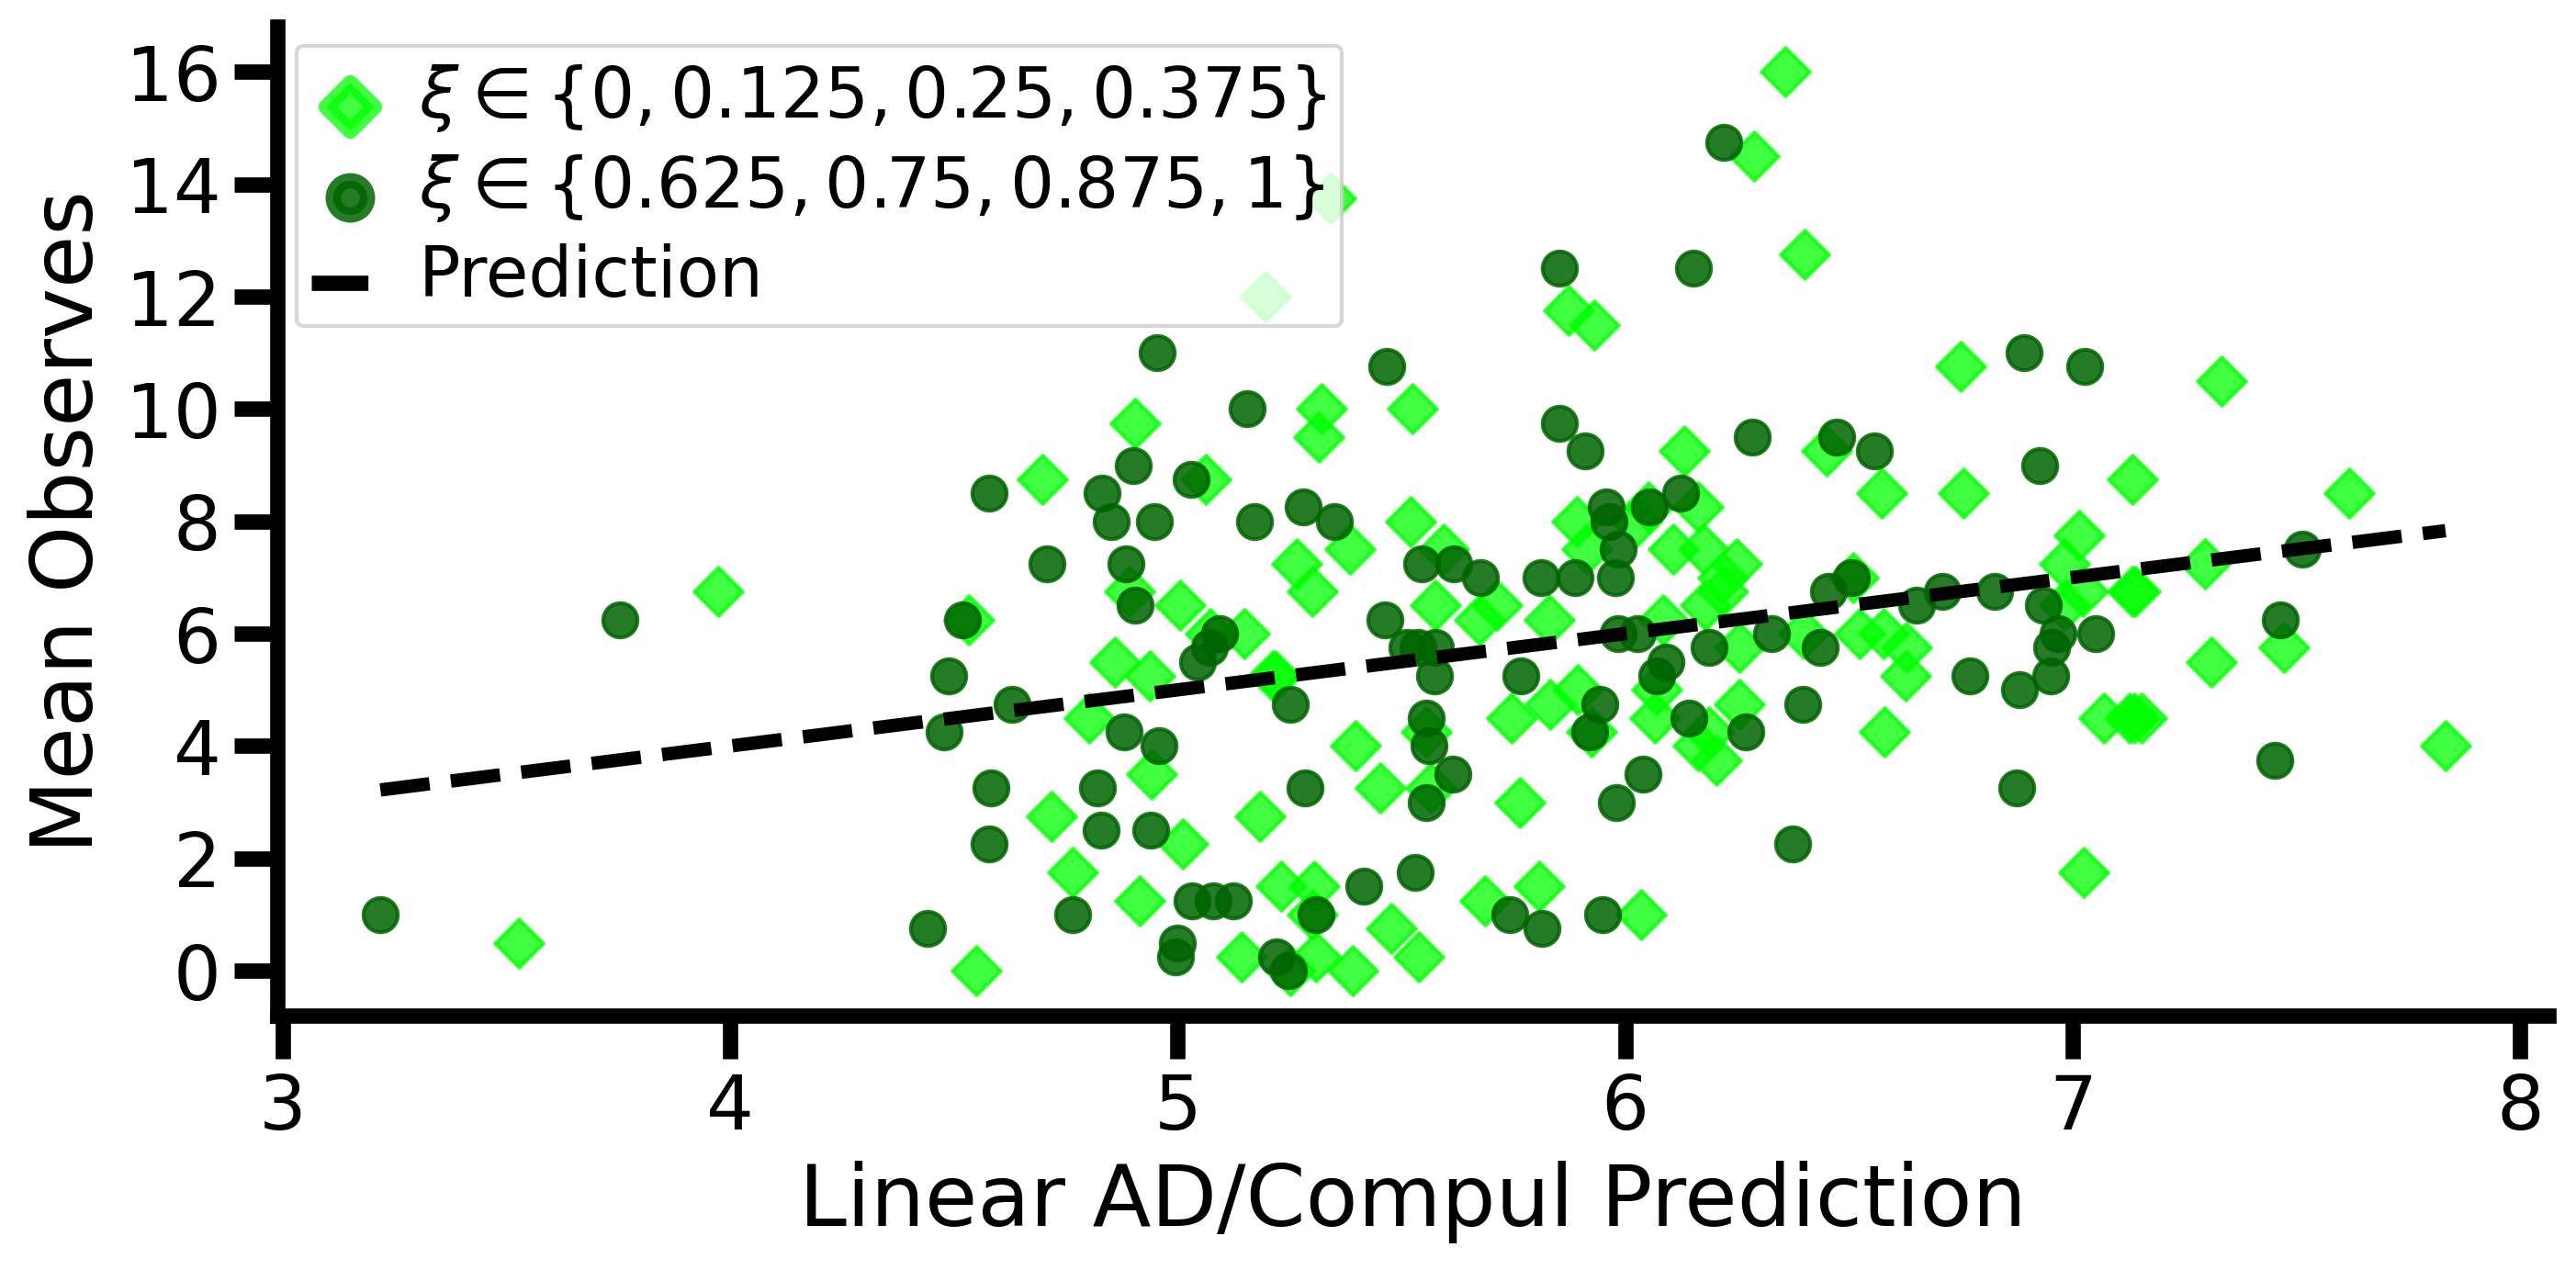

In [153]:
fig = plot_optimal_combination_model(y_loweff, results_loweff.predict(X), y_higheff, results_higheff.predict(X), ylabel='Mean Observes')

In [154]:
fig.savefig(os.path.join(analysis_folder, 'lm_task2_observes.png'))
fig.savefig(os.path.join(analysis_folder, 'lm_task2_observes.svg'))

### Task 2 Rewards

In [155]:
human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

mask = 'nomask'
iday = 3
day = 'day%d' %iday
exp_date = '24-01-22-29'
with_nets = False
include_sleep = False
include_estimates = False
group = None

analysis_folder = os.path.join('panels', 'fig_transdiags')

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

df['rewards_higheff'] = df['rewards_tallies'].apply(lambda x : np.mean(x[:4]))
df['rewards_loweff'] = df['rewards_tallies'].apply(lambda x : np.mean(x[5:]))

In [156]:
X = df[['AD', 'Compul']]
y_loweff = df['rewards_loweff']
X = sm.add_constant(X)
model_loweff = sm.OLS(y_loweff,X)
results_loweff = model_loweff.fit()
results_loweff.params
results_loweff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rewards_loweff   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1.939
Date:                Thu, 29 Aug 2024   Prob (F-statistic):              0.149
Time:                        13:19:28   Log-Likelihood:                -287.71
No. Observations:                 111   AIC:                             581.4
Df Residuals:                     108   BIC:                             589.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.8805      0.318     87.651      0.000      27.250      28.511
AD             0.6901      0.375      1.840      0.069      -0.053       1.434
Compul        -0.5039      0.384     -1.314      0.192      -1.264       0.256
==============================================================================
Omnibus:                        4.355   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.113   Jarque-Bera (JB):                3.774
Skew:                          -0.362   Prob(JB):                        0.152
Kurtosis:                       3.541   Cond. No.                         1.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [157]:
X = df[['AD', 'Compul']]
y_higheff = df['rewards_higheff']
X = sm.add_constant(X)
model_higheff = sm.OLS(y_higheff,X)
results_higheff = model_higheff.fit()
results_higheff.params
results_higheff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        rewards_higheff   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.082
Date:                Thu, 29 Aug 2024   Prob (F-statistic):              0.342
Time:                        13:19:28   Log-Likelihood:                -307.61
No. Observations:                 111   AIC:                             621.2
Df Residuals:                     108   BIC:                             629.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.2603      0.381     74.264      0.000      27.506      29.015
AD             0.5294      0.449      1.180      0.241      -0.360       1.419
Compul        -0.5704      0.459     -1.243      0.217      -1.480       0.339
==============================================================================
Omnibus:                        1.218   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.544   Jarque-Bera (JB):                0.996
Skew:                          -0.232   Prob(JB):                        0.608
Kurtosis:                       3.022   Cond. No.                         1.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [158]:
fig.savefig(os.path.join(analysis_folder, 'lm_task2_rewards.png'))
fig.savefig(os.path.join(analysis_folder, 'lm_task2_rewards.svg'))

## Stats
### With group assignment

In [159]:
from human_utils_transdiagnostics import preprocess_for_quantile_analysis
from scipy.stats import ttest_ind

rows = []
effs = np.arange(0, 1.01, 0.125)
num_bins = 9

### TASK 1
human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

mask = 'nomask'
iday = 2
day = 'day%d' %iday
exp_date = '24-01-22-29'
with_nets = False
include_sleep = False
include_estimates = False
group = None

analysis_folder = os.path.join('panels', 'fig_transdiags')

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

for item_name, item in zip(['Observes', 'Rewards'], [df['n_observes'], df['rewards_tallies']]):
    for td_name in ['AD', 'Compul', 'SW']:
        for current_group in [False, True]:
            td = df[td_name]
            item_group = np.stack(item[df['group'] == current_group].values)
            td_group = td[df['group'] == current_group]
            eff_group = np.stack(df['effs'][df['group'] == current_group].values)
            data_tds_group, td_quantiled_group = preprocess_for_quantile_analysis(item_group, td_group, eff_group)

            data_quantiled_group = [] ## first axis: efficacies, second axis: quantiles, third axis: participants

            for i in range(len(effs)):
                
                # Extracting all i-th efficacy values across rows
                #print(data_tds_group)
                all_effs = np.array([row[i] for row in data_tds_group])

                # Calculating quantile bins for the i-th efficacy values
                bins = np.quantile(td_quantiled_group, q=np.linspace(0, 1, num_bins+1))
                binss = bins
                
                # For each bin, calculate the average col2 score
                efficacy_quantiled = []
                for bin_index in range(num_bins):

                    in_bin = (td_quantiled_group >= bins[bin_index]) & (td_quantiled_group < bins[bin_index+1])
                    if bin_index == num_bins - 1:
                        in_bin |= (td_quantiled_group == bins[-1])

                    efficacy_quantiled.append(all_effs[in_bin])
            
                data_quantiled_group.append(efficacy_quantiled)

            #print(data_quantiled_group)
            ### PERFORM T_TEST OVER NONILES
            for efficacy_group_name, efficacy_group in zip(['Low', 'High'], [np.arange(0, 4), np.arange(5, 9)]):
                nonile_groupss = []
                for nonile_group_name, nonile_group in zip(['Low', 'High'], [np.arange(0, 4), np.arange(5, 9)]):
                    
                    nonile_groups = []

                    ## get average value for an individual in given nonile group
                    for eff in efficacy_group:
                        for nonile in nonile_group:
                            n_participants = len(data_quantiled_group[eff][nonile])
                            part_values = []
                            for part_id in range(n_participants):
                                part_values.append(data_quantiled_group[eff][nonile][part_id])
                        nonile_groups.append(np.mean(part_values))
                    nonile_groupss.append(nonile_groups)
                
                # Perform a t-test between the two groups
                t_stat, p_value = ttest_ind(nonile_groupss[0], nonile_groupss[1], equal_var=False)

                #print(f'T-test results:\nT-statistic: {t_stat}, P-value: {p_value}')
                ### Average within noniles        
                rows.append({"task": "T1", "Transdiagnostic": td_name, "item": item_name, "Group": 'A' if not current_group else 'B', "Efficacy Group": efficacy_group_name, "Low Noniles Mean": np.mean(nonile_groupss[0]), "High Noniles Mean": np.mean(nonile_groupss[1]), "t stat": t_stat, "p value": p_value})

# ### TASK 2
human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

mask = 'nomask'
iday = 3
day = 'day%d' %iday
exp_date = '24-01-22-29'
with_nets = False
include_sleep = False
include_estimates = False
group = None

analysis_folder = os.path.join('panels', 'fig_transdiags')

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

for item_name, item in zip(['Sleeps', 'Observes', 'Rewards',], [df['n_sleeps'], df['n_observes'], df['rewards_tallies']]):
    for td_name in ['AD', 'Compul', 'SW']:
        for current_group in [False, True]:
            td = df[td_name]
            item_group = np.stack(item[df['group'] == current_group].values)
            td_group = td[df['group'] == current_group]
            eff_group = np.stack(df['effs'][df['group'] == current_group].values)
            data_tds_group, td_quantiled_group = preprocess_for_quantile_analysis(item_group, td_group, eff_group)

            data_quantiled_group = [] ## first axis: efficacies, second axis: quantiles, third axis: participants

            for i in range(len(effs)):
                
                # Extracting all i-th efficacy values across rows
                #print(data_tds_group)
                all_effs = np.array([row[i] for row in data_tds_group])

                # Calculating quantile bins for the i-th efficacy values
                bins = np.quantile(td_quantiled_group, q=np.linspace(0, 1, num_bins+1))
                binss = bins
                
                # For each bin, calculate the average col2 score
                efficacy_quantiled = []
                for bin_index in range(num_bins):

                    in_bin = (td_quantiled_group >= bins[bin_index]) & (td_quantiled_group < bins[bin_index+1])
                    if bin_index == num_bins - 1:
                        in_bin |= (td_quantiled_group == bins[-1])

                    efficacy_quantiled.append(all_effs[in_bin])
            
                data_quantiled_group.append(efficacy_quantiled)

            #print(data_quantiled_group)
            ### PERFORM T_TEST OVER NONILES
            for efficacy_group_name, efficacy_group in zip(['Low', 'High'], [np.arange(0, 4), np.arange(5, 9)]):
                nonile_groupss = []
                for nonile_group_name, nonile_group in zip(['Low', 'High'], [np.arange(0, 4), np.arange(5, 9)]):
                    
                    nonile_groups = []

                    ## get average value for an individual in given nonile group
                    for eff in efficacy_group:
                        for nonile in nonile_group:
                            n_participants = len(data_quantiled_group[eff][nonile])
                            part_values = []
                            for part_id in range(n_participants):
                                part_values.append(data_quantiled_group[eff][nonile][part_id])
                        nonile_groups.append(np.mean(part_values))
                    nonile_groupss.append(nonile_groups)
                
                # Perform a t-test between the two groups
                t_stat, p_value = ttest_ind(nonile_groupss[0], nonile_groupss[1], equal_var=False)

                #print(f'T-test results:\nT-statistic: {t_stat}, P-value: {p_value}')
                ### Average within noniles        
                rows.append({"task": "T2", "Transdiagnostic": td_name, "item": item_name, "Group": 'A' if not current_group else 'B', "Efficacy Group": efficacy_group_name, "Low Noniles Mean": np.mean(nonile_groupss[0]), "High Noniles Mean": np.mean(nonile_groupss[1]), "t stat": t_stat, "p value": p_value})

        
### COMBINATION
df_ttest = pd.DataFrame(rows)

#df_ttest['Name'] = df_cosim['task'] + ' ' + df_cosim['item']

df_ttest

task Transdiagnostic      item Group Efficacy Group  Low Noniles Mean  \
0    T1              AD  Observes     A            Low          6.900000   
1    T1              AD  Observes     A           High          9.300000   
2    T1              AD  Observes     B            Low          3.214286   
3    T1              AD  Observes     B           High          4.357143   
4    T1          Compul  Observes     A            Low          4.700000   
5    T1          Compul  Observes     A           High          6.450000   
6    T1          Compul  Observes     B            Low          4.500000   
7    T1          Compul  Observes     B           High          8.428571   
8    T1              SW  Observes     A            Low          4.750000   
9    T1              SW  Observes     A           High          7.400000   
10   T1              SW  Observes     B            Low          3.142857   
11   T1              SW  Observes     B           High          7.678571   
12   T1              AD   Rewards     A            Low         23.400000   
13   T1              AD   Rewards     A           High         27.350000   
14   T1              AD   Rewards     B            Low         24.357143   
15   T1              AD   Rewards     B           High         26.964286   
16   T1          Compul   Rewards     A            Low         24.350000   
17   T1          Compul   Rewards     A           High         28.650000   
18   T1          Compul   Rewards     B            Low         23.392857   
19   T1          Compul   Rewards     B           High         28.535714   
20   T1              SW   Rewards     A            Low         22.500000   
21   T1              SW   Rewards     A           High         23.850000   
22   T1              SW   Rewards     B            Low         22.500000   
23   T1              SW   Rewards     B           High         28.071429   
24   T2              AD    Sleeps     A            Low          3.050000   
25   T2              AD    Sleeps     A           High          1.850000   
26   T2              AD    Sleeps     B            Low          4.035714   
27   T2              AD    Sleeps     B           High          1.071429   
28   T2          Compul    Sleeps     A            Low          3.650000   
29   T2          Compul    Sleeps     A           High          1.750000   
30   T2          Compul    Sleeps     B            Low          2.892857   
31   T2          Compul    Sleeps     B           High          0.500000   
32   T2              SW    Sleeps     A            Low          4.600000   
33   T2              SW    Sleeps     A           High          2.050000   
34   T2              SW    Sleeps     B            Low          2.285714   
35   T2              SW    Sleeps     B           High          0.464286   
36   T2              AD  Observes     A            Low          7.800000   
37   T2              AD  Observes     A           High          7.450000   
38   T2              AD  Observes     B            Low          3.785714   
39   T2              AD  Observes     B           High          3.321429   
40   T2          Compul  Observes     A            Low          5.200000   
41   T2          Compul  Observes     A           High          5.350000   
42   T2          Compul  Observes     B            Low          4.392857   
43   T2          Compul  Observes     B           High          4.750000   
44   T2              SW  Observes     A            Low          5.850000   
45   T2              SW  Observes     A           High          6.000000   
46   T2              SW  Observes     B            Low          4.321429   
47   T2              SW  Observes     B           High          5.107143   
48   T2              AD   Rewards     A            Low         24.800000   
49   T2              AD   Rewards     A           High         33.500000   
50   T2              AD   Rewards     B            Low         22.964286   
51   T2              AD   Rewards     B           H

### Without group assignment

In [160]:
from human_utils_transdiagnostics import preprocess_for_quantile_analysis
from scipy.stats import ttest_ind

rows = []
effs = np.arange(0, 1.01, 0.125)
num_bins = 9

### TASK 1
human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

mask = 'nomask'
iday = 2
day = 'day%d' %iday
exp_date = '24-01-22-29'
with_nets = False
include_sleep = False
include_estimates = False
group = None

analysis_folder = os.path.join('panels', 'fig_transdiags')

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

for item_name, item in zip(['Observes', 'Rewards'], [df['n_observes'], df['rewards_tallies']]):
    for td_name in ['AD', 'Compul', 'SW']:
        
        td = df[td_name]
        item_group = np.stack(item.values)
        td_group = td
        eff_group = np.stack(df['effs'].values)
        data_tds_group, td_quantiled_group = preprocess_for_quantile_analysis(item_group, td_group, eff_group)

        data_quantiled_group = [] ## first axis: efficacies, second axis: quantiles, third axis: participants

        for i in range(len(effs)):
            
            # Extracting all i-th efficacy values across rows
            #print(data_tds_group)
            all_effs = np.array([row[i] for row in data_tds_group])

            # Calculating quantile bins for the i-th efficacy values
            bins = np.quantile(td_quantiled_group, q=np.linspace(0, 1, num_bins+1))
            binss = bins
            
            # For each bin, calculate the average col2 score
            efficacy_quantiled = []
            for bin_index in range(num_bins):

                in_bin = (td_quantiled_group >= bins[bin_index]) & (td_quantiled_group < bins[bin_index+1])
                if bin_index == num_bins - 1:
                    in_bin |= (td_quantiled_group == bins[-1])

                efficacy_quantiled.append(all_effs[in_bin])
        
            data_quantiled_group.append(efficacy_quantiled)

        #print(data_quantiled_group)
        ### PERFORM T_TEST OVER NONILES
        for efficacy_group_name, efficacy_group in zip(['Low', 'High'], [np.arange(0, 4), np.arange(5, 9)]):
            nonile_groupss = []
            for nonile_group_name, nonile_group in zip(['Low', 'High'], [np.arange(0, 4), np.arange(5, 9)]):
                
                nonile_groups = []

                ## get average value for an individual in given nonile group
                for eff in efficacy_group:
                    for nonile in nonile_group:
                        n_participants = len(data_quantiled_group[eff][nonile])
                        part_values = []
                        for part_id in range(n_participants):
                            part_values.append(data_quantiled_group[eff][nonile][part_id])
                    nonile_groups.append(np.mean(part_values))
                nonile_groupss.append(nonile_groups)
            
            # Perform a t-test between the two groups
            t_stat, p_value = ttest_ind(nonile_groupss[0], nonile_groupss[1], equal_var=False)

            #print(f'T-test results:\nT-statistic: {t_stat}, P-value: {p_value}')
            ### Average within noniles        
            rows.append({"task": "T1", "Transdiagnostic": td_name, "item": item_name, "Efficacy Group": efficacy_group_name, "Low Noniles Mean": np.mean(nonile_groupss[0]), "High Noniles Mean": np.mean(nonile_groupss[1]), "t stat": t_stat, "p value": p_value})

# ### TASK 2
human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

mask = 'nomask'
iday = 3
day = 'day%d' %iday
exp_date = '24-01-22-29'
with_nets = False
include_sleep = False
include_estimates = False
group = None

analysis_folder = os.path.join('panels', 'fig_transdiags')

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

for item_name, item in zip(['Sleeps', 'Observes', 'Rewards',], [df['n_sleeps'], df['n_observes'], df['rewards_tallies']]):
    for td_name in ['AD', 'Compul', 'SW']:
        td = df[td_name]
        item_group = np.stack(item.values)
        td_group = td
        eff_group = np.stack(df['effs'].values)
        data_tds_group, td_quantiled_group = preprocess_for_quantile_analysis(item_group, td_group, eff_group)

        data_quantiled_group = [] ## first axis: efficacies, second axis: quantiles, third axis: participants

        for i in range(len(effs)):
            
            # Extracting all i-th efficacy values across rows
            #print(data_tds_group)
            all_effs = np.array([row[i] for row in data_tds_group])

            # Calculating quantile bins for the i-th efficacy values
            bins = np.quantile(td_quantiled_group, q=np.linspace(0, 1, num_bins+1))
            binss = bins
            
            # For each bin, calculate the average col2 score
            efficacy_quantiled = []
            for bin_index in range(num_bins):

                in_bin = (td_quantiled_group >= bins[bin_index]) & (td_quantiled_group < bins[bin_index+1])
                if bin_index == num_bins - 1:
                    in_bin |= (td_quantiled_group == bins[-1])

                efficacy_quantiled.append(all_effs[in_bin])
        
            data_quantiled_group.append(efficacy_quantiled)

        #print(data_quantiled_group)
        ### PERFORM T_TEST OVER NONILES
        for efficacy_group_name, efficacy_group in zip(['Low', 'High'], [np.arange(0, 4), np.arange(5, 9)]):
            nonile_groupss = []
            for nonile_group_name, nonile_group in zip(['Low', 'High'], [np.arange(0, 4), np.arange(5, 9)]):
                
                nonile_groups = []

                ## get average value for an individual in given nonile group
                for eff in efficacy_group:
                    for nonile in nonile_group:
                        n_participants = len(data_quantiled_group[eff][nonile])
                        part_values = []
                        for part_id in range(n_participants):
                            part_values.append(data_quantiled_group[eff][nonile][part_id])
                    nonile_groups.append(np.mean(part_values))
                nonile_groupss.append(nonile_groups)
            
            # Perform a t-test between the two groups
            t_stat, p_value = ttest_ind(nonile_groupss[0], nonile_groupss[1], equal_var=False)

            #print(f'T-test results:\nT-statistic: {t_stat}, P-value: {p_value}')
            ### Average within noniles        
            rows.append({"task": "T2", "Transdiagnostic": td_name, "item": item_name, "Efficacy Group": efficacy_group_name, "Low Noniles Mean": np.mean(nonile_groupss[0]), "High Noniles Mean": np.mean(nonile_groupss[1]), "t stat": t_stat, "p value": p_value})
        
### COMBINATION
df_ttest = pd.DataFrame(rows)

#df_ttest['Name'] = df_cosim['task'] + ' ' + df_cosim['item']

df_ttest

task Transdiagnostic      item Efficacy Group  Low Noniles Mean  \
0    T1              AD  Observes            Low          4.000000   
1    T1              AD  Observes           High          6.541667   
2    T1          Compul  Observes            Low          4.937500   
3    T1          Compul  Observes           High          7.625000   
4    T1              SW  Observes            Low          3.729167   
5    T1              SW  Observes           High          7.500000   
6    T1              AD   Rewards            Low         23.916667   
7    T1              AD   Rewards           High         27.312500   
8    T1          Compul   Rewards            Low         23.812500   
9    T1          Compul   Rewards           High         27.791667   
10   T1              SW   Rewards            Low         22.875000   
11   T1              SW   Rewards           High         26.750000   
12   T2              AD    Sleeps            Low          3.541667   
13   T2              AD    Sleeps           High          1.208333   
14   T2          Compul    Sleeps            Low          3.500000   
15   T2          Compul    Sleeps           High          1.083333   
16   T2              SW    Sleeps            Low          2.520833   
17   T2              SW    Sleeps           High          0.791667   
18   T2              AD  Observes            Low          5.354167   
19   T2              AD  Observes           High          5.291667   
20   T2          Compul  Observes            Low          5.791667   
21   T2          Compul  Observes           High          5.750000   
22   T2              SW  Observes            Low          4.625000   
23   T2              SW  Observes           High          5.312500   
24   T2              AD   Rewards            Low         24.104167   
25   T2              AD   Rewards           High         29.937500   
26   T2          Compul   Rewards            Low         26.416667   
27   T2          Compul   Rewards           High         32.687500   
28   T2              SW   Rewards            Low         24.916667   
29   T2              SW   Rewards           High         31.416667   

    High Noniles Mean    t stat   p value  
0            5.192308 -1.861552  0.149707  
1            7.230769 -1.525718  0.191273  
2            6.750000 -2.573782  0.044824  
3            7.019231  1.077341  0.342490  
4            7.269231 -4.801890  0.003959  
5            7.480769  0.038512  0.970710  
6           24.153846 -0.308144  0.768663  
7           28.134615 -0.575687  0.587514  
8           22.692308  1.220520  0.272576  
9           28.576923 -0.673103  0.526225  
10          23.096154 -0.230380  0.826713  
11          28.730769 -1.253267  0.262703  
12           4.250000 -1.088327  0.321486  
13           1.653846 -1.164782  0.313542  
14           4.500000 -1.980457  0.108261  
15           2.250000 -3.193638  0.021228  
16           4.000000 -1.782191  0.145542  
17           1.557692 -1.967073  0.101218  
18           6.461538 -4.113994  0.013763  
19           6.634615 -4.061458  0.007691  
20           6.519231 -2.187924  0.081996  
21           6.634615 -2.324559  0.079106  
22           7.057692 -8.206005  0.002191  
23           7.173077 -6.789164  0.000607  
24          25.961538 -1.488705  0.188022  
25          30.500000 -0.324399  0.756816  
26          24.769231  0.902858  0.430928  
27          29.653846  2.218182  0.075342  
28          24.192308  0.549645  0.602842  
29          29.692308  0.958757  0.383319

### Stats about Exclusion

In [161]:
human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

iday = 2
day = 'day%d' %iday
exp_date = '24-01-22-29'
#exp_date = '518-525-619-706'
with_nets = False
include_sleep = False
include_estimates = False
day1_test_mask_cutoff = None
group = None
#group = "groupA"

analysis_folder = os.path.join('panels', 'fig_transdiags')

df_all, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

### EMPTY TRANSDIAGS MARKED LIKE THIS: df[(df['AD'] < -2.40250) & (df['AD'] > -2.40252)]

In [162]:
human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

iday = 2
day = 'day%d' %iday
exp_date = '24-01-22-29'
#exp_date = '518-525-619-706'
with_nets = False
include_sleep = False
include_estimates = False
#day1_test_mask_cutoff = None
group = None
#group = "groupA"

day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}


analysis_folder = os.path.join('panels', 'fig_transdiags')

df_included, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

### EMPTY TRANSDIAGS MARKED LIKE THIS: df[(df['AD'] < -2.40250) & (df['AD'] > -2.40252)]

In [163]:
### Select difference of two dataframes

df_excluded = df_all[~df_all.index.isin(df_included.index)]
df_excluded

transitions_ep  \
582b12291bdd2f00018054f4  [[[0.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0,...   
595bb42745265c000166d399  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
6149aa576e63ebf7017287c3  [[[0.0, 0.5, 0.5], [0.0, 0.5, 0.5], [0.0, 0.5,...   
576b0cc76aed2e0001705386  [[[1.0, 0.5, 0.5], [1.0, 1.0, 1.0], [1.0, 0.0,...   
5c5865627607d00001432199  [[[0.0, 0.5, 0.5], [1.0, 0.0, 0.0], [1.0, 0.0,...   
...                                                                     ...   
63d7a22ff9d8f3c778a83305  [[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0,...   
5fb242a8b0c0e17bad2840f4  [[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0,...   
5c37223ebef9a20001e38dad  [[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0,...   
5c1d234d89f035000172aeb7  [[[1.0, 0.5, 0.5], [1.0, 0.5, 0.5], [0.0, 1.0,...   
5b421b9ac2e3810001763252  [[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0,...   

                                                  transitions_ep_rightwrong  \
582b12291bdd2f00018054f4  [[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.5, 1.0, 1.0,...   
595bb42745265c000166d399  [[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0,...   
6149aa576e63ebf7017287c3  [[0.5, 0.5, 0.5, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0,...   
576b0cc76aed2e0001705386  [[0.5, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0,...   
5c5865627607d00001432199  [[0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0,...   
...                                                                     ...   
63d7a22ff9d8f3c778a83305  [[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,...   
5fb242a8b0c0e17bad2840f4  [[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,...   
5c37223ebef9a20001e38dad  [[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.5, 0.0,...   
5c1d234d89f035000172aeb7  [[0.5, 0.5, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
5b421b9ac2e3810001763252  [[0.0, 0.0, 0.0, 0.5, 1.0, 0.0, 0.5, 1.0, 0.0,...   

                                                            rewards_tallies  \
582b12291bdd2f00018054f4  [29.0, 23.0, 28.0, 28.0, 20.0, 22.0, 22.0, 23....   
595bb42745265c000166d399               [26, 18, 27, 20, 24, 21, 26, 27, 26]   
6149aa576e63ebf7017287c3  [34.0, 19.0, 21.0, 19.0, 18.0, 22.0, 25.0, 19....   
576b0cc76aed2e0001705386  [27.0, 15.0, 21.0, 19.0, 18.0, 18.0, 14.0, 25....   
5c5865627607d00001432199  [3.0, 22.0, 25.0, 32.0, 30.0, 29.0, 26.0, 22.0...   
...                                                                     ...   
63d7a22ff9d8f3c778a83305               [23, 25, 30, 26, 23, 22, 27, 24, 22]   
5fb242a8b0c0e17bad2840f4               [18, 28, 39, 22, 26, 21, 26, 19, 16]   
5c37223ebef9a20001e38dad  [22.0, 23.0, 28.0, 21.0, 24.0, 23.0, 24.0, 23....   
5c1d234d89f035000172aeb7               [25, 22, 23, 29, 18, 21, 21, 31, 29]   
5b421b9ac2e3810001763252               [26, 29, 23, 26, 32, 20, 29, 27, 28]   

                                                                         ps  \
582b12291bdd2f00018054f4  [[[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, ...   
595bb42745265c000166d399  [[[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, ...   
6149aa576e63ebf7017287c3  [[[1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, ...   
576b0cc76aed2e0001705386  [[[0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, ...   
5c5865627607d00001432199  [[[1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, ...   
...                                                                     ...   
63d7a22ff9d8f3c778a83305  [[[0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, ...   
5fb242a8b0c0e17bad2840f4  [[[0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, ...   
5c37223ebef9a20001e38dad  [[[0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, ...   
5c1d234d89f035000172aeb7  [[[0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, ...   
5b421b9ac2e3810001763252  [[[0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, ...   

                                                                       effs  \
582b12291bdd2f00018054f4  [0.0, 0.75, 1.0, 0.25, 0.5, 0.625, 0.375, 0.12...   
595bb42745265c000166d399  [0.75, 0.25, 0.0, 1.0, 0.875, 0.625, 0.375, 0....   
6149aa576e63ebf7017287c3  [0

In [164]:
### COMPARISON STATS - LOOK AT AD/COMPUL

for td in ['AD', 'Compul']:
    obs_included = df_included[td]
    obs_excluded = df_excluded[td]

    ## PRINT N/MEAN/SEM

    print(f'{td} included: N={len(obs_included)}, Mean={np.mean(obs_included)}, SEM={np.std(obs_included)/np.sqrt(len(obs_included))}')
    print(f'{td} excluded: N={len(obs_excluded)}, Mean={np.mean(obs_excluded)}, SEM={np.std(obs_excluded)/np.sqrt(len(obs_excluded))}')

    t_stat, p_value = ttest_ind(obs_included, obs_excluded, equal_var=False)

    print(f'T-test results:\nT-statistic: {t_stat}, P-value: {p_value}')


AD included: N=111, Mean=0.13461031857793265, SEM=0.08427491853872525
AD excluded: N=71, Mean=-0.19888288783700922, SEM=0.1067828600234609
T-test results:
T-statistic: 2.436640320292973, P-value: 0.01601462247082375
Compul included: N=111, Mean=0.17067132529189777, SEM=0.08239599963488026
Compul excluded: N=71, Mean=-0.04271874221889381, SEM=0.10973022975269264
T-test results:
T-statistic: 1.5455116102706057, P-value: 0.12444665732961191
